# Setup

In [1]:
from math import nan, isnan, inf, isfinite

import abc
import collections
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as st
import shutil
import sys

HOME = os.path.expanduser('~')

# sys.path.insert(0, f'{HOME}/code/slurmqueen') # github.com/vuphan314/slurmqueen
!{sys.executable} -m pip install slurmqueen -q # pypi.org/project/slurmqueen

import slurmqueen
from slurmqueen.experiment import Command
from slurmqueen.slurm_experiment import SlurmExperiment

import wrapper#.py

cerr = print

def getFilePaths(dirPaths, fileNameEnds=set(), excludedFileNameEnds=set()):
    assert isinstance(dirPaths, set), dirPaths
    assert isinstance(fileNameEnds, set), fileNameEnds
    assert isinstance(excludedFileNameEnds, set), excludedFileNameEnds
    filePaths = []
    for dirPath in dirPaths:
        dirPath = os.path.expanduser(dirPath)
        for (subdirPath, _, fileNames) in os.walk(dirPath):
            for fileName in fileNames:
                if not fileNameEnds or any(
                    [fileName.endswith(fileNameEnd) for fileNameEnd in fileNameEnds]
                ):
                    if all([not fileName.endswith(suffix) for suffix in excludedFileNameEnds]):
                        filePath = os.path.join(subdirPath, fileName)
                        filePaths.append(filePath)
    if not filePaths:
        print(f'no matched files in {dirPaths}')
    return sorted(filePaths)

def getRunScript(slurmMemCap, strictFlag):
    script = [
        '',
        f'#SBATCH --mem={slurmMemCap}g',
        f'#SBATCH --mail-type=all'
    ]
    script += [
        '',
        '#SBATCH --exclusive',
        '#SBATCH --constraint=ivybridge'
    ] if strictFlag else []
    script += [
        '',
        'export XALT_EXECUTABLE_TRACKING=no',
        'ml load GCC/10.3.0 Python/3.9.5'
    ]
    return '\n'.join(script)

In [2]:
DEPENDENCIES = [ # these files will be copied to NOTS (/scratch/) by SlurmQueen
    'dpmc.py', 'wrapper.py', 'postprocessor.py'
]

class Exp(SlurmExperiment, metaclass=abc.ABCMeta):
    def prepare_server(self, inst): # after copying files and before submitting jobs
        files = [inst.remote_experiment_path(f) for f in DEPENDENCIES]
        cmds = [f'chmod +x {" ".join(files)}']
        for relPath in ['bin', 'benchmarks']:
            projectPath = f'/projects/vardi/vhp1/{relPath}'
            scratchPath = inst.remote_experiment_path(relPath)
            cmds.append(f'mkdir -p {os.path.dirname(scratchPath)}')
            cmds.append(f'ln -sf {projectPath} {scratchPath}')
        cmd = ' && '.join(cmds)
        inst.server.execute(cmd)

    def getInst(self):
        netid = 'vhp1'
        return Inst(
            self,
            slurmqueen.ExperimentConfig(
                server=slurmqueen.SlurmServer('nots.rice.edu', netid, f'{HOME}/.ssh/id_rsa'),
                partition='scavenge',
                local_directory=os.getcwd(),
                remote_directory=f'/scratch/{netid}'
            )
        )

    @abc.abstractmethod
    def getWrapperDict(self, benchmarkPath):
        pass

    def getCmd(self, benchmarkPath):
        kwargs = {'cf': benchmarkPath, 'ctrl': 1, 'post': 1}
        return Command(
            'python3',
            'wrapper.py',
            **kwargs,
            **self.getWrapperDict(benchmarkPath),
        )

    def getCmds(self):
        cmds = []
        filePaths = getFilePaths(self.benchmarksPath)
        for i in range(len(filePaths)):
            if not self.actualTasks or i in self.actualTasks:
                cmds.append(self.getCmd(filePaths[i]))
        return cmds

def getIntDigits(num): # SlurmQueen
    return len(str(num))

def justifyInt(num, digitCount):
    assert isinstance(num, int), num
    return str(num).rjust(digitCount, '0')

def copyFile(oldPath, newPath):
    if os.path.exists(newPath):
        raise Exception(f'Existing file: {newPath}')
    shutil.copyfile(oldPath, newPath)

In [3]:
class Inst(slurmqueen.slurm_experiment.SlurmInstance):
    def getTable(self, q):
        df = self.query(q)
        return df.rename(
            columns={
                col: f'{col}{self._exp.suffix}' for col in df.head() if col not in {'file', 'cf', 'base'}
            }
        )

    def runExp(self):
        p = self._exp.id
        if os.path.exists(p):
            answer = input(f'Delete existing local file ({p}) [Y/N]: ')
            if answer.upper() == 'Y':
                shutil.rmtree(p)
            else:
                print(f'Skipped experiment ({p})')
                return
        self.run(len(self._exp.getCmds()), f'0:{self._exp.slurmTimeCap}')

    def checkData(self, cfFlag=True):
        def checkFile(filePath):
            if os.path.isfile(filePath):
                return True
            else:
                print(f'Missing file:\t{filePath}')
                return False

        benchmarkPaths = getFilePaths(self._exp.benchmarksPath)
        for i in range(len(benchmarkPaths)):
            for ext in ['in', 'log', 'out']:
                filePath = os.path.join(
                    self._exp.id,
                    f'{justifyInt(i, getIntDigits(len(benchmarkPaths)))}.{ext}'
                )
                if checkFile(filePath):
                    if not os.path.getsize(filePath):
                        print(f'Empty file:\t{filePath}')
                    elif cfFlag and os.path.basename(benchmarkPaths[i]) not in open(filePath).readline():
                        print(f'Wrong cf:\t{filePath}')

    def renameFiles(self):
        newDirPath = f'{self._exp.id}Renamed'
        os.makedirs(newDirPath)
        for i in range(len(self._exp.actualTasks)):
            newTask = self._exp.actualTasks[i]

            oldPath = os.path.join(self._exp.id, f'slurm_{i}.worker')
            newPath = os.path.join(newDirPath, f'slurm_{newTask}.worker')
            copyFile(oldPath, newPath)
            for ext in ['in', 'log', 'out']:
                oldDigits = getIntDigits(len(self._exp.actualTasks))
                newDigits = getIntDigits(len(getFilePaths(self._exp.benchmarksPath)))
                oldPath = os.path.join(self._exp.id, f'{justifyInt(i, oldDigits)}.{ext}')
                newPath = os.path.join(newDirPath, f'{justifyInt(newTask, newDigits)}.{ext}')
                try:
                    copyFile(oldPath, newPath)
                except FileNotFoundError as e:
                    print(e)

# Experiments

In [4]:
TIME = 1000 # paper
RUNNER_TIME = 1010 # ctrl
SLURM_TIME = 1020

HI_MEM = 100 # paper
HI_RUNNER_MEM = 110 # ctrl
HI_SLURM_MEM = 120

LO_MEM = 25 # paper
LO_RUNNER_MEM = 27 # ctrl
LO_SLURM_MEM = 29

## CryptoMiniSat

In [5]:
class CmsExp(Exp):
    def __init__(
        self,
        benchmarksPath,
        dataPath,
        memCap, # ctrl
        slurmMemCap,
        timeCap, # ctrl
        slurmTimeCap,
        actualTasks=[]
    ):
        self.benchmarksPath = {benchmarksPath}
        self.memCap = memCap
        self.timeCap = timeCap
        self.slurmTimeCap = slurmTimeCap
        self.actualTasks = actualTasks
        SlurmExperiment.__init__(
            self,
            dataPath,
            self.getCmds(),
            dependencies=DEPENDENCIES,
            setup_commands=getRunScript(slurmMemCap, strictFlag=False)
        )

    def getWrapperDict(self, benchmarkPath):
        return {
            'prog': 'cmsat',
            'memcap': self.memCap,
            'timecap': self.timeCap,
            'vs': 0
        }

### Instances

In [6]:
BAYES_CMS_INST = CmsExp(
    benchmarksPath='benchmarks/cnf/bayes',
    dataPath='data/bayes/cms',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
# BAYES_CMS_INST.runExp()
# BAYES_CMS_INST._gather()
BAYES_CMS_INST.checkData(cfFlag=False)

In [7]:
MIX_CMS_INST = CmsExp(
    benchmarksPath='benchmarks/cnf/mix',
    dataPath='data/mix/cms',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME,
).getInst()
# MIX_CMS_INST.runExp()
# MIX_CMS_INST._gather()
# MIX_CMS_INST.renameFiles()
MIX_CMS_INST.checkData(cfFlag=True)

In [8]:
CHAIN_CMS_INST = CmsExp(
    benchmarksPath='benchmarks/xcnf/chain',
    dataPath='data/chain/cms',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME,
).getInst()
# CHAIN_CMS_INST.runExp()
# CHAIN_CMS_INST._gather()
# CHAIN_CMS_INST.renameFiles()
CHAIN_CMS_INST.checkData(cfFlag=True)

## UWrMaxSat

In [9]:
class UwrExp(Exp):
    def __init__(
        self,
        suffix,
        benchmarksPath,
        dataPath,
        memCap,
        slurmMemCap,
        timeCap,
        slurmTimeCap,
        actualTasks=[]
    ):
        self.suffix = suffix
        self.benchmarksPath = {benchmarksPath}
        self.memCap = memCap
        self.timeCap = timeCap
        self.slurmTimeCap = slurmTimeCap
        self.actualTasks = actualTasks
        SlurmExperiment.__init__(
            self,
            dataPath,
            self.getCmds(),
            dependencies=DEPENDENCIES,
            setup_commands=getRunScript(slurmMemCap, strictFlag=True)
        )

    def getWrapperDict(self, benchmarkPath):
        return {
            'prog': 'uwr',
            'memcap': self.memCap,
            'timecap': self.timeCap,
            'vs': 0
        }

UW = 'UW' # UWrMaxSat

### Instances

In [10]:
CHAIN_UW_INST = UwrExp(
    suffix=UW,
    benchmarksPath='benchmarks/wcnf/chain',
    dataPath='data/chain/uwr',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME,
).getInst()
# CHAIN_UW_INST.runExp()
# CHAIN_UW_INST._gather()
# CHAIN_UW_INST.renameFiles()
CHAIN_UW_INST.checkData()

## MaxHS

In [11]:
class MaxhsExp(Exp):
    def __init__(
        self,
        suffix,
        benchmarksPath,
        dataPath,
        memCap,
        slurmMemCap,
        timeCap,
        slurmTimeCap,
        actualTasks=[]
    ):
        self.suffix = suffix
        self.benchmarksPath = {benchmarksPath}
        self.memCap = memCap
        self.timeCap = timeCap
        self.slurmTimeCap = slurmTimeCap
        self.actualTasks = actualTasks
        SlurmExperiment.__init__(
            self,
            dataPath,
            self.getCmds(),
            dependencies=DEPENDENCIES,
            setup_commands=getRunScript(slurmMemCap, strictFlag=True)
        )

    def getWrapperDict(self, benchmarkPath):
        return {
            'prog': 'maxhs',
            'memcap': self.memCap,
            'timecap': self.timeCap
        }

HS = 'HS' # MaxHS

### Instances

In [12]:
BAYES_HS_INST = MaxhsExp(
    suffix=HS,
    benchmarksPath='benchmarks/wcnf/bayes',
    dataPath='data/bayes/maxhs',
    memCap=HI_RUNNER_MEM,
    slurmMemCap=HI_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
# BAYES_HS_INST.runExp()
# BAYES_HS_INST._gather()
BAYES_HS_INST.checkData()

In [13]:
MIX_HS_INST = MaxhsExp(
    suffix=HS,
    benchmarksPath='benchmarks/wcnf/mix',
    dataPath='data/mix/maxhs',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
# MIX_HS_INST.runExp()
# MIX_HS_INST._gather()
MIX_HS_INST.checkData()

In [14]:
CHAIN_HS_INST = MaxhsExp(
    suffix=HS,
    benchmarksPath='benchmarks/wcnf/chain',
    dataPath='data/chain/maxhs',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME,
#     actualTasks=range(441, 522)
).getInst()
# CHAIN_HS_INST.runExp()
# CHAIN_HS_INST._gather()
# CHAIN_HS_INST.renameFiles()
CHAIN_HS_INST.checkData()

## GaussMaxHS

In [15]:
class GaussExp(Exp):
    def __init__(
        self,
        suffix,
        benchmarksPath,
        dataPath,
        memCap,
        slurmMemCap,
        timeCap,
        slurmTimeCap,
        actualTasks=[]
    ):
        self.suffix = suffix
        self.benchmarksPath = {benchmarksPath}
        self.memCap = memCap
        self.timeCap = timeCap
        self.slurmTimeCap = slurmTimeCap
        self.actualTasks = actualTasks
        SlurmExperiment.__init__(
            self,
            dataPath,
            self.getCmds(),
            dependencies=DEPENDENCIES,
            setup_commands=getRunScript(slurmMemCap, strictFlag=True)
        )

    def getWrapperDict(self, benchmarkPath):
        return {
            'prog': 'gauss',
            'memcap': self.memCap,
            'timecap': self.timeCap
        }

GM = 'GM' # GaussMaxHS

### Instances

In [16]:
CHAIN_GM_INST = GaussExp(
    suffix=GM,
    benchmarksPath='benchmarks/xwcnf/chain',
    dataPath='data/chain/gauss',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME,
).getInst()
# CHAIN_GM_INST.runExp()
# CHAIN_GM_INST._gather()
CHAIN_GM_INST.checkData()

## DPMC

In [17]:
LOGSOLS = { # MaxHS, Bayes
    '50-10-1-q': -77.4195209999998, '50-10-10-q': -82.64130900000055, '50-10-2-q': -71.04517299999952, '50-10-3-q': -74.89676299999974, '50-10-4-q': -76.16868600000089, '50-10-5-q': -84.5204390000008, '50-10-6-q': -76.8678259999997, '50-10-7-q': -83.06540000000041, '50-10-8-q': -78.47461299999941, '50-10-9-q': -78.4935600000008, '50-12-1-q': -119.81863300000077, '50-12-10-q': -109.9799580000008, '50-12-2-q': -117.55389300000024, '50-12-3-q': -115.28350900000078, '50-12-4-q': -114.54552699999931, '50-12-5-q': -107.95144100000016, '50-12-6-q': -122.26287000000048, '50-12-7-q': -109.89037400000052, '50-12-8-q': -114.45059300000048, '50-12-9-q': -113.80305600000065, '50-14-1-q': -158.50872499999969, '50-14-10-q': -155.6578849999987, '50-14-2-q': -161.12969899999734, '50-14-3-q': -157.242843, '50-14-4-q': -165.70429599999989, '50-14-5-q': -153.4019499999995, '50-14-6-q': -163.72775399999955, '50-14-7-q': -154.81926399999975, '50-14-8-q': -163.49638199999936, '50-14-9-q': -153.50285300000178, '50-16-1-q': -208.36462599999868, '50-16-10-q': -204.16273, '50-16-2-q': -206.26515799999834, '50-16-3-q': -213.61261600000216, '50-16-4-q': -209.01476900000125, '50-16-5-q': -206.99099399999795, '50-16-6-q': -212.4392710000011, '50-16-7-q': -214.8361389999991, '50-16-8-q': -212.50902400000086, '50-16-9-q': -193.2693969999982, '50-18-1-q': -268.05939000000217, '50-18-10-q': -256.75858499999777, '50-18-2-q': -277.63781500000005, '50-18-3-q': -272.84359399999994, '50-18-4-q': -271.1805999999997, '50-18-5-q': -257.70589199999995, '50-18-6-q': -279.18141000000105, '50-18-7-q': -262.82315200000085, '50-18-8-q': -278.00700700000016, '50-18-9-q': -273.1093270000001, '50-20-1-q': -336.2197579999993, '50-20-10-q': -324.7469869999986, '50-20-2-q': -335.41353799999706, '50-20-3-q': -328.7200389999998, '50-20-4-q': -329.8611750000018, '50-20-5-q': -322.51746900000217, '50-20-6-q': -325.6474289999969, '50-20-7-q': -329.9573840000012, '50-20-8-q': -330.0687009999965, '50-20-9-q': -338.95402900000045, '75-10-1-q': -95.77334599999904, '75-10-10-q': -96.71275099999912, '75-10-2-q': -91.64792799999941, '75-10-4-q': -93.25124099999994, '75-10-5-q': -93.5531289999999, '75-10-6-q': -94.0835589999997, '75-10-7-q': -91.47214299999996, '75-10-8-q': -91.5157309999995, '75-10-9-q': -91.43926399999964, '75-12-1-q': -136.81342199999926, '75-12-10-q': -137.18680500000028, '75-12-2-q': -136.56466399999954, '75-12-3-q': -133.19942699999956, '75-12-4-q': -137.9774099999995, '75-12-5-q': -132.02564600000005, '75-12-6-q': -132.93111399999998, '75-12-7-q': -136.98614200000065, '75-12-8-q': -138.22163999999975, '75-12-9-q': -137.53542500000003, '75-14-1-q': -195.47749499999918, '75-14-10-q': -188.9282600000006, '75-14-2-q': -193.73011000000224, '75-14-3-q': -190.8226390000018, '75-14-4-q': -186.14389799999844, '75-14-5-q': -192.45503199999985, '75-14-6-q': -187.33078899999782, '75-14-7-q': -190.87120300000242, '75-14-8-q': -187.5262249999996, '75-14-9-q': -177.05381299999863, '75-15-1-q': -221.84141599999748, '75-15-10-q': -216.04551999999967, '75-15-2-q': -217.86391700000058, '75-15-3-q': -218.15734200000043, '75-15-4-q': -222.30914100000155, '75-15-6-q': -218.73550500000056, '75-15-7-q': -217.24233099999947, '75-15-8-q': -211.4803380000012, '75-15-9-q': -220.57257399999799, '75-16-1-q': -250.06708400000207, '75-16-10-q': -250.17667999999867, '75-16-2-q': -244.1680890000007, '75-16-3-q': -248.09282200000052, '75-16-4-q': -240.46242299999903, '75-16-5-q': -248.82624699999906, '75-16-6-q': -250.03332200000114, '75-16-7-q': -241.61992400000054, '75-16-8-q': -249.57796400000007, '75-16-9-q': -239.28611699999965, '75-17-1-q': -284.91464500000075, '75-17-10-q': -286.85163600000124, '75-17-2-q': -288.95046300000104, '75-17-3-q': -278.52840800000195, '75-17-4-q': -278.8428600000025, '75-17-5-q': -282.0424770000009, '75-17-6-q': -283.8987930000003, '75-17-7-q': -285.539909000001, '75-17-8-q': -278.2503160000015, '75-17-9-q': -283.956232999999, '75-18-1-q': -325.44568900000013, '75-18-10-q': -317.3259270000017, '75-18-2-q': -317.8781459999991, '75-18-3-q': -309.26709500000106, '75-18-4-q': -322.8221909999993, '75-18-5-q': -321.81159500000103, '75-18-6-q': -322.3581780000022, '75-18-7-q': -319.9880759999978, '75-18-8-q': -317.76695700000164, '75-18-9-q': -320.08584399999927, '75-19-1-q': -354.3364140000049, '75-19-10-q': -347.6774719999994, '75-19-2-q': -340.4388500000023, '75-19-3-q': -352.494792999998, '75-19-4-q': -353.3752229999991, '75-19-5-q': -352.4701170000044, '75-19-6-q': -352.6640540000044, '75-19-7-q': -353.20114100000137, '75-19-8-q': -352.5498299999963, '75-19-9-q': -355.323637999998, '75-20-1-q': -401.8133339999986, '75-20-10-q': -398.53534400000353, '75-20-2-q': -390.67592199999854, '75-20-3-q': -387.65474199999517, '75-20-4-q': -397.3245370000004, '75-20-5-q': -392.7157279999992, '75-20-6-q': -391.5417830000006, '75-20-7-q': -381.6164699999972, '75-20-8-q': -388.4667389999995, '75-20-9-q': -395.13415499999974, '75-21-1-q': -438.21472399999766, '75-21-10-q': -435.6339659999976, '75-21-2-q': -443.540901999997, '75-21-3-q': -432.99967500000275, '75-21-4-q': -439.2604640000027, '75-21-5-q': -437.42054500000086, '75-21-6-q': -429.7343729999993, '75-21-7-q': -433.6907900000042, '75-21-8-q': -441.8228600000002, '75-22-1-q': -481.64533200000005, '75-22-10-q': -488.16197600000305, '75-22-2-q': -472.98013699999865, '75-22-3-q': -480.42469899999924, '75-22-4-q': -475.9108019999985, '75-22-5-q': -477.3341639999999, '75-22-6-q': -484.3130200000014, '75-22-7-q': -467.70299599999635, '75-22-8-q': -481.9579199999971, '75-22-9-q': -477.7636710000006, '75-23-1-q': -525.426142999997, '75-23-10-q': -529.7497849999963, '75-23-2-q': -531.4939720000039, '75-23-3-q': -517.6060519999955, '75-23-4-q': -510.6100989999977, '75-23-5-q': -530.7311039999986, '75-23-6-q': -528.5898679999991, '75-23-7-q': -524.9306570000008, '75-23-8-q': -539.1658419999985, '75-23-9-q': -530.7705579999965, '75-24-1-q': -560.720368000002, '75-24-10-q': -569.9747709999974, '75-24-3-q': -575.6039520000013, '75-24-4-q': -573.3522610000036, '75-24-5-q': -578.0089650000009, '75-24-6-q': -579.5693789999968, '75-24-7-q': -584.3007140000009, '75-24-8-q': -583.0217449999982, '75-24-9-q': -577.3801020000028, '75-25-1-q': -628.9928880000007, '75-25-10-q': -618.7472490000036, '75-25-2-q': -611.2322630000017, '75-25-3-q': -625.7942119999971, '75-25-4-q': -614.8230889999977, '75-25-5-q': -613.0842740000007, '75-25-6-q': -624.7613330000022, '75-25-7-q': -622.633090999996, '75-25-8-q': -612.9888119999996, '75-25-9-q': -623.2667600000023, '75-26-1-q': -690.1302049999977, '75-26-10-q': -669.3456870000009, '75-26-2-q': -685.169410999999, '75-26-3-q': -667.0356949999987, '75-26-4-q': -688.7570760000017, '75-26-5-q': -676.4325209999988, '75-26-6-q': -681.7160590000021, '75-26-7-q': -684.992204000002, '75-26-8-q': -668.1827740000008, '75-26-9-q': -661.2865960000017, '90-10-1-q': -99.37363100000039, '90-10-10-q': -103.83412100000078, '90-10-3-q': -100.19529499999953, '90-10-4-q': -101.3927049999993, '90-10-5-q': -100.59939599999962, '90-10-7-q': -103.36429100000078, '90-10-9-q': -101.1452849999996, '90-12-1-q': -148.80127000000084, '90-12-10-q': -146.95241499999975, '90-12-2-q': -148.77491699999882, '90-12-3-q': -146.85684700000093, '90-12-4-q': -151.21737799999937, '90-12-5-q': -153.16305100000045, '90-12-6-q': -147.8939250000003, '90-12-7-q': -144.9072899999992, '90-12-8-q': -147.14719200000036, '90-14-1-q': -207.8863369999999, '90-14-10-q': -204.80868800000098, '90-14-2-q': -207.13171899999907, '90-14-3-q': -208.98413999999866, '90-14-5-q': -200.90742200000204, '90-14-6-q': -208.02285599999777, '90-14-7-q': -207.14900999999736, '90-14-8-q': -205.1160719999989, '90-14-9-q': -204.0665889999982, '90-15-1-q': -240.74440099999993, '90-15-10-q': -238.34448200000043, '90-15-2-q': -230.438345999999, '90-15-3-q': -233.5757220000014, '90-15-4-q': -242.26786899999934, '90-15-5-q': -238.91449099999954, '90-15-6-q': -235.30012500000157, '90-15-7-q': -237.86224500000208, '90-15-8-q': -233.6745030000002, '90-16-1-q': -269.8582340000012, '90-16-10-q': -272.85336200000165, '90-16-2-q': -279.2883279999987, '90-16-3-q': -271.99254499999915, '90-16-4-q': -275.1285850000004, '90-16-5-q': -273.9864269999998, '90-16-6-q': -273.51375599999847, '90-16-7-q': -273.79189899999983, '90-16-9-q': -268.72682700000223, '90-17-1-q': -315.84071799999947, '90-17-10-q': -312.3634060000022, '90-17-3-q': -309.0369129999999, '90-17-4-q': -308.126209, '90-17-5-q': -312.1247079999994, '90-17-6-q': -306.778961, '90-17-8-q': -307.10882200000015, '90-17-9-q': -305.6626579999993, '90-18-1-q': -345.8078310000001, '90-18-10-q': -351.70830599999863, '90-18-2-q': -346.30726199999845, '90-18-3-q': -347.17954199999986, '90-18-4-q': -349.4899690000002, '90-18-5-q': -343.46228899999915, '90-18-6-q': -349.0860139999986, '90-18-7-q': -351.20340000000033, '90-18-8-q': -347.411283999998, '90-18-9-q': -350.45540300000175, '90-19-1-q': -386.82254699999976, '90-19-10-q': -387.3506259999958, '90-19-2-q': -382.81889599999704, '90-19-4-q': -394.68919700000333, '90-19-6-q': -386.2730049999991, '90-19-7-q': -389.9778230000011, '90-19-8-q': -391.8476370000026, '90-20-1-q': -434.5672179999965, '90-20-10-q': -433.7956809999996, '90-20-2-q': -430.212273000001, '90-20-3-q': -433.31295300000056, '90-20-4-q': -433.6260209999964, '90-20-5-q': -429.991318999997, '90-20-6-q': -433.31408199999714, '90-20-7-q': -429.51969800000006, '90-20-8-q': -435.9351000000024, '90-20-9-q': -433.96341799999936, '90-21-1-q': -482.31233999999677, '90-21-10-q': -476.7498009999981, '90-21-2-q': -472.6851289999977, '90-21-3-q': -482.35706800000116, '90-21-5-q': -470.85408800000005, '90-21-7-q': -479.6687810000003, '90-21-9-q': -475.0612110000038, '90-22-1-q': -527.1588849999971, '90-22-10-q': -523.1131490000007, '90-22-2-q': -526.3888580000021, '90-22-3-q': -523.8377939999955, '90-22-4-q': -528.979537999996, '90-22-5-q': -524.4404479999976, '90-22-6-q': -525.050049999998, '90-22-7-q': -521.8455030000005, '90-22-9-q': -526.2975329999972, '90-23-1-q': -574.1717990000034, '90-23-10-q': -578.983694999999, '90-23-2-q': -562.7762139999977, '90-23-3-q': -581.4046460000027, '90-23-4-q': -580.439273, '90-23-5-q': -573.4084780000012, '90-23-6-q': -575.3478700000014, '90-23-7-q': -576.2014869999948, '90-23-8-q': -569.9798589999955, '90-24-10-q': -631.8866699999999, '90-24-2-q': -627.5212480000009, '90-24-3-q': -624.8529539999981, '90-24-4-q': -627.4903780000022, '90-24-5-q': -635.0873280000014, '90-24-7-q': -623.3762549999992, '90-24-8-q': -628.1403800000007, '90-24-9-q': -633.3273860000008, '90-25-1-q': -684.9606430000022, '90-25-10-q': -685.2713819999954, '90-25-2-q': -686.9021729999986, '90-25-3-q': -675.3647259999962, '90-25-4-q': -681.5320980000033, '90-25-5-q': -674.6066460000002, '90-25-6-q': -687.7925170000017, '90-25-7-q': -672.0854349999972, '90-25-8-q': -682.602764999996, '90-25-9-q': -674.2830570000006, '90-26-10-q': -738.2027330000019, '90-26-3-q': -743.5520149999975, '90-26-4-q': -739.5643060000002, '90-26-5-q': -731.1943750000028, '90-26-6-q': -739.4720930000003, '90-26-8-q': -735.5298079999993, '90-30-1-q': -995.4158069999903, '90-30-10-q': -986.6844069999934, '90-30-2-q': -990.9436639999985, '90-30-3-q': -985.5722039999891, '90-30-4-q': -990.4790590000048, '90-30-5-q': -978.4288460000098, '90-30-6-q': -989.9621220000045, '90-30-7-q': -988.7441989999934, '90-30-8-q': -986.8019080000013, '90-30-9-q': -987.1752359999955, '90-34-1-q': -1275.6220190000022, '90-34-10-q': -1278.200340000003, '90-34-2-q': -1277.7058600000018, '90-34-3-q': -1280.4680920000028, '90-34-4-q': -1274.7455420000042, '90-34-5-q': -1282.5868719999926, '90-34-6-q': -1286.4523729999928, '90-34-7-q': -1279.3516919999965, '90-34-9-q': -1286.2222619999957, '90-38-1-q': -1602.9504180000076, '90-38-10-q': -1594.355658000015, '90-38-2-q': -1598.48640899999, '90-38-3-q': -1603.8346309999906, '90-38-4-q': -1604.0118190000067, '90-38-5-q': -1600.2129489999934, '90-38-6-q': -1599.357686000003, '90-38-7-q': -1598.786678000004, '90-38-8-q': -1596.913670000009, '90-38-9-q': -1619.339823000002, '90-42-1-q': -1952.2793710000115, '90-42-10-q': -1950.548540999982, '90-42-2-q': -1981.0221320000128, '90-42-3-q': -1948.9715879999858, '90-42-4-q': -1955.4103240000113, '90-42-5-q': -1964.1293580000201, '90-42-6-q': -1950.9367289999936, '90-42-7-q': -1952.6156369999953, '90-42-8-q': -1953.7074109999958, '90-42-9-q': -1952.4622500000114, '90-46-1-q': -2358.5048929999903, '90-46-2-q': -2339.7106769999955, '90-46-3-q': -2348.991491000008, '90-46-4-q': -2366.8193320000137, '90-46-5-q': -2352.3810489999887, '90-46-6-q': -2345.35123, '90-46-7-q': -2359.003236000004, '90-46-8-q': -2348.072862000001, '90-46-9-q': -2369.8641239999997, '90-50-1-q': -2790.946880000003, '90-50-10-q': -2768.668310000008, '90-50-3-q': -2792.5264069999976, '90-50-4-q': -2794.898217000009, '90-50-5-q': -2791.6965819999896, '90-50-6-q': -2804.6004609999945, '90-50-8-q': -2792.022677000001, '90-50-9-q': -2785.1733740000054, 'or-100-10-1-UC-10': -7.438478000000032, 'or-100-10-1-UC-20': -8.392721000000165, 'or-100-10-1-UC-30': -7.438478000000032, 'or-100-10-1-UC-40': -8.392721000000165, 'or-100-10-1-UC-50': -8.392721000000165, 'or-100-10-1-UC-60': -9.34696400000007, 'or-100-10-1': -4.575749000000087, 'or-100-10-10-UC-10': -9.34696400000007, 'or-100-10-10-UC-20': -9.34696400000007, 'or-100-10-10-UC-30': -11.25545000000011, 'or-100-10-10-UC-40': -12.209693000000016, 'or-100-10-10-UC-50': -12.209693000000016, 'or-100-10-10-UC-60': -12.209693000000016, 'or-100-10-10': -4.575749000000087, 'or-100-10-2-UC-10': -6.484235000000126, 'or-100-10-2-UC-20': -8.392721000000165, 'or-100-10-2-UC-30': -10.301206999999977, 'or-100-10-2-UC-40': -10.301206999999977, 'or-100-10-2-UC-50': -11.25545000000011, 'or-100-10-2-UC-60': -12.209693000000016, 'or-100-10-2': -4.575749000000087, 'or-100-10-3-UC-10': -6.484235000000126, 'or-100-10-3-UC-20': -9.34696400000007, 'or-100-10-3-UC-30': -10.301206999999977, 'or-100-10-3-UC-40': -10.301206999999977, 'or-100-10-3-UC-50': -10.301206999999977, 'or-100-10-3-UC-60': -10.301206999999977, 'or-100-10-3': -4.575749000000087, 'or-100-10-4-UC-10': -5.529991999999993, 'or-100-10-4-UC-20': -5.529991999999993, 'or-100-10-4-UC-30': -6.484235000000126, 'or-100-10-4-UC-40': -8.392721000000165, 'or-100-10-4-UC-50': -10.301206999999977, 'or-100-10-4-UC-60': -11.25545000000011, 'or-100-10-4': -4.575749000000087, 'or-100-10-5-UC-10': -6.484235000000126, 'or-100-10-5-UC-20': -8.392721000000165, 'or-100-10-5-UC-30': -10.301206999999977, 'or-100-10-5-UC-40': -10.301206999999977, 'or-100-10-5-UC-50': -10.301206999999977, 'or-100-10-5-UC-60': -11.25545000000011, 'or-100-10-5': -4.575749000000087, 'or-100-10-6-UC-10': -4.575749000000087, 'or-100-10-6-UC-20': -6.484235000000126, 'or-100-10-6-UC-30': -12.209693000000016, 'or-100-10-6-UC-40': -13.163936000000149, 'or-100-10-6-UC-50': -15.072422000000188, 'or-100-10-6-UC-60': -16.980908, 'or-100-10-6': -4.575749000000087, 'or-100-10-7-UC-10': -9.34696400000007, 'or-100-10-7-UC-20': -11.25545000000011, 'or-100-10-7-UC-30': -11.25545000000011, 'or-100-10-7-UC-40': -12.209693000000016, 'or-100-10-7-UC-50': -13.163936000000149, 'or-100-10-7-UC-60': -13.163936000000149, 'or-100-10-7': -4.575749000000087, 'or-100-10-8-UC-10': -6.484235000000126, 'or-100-10-8-UC-20': -7.438478000000032, 'or-100-10-8-UC-30': -9.34696400000007, 'or-100-10-8-UC-40': -9.34696400000007, 'or-100-10-8-UC-50': -9.34696400000007, 'or-100-10-8-UC-60': -11.25545000000011, 'or-100-10-8': -4.575749000000087, 'or-100-10-9-UC-10': -8.392721000000165, 'or-100-10-9-UC-20': -10.301206999999977, 'or-100-10-9-UC-30': -11.25545000000011, 'or-100-10-9-UC-40': -12.209693000000016, 'or-100-10-9-UC-50': -13.163936000000149, 'or-100-10-9-UC-60': -16.026665000000094, 'or-100-10-9': -4.575749000000087, 'or-100-20-1-UC-10': -12.099242000000004, 'or-100-20-1-UC-20': -13.30336199999988, 'or-100-20-1-UC-30': -15.10954199999992, 'or-100-20-1-UC-40': -16.313662000000022, 'or-100-20-1-UC-50': -18.119842000000062, 'or-100-20-1-UC-60': -19.323961999999938, 'or-100-20-1': -9.691002000000026, 'or-100-20-10-UC-10': -12.099242000000004, 'or-100-20-10-UC-20': -13.30336199999988, 'or-100-20-10-UC-30': -15.10954199999992, 'or-100-20-10-UC-40': -16.313662000000022, 'or-100-20-10-UC-50': -17.517781999999897, 'or-100-20-10-UC-60': -18.721902, 'or-100-20-10': -9.691002000000026, 'or-100-20-2-UC-10': -11.497182000000066, 'or-100-20-2-UC-20': -14.507481999999982, 'or-100-20-2-UC-30': -16.91572199999996, 'or-100-20-2-UC-40': -18.721902, 'or-100-20-2-UC-50': -16.91572199999996, 'or-100-20-2-UC-60': -17.517781999999897, 'or-100-20-2': -9.691002000000026, 'or-100-20-3-UC-10': -10.895121999999901, 'or-100-20-3-UC-20': -12.099242000000004, 'or-100-20-3-UC-30': -16.313662000000022, 'or-100-20-3-UC-40': -16.91572199999996, 'or-100-20-3-UC-50': -18.119842000000062, 'or-100-20-3-UC-60': -18.119842000000062, 'or-100-20-3': -9.691002000000026, 'or-100-20-4-UC-10': -13.905422000000044, 'or-100-20-4-UC-20': -15.711601999999857, 'or-100-20-4-UC-30': -14.507481999999982, 'or-100-20-4-UC-40': -15.711601999999857, 'or-100-20-4-UC-50': -17.517781999999897, 'or-100-20-4-UC-60': -18.721902, 'or-100-20-4': -9.691002000000026, 'or-100-20-5-UC-10': -12.099242000000004, 'or-100-20-5-UC-20': -13.905422000000044, 'or-100-20-5-UC-30': -15.10954199999992, 'or-100-20-5-UC-40': -15.10954199999992, 'or-100-20-5-UC-50': -15.711601999999857, 'or-100-20-5-UC-60': -16.91572199999996, 'or-100-20-5': -9.691002000000026, 'or-100-20-6-UC-10': -12.099242000000004, 'or-100-20-6-UC-20': -14.507481999999982, 'or-100-20-6-UC-30': -15.10954199999992, 'or-100-20-6-UC-40': -16.313662000000022, 'or-100-20-6-UC-50': -16.91572199999996, 'or-100-20-6-UC-60': -18.119842000000062, 'or-100-20-6': -9.691002000000026, 'or-100-20-7-UC-10': -12.701301999999941, 'or-100-20-7-UC-20': -16.313662000000022, 'or-100-20-7-UC-30': -15.711601999999857, 'or-100-20-7-UC-40': -16.91572199999996, 'or-100-20-7-UC-50': -18.119842000000062, 'or-100-20-7-UC-60': -18.721902, 'or-100-20-7': -9.691002000000026, 'or-100-20-8-UC-10': -12.701301999999941, 'or-100-20-8-UC-20': -14.507481999999982, 'or-100-20-8-UC-30': -14.507481999999982, 'or-100-20-8-UC-40': -15.711601999999857, 'or-100-20-8-UC-50': -16.91572199999996, 'or-100-20-8-UC-60': -18.721902, 'or-100-20-8': -9.691002000000026, 'or-100-20-9-UC-10': -11.497182000000066, 'or-100-20-9-UC-20': -13.30336199999988, 'or-100-20-9-UC-30': -15.711601999999857, 'or-100-20-9-UC-40': -15.711601999999857, 'or-100-20-9-UC-50': -16.91572199999996, 'or-100-20-9-UC-60': -16.91572199999996, 'or-100-20-9': -9.691002000000026, 'or-100-5-1-UC-10': -4.785146999999824, 'or-100-5-1-UC-20': -6.06390099999976, 'or-100-5-1-UC-30': -6.06390099999976, 'or-100-5-1-UC-40': -7.342654999999695, 'or-100-5-1-UC-50': -7.342654999999695, 'or-100-5-1-UC-60': -7.342654999999695, 'or-100-5-1': -2.2276389999997264, 'or-100-5-10-UC-10': -2.2276389999997264, 'or-100-5-10-UC-20': -4.785146999999824, 'or-100-5-10-UC-30': -4.785146999999824, 'or-100-5-10-UC-40': -4.785146999999824, 'or-100-5-10-UC-50': -4.785146999999824, 'or-100-5-10-UC-60': -6.06390099999976, 'or-100-5-10': -2.2276389999997264, 'or-100-5-2-UC-10': -4.785146999999824, 'or-100-5-2-UC-20': -7.342654999999695, 'or-100-5-2-UC-30': -8.621408999999858, 'or-100-5-2-UC-40': -9.900162999999793, 'or-100-5-2-UC-50': -11.178916999999728, 'or-100-5-2-UC-60': -11.178916999999728, 'or-100-5-2': -2.2276389999997264, 'or-100-5-3-UC-10': -3.506392999999889, 'or-100-5-3-UC-20': -3.506392999999889, 'or-100-5-3-UC-30': -3.506392999999889, 'or-100-5-3-UC-40': -4.785146999999824, 'or-100-5-3-UC-50': -4.785146999999824, 'or-100-5-3-UC-60': -4.785146999999824, 'or-100-5-3': -2.2276389999997264, 'or-100-5-4-UC-10': -6.06390099999976, 'or-100-5-4-UC-20': -8.621408999999858, 'or-100-5-4-UC-30': -12.457670999999891, 'or-100-5-4-UC-40': -12.457670999999891, 'or-100-5-4-UC-50': -12.457670999999891, 'or-100-5-4-UC-60': -12.457670999999891, 'or-100-5-4': -2.2276389999997264, 'or-100-5-5-UC-10': -4.785146999999824, 'or-100-5-5-UC-20': -7.342654999999695, 'or-100-5-5-UC-30': -9.900162999999793, 'or-100-5-5-UC-40': -12.457670999999891, 'or-100-5-5-UC-50': -12.457670999999891, 'or-100-5-5-UC-60': -12.457670999999891, 'or-100-5-5': -2.2276389999997264, 'or-100-5-6-UC-10': -3.506392999999889, 'or-100-5-6-UC-20': -6.06390099999976, 'or-100-5-6-UC-30': -6.06390099999976, 'or-100-5-6-UC-40': -6.06390099999976, 'or-100-5-6-UC-50': -6.06390099999976, 'or-100-5-6-UC-60': -6.06390099999976, 'or-100-5-6': -2.2276389999997264, 'or-100-5-7-UC-10': -2.2276389999997264, 'or-100-5-7-UC-20': -7.342654999999695, 'or-100-5-7-UC-30': -8.621408999999858, 'or-100-5-7-UC-40': -8.621408999999858, 'or-100-5-7-UC-50': -8.621408999999858, 'or-100-5-7-UC-60': -7.342654999999695, 'or-100-5-7': -2.2276389999997264, 'or-100-5-8-UC-10': -3.506392999999889, 'or-100-5-8-UC-20': -4.785146999999824, 'or-100-5-8-UC-30': -6.06390099999976, 'or-100-5-8-UC-40': -7.342654999999695, 'or-100-5-8-UC-50': -7.342654999999695, 'or-100-5-8-UC-60': -8.621408999999858, 'or-100-5-8': -2.2276389999997264, 'or-100-5-9-UC-10': -6.06390099999976, 'or-100-5-9-UC-20': -6.06390099999976, 'or-100-5-9-UC-30': -6.06390099999976, 'or-100-5-9-UC-40': -7.342654999999695, 'or-100-5-9-UC-50': -7.342654999999695, 'or-100-5-9-UC-60': -7.342654999999695, 'or-100-5-9': -2.2276389999997264, 'or-50-10-1-UC-10': -4.196361000000024, 'or-50-10-1-UC-20': -4.196361000000024, 'or-50-10-1-UC-30': -4.196361000000024, 'or-50-10-1-UC-40': -5.15060399999993, 'or-50-10-1': -2.2878749999999854, 'or-50-10-10-UC-10': -2.2878749999999854, 'or-50-10-10-UC-20': -3.242118000000005, 'or-50-10-10-UC-30': -3.242118000000005, 'or-50-10-10-UC-40': -3.242118000000005, 'or-50-10-10': -2.2878749999999854, 'or-50-10-2-UC-10': -4.196361000000024, 'or-50-10-2-UC-20': -6.10484699999995, 'or-50-10-2-UC-30': -7.059089999999969, 'or-50-10-2-UC-40': -7.059089999999969, 'or-50-10-2': -2.2878749999999854, 'or-50-10-3-UC-10': -5.15060399999993, 'or-50-10-3-UC-20': -7.059089999999969, 'or-50-10-3-UC-30': -8.013332999999989, 'or-50-10-3-UC-40': -8.013332999999989, 'or-50-10-3': -2.2878749999999854, 'or-50-10-4-UC-10': -3.242118000000005, 'or-50-10-4-UC-20': -4.196361000000024, 'or-50-10-4-UC-30': -5.15060399999993, 'or-50-10-4-UC-40': -5.15060399999993, 'or-50-10-4': -2.2878749999999854, 'or-50-10-5-UC-10': -4.196361000000024, 'or-50-10-5-UC-20': -5.15060399999993, 'or-50-10-5-UC-30': -5.15060399999993, 'or-50-10-5-UC-40': -5.15060399999993, 'or-50-10-5': -2.2878749999999854, 'or-50-10-6-UC-10': -3.242118000000005, 'or-50-10-6-UC-20': -4.196361000000024, 'or-50-10-6-UC-30': -7.059089999999969, 'or-50-10-6-UC-40': -7.059089999999969, 'or-50-10-6': -2.2878749999999854, 'or-50-10-7-UC-10': -4.196361000000024, 'or-50-10-7-UC-20': -4.196361000000024, 'or-50-10-7-UC-30': -4.196361000000024, 'or-50-10-7-UC-40': -5.15060399999993, 'or-50-10-7': -2.2878749999999854, 'or-50-10-8-UC-10': -2.2878749999999854, 'or-50-10-8-UC-20': -2.2878749999999854, 'or-50-10-8-UC-30': -3.242118000000005, 'or-50-10-8-UC-40': -4.196361000000024, 'or-50-10-8': -2.2878749999999854, 'or-50-10-9-UC-10': -3.242118000000005, 'or-50-10-9-UC-20': -4.196361000000024, 'or-50-10-9-UC-30': -4.196361000000024, 'or-50-10-9-UC-40': -5.15060399999993, 'or-50-10-9': -2.2878749999999854, 'or-50-20-1-UC-10': -6.049621000000002, 'or-50-20-1-UC-20': -7.8558009999999285, 'or-50-20-1-UC-30': -8.45786099999998, 'or-50-20-1-UC-40': -9.059921000000031, 'or-50-20-1': -4.845501000000013, 'or-50-20-10-UC-10': -6.65168099999994, 'or-50-20-10-UC-20': -8.45786099999998, 'or-50-20-10-UC-30': -8.45786099999998, 'or-50-20-10-UC-40': -9.059921000000031, 'or-50-20-10': -4.845501000000013, 'or-50-20-2-UC-10': -6.049621000000002, 'or-50-20-2-UC-20': -6.65168099999994, 'or-50-20-2-UC-30': -7.253740999999991, 'or-50-20-2-UC-40': -7.253740999999991, 'or-50-20-2': -4.845501000000013, 'or-50-20-3-UC-10': -6.65168099999994, 'or-50-20-3-UC-20': -8.45786099999998, 'or-50-20-3-UC-30': -9.059921000000031, 'or-50-20-3-UC-40': -9.059921000000031, 'or-50-20-3': -4.845501000000013, 'or-50-20-4-UC-10': -6.049621000000002, 'or-50-20-4-UC-20': -6.65168099999994, 'or-50-20-4-UC-30': -7.253740999999991, 'or-50-20-4-UC-40': -7.8558009999999285, 'or-50-20-4': -4.845501000000013, 'or-50-20-5-UC-10': -6.049621000000002, 'or-50-20-5-UC-20': -7.253740999999991, 'or-50-20-5-UC-30': -8.45786099999998, 'or-50-20-5-UC-40': -9.059921000000031, 'or-50-20-5': -4.845501000000013, 'or-50-20-6-UC-10': -6.049621000000002, 'or-50-20-6-UC-20': -7.253740999999991, 'or-50-20-6-UC-30': -7.8558009999999285, 'or-50-20-6-UC-40': -8.45786099999998, 'or-50-20-6': -4.845501000000013, 'or-50-20-7-UC-10': -5.447560999999951, 'or-50-20-7-UC-20': -6.65168099999994, 'or-50-20-7-UC-30': -7.253740999999991, 'or-50-20-7-UC-40': -7.8558009999999285, 'or-50-20-7': -4.845501000000013, 'or-50-20-8-UC-10': -5.447560999999951, 'or-50-20-8-UC-20': -6.65168099999994, 'or-50-20-8-UC-30': -6.65168099999994, 'or-50-20-8-UC-40': -7.253740999999991, 'or-50-20-8': -4.845501000000013, 'or-50-20-9-UC-10': -6.049621000000002, 'or-50-20-9-UC-20': -6.65168099999994, 'or-50-20-9-UC-30': -7.8558009999999285, 'or-50-20-9-UC-40': -8.45786099999998, 'or-50-20-9': -4.845501000000013, 'or-50-5-1-UC-10': -2.3925740000000815, 'or-50-5-1-UC-20': -3.671328000000017, 'or-50-5-1-UC-30': -3.671328000000017, 'or-50-5-1-UC-40': -3.671328000000017, 'or-50-5-1': -1.1138200000000325, 'or-50-5-10-UC-10': -1.1138200000000325, 'or-50-5-10-UC-20': -1.1138200000000325, 'or-50-5-10-UC-30': -2.3925740000000815, 'or-50-5-10-UC-40': -2.3925740000000815, 'or-50-5-10': -1.1138200000000325, 'or-50-5-2-UC-10': -2.3925740000000815, 'or-50-5-2-UC-20': -2.3925740000000815, 'or-50-5-2-UC-30': -3.671328000000017, 'or-50-5-2-UC-40': -3.671328000000017, 'or-50-5-2': -1.1138200000000325, 'or-50-5-3-UC-10': -3.671328000000017, 'or-50-5-3-UC-20': -3.671328000000017, 'or-50-5-3-UC-30': -3.671328000000017, 'or-50-5-3-UC-40': -3.671328000000017, 'or-50-5-3': -1.1138200000000325, 'or-50-5-4-UC-10': -3.671328000000017, 'or-50-5-4-UC-20': -4.950082000000066, 'or-50-5-4-UC-30': -4.950082000000066, 'or-50-5-4-UC-40': -6.228836000000115, 'or-50-5-4': -1.1138200000000325, 'or-50-5-5-UC-10': -3.671328000000017, 'or-50-5-5-UC-20': -3.671328000000017, 'or-50-5-5-UC-30': -2.3925740000000815, 'or-50-5-5-UC-40': -2.3925740000000815, 'or-50-5-5': -1.1138200000000325, 'or-50-5-6-UC-10': -1.1138200000000325, 'or-50-5-6-UC-20': -1.1138200000000325, 'or-50-5-6-UC-30': -2.3925740000000815, 'or-50-5-6-UC-40': -2.3925740000000815, 'or-50-5-6': -1.1138200000000325, 'or-50-5-7-UC-10': -2.3925740000000815, 'or-50-5-7-UC-20': -3.671328000000017, 'or-50-5-7-UC-30': -3.671328000000017, 'or-50-5-7-UC-40': -3.671328000000017, 'or-50-5-7': -1.1138200000000325, 'or-50-5-8-UC-10': -2.3925740000000815, 'or-50-5-8-UC-20': -2.3925740000000815, 'or-50-5-8-UC-30': -2.3925740000000815, 'or-50-5-8-UC-40': -2.3925740000000815, 'or-50-5-8': -1.1138200000000325, 'or-50-5-9-UC-10': -2.3925740000000815, 'or-50-5-9-UC-20': -2.3925740000000815, 'or-50-5-9-UC-30': -2.3925740000000815, 'or-50-5-9-UC-40': -2.3925740000000815, 'or-50-5-9': -1.1138200000000325, 'or-60-10-1-UC-10': -4.653935000000047, 'or-60-10-1-UC-20': -4.653935000000047, 'or-60-10-1-UC-30': -5.608177999999953, 'or-60-10-1-UC-40': -8.470906999999897, 'or-60-10-1': -2.745449000000008, 'or-60-10-10-UC-10': -3.6996919999999136, 'or-60-10-10-UC-20': -5.608177999999953, 'or-60-10-10-UC-30': -7.516663999999992, 'or-60-10-10-UC-40': -7.516663999999992, 'or-60-10-10': -2.745449000000008, 'or-60-10-2-UC-10': -4.653935000000047, 'or-60-10-2-UC-20': -6.562421000000086, 'or-60-10-2-UC-30': -6.562421000000086, 'or-60-10-2-UC-40': -6.562421000000086, 'or-60-10-2': -2.745449000000008, 'or-60-10-3-UC-10': -3.6996919999999136, 'or-60-10-3-UC-20': -7.516663999999992, 'or-60-10-3-UC-30': -8.470906999999897, 'or-60-10-3-UC-40': -9.42515000000003, 'or-60-10-3': -2.745449000000008, 'or-60-10-4-UC-10': -2.745449000000008, 'or-60-10-4-UC-20': -2.745449000000008, 'or-60-10-4-UC-30': -2.745449000000008, 'or-60-10-4-UC-40': -2.745449000000008, 'or-60-10-4': -2.745449000000008, 'or-60-10-5-UC-10': -4.653935000000047, 'or-60-10-5-UC-20': -5.608177999999953, 'or-60-10-5-UC-30': -6.562421000000086, 'or-60-10-5-UC-40': -6.562421000000086, 'or-60-10-5': -2.745449000000008, 'or-60-10-6-UC-10': -4.653935000000047, 'or-60-10-6-UC-20': -5.608177999999953, 'or-60-10-6-UC-30': -6.562421000000086, 'or-60-10-6-UC-40': -7.516663999999992, 'or-60-10-6': -2.745449000000008, 'or-60-10-7-UC-10': -3.6996919999999136, 'or-60-10-7-UC-20': -2.745449000000008, 'or-60-10-7-UC-30': -3.6996919999999136, 'or-60-10-7-UC-40': -3.6996919999999136, 'or-60-10-7': -2.745449000000008, 'or-60-10-8-UC-10': -3.6996919999999136, 'or-60-10-8-UC-20': -4.653935000000047, 'or-60-10-8-UC-30': -6.562421000000086, 'or-60-10-8-UC-40': -6.562421000000086, 'or-60-10-8': -2.745449000000008, 'or-60-10-9-UC-10': -2.745449000000008, 'or-60-10-9-UC-20': -4.653935000000047, 'or-60-10-9-UC-30': -5.608177999999953, 'or-60-10-9-UC-40': -5.608177999999953, 'or-60-10-9': -2.745449000000008, 'or-60-20-1-UC-10': -7.018721000000141, 'or-60-20-1-UC-20': -7.018721000000141, 'or-60-20-1-UC-30': -8.824901000000182, 'or-60-20-1-UC-40': -9.42696100000012, 'or-60-20-1': -5.814601000000039, 'or-60-20-10-UC-10': -7.620781000000079, 'or-60-20-10-UC-20': -8.222841000000017, 'or-60-20-10-UC-30': -8.824901000000182, 'or-60-20-10-UC-40': -9.42696100000012, 'or-60-20-10': -5.814601000000039, 'or-60-20-2-UC-10': -7.018721000000141, 'or-60-20-2-UC-20': -8.824901000000182, 'or-60-20-2-UC-30': -10.631080999999995, 'or-60-20-2-UC-40': -10.631080999999995, 'or-60-20-2': -5.814601000000039, 'or-60-20-3-UC-10': -7.620781000000079, 'or-60-20-3-UC-20': -8.824901000000182, 'or-60-20-3-UC-30': -10.029021000000057, 'or-60-20-3-UC-40': -10.631080999999995, 'or-60-20-3': -5.814601000000039, 'or-60-20-4-UC-10': -8.222841000000017, 'or-60-20-4-UC-20': -8.824901000000182, 'or-60-20-4-UC-30': -9.42696100000012, 'or-60-20-4-UC-40': -10.631080999999995, 'or-60-20-4': -5.814601000000039, 'or-60-20-5-UC-10': -7.620781000000079, 'or-60-20-5-UC-20': -8.222841000000017, 'or-60-20-5-UC-30': -8.824901000000182, 'or-60-20-5-UC-40': -8.824901000000182, 'or-60-20-5': -5.814601000000039, 'or-60-20-6-UC-10': -8.222841000000017, 'or-60-20-6-UC-20': -8.824901000000182, 'or-60-20-6-UC-30': -9.42696100000012, 'or-60-20-6-UC-40': -9.42696100000012, 'or-60-20-6': -5.814601000000039, 'or-60-20-7-UC-10': -7.018721000000141, 'or-60-20-7-UC-20': -10.029021000000057, 'or-60-20-7-UC-30': -8.824901000000182, 'or-60-20-7-UC-40': -10.631080999999995, 'or-60-20-7': -5.814601000000039, 'or-60-20-8-UC-10': -8.222841000000017, 'or-60-20-8-UC-20': -8.824901000000182, 'or-60-20-8-UC-30': -8.824901000000182, 'or-60-20-8-UC-40': -8.824901000000182, 'or-60-20-8': -5.814601000000039, 'or-60-20-9-UC-10': -7.018721000000141, 'or-60-20-9-UC-20': -8.222841000000017, 'or-60-20-9-UC-30': -9.42696100000012, 'or-60-20-9-UC-40': -9.42696100000012, 'or-60-20-9': -5.814601000000039, 'or-60-5-1-UC-10': -3.8940910000001168, 'or-60-5-1-UC-20': -5.1728450000002795, 'or-60-5-1-UC-30': -5.1728450000002795, 'or-60-5-1-UC-40': -6.451599000000215, 'or-60-5-1': -1.336583000000246, 'or-60-5-10-UC-10': -3.8940910000001168, 'or-60-5-10-UC-20': -5.1728450000002795, 'or-60-5-10-UC-30': -5.1728450000002795, 'or-60-5-10-UC-40': -5.1728450000002795, 'or-60-5-10': -1.336583000000246, 'or-60-5-2-UC-10': -2.6153370000001814, 'or-60-5-2-UC-20': -3.8940910000001168, 'or-60-5-2-UC-30': -3.8940910000001168, 'or-60-5-2-UC-40': -3.8940910000001168, 'or-60-5-2': -1.336583000000246, 'or-60-5-3-UC-10': -2.6153370000001814, 'or-60-5-3-UC-20': -2.6153370000001814, 'or-60-5-3-UC-30': -3.8940910000001168, 'or-60-5-3-UC-40': -3.8940910000001168, 'or-60-5-3': -1.336583000000246, 'or-60-5-4-UC-10': -2.6153370000001814, 'or-60-5-4-UC-20': -2.6153370000001814, 'or-60-5-4-UC-30': -2.6153370000001814, 'or-60-5-4-UC-40': -2.6153370000001814, 'or-60-5-4': -1.336583000000246, 'or-60-5-5-UC-10': -2.6153370000001814, 'or-60-5-5-UC-20': -2.6153370000001814, 'or-60-5-5-UC-30': -2.6153370000001814, 'or-60-5-5-UC-40': -5.1728450000002795, 'or-60-5-5': -1.336583000000246, 'or-60-5-6-UC-10': -1.336583000000246, 'or-60-5-6-UC-20': -3.8940910000001168, 'or-60-5-6-UC-30': -3.8940910000001168, 'or-60-5-6-UC-40': -3.8940910000001168, 'or-60-5-6': -1.336583000000246, 'or-60-5-7-UC-10': -2.6153370000001814, 'or-60-5-7-UC-20': -3.8940910000001168, 'or-60-5-7-UC-30': -5.1728450000002795, 'or-60-5-7-UC-40': -5.1728450000002795, 'or-60-5-7': -1.336583000000246, 'or-60-5-8-UC-10': -2.6153370000001814, 'or-60-5-8-UC-20': -3.8940910000001168, 'or-60-5-8-UC-30': -6.451599000000215, 'or-60-5-8-UC-40': -5.1728450000002795, 'or-60-5-8': -1.336583000000246, 'or-60-5-9-UC-10': -1.336583000000246, 'or-60-5-9-UC-20': -2.6153370000001814, 'or-60-5-9-UC-30': -3.8940910000001168, 'or-60-5-9-UC-40': -3.8940910000001168, 'or-60-5-9': -1.336583000000246, 'or-70-10-1-UC-10': -5.111509999999953, 'or-70-10-1-UC-20': -6.065752999999859, 'or-70-10-1-UC-30': -7.019995999999992, 'or-70-10-1-UC-40': -7.974238999999898, 'or-70-10-1': -3.203023999999914, 'or-70-10-10-UC-10': -4.15726699999982, 'or-70-10-10-UC-20': -4.15726699999982, 'or-70-10-10-UC-30': -4.15726699999982, 'or-70-10-10-UC-40': -4.15726699999982, 'or-70-10-10': -3.203023999999914, 'or-70-10-2-UC-10': -5.111509999999953, 'or-70-10-2-UC-20': -5.111509999999953, 'or-70-10-2-UC-30': -6.065752999999859, 'or-70-10-2-UC-40': -7.974238999999898, 'or-70-10-2': -3.203023999999914, 'or-70-10-3-UC-10': -6.065752999999859, 'or-70-10-3-UC-20': -6.065752999999859, 'or-70-10-3-UC-30': -7.019995999999992, 'or-70-10-3-UC-40': -7.974238999999898, 'or-70-10-3': -3.203023999999914, 'or-70-10-4-UC-10': -6.065752999999859, 'or-70-10-4-UC-20': -7.974238999999898, 'or-70-10-4-UC-30': -8.928481999999804, 'or-70-10-4-UC-40': -8.928481999999804, 'or-70-10-4': -3.203023999999914, 'or-70-10-5-UC-10': -4.15726699999982, 'or-70-10-5-UC-20': -6.065752999999859, 'or-70-10-5-UC-30': -6.065752999999859, 'or-70-10-5-UC-40': -7.974238999999898, 'or-70-10-5': -3.203023999999914, 'or-70-10-6-UC-10': -4.15726699999982, 'or-70-10-6-UC-20': -6.065752999999859, 'or-70-10-6-UC-30': -6.065752999999859, 'or-70-10-6-UC-40': -7.019995999999992, 'or-70-10-6': -3.203023999999914, 'or-70-10-7-UC-10': -4.15726699999982, 'or-70-10-7-UC-20': -7.019995999999992, 'or-70-10-7-UC-30': -9.882724999999937, 'or-70-10-7-UC-40': -10.836967999999843, 'or-70-10-7': -3.203023999999914, 'or-70-10-8-UC-10': -3.203023999999914, 'or-70-10-8-UC-20': -5.111509999999953, 'or-70-10-8-UC-30': -7.019995999999992, 'or-70-10-8-UC-40': -7.019995999999992, 'or-70-10-8': -3.203023999999914, 'or-70-10-9-UC-10': -5.111509999999953, 'or-70-10-9-UC-20': -5.111509999999953, 'or-70-10-9-UC-30': -7.019995999999992, 'or-70-10-9-UC-40': -7.974238999999898, 'or-70-10-9': -3.203023999999914, 'or-70-20-1-UC-10': -9.191941000000043, 'or-70-20-1-UC-20': -9.79400099999998, 'or-70-20-1-UC-30': -10.998121000000083, 'or-70-20-1-UC-40': -12.202240999999958, 'or-70-20-1': -6.783701000000065, 'or-70-20-10-UC-10': -7.98782099999994, 'or-70-20-10-UC-20': -9.79400099999998, 'or-70-20-10-UC-30': -9.79400099999998, 'or-70-20-10-UC-40': -10.998121000000083, 'or-70-20-10': -6.783701000000065, 'or-70-20-2-UC-10': -7.98782099999994, 'or-70-20-2-UC-20': -10.998121000000083, 'or-70-20-2-UC-30': -11.60018100000002, 'or-70-20-2-UC-40': -12.202240999999958, 'or-70-20-2': -6.783701000000065, 'or-70-20-3-UC-10': -8.589880999999878, 'or-70-20-3-UC-20': -10.396060999999918, 'or-70-20-3-UC-30': -12.202240999999958, 'or-70-20-3-UC-40': -14.008420999999998, 'or-70-20-3': -6.783701000000065, 'or-70-20-4-UC-10': -8.589880999999878, 'or-70-20-4-UC-20': -9.191941000000043, 'or-70-20-4-UC-30': -10.998121000000083, 'or-70-20-4-UC-40': -12.202240999999958, 'or-70-20-4': -6.783701000000065, 'or-70-20-5-UC-10': -9.191941000000043, 'or-70-20-5-UC-20': -9.191941000000043, 'or-70-20-5-UC-30': -9.191941000000043, 'or-70-20-5-UC-40': -10.396060999999918, 'or-70-20-5': -6.783701000000065, 'or-70-20-6-UC-10': -8.589880999999878, 'or-70-20-6-UC-20': -8.589880999999878, 'or-70-20-6-UC-30': -8.589880999999878, 'or-70-20-6-UC-40': -8.589880999999878, 'or-70-20-6': -6.783701000000065, 'or-70-20-7-UC-10': -8.589880999999878, 'or-70-20-7-UC-20': -10.998121000000083, 'or-70-20-7-UC-30': -11.60018100000002, 'or-70-20-7-UC-40': -12.804300999999896, 'or-70-20-7': -6.783701000000065, 'or-70-20-8-UC-10': -7.98782099999994, 'or-70-20-8-UC-20': -9.79400099999998, 'or-70-20-8-UC-30': -10.396060999999918, 'or-70-20-8-UC-40': -12.804300999999896, 'or-70-20-8': -6.783701000000065, 'or-70-20-9-UC-10': -7.98782099999994, 'or-70-20-9-UC-20': -9.191941000000043, 'or-70-20-9-UC-30': -9.79400099999998, 'or-70-20-9-UC-40': -10.998121000000083, 'or-70-20-9': -6.783701000000065, 'or-70-5-1-UC-10': -2.838101000000279, 'or-70-5-1-UC-20': -4.116855000000214, 'or-70-5-1-UC-30': -4.116855000000214, 'or-70-5-1-UC-40': -4.116855000000214, 'or-70-5-1': -1.5593470000001162, 'or-70-5-10-UC-10': -4.116855000000214, 'or-70-5-10-UC-20': -4.116855000000214, 'or-70-5-10-UC-30': -4.116855000000214, 'or-70-5-10-UC-40': -5.3956090000001495, 'or-70-5-10': -1.5593470000001162, 'or-70-5-2-UC-10': -2.838101000000279, 'or-70-5-2-UC-20': -4.116855000000214, 'or-70-5-2-UC-30': -5.3956090000001495, 'or-70-5-2-UC-40': -5.3956090000001495, 'or-70-5-2': -1.5593470000001162, 'or-70-5-3-UC-10': -1.5593470000001162, 'or-70-5-3-UC-20': -2.838101000000279, 'or-70-5-3-UC-30': -2.838101000000279, 'or-70-5-3-UC-40': -2.838101000000279, 'or-70-5-3': -1.5593470000001162, 'or-70-5-4-UC-10': -4.116855000000214, 'or-70-5-4-UC-20': -4.116855000000214, 'or-70-5-4-UC-30': -7.953117000000248, 'or-70-5-4-UC-40': -7.953117000000248, 'or-70-5-4': -1.5593470000001162, 'or-70-5-5-UC-10': -1.5593470000001162, 'or-70-5-5-UC-20': -2.838101000000279, 'or-70-5-5-UC-30': -2.838101000000279, 'or-70-5-5-UC-40': -2.838101000000279, 'or-70-5-5': -1.5593470000001162, 'or-70-5-6-UC-10': -2.838101000000279, 'or-70-5-6-UC-20': -2.838101000000279, 'or-70-5-6-UC-30': -2.838101000000279, 'or-70-5-6-UC-40': -2.838101000000279, 'or-70-5-6': -1.5593470000001162, 'or-70-5-7-UC-10': -4.116855000000214, 'or-70-5-7-UC-20': -4.116855000000214, 'or-70-5-7-UC-30': -5.3956090000001495, 'or-70-5-7-UC-40': -5.3956090000001495, 'or-70-5-7': -1.5593470000001162, 'or-70-5-8-UC-10': -4.116855000000214, 'or-70-5-8-UC-20': -4.116855000000214, 'or-70-5-8-UC-30': -6.674363000000312, 'or-70-5-8-UC-40': -6.674363000000312, 'or-70-5-8': -1.5593470000001162, 'or-70-5-9-UC-10': -2.838101000000279, 'or-70-5-9-UC-20': -4.116855000000214, 'or-70-5-9-UC-30': -6.674363000000312, 'or-70-5-9-UC-40': -6.674363000000312, 'or-70-5-9': -1.5593470000001162
}

MAXIMIZERS = { # MaxHS, Bayes
    '50-10-1-q': '1001110001010101111100101010001111000010011010011100001111010011000101110000001110111010000100110011111011111100101001001111111111111111111101011111110110001101001111011111110000111100101101110011110110001111111111111111111111110010000110111100011111000000000101111101111101001111111001101111111111110101111111100000110110011110010101111000001111111110111111001111111111110001111111111000011001011111010010011110111001111111110111110100111111111111111011110100', '50-10-10-q': '0001101011110010011110101110011111111101110111000001101001101000110100000010001001010011001100111111000011110001111110111111111111110111000010000101111111111100111111111100111111111100111100111111111010001111110011001111111111111111111001111100101111111111110100111111110111111110011110100110111101011111001111111111011110111111111111111100111000110100111111111111010111111111010111111111111000001101001111011111111111111111111111111111111111111111111111111111', '50-10-2-q': '0110100000100000001101000010100110001011001000000010101010111101111001101101101101111001101101110011111100111110110011111111110111111001110011111111111111000111110010011011111000111110011111111111101011110011011011001111000101111111111111101111110100010001001010100001010110011111001100011111111100001011110111110100011011110111011100111111111111111111111111110000111011001111111111010010111110100001110010111101011101001111111111111111111011111111000111111101', '50-10-3-q': '1000101010101000110011001001010111101111010101111000010001001001001110101011011001000110110100001101001000111111111111111111111111110000000011110110111110001111011111101010010001000111110001111100001011111111111100101111111101101111111111111111100111110111001101111101100011011111101010000001111110110010111101100010001111101000101111111101011001101111101111111111111111110110111111110011110011111010011011010111111111011111011011111111111011111111111111111111', '50-10-4-q': '1101101101001001111100111000100010111111000111000100100010100111100111000111010101101101110000001111110111100011110111110101110111111111111111111111110111110011111010111111110110100110000110111100001001100110111111111111111111101111110100111110011011111111111111111111111111110011010011111000111111111111111111011110000110111100001111111110111111111001111111111100111100101111111110101101111101001010111010001101101111110100111111111111100011111011111011111010', '50-10-5-q': '1001111110010100011001111100010101011001110011000100110101111011111100101101010110000101000010011001110011111011111111111111111100100100111111111111100000111111111111101111011110111111111111110110111100000010111111101101111100101111111100100111111001111111111111111111110011111111111100101111101011110100111101111111111111111111111111111100001111111111111110010101111100010111101011111100111111111110000111111111111111111111111111110000111011111111111111101111', '50-10-6-q': '1101011001000000111101011000011001100111111010000000010000011000001101010100111110101111100010000101110111001110110011111111011000001111100011101111111111111110111111111101001111111111111111011011000010100110111000111111111101001111111111111100010010001011111111000111110111111111001100110010111111101111111111100011110000010000001001110110101111111111100111111111110011111111111110010111111111001011111101111010011111011011111111111111100011001000111111111001', '50-10-7-q': '1101101110001111001111110100010110000011011000111111101000001111001001101001010110101011101100111001111111100111101111001111100111111010111100011111001001001101101111110011111111111111111111111100111111111111101001011111111101011111111110111100011111110011111111110110100110001111111111111111110010000100110111111111111111111111000011000011111111111111001100001111111100001111111110111011111111001111110101111111011111111111011001101111111111111010111101011001', '50-10-8-q': '1110110100101100011110110010011011110010000110011111110001110010110101011100011110110111010101000111111101111111111111110011111111111111100111110010110111111111111111101010111111111100011101111111001111101110111111111111010011111111111000111101111111111111001111111111110111111111110000100100101000111000111000111111110110111101001001111111111111110001111111111111111111111111111111111101101111111111111001111111110010111101111111111111111101011101111101011111', '50-10-9-q': '1111111011101001101010011001001110110101111111011000011011100111101100110111001111101100011100011011101111101111111110110011001001001001111110101010111111111011111100111111000110110100111111111111011001000011111111011111111110100111111111111111111111100011111111110111110111111111111110010000001111111111111111101101011111111110010110100000101100111101111111111111111111111111111111111111001111000111111000111111001101111110111011111111000011110110111111111101', '50-12-1-q': '011111011100100011100100010010101101100000010101111000100000000010001011011110001110101010001111111101100101111111000100111011101001101111101001111111111011011110011011111110010100101011010111001011110011111101100111110001111111111111101111111111111111111111111111000011111101111110011111111111111011001111110011111111111111110011000011101111111111111111001100111111110011010100100001111111111111111111111111101010111111000010111111111010111101111100101111111111111111111111111111101111001111111111111111111111111100111101111100110010111100111010111111111101111111101000100010100011111111110000111111111101111111111111111111111011111111111111011010111111110111111111111111', '50-12-10-q': '001111001010111011101100101100000001001010111010010100001111001110110100010011011111111010111111000101111101110010101010101010000001100011111111111111111100101100110011111111111111101011110110100110111111011010001001101111110111111001010101001111010001000011011111111100111111100110011100010011111111111111110111111111010011101111100111110111111001100000011111111111111111000101110000111111111000111111111101000010110000111111110110001111111111111101101001111111111111101011111001111111111101010000111100001111111111111011111111111111111111000011000011111110100101111011111111011111111101011111111111110101111111110100010000111011111111100000111111111011111100111111111011', '50-12-2-q': '010010000111100111001100110100110100111001010100000111100000000001100001000001000111110100111100111010100000010000010000110110011101001000001111111110010010111111111111111100001111111111110011111111111001000110001101011111101100001100111101110011111111111111111111111100001010111111110011111111111111100000111111111111111111110100001011110101110011111111111111111111001110111111111111100011001111000110111111110110111111111111110000011111111101110111110001001011111111111111111100111100001110101111001011111010111111110101010111111000000111111101100000111100000101111100100100000011111111111111111100101111111111000111000110110011111111011001001111111111111110111111111111', '50-12-3-q': '000001010001110000101111001000001111010111100100010000010101001100001000110001000011010001000100111110100101100010011011101000000100000110100011101000101100010010101111111110110110111111111011111111110110110010011111111111100011111111111101001111110111111111001111001111111111110101001000010111110101000011011111111111111111110000111111111111001011110011111011010100110110111111111011111110001111111111010000011111001111111111110111111111011011111111110100010010111111111111101111111101011111111111111111110110010111111111111110111001111111000010001111101110001111111101000011110111101101111111110111111110000000001011111111110111111111011111111000111111110000111100010110', '50-12-4-q': '110111100011011110110110100101001110000110100010010001000000110110011001101010010010111011001011010001000000001010010101010100001101111010111011110001111111111011111111111111101001111111110111111100110101100100001100111111101011111111001011111111111110101111111111111110111111000011110011111111111111111111111110101111100111111111111111111100111101001111110010110111110011100001011111111101001001110010111101101010111101100111010001001111111110111111111111111111111111111110111111101111000011111111111110001111000011110000101011110100001111111100011111011111001111111100111000011111111101011111111111110100010111111101111111110111110100011100111011111111101000000100011011', '50-12-5-q': '111010010001100111100001001111010000011000011100101110001011100111100100110010001101011100000011101010101111101100001101101100001000011010010111111101110000011111101111011011011011111101101111001001001010001001100111111111111111111010111111110011110000001111110001111100011111000011111110110111101010111101000111111111111010001111111110101111011111111111111111111111010101111110101111111111111111110111111100011111111100010010111111111010111101011111111110111100001111111011111111000111101111111111010111111011111111110001111110011111111111111111001111000011111100111111101111111110001011111111001010001111101011111111111010000000011001001101011111010010011111100111110110', '50-12-6-q': '111100011000011100101001000010010111011100001100111110010111100001001101001110001000111111000011111010000010110000110001110111100000111001010011111110111100111100111001011111111111111100101001111110110011111111111111011111111111110001010110111111111101011111101101111111110001111100101111010111110101111101111110001111011100101111000111111110111111111101001111111111110101111111110111111101111111001111111111111111111111111111111111111111010111111111001111111011111111111110001100111111111111111111111110111111111011111110111111110010111111011111111111111111111111111111111111111110111111111111111111111111000111111110111100011110011101001111111111000011110010111111111111', '50-12-7-q': '100100110110001010111010111001011001101111110101011010111001101100011011101010011010100001001101111111100001110111000010000111100010010011100111111011001101110011111111110011111111111100011110111111111111011100110111111101000101000001111101111111111110000011110101011111111111111111101111000010011111111100111111001111111111110110111111110101111111111101100110111111111000000110101000111111111111110001111100101001001101000011111110001111000110000011001111111100011111111111110111111111111011111111111101001010111111110101111111111111101000000011111111111101001111111111101111001100100011100011111111000110100111111010111111111011011001111111111001111111110110111111110100', '50-12-8-q': '010011000100001100010101100110011000110011110100011100100101001001000111100100000010000101100000001101100010011100100100101100101110001000001011110111011100101101111010000011111111001111111111101110001111111100010100010001101011111111000011111111111111111101111111111101011111111111111000111101111000111100111011111111001011111010011010001111111111111111111111001111101111111111110010111111001010111011110011110011111110100100011011111111001100101011110111111111010100000111111111111110001111110111111111111011111110111010011010111111111111111111111000111101110001111111111111011001000010101100000110101111100110111000111110101111111111111111110010111100100011011100111111', '50-12-9-q': '110010100001010010111001111111111010011100101101101100111100100111001111111010101100100000101011111110111101011000110001111111011101000111011101111100010111111011100100111100111111001000000011010111111010111100101110001101111111110100111111111111111110011111011111100111111111111111110100111111001111010111011111111111111111111111110111111101000111001111110101111111111111001000000010100101110110100111111100110110000101011111111011111111111111000011011110111111111111111100110100111101101101010101010011101000111111111111111111111111111111111101001111111111101100010111111111001011111110011111111111110111111111110100111111110111111000011111111111111101101111101010101011', '50-14-1-q': '001101111000100001110101111111101000000111000011001000101101011101110101100011001001010101011111010100010101001111001111101011000110000010110111111010000010010000000100110011000001111010101001001110111101111111100110110111111111010111100111100111111111111100011111111110011100010110110011111010000111100001111100011111111110001111011111111111111010110011111111111111110100111111111111111110001101110001111111100100011011111111110011111111011111111100110010100011111111100100001111111111110010110011000010111111111100100111111111111100111100110010110010001101011111111111111110000111111111100111111111111111111111111111100111111011111111111111101111111100111001100011111111000110001111111100001010100111111010111111111111111111010011110011010100110001111111011111010011010111111111000111111111111101101111111111111111110111001011011101011010101110011011110010011011000111111111110110011111001011111111110011111111111110101111', '50-14-10-q': '110010000010000010001011010100101010101110110011111000111110011101101001111011101001011110111010010011101110000000110101000110100111000000101010100000001110001000110010100110001100000111111000111111111011000010111111111111110100111111111111111110011111111111110001111111110001000100111111110011111111111010101100011111111111111111010111000011110010110011111111111100101100110011110110111111110111111111011011111101011011111111001111111111001111101101111111000101111011111111111111111101001111101111101010011010000011111111111111110110101101101111000100101011111110111100101101111111111111111101001111111110111111111111111111111111111101101111100111110000010001000000100100101110100100111101000100010110101000101111110111111111111111111111010011100110111101101100111011111100101010111101100000000111111111111111110111101111011001111111001011101111111111110001000011110110001001111111111100010101011111100111111001010111011111', '50-14-2-q': '111101011101101110010010001000001010110000111001011111000111000111000011011001111100101100011101100011001110110111101101001111101101110100111010001100110000111001101110111001001010001101111110110111111011111111111111111111111011100011111010111111111111001111111111111100100011000101110111101111111111111111111111010010111111111110111111111100100101111100000101111111110101111011111100010111111101011111111111111111110011111111100011111000111111111111111111000011110111110010101111011011111111100110111110010100111111111111111111101111111111111111001110111110010001111111111111111111111011111100101111111111100100001111111100101110111111111011101001011111110001111101010101101111111100111111110010111111111111111111101100011111111111111111111111111111010000100000111100111111101111100111111111111110101111111101001001111111111011111111101111110001111100111111111111111111101111000110111101111111111111111110101111010111111111', '50-14-3-q': '001010100011110001111111111101101100101100010001011000001100010001111011111101100001111001110000101110000100000010110111100011111011010001110011110011010110000111110110001100101011100010101110110111010111010111101111111011111111110101111010111111100111010111111111111111011100101111011000101111111101001000111100100011111111111001101011000100100001001110010111111100001111111110001111011101000001100110111111111111111110010111010111110010111110010011011111111110111111110101111111000111111111111111111101111111101111111111011110001111111111111111101111110010101111111111110110001011101100100000011111111111111101111111111101001111011010011111000011110111101111111101001111111100011111111111110100111111111010010000111111111110111111111101110111111011111111111111110000111111111111001111111111110011110011111111111111011111111111110011111110110011011011111111111111001111110000011011111111111111111111111011110011110111110111', '50-14-4-q': '110011010101010101001100000111000100010101011000001101011110000111101110011011001110110110100001111010010101011011001111010000110000011101110100101000001100000001111100111000101110001010100001111111111111111101111100011111111111111111111111111111111110100000011111111111111011111111001111111000101100001111111110111111111111111111111111111110110010111111110110111111110000111011111111011111110110100010110011111111111111111111111111111111101111111111110111111110011010000111011111110111101111111111101111111111111111111111111111111001111110001111101111010101001111111111111111101010110001001111110100111111111101001101111111111101111100101011111111110110111111001111111111100111111010111110000000100111111111111111111100101111000011111111111110001111010111111011001111100011100100111111111111111111111111111101000001111111111110001111100011110111111111111011111100001111111111011000101011111110001000111100111111111101011111', '50-14-5-q': '001110001110000010110000100100011000011111100010001110011001100110111011110011011001111011010100000000010111101110011101001000110001110010110011101011100110100010010111001111111011011100101010011100111010111111111111111111001000111111110011111110001100111111000110100000101111111000010100011111111111110000110001111001111111111111010001011001011111001101001111111111011111111111111111111111111101111111111111111111111111111111011101110111101111011111110100000001111101001100011111111111111111111111111111111111111100111011001010101111111111101111001000000111111111111100011110110011100110111100110100111000001011110110111111111111111111111111111111111000111111100101001001111011111111111111111010111101111111001111110111110100001111111111011101001000101111110011111111111111111111001000110001110011111111111101111011011010111011111111111111111111011001011111101101011110010111111111111010011000110011001111110100101111011110', '50-14-6-q': '011101111011011010000100101111101010111000010100010111100001100000110110111100010101111100010000100101000110010111110101010010000110000101111010111010100010101101000010111011100000101000011111111111111101011111110111110011110101111001111111100011111011111110100010010110111111110110111110001101111111111111101111111100111101001101011010111100110000011011111011011010101111111111110010100101111101101111111111111111111101001011111100011111111111111111111111111111111111111101111111111111111111111111111110000011100110001111111101000000111111111111111111001011111111110000001111111111111000111111111111011111111111010000101110011111111111110001111111111111001111000111111101000011110001010011111111111111111111111111111101001110110011111111010100011111111111111111101111111100101111100011111111111101101111110011110010111111111111111111111111110100111110001110111111111011111111010101101111111111110110011111101111011011111111', '50-14-7-q': '100110001110110101101000101011100111111001011000101011100111010011000101110100011011000111010100011111001100000100011110100001110110011010101111000000111000100011111001000110000111111010100010010101001111110000111011010110001011100011111101111100111111111111111010100001100100111111111001111000001111110110011011111111000111111111010010110111111000111111111111001111111011011011001111001111111111111011111100011010111111110100111111110111001111111111111011101011110000010111111111111100011000111111110111111111111111110001111101111111111100000110111111111110101111111111011101111111011111111101001010111111111100111111111111110111111110001111111111111111111111000111101001001000001001111100101101101101111111111111111111110110111101100000111101101110111111111111010000111101001100100000111101111111111111111111111101001000000011111111111101011100000001111010011101111001010000100111111111111100001111010111111101111101010011', '50-14-8-q': '011100001101010000001111100001011101000100110010010110100111100010000110011101110101111101000001111101001010001011001110000101101010001011000111100111101010011010000111000100100100100101001110000111111100001100111111110101111000111111110110100011111111100011111111111101001111111111001011111111111000101111011111110001010111111111111111111111001111011010001011000000110110111111111111111111011111111111000100000100001111111111111111111111010100110111101111111111111111110011101111111100001111110100111110001111001111111111111111011111111111011111111111111111111001111111111111011111111111010011110010101011101011111111111111111111111111111000111111110101110001111111111111001110000000111100011111111010101111110001111111111111100100000101100111001000111100011111110000110100111111001111110111111111010100111111111111110010111110111111111101111111111011111001111111111111111111111111111111111111111101111101111111011011000011', '50-14-9-q': '000000011000101110011101101100000011011001011000011110011110101011001001100010000000010000010011111110110101101111011111011011010010011011010110110101110010011101010000100100001001011001110011000111111111001111111111111111111100011110101000000111111000111101011111111111100111110000111111001000111111111110100111111100001111001111111111111100011111111110010110010011001111101010100011111010111111111111101111110111111110100010111001111111111111111110111100111111110010100000011111111111110110001111111111111111101011111001111111110111011011011111111111010111111111111111111111111111111010001111111111101111001101111111111111111010100001101111100011111001111111101011111111011001010010010001111111111100000011101111111111110110111100101110111111111010101011111101010100111111111111110111111011001011111111100011001000110010111111110011000000000101001101001111111111111111111010111111111100110110000010111111001111111111101111', '50-16-1-q': '0100010010001111100100011001000111101011101101010010010011010110011111010001011001110101011001101010010100011100000010111101100100001000101100101000111111100100000011100111111001110000001010001110111001000001101111110111001000000100111110111110111110011011110011000111110100101111111111110010101001110011111100001111111100111111000100010001111100101111111111010010110011011110111111000111111001101100011111111101111100111111110011111111111111110111000011101001111101000011110011111101011111111111111111111111111111011011111111111100001011111111110101101111111101110011111111111111000001101111000011000001101111110011111010111100010101000011111111111100111010001100111111110001111111111111111101101111001011111111111110111111110000111110100001111110011011111111111101111111111111010101101111101111001011001111111111111111111011111111110100011111111111111110001011100011110100111111111111111111111111111111111111111111010001010001111110001100000001111111111100101111111111111111111111011111111110111111111111111111111111001011110101100101111101001101111111111111100001111111111111111111111100101111111101111111111111111111011111111110111101110011111111110011111011001111111110111111111011111111111111101111111100111111', '50-16-10-q': '1110001010111110100000111101011110011011100000111111011100000001000101101011011011101101100000000010111100111111110001101010110101000011111101011100101111110110101110111111100001100011110001000111101100001101000110011011011111000101110101100011101000011101111100101111001111111111111100100010100111110110111010101101111111110011001001001111110111111011111111011111111111111111111111111111100100111110001111111111011111111111111111111111111100111111000001000100111111011111110101111101101010011011110100111111111111111100101111011011111101011111011100111111111111111111111110001111111111111000011000111101111111111011101111111111110100100111110110010001001111110100111101001100001010101111111111111111001100101111011111110011110010011011111111111101111111010011110111001111111111111111110010001111010111111111111110101111111010011010011011111111110101111111111010111111111010100011011110100001110010110111101111011110111111110110011011111101101011111111110111111111101011111111111111111111111111111111110100111111101001111111110101001111111101111111100010000010111110110111111101001111111111101111111011111101010001000111111111111100011110101111101111111101100111111111011011111001000111111111110010100101100100000101', '50-16-2-q': '0101100001010010010001011000111110100101011101101001011110101101000001000100000111001110010101100111000001000110111011010001010111000110111111000001100100100000111011110011001000011010110001010100100101010010010010001101001110001010001011010000000111110011110111111111001011000100101101001010111111111111111111111111010111111111000111111111111111111101101011111110001110111111111111100111111111000100101111001111111111111001001111110110111101010101101001000001111000111111001111111111111100111111111101111100111111001010011000111110101111110001110011011111111110111110011100111111001111111111111111011001011111111111110001000011111011101001000110111111001111011111111111111111011111111111100011110000001111111111010001011111011111011000011111010001111111111101101111010111110011010011111111001111111100000000101111111111111000010000111111001111110111111101001011110111111111111111111111011011111111111111110111111111011111100111111111111001111111110000111111111111111111111111111111111000111111001101011111111110011011000010110011001111111111111111101111001111111111111011001011111111011011111111111111010010101010111100101000111110010100001101011111101011111010101111010011111101011101011111100011110011111110011100', '50-16-3-q': '1000010011011111110001111001010110011100110000110110000001100011001101000110010110011110100110100011110100101010111101010010111010010011000010100000101111011110101111000001011000011111100101110110101011001101011000101010100110101011110110101010111110011001111100111100000111111111111011111111100011001111111111110100110011111111111111111111111110101001011111111111101111111100011111111100101111111101001111111111101111110001111111001000110010001111111111111111111111111100110101001111001111001100111010000011111110100011101111011011101111111111111111111111111110111111011011111101111100011111111100111111111101111010101111101111111111010111111011000011111111011111111111111111111000101111001001101111111110100110111100001001101111111111110101111111110010111111110000111111110011001101101011111111101111111110111111111111111111111111010011100001111111010111101001111111110000010000011111101111111010100110101111111000111111111111111111011111111101001110111111111001111111111111111111111111111111111101101110111111111111111111111010111111101000100101111101111111011111111111001011110101111111110101010111001110011111101101001101010111111111111111111111111111111111111111111111111100110010111111100011101111111111011111', '50-16-4-q': '1000001101010001100001001110101110010110011110001110001000000001100110111110101001010000100101001100011000011100010110010000111010111111010101000011011110111110110010111110100000011100111110011100010101111010101110001101111010011111001111100011101011010101110011101011111111010100111111100000001011110010111111111101111111111111111111111111111110111010001000100100001111011011111111111011111110100010001111111111111111001111111011111111100111110101111100001100111111111111110011111100111111000011110110111001000110100100011000111111111111111111111011111111100110001111011011111011111111111111000011111011111111010011111111001110001111111110111111111111111100111111000111111111111111111011000111111000000011101010110111111111111111111011101110111011110000011111111111000011111111111101111111111001011111111111110111110001101111111111110111111111111111111101001111010111111111101001101111111101100000111110000101011111101111110100111111111111100011001111111100001111111111111100101111111110101010001100011111110110111110100011111111100000100111111111001010001111111111100000111111111111111100111111111111001010011111111111101111100011111010111011111111111111110000011000111111111111001111110100001100111111001001110001', '50-16-5-q': '0100011011101111010001101100111101110111011101010101000101111100011000110000101000110110001111011001110110101010010000101100101110011100010001111100000111010101000111100001100101101001000100010000100111100000010110001100111100101011010111000110001100011011011111000111111110111111111111100010111110001000011011010011111111011111111111111010111110011111111111111111110011100101011111111101111111001111101111101011111100001111111100001111111111110011100111111111111010011111000011111101100100011001011111100111111101000011111111111111111111110111111111110011111100001100111001010101111111110111111111111111111111111011101111100111110000111111110010000100110010111111111111111001111111011111101011111111110011111111111011111100111000000101001101010011101111011111110110010000011100111111111111110100111111111111111101001111111111110010101100111111000000111111111101010011111111111111111100011111110111111111101111111111111111100101111101010011111111111111011111111010111100000111111111111110010100001011111111011100111000111100101111110001111110111010111111111111111111111111101011110101111101101111111001111100100011011111110100111111111001111110001111111100100111111011110011001111111100001111111111111101111111111111', '50-16-6-q': '0000111101010001011110001100000011101010101100101011011110001110010110111001111101010110100010111000101110100010000010011111101001100011100011000001101110001110101010000111010010101101011010111101100000111101111011110010111010011011100011100000010110100001111111011111110111111101110011111111111111111001111111111101111111110001111111110110101011011111111100111101110010111110001111111111111101101111111111111111111110111111111111111111111111000010111101011111111111111011110111111110111111011111111011111111110100100110101111111111111100111111111101111111111101110111111111111111111101101110110111010111111111111100000110111111110011010100111101111111110110111111111111110010111111010110111001111111111101001111011100101001011111000111111000111111011011111111111001111111110001111110110101011101111100011111111111111010101011111111100001000010110011110111111111111101001111110110111111010011110011011111111100000110111111111100111111111111011011111111111111111111111111111101001001111111110110010111000101101011101000010011111110111111111111110010111111010100001011111111011011111000010100111001100100111111110111111110001100100111110100111110111111111111111101001000000111111111011011111111111110010001010111111111', '50-16-7-q': '0101001001110110110011011111101111101111001010110111001110101100111001001110010010001101000110011100001000011011011000101101000010100010111000011110100101011100101110111111110101000100111011011001010111011110001110111010100000100001001010010001100100100111111111111001011011101111111111111011111111111111111101000011111111111010111111110101001001111111110101111101111111111111111111110101101111111011111111100011111111111111001111111111101011111010111111110110011001111101111111100001111100100101101111111111111111001111111111111100101111110101101011111111001111111111111111111111011101001111111110110110100010110111111111111110101000100000111111000011111101110110111111111111111111111111011111101111111000101111010011111101110110111111110100011011110110101011110110011011110000010111010011011011000111111111110111111111011001011111111111111111111111111011111001111111111101111111001111111111111000000110011110111111010111111111111111011111111111111111111110001001111111000111111111111111101111111110101111111101011000111111111111001111000110010110111111111111101001011111111111111111111111110011111111001111111111000011110100100000101010001000101111001110111111111111010100111111111110001111111110010000100101111101', '50-16-8-q': '0010100001110101110011010000000111101001110000110011101110111111110011101000101101010010100101110000111111110100010101110100010000010110010101100001011001111010101010011001000110000010001101011111101000111001101111010001101011111110001101101001011001011001111100010011111011111011111111110111111111111111011110000111111111111111000011110001111111111111110111111111111111001011111111010111111110111100101111101111110110100100111100000011111111110001111111111111010011111010111111111111111111111111110101111111111111111100100100011110011111111111111111111111001111111110101110101111011011111111111110110011110000111101111011111110011111111110011111001111111111111111001111110110011110101111111111110001111111110011111101101111011111111111110111111101100010111111111111111111111111100110100011111111100011111101000010101111011011111100011011111011011011011100001111111100011101111101000100001001111111111111111110001111110011111010111111111101000011111110111101011111111111111111111110111100111110100011111111111111101101000011111111100111111111111111010011111111000011111100111111111011111100111011111111111110001111011111111111111111111101111110111101000111111101010110111111111100101011111111111111111100000111111111', '50-16-9-q': '1111001100111011111101111000000100010011001110111111100100100100110100100000000110101111010100000010110010100000101011111101010111010010111110101101011100100011101100011011000001111011111101010010110000101110010010100110001111001101000001111101000011101001111110000011111111111111110111111111101111110011000110111111110010111001110011011111111111110111111111101100001111001111010001111110111111111111111111101011111101001001111111110100001011111100111101101111111100011111101111111111110100111110011111110001101100111100000001001011111000101111111111111101111111010011101111111111111100101111010111111011111000111111110011000101011111001101111111100011111111111011011000100011101011110111111111110100110111111111000111011111110100111111111111111101001010111111101111111111111111111111111111110110100001111101111100001101111101101100010011111101111111100111101000111111110010111111111111111000101000111111111111111001111101011001111111001001111111111010000111111011111111111111110000111101000111111111011111101011111111110111010110110101111100000111010111110010111100111100111100010101001111111111101000111000101101111110110011100001001110100000011011100110111100111111111110011111111111111111110111111001001111111111', '50-18-1-q': '011100100101111010111111111101011101010001111101001101101001001001101110011001110101011100111110010011111100110111101011001010101101110011100010111000110100000000011001101001101111000101111111000000000100101010011110101101001101001010011100111001111001100111001000101010111111110000010010101000011011001011010101011001111011111111111011001101011111111000010111100011111101011111111001111111111111100100111111111110100110111111110011111111110010001011101110011101111000011011111101010110111100111010110101111100100010111111111111111101111111111101101111111111010111111111000111111111100000100111111100011111111111110000111110111010010111111111111111111101101111111111111111111110111111010011111011111110111111111111011001101111111111111111010110111111111101011111111101011111001111111101111100111111111011011011111111111110101101000111111111001000111101001111111111110101011111111111111101000100010100101100111111111111011011111100000110000111111111111101011111111111111111111111011111111111000110000111101110111111111110111110010010010110111111001000000111110011101111111111111001111011111111111111110011111100111111011011111111111010110111101111111101011111111111110110111110010101111111111111111111111111001111101010001111110011110011111111111111011010101000110111110101001111111111111111001111111010111100101111101011111011111111110000110111111110111111111111111110000011110110111111111111111111111010111110111100101111111111111000101101101111111101101111111111111010111111111111110100111110011111100010101111111100001111110011001111111100101000', '50-18-10-q': '101010110100111001111110110110000110000010001000001001110010100011100110001001101101100011111111010011011101001011100110100001011101000010001010110100110010110011101111110100000100000011101010111000111101110111100001110001001101101000001010011111000001001001111100110110111000001100010100000110010001101111011111111000001101111100110011110101011111111111111110011111111111111100001111101011111111110010100000111101011111111111111111111101010111111010111111111001111111111000111100101001001111111111110100000100101111101110011010111111111111111111111111111111011111001011110011111010111100011111001011111111111101101010111111110000001101110111111100111011111111010100010010111101111000111111111111110111111111111001011011110011101011111111111101011111000011110001100111011100111111100110110101111111111111100011111111111111110000111110111111110101010110100011111110111101111111101001000011111111111111110111001011111111111111111111011111111111101111101001110010111111111101010000011111111111111110011111111111101110000111011111111100111111111101100011111101101101010110011011111110100011111111111111011111110100001111111111101111111101111111001010101001101001111111110010011010110011111100101000000001111111111111111100011100111111101111110010001111111011001111000011111001001111100110011101111111111111111100011000100111111111011111111111110100101000101100010011111001001010111111000010011111111110100000111000100111001111111100101010111100001000111100011111010001111111111111011111111111111111110100111111111111100111110000111101001011111111111111', '50-18-2-q': '001101010011111011110011110100010110101010110000011010001111100010111001111010100100011101110101101000011001110110000011110100100100100011111110010111100100101001011011100000010111100111000100100101011000110011111110111111100000111101010100111010000110100101001110111001111110110110111110110100000011001011010011111111111101001111111111011110011011111011011101111111111111100111111111101011110001111111110100111101001111111011111111111111001111110111111111101111111111111111111111111111111111111111110010111111111111011011101111111111111111111111111001100011111101111111111111110111111101011111100111111111010111111111111011101111101111111111111111111101010101111111110101111111111110111111111111001011100110111111111111111111111100001111111111110001010111111111111111111111111110111111111111010111110001000010001111001110101000111101111111011100101100110010111111111111111110101111111100001111001001110011111111000101001110111111111011111110111111011011001111000011010001111111111110111101000110000001111110100101000011001111101111111111000000101111111111110110111101001011111001111111110010111111111111111111001111101011111111111111100011111111111111110111101000001000111111111001100111111111111111101011110111001111111111110011101111111110111111010111001110010101110101101111001111111111111111110010110011111111111101001111111100001111111111111111111111111111111100000111111010111111111111100111001101111110100011111111111100101111000111111111111011110001111111101111111111111111111111111111110111111111001111111111011111111111111111010011111111', '50-18-3-q': '111111001111001101100101100010110000110001001000000111011001101111010111111100101001111100001110000111111011100110111001111100001100010011001011110101010101011100110000001100101011010101000001100011110111001011010111100101100100000101111110110011011111001110110001110101000000011000010000101100001110000011000010111110010011101111111011111111101011110110001111011000011111010111110111000011111001111100011111010011111111111100011101001111111111110010111111000101111111111111010011111100111101100100111110111100001010111101011111001111111111011111110101111111111111111101111011111111111111111110111111111111111110100101111111111111000011111101001111111111011111111111110101111111111111111111111111000011110101011111000011111111111111111111010100000000111110001111111101100111000111010001111100111111111111111101001111110111111111110110111111110111101111110001111000001111111111111111111100101111100111111000011101001111111000100000000100111111110001111111110011111111111111111100110001011011111111110111111111111111101011111111111101111000000111011111111110000111110011111111111000111100000001111110011010001111111111111111111101110000011011111111111111111111111100110010111111111111111100100000111111010011111111111111110011111100110000111101011111111111011111111111111111111111111110011011001011101111001011111111011011101111001111111111101111111111111000111110001111111110000110111110001110100011001111110111101001011111111111111100111111111111110011111110100011101111100111110011111001110011111111000111001111111111110011000010111111000000101111', '50-18-4-q': '000101111000010001111100111101101011111011100010000000010100101110011001000010011000000110100101001100000000001001110110100001100011111110011011110011010101110110100011000111010001000110110101100010011000001010111011100101001010000100101100010000000110001001010111101000100001011011000000110111010001100110011010110111010101110001111111101011101000111111000101111111111000111110011111111111111111111111111111111111110001011111111111011100111111111100111111111101100111111111110011101111000011110000011110000111110101111101111001111111111001001000001111110111111111101100111101001111111111110100111111000000010101100010110111110011111100011111110110111111111111111111111111110100011111101000001010111101001111000100111111111111101001111110011111111110001011111111111110001111111111101011110010111111111111101111111011100111111111111101110001111111011011111111111111111110111111110010011000000101111110111111111111010100111111001011110110111110011111011011111110110101011111111100001111111100010011111111100011111111010111111111000111111111010011111111101100111111111100000011111111111100000111111111111111011011111111111100101111110010000011111111111100111111111110011111111101001101111111111111111110111111111111001111111100101100001111010111111111111100000011111110011100101111111111111111111111111111111111110110010011111001111111111111111111111111111000101110001111110000101011111101011111010111111111001010111111111111111111111010111101111100110011111111100001100001111110110111101111010111101111111111101011000111111111111100011111001100111111', '50-18-5-q': '000100000010110010011100110001111011100111010110110010100100010000011100100011110100001110000000011101100010010011100100011011100100000001110011101000100001100001011001011100110111011011100001110000011101011011111011100011001000011110000111000111011101001110000111011100101010101111001100101010001010011000111010000111010011000011111110101010111101101100111111111101101111000000100101111111110010111111111111111111111000111101001111111111101011111111011011111111100101001111111111111111111100101111111111111111110100110111110110000001001111010010011011011111111111111111111110001111101101111100110000000011000011111000110000111110111100100111110100111110000000000111111111111111110011111111110101100011111111100011101100100001010011110110111111111111010010001111111110111110111111011100000111111111111101111111111101000011111111111000001100111011101110011011111101100110111110001111101011111111111111111010101011111111111001111111111111101111111111010111111111100011100111100011111111111100111111111111101110101111111111111111111011111101100011111111111110001010101000110011110011111111111111111100011111111111101101111110011111110100111110001011100011111001111111111111010101001110101001011111000111111111111111111111110010111111111111111111110001111110011111011111111100001111101011110011111111111000001111111110111110101111111111111111110011111100011111111100110001111110111111101111111101111111111010111011001010111011001000001111111111110010111001101111001111000011111111111111111000111101111010110011111111111110000110111110110101111111110111', '50-18-6-q': '000001000001101011010001110101111000110101011011110100011101100001110011111011001100111111100001111110011100100011111110000001011000111100110111000001100101111011101001101100011100101011110101101101100111000011010010000111100000000111110011110000001110101001011100111101111110100101000011111010001101100110010011101101010011101110111101111110111111011111011111111100111010111101110110110110010001001110101110011111111111000111110111111000101111111111010111111111111111111111101011000000010111110010001111111111110001111111111111111111101111111111101111111111111111110011111111111111100111111111111011111111111111011110100011111111101011111111111111111100000011111111001000111101011111010110111011101011111111111111101011111111111111001111111111111111111111111111111111111111100111101111000011010111111111101011111111111101000011111110100011111111111011110101001011111001111101110101011100111111111111111111111111111000111011111111111111111111111001011111110011111110011110111111110010111111111111111111111110011110111100100110111111011101010011111111111111111111111111111111111111000011111111111111111111111111111111111111110010111111101011111111110101010011110010101101100111111111010011111111111111111111111111011111111100111100001111111111111111111111011001110111111101101111111111111111111111110101111100010100111111111100111111110101100110111111110111000111111111111100101011010111111111111110000011111110111111111111111110101101111110111111111101101111001111111111111101000101111111111111111111010100010011111110110110111111111001111111111111', '50-18-7-q': '111011010111001110100000010100001010010000100000101111111011110011000101111100100101101000110110010001110000110001010010111110001010000100011011011011100001111000011101010000001000110111011000100010011000011011110101011011011001011110001111001000110011001010100000000111001101101101011001101001100000010110000000010011100011111111011100011111101111111111110111111111111110110111110100111100110010111111001000010011111111111111110011111111011000001111011111111111100001101110111110001111010110001111111111011110011111111111111111111111111111010001101000010011110111111111110011110101001011111111111111110011001100101111101000010010111111111110110101001111111111010011110010111111000111110111111111110001101111101000000111011001010111111010100111100011111101111111111111111111000011010011111111100111111111010111111111001011110101001011110101101101101111111000111100111111111011111010100011111111111111111100101010001001001010111101001111111100011011001011111111110111111001111000001100111111111111110011010011101011111111111111010011111111000011011111111110001100100101001111110100111011111111100011111111100101001111111111111111111111111110011001111110001111111110111111111101100110111110000100111110111111111111111111010001111111110010111110011001100111111111001111011110100110111110111111100110101111111111111111100101011111111111111100101010001111111111110111111000111111110001111100001111111111111111101111111111110001111111111011100110000000111011001111111111110101111100101111110001111111111000111100111111111110010111111101110000111111111111', '50-18-8-q': '000001011101001111101000110101100011001001010110111100110011110111100001010011110100010101001111100011000000000110100000110110100001010110011100110101001001001001000000110100010001010100000101000110000110101101100110001011111011001010101101101001001001010101011001011001000101001111110000101100000011110101100110100100010011111110001111011110001101111111111111100101010000111110001111100011111111101011111111000010011111111110011111111111001100100101001011111111001011111111111111101111111101110000110101111110101111101111111111100111111000111111011111110111011000111100111111111110111111011010101011111111010011110101111111111111101111111111111111011111111111111111110110111111111111000000011111111111111001001111000110101000001111111111010011111000000011111111111111111111111111100000101111111111110000111111111111110111111111101011111111111100001101010001110100101110111111111111111111111111111101001111011110001111110000111110011111110001011111000001110000111111111111011101101111111100011111111101001011111111000011110111001111110000010101001111111111111110010010111101010010010100000101111111111111010100111100101111111001111111111111111111010011010111101111111111111100111111100111111111101101111111111111111111111111000100101111111111111111111111111001111101110101111111111111110110011011111111111111111111111111011110111111110011001111111111111111111111111111111111110110100011111011111101101111111111111100011000111111111010111011111111111111111111111111111111000011111110101101111101001111000111110000111101101111111111110001100011111111', '50-18-9-q': '110011010000001011000101111010110111001011100111111000010110010011100010110010001011000110100100011001011101101000011111110110010001110000010000111001101011011110011010100111011011110111110011010110100001000011010100000101111100101100100011010000101111000000001000000111010100100001010001011110011101000010010000011010001111111111011111011111111011111100111111010010100101011111111111111111111111111100010101111111111111110011011101000011111101011101111100001111111111011111111111101101011011110001101111111101111111001111110001001011111111101011111111000011111011101011111100111100101111111111111111110010101011111111111111110111111100101011111111111111111100111100011111111111001111111101110111111100001111111111111111110100111111111111111011111111110001111010111111110111111111111111110110100011111111110100011111111111111111111111110100111111101111111111101111111111111111110011111111110101111110111100011001011111111110101111111111010111111111000111111111111110010010111111111111010111101100100111111011001010111110100000001011111111111111111111110111111111111111111111111111111111110010111111111010001011110010111111111111110000100011111010011111110100111111110011100111110000111110001001111111111111111111111110101111001001111100111100001111101011101011111111111111111111111101001111111110011001000111111111111111000000111010011001111111001111110000111101111111111111111111011111111111111101011100111111101111111100111100011001110101111111111110101111111111111111100111111011111111111111110010101011111011001100111111111101101111111111111111', '50-20-1-q': '010101000101001110011010111111100100111110110011000111010000110101101110110101101100110100100010101001111111010000111010100000100000010000001011001001001111101111101111001010010100110101000100011010000110111110111101110110111001111010101100110010111011111010010011011001110000100100100111001100101000011100010000011111010000100001111001010000011111101111010110001100101101010011101110101101110000001111001101111111100100010111111011111011111111111111111111111111001111111110001111111111111111000110011111111111111111111010001001000000110011111111111111111111000111111110111111110101110001010001111111111100111111011111110100010111110110011011111110111111111111100111111111111101111111111111100011111101000111111111111100011111111100001101011011111111010010111111111010111111111111111111110110111101000000111111111101111101110011111111111111111101111101110010111111111010111011000101001001011000101011110000111111111111111111111111111111111111111111111111111111111111111111101011111111101111101100101111111111111111111111111111111111110111111101100000011111111111111111111111011111111111111100111111111111110011000101111111111111111111111111111010110011110111111101011111010100011001111011111001010001111111111111110111110001111101111111001000000011111001011111111100100111111100110111111110011101101101111111111111100111111111100000001010111111111111110110001111111110101001111001000111110011000111110110010001011111101000001111111111111111001110101011111110111111111111001111111111111111111110111110111010001110011111111111001111001011111101111111111111000010100110101001111111001111111101101111111100011111001000111111111111000111111101111111111111011111111111100011111111001011111000101111101011111011111111111111111111110111111111111111000010101010111111101111101010111110101111110111110101111101110101111101000011111111111111111011110010011111111100001001111111101100010111111111111110011111100011111111100001111111', '50-20-10-q': '000000010111100001001010101011000011101111111110011000110010001010100011000000000100111100011010101010100001000100010110010100000000011000011001100011100110110101110100101100000101001011001010100011111000100010111111001101001111101010110100100111111000100000110000001110010111000010110010011100111110000010110110000111000001001111010110111111011110011111001100111000000101010100110001011000001001001100111011001011110111111011001111110111111111001111110101000111111111111111101111100011110110010111110111000011111111111101101011001111011110100001111100111111111111110110001111111111111100110110111111111101101010111110110000111111111010111111111111100011011111111111111111110101111101001111010111110110111110000101111101100011001100011111111111111111110101111100110100000011111010101011111111011011111110000100011111111111110001001011111111111111111110001111110011110110111111111111011111111000100011111111010111111101101111111111110000110101011100100011100011101011111111111100011111001111111111110100111110001100111100111111011011111111110011111111011111111111110000101101000111100011110000111110001111111110011111111100001111100001001111111011111100100110000111111111111100010010111110101110111101001111111101111010011011100111001111111111111110101110111111000100100001011111101111101101101100111111111111111111111111111010111000100000111111111010000111111111111111110111001111111111110101111111111111111111110110010111111111110111111111111011111111110010000111111011110010100010000011110110111110111000111110001110010001111010011111000011111101000000101111000111111111000111111000111100101111110111111111110100111111111111100011111111010011111111110111111111111111111111111011111111010111000011111110010111111111100000111100111101001111111100101111111111111111111111111100101111111110001111000001110101011000011111000111111111110011111100111001100000110001111111110000111111111111000011111111101011110011000011111111', '50-20-2-q': '100000100011011001100000010010000011001011100000010100011000110110001000100000110100111110011000010011101111000011110000101111101100111110101101011101101000010111111111000110000100010001001000011101110000011000001000101110000010110111110101100100000011000011010101111100000010010111110110100110101110111000101001000110110100110011110010011001111010001101000111101101111010111101101001000000110100111101101100111111111111110111111111111111001111001010101111110101001100010111111101111111111111111101111000111110111111011111110000111000111111111111100111111010111100011010100010111111100111111111111110111111110110111110101110111111111111110011111111001000000001111111111111110010111111010010111111111111100111111111111111111111101011111111111101101111111000111111111111111110111111111111111111111111110110111101011001110011111100110000111101011111111110110110111101001000111111111111111110111111000111110010111111111100101111011111111111111111110101111111111111111110010100111101011111111111111110111111111111111111111100001111000111110000111011111100101111111111110011011011110000011100011101111100101100111100011001111111111111111101011101111111110000001111111011111111000001001110111011110011111111001111000011111111111111111101001100111111110010111111111011101111111111110011111111111100100011111010111111111111111111011111111110001111111111110000111111111111111100011011111111111111111111111101001110100011000100000011001111111111110101101011111111111111111111110101101111000111111111111100111111010011111111110011111111100010111111101100010110000101101111111100110100111101011111111100111100111111110110010010111101001111010001000010111011110100101000011100101101011111111111011111001111111111111111111111111011010111001111111011110111111111001100111111110100011111001010010100111111011111111111111111011100011111010111101111111110100100110000110111111111110010001111111111110010111101101111111111111111111111111111', '50-20-3-q': '101111111001110000001101101010000110101011101101011110101100000100110111111010001000000011001010010111001011100100010100000100001101101110000011110010100110001100111011111000001100111111101001110110010001010101000101010110001000110010000100101111000110011110010110010011000010100110000011011110100000110001000010010011001101010010101100100001000101000101001011001011000101100111101000011101111001010100111011111110111111111111011111110010110111111101101001011001101111111111110100111110011111111110001111111101111000111111011001010011110001111111111111111101111111011111111100101111111111111111000100010011111111111111111111111110101101111111111111111100011110111110101111111111111111010010111111111111111111011111111100111111001110011111111100001111101111111100001111000111111100111111111111000100001111010111111111111110001111001000001010111111001010011111001101101111011011111000111110011111111111111111101111111110000111010111111010011111110111000000010011100000111100111011111111111111111011111011000011111111101001011101001111111111100010101111111001001111111111111111111111111011110110111111111100001111111101111101111111001100101001011101111111111111111101011111111111111010110111111111111111110101111100000010110000111111110111111111100001010111110011111111110110111111111111011010110000101000110111111111110011111111010011110100101011110101011111110101010111001011000101100101111111111100111111101111110101111100000100111111110110111100101111111111110100001111100001111111111111110110111111111111101100001111110011111111111100111111111000011101011100101011110110111100011111010111111111111111111110111101101011111111101000001111111111111111101001011111111111111111111111001111011111001100011111111110011111111111111111111111110010111111110011100101010110111111110111111111111010001111111111110001111111110000111111011111010011111111111111111100001101111111111111101111111111110010011000101011110000111111111111', '50-20-4-q': '111100111100001000111010101111000010010011000110000101000111000100100101001101011101011001010100101010001011000001101100100111100001110000010000111001111101000110001100001111000101010101011111011001001101001000101110101100111000010101111110011000010011111001111010010000111001000000110001111000000111000111011111000011001100010001010011010111111111011111001101011111111110101001100110100101000011111111111111111111111011101100110111111111111111111111111111111101111111111111100011111111111000111111111111001100101111111111111111111111111110110100010001000010010110011111000001001111011111111111111000001011111111111110101001111110010000001011111111111101101111001001101011111110000001111111111111110001111111111111111100110011111101011111111100110110110110111100000101111111111100100001001110100111111010110111111010111100101111111111111111011111110110000101111111111111101111111111000111111101111111111111111100111010001111111110011111111011111111111111111111111101110001111000100011110011111101001111111101110110010011110111111011111111111111001111111100001111011111001011110111111100001101010111111111111011110011111100010100111111110000111011100111101001111111110001111110000111111111111010111110000001001111111111111001111111111111001111110010111110110110111101001111101011111111011110100100111111110001101111011011111111111100001011111111111111110111111111111011101100111111101111110100010110001111000010101111100111101111100011111111010011111111000100111111111111110101100101111001011111111111111100010011110000111111111101111111111111110101111111111111111111111111111010101010111100101001100111110001011101101110011000111100101111111111111111111010001111110111101111111111111111111111111111111100100011111111111101101110111101001111000011111111110010010110111111111111111001111111111111111111111001011011111111011111111111011101000010110110111101011111011011111111111100111111111111001111001111110100111111111111', '50-20-5-q': '100100010110010101010011011000101101001101110101001000001111001011011101001101101100100101001101010111001110101110001111110010100111011010111011111010001110111110100110000101010101111011100000001001010111001001010000010110010011010111100111001111110010000000111110100001001101010011110111111001110111111011111011101011000100010101010111101111100011111011001001100010000001010001110111100100000000110111000111110011011111111111011111110001111000111111111111111101111111100011111111000111111100111111111111111110111111001001111110001011111101111111100011111111111101011101111111011011110011111111001111111111110111100011111111110111111111111111111111110111110000111111111111111111111110001111000101001110010010101111000011110100010011111111011011110001111100100000001111010111110100111111110101111011110000111110011111111111101000101111111111111111000011110011111111111000111101111111010111111111111101111111111111111101111111111011111001011111111101111100111000100011111010111110001110111111001101111111001010000001000101001100111101011111111111111111101011111111101111100100001111101011111111101001000100111111111111111100010100111111110110111111110011110000111111111000111101011001111100101111000001100010011111111111110010111111111011111111110111111100110000111101111111011011110000111111111000001111110110110110010110111001001011111111000011111111010101000110111111111111111111101001101110000011110001000010110001111111111100000011111111111111111100111111111011101111111111111111111111001110111111110010011011111111011011110100101010111111111111101010111111110000100111110111010100011001001001111111111001110110111100100000111101010011111111111111111100011111101011111111000111111111111011011010010100111100111000011011011111001100111000000111111111101111110010111111110111111111111110000001111111110000111111111111001001001111111111011010111101111111111111111111111101111111111111000111111100111111101111110011111010', '50-20-6-q': '001011101110110101001111011101000010010010011101110100110011111010001001010110011001110000011101001000000000010000111111001010110110010000100100011010000110010011000001010101111100010111100011000101001010110101011000100111000011001011101110011001010001110010100010111000110001110111100010010011000101001110000101000111111110101101001001011100000110001001011111001110010011001101111000000000101000111100010011111111111111111111000101111100111111111111110110111111110110111111111111111000000101111100101010101110101111100001111111111111111101001111111110101111111111111110011111111011111111111111111111110011111010011010100000111100101010111110111111111111110110101110011111111111100110111111111110110110111100001111101111111111101010101111101011110100111111101011110100100001100100111111110010010111110101100111111111111111111111110000010111111111001011111110000101111100111111110111000110011111111111111111111111000000000101111111111111001101001111111101000110010111110100111100110000111111001011110000010011111111001011111001111111111111111001001111111111111111000111000111111111110001100100001001001111111111110000111111110011001111111111111111110111110010111100100111001111110010111111111111111001001111010011111111101111111100100000010011111110000001001011111111111111111111111111111111110001011111111111111111111100101111100011110101111110011111111111111111111111111010001100111111111111111101001111111111111111111100010000111100011111011100011111010110110011110000000001110010111111110100100110110100111111001111111100011010011111111111001110101101001010111111111000111101011111111111111111111111111111111111110000001111111111110110100111110000010011111011111111111111001010001101011111010111111001010110101111001010011111111111001101111111111111111011111111111110111111111101010101011111000000100010111111110100111111111111111111111001111111010011111111101001001101110011111011011111111011100111011111111111111111', '50-20-7-q': '011111101000101000101111100010110101011010010011111100110111110011000101010010111001101001000101001111110110110101011001011110011110111001000111010101110011101101010000011011011011010110010111100110000010000101111101000001001101100110000110001110000010000010110011110111101110000010100110110100110111101111111001100011100101111011100101000100110111011010110000000110101100110111010010100100101000100111111111111000110011111100110111110101011111111111001111001111111111111111110001111100001011000111110010111110111010111111100111111111101011111111111001111111111100011001111111111111011110111111101111111111111101110011111111111110111111001011110101000111111001111111111111101111111101011100111111111010111101101010111110000111111111111111100011111111111111111011111111111111111001001111101000010111110011111111111111000001011111011111100011111111001101011111111111011111111111111001111100111111111100111111111111101011011111111110101111111111111111111111111111111111111111001111010111001110001111111111111100100000111111101101111100011100001011111111000001111111111111101110110111111111110011000010111110110111111111011011111111111111110000111111100111111111111111111111101011111100111110011101111111110011111011111111001111111111111111110100000110111101101111011110100110111111111111011111111010101111111111101111111101101100100111110101111111111100010011111111111111111111110010001111111100010100000111111111111011000011111111111100111111111111110100111111101111110101111111111111101011111111001111111111111111110010111111111101111111111111011101111110000110110111111111101111111000110111111111101011110110001111001111111111111111110000111111011111111110001111111111010100111111110111101111111111111111111111110111001001101101100010010000010111111111101011001100000010111111111111001111111111111110100110100011111111001111110110010111111111101010001111110010101111010011111111111111000000110100110010000110111111110010', '50-20-8-q': '001000001111100001000110000110011010001011110001001100101011011011110101101000010011101101100010011001101101011100111111111101011011011001001001000101010011000111110000100011100001110010110111001111000100101011100001010000111001010101111100001010001101001110111011000101101010110101111010011011110011101101001000110100100110010110110100011001110111100101100110100100100011011001111000000001100101110100110110101011111111111111101010110000001101101010101010001001101111110101011111011110101011111111111111000011111111011011111111111111111111110011111111110001110001111000001011111101111111100100111111111111111111110101011010101111111111111111101111111100111111111110001111111111111111111111111111111011101111111111111111111111111110001111111111111111001111111100001111110000101011111111101111111110111111111111111111111111111111111111101011111111111110101010110100011111111111111111110001011111001111110001110001110011111111000110001111111100110000111111110000001111111111111111111001101111011011111111100000101100101111111111100110111111101011111010111111111111111101000011000111111101010100111110011111011100110100111101100110011000111111001011111111101111001111110101111111111111111111110000110011110110111111111111000001001111111111001011110101111111111111111111111111111111111111111100101110001111011111111111101001100000111111011011111110100001001110111100111101011111111111101111100111111011001111000011101111010011111011101111110010111100111111010101111111101111001110111111111110101101111110111100111111110100111101011100110110111111110110111100011111111111110100101011111111111101111001000001101111010101111111111111111111111111111111110001110111110111101110011111011110001111101111111111111111111111111111111110011111111100000010011110001111001111000011110001111101111011000111111111100101101111111111111111111111111111111111011111101111111101011111011011011111111110111010111111001111000011110111111111111010', '50-20-9-q': '111010100101111110111011011010001000101010111001001001001010010110111110100111000010111111000110100110101010100001001101100011011101010110010101101110110110110101001011001100011101011001011101001101100100111000101101110110111001100001000010111010011001001111111000110000110000100000011000010001101110000001111010010011101101111001011110010100100011011001101011110100001100100100011001000000000000011110111111111111111101111111111111111111100001111111110000111111111111101101111111111101101111111111111111111111111111111111101011111100000011111111111111111111111111110001001011111111111111111001111111000100111111111111111011111111111010001110011111111111111111111011111000101111011100011111111110001110111111001111100011111111111101010111000011111111111111111111111111001100101111101100011111111110101111111111111111010011110011101111111100001111010011111111111111110000000100101010111111011010111111110110011001101011111111111110111110111111111111111110001010111111111110011000111111110111111111111111111100111100111110100010111111111111000110011010111111111111001111111111111111111111111111010111111111111000111111000111110001001111110001111111111101000011110111000101110110001111111101111110111111100100111101001111010010101111111111010001011111111111111111111110011111101011111111100011111111101101100011110011111111111111110100111100001110111100001101000100111111111110100111010001101111111011110101111111111111111100001111111111110110011011000000111111111111111101111111111111111101111111111110000011010000011111111111111111111111110010011000010111111100111111111101111111110111111111110010100011110011111110111110011111101011110000010011110111100111111110111111111001001011111111111111011111111111100111111111111111111100111100010111111111111111111111111111110100111111011111111111111111000111001111111111110110010010010001111110011111111111110011111111111111111111100011011111111100001000111101001111111101111101', '75-10-1-q': '0111110010000101000011011101100111000101110101010111101001001101100100110110100111111101110010101111111111101111111100100000111111111111111100111111111111111111101010111111111111111111111101101111101011111111111111111111111111111111111111111111111111111111111011111111111011111111111110011111111111110001111111111111111111111111111111111100011111111111111111111011111111111111111111111111111111111111111111000111110111111111111111111111111111111111101011111111', '75-10-10-q': '0001000011110101001111110010111001101001111111001110000110011100100010010111111011011110100110111001111111111100111111011111111100111000111100100100111111001110001111111111111111111111111111111011111111111111111111111111111111111111111111111111111111110111111111111111111111111111111101001111111111111111111111111111111111111101111100100011110001111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111011111', '75-10-2-q': '0000101011110011011000101000010111010000000101110101011011110100100111010100101101101110111111101011111110111111111111111100111111111111111111111111100111111111111111111111111111011011111111111111010111111111111111110000100011111111110001111101101111101111110101111110011111011111111111111111111111101111111111001011111111001111111111111111111111111111111111111111111101010001111111111000101111111110111111111111111111111101111111100110111111110111111111111011', '75-10-4-q': '1001000000111111100110001101110010101001111101101101111010010001011111110101011011010100001010001111111011111011111110111111111111111111111111111111111111111101101111111111111000111111111111110001111111111111111101111111011011111111011110111111101111111111111111111111111111111000111111111111111011111111111111000111111111111111111111111111111101111110111111111111111100111111111111111111111111101011111111111111111111111111111111011111111111111111011011111111', '75-10-5-q': '0010101000010000110001000110010010111100101111010101001110111100101100101111111000111111000100000111111100010101111111111111111111111111000011110100111111111111111111010011111111111100001111111111111111111011111111111100111111111111111111111111111111111111111111001011110010011111111111111111111100001111111111111100001110111101111111111111111111111111101111111111010111111000111111110111110110110111101111111111111111111111111111111111111111001111111111111111', '75-10-6-q': '1111110001101101010011001111110111110111000000010100000010000111011000000001111000010010010110110011101111111101111011111111001011111111101111111111111111111111110010010111111111111111111110111111101011111111111111111111111111111111101100111111110100111111101111111111111101001111111111111111000101111110111100000111111111111111111111111111111111101111111101001111111111111111110110010011111111111111111111111111111111111111111111111111111111110111111111111111', '75-10-7-q': '0010011011010010010010011010000001000111000010001001001010110001010001011000011010101011111111101011111111111111111111111111111111111111111111111001111111111111111111111111110000111101111111001011111111110010111111100100011111110101111111111111011111100111001111111100001111111111111110101111111111111111111111111110001111111111110111111111110110111111111111111000111111111111111011111101011010111111110001111111111111111111111111001111111111111011111111111111', '75-10-8-q': '1000100000110010101111101101101111001001010110111001010100000001001100001100111001000101100000110011111111111100111111111111111111111111100101011111111111001111101111111111110101111111111111111111111111111111111101001111011111111111011111111111101111111111100110011011111111111111111111111111000011111111111110111110101111000011011111111111111111111010111111111111111100101111111100101011111111111111110011010101101111111111111110001111010111111111000111111111', '75-10-9-q': '0110010011011101101011101000000000101100101011000001001110110101101001100010100010100100101101001001111111000111110111110110111111111111111111111111101011111110001111010011110100111111111111111111100111111111111110010111111111111111111111111111110011111100001111111111111111110000111111111001111011111111111110101011110011111111111111111111110010011111111111111111111111111111111100011111111111111111111111111110100111001011111111111111111111111111001111111111', '75-12-1-q': '011101110000111001111101011101000011101110111000100100100011110010111101100110001110101010111001010000000111100100001010011010010110001011001001111111110111110011001111111111111111111111111111101011111111111111110111111111111111111111111111111001111111111111011111111111001100111111111111111111110100110111111111111111111111110110111111111111100111111011110011111111111111001011111111111111111111111111111111111100111111111000111110110101011011111111110010011011111111111111111111111111111111110000111111111111111110001111100111111111011111101000111111010011110110111100011111111111111111110101111111111111010111111011111111111111111111111111111111111111111111111110011111', '75-12-10-q': '000010100110000001111111001001110110101110001001111100011001011110101101101001110111010000010100100000101001001100000010000001101111111001100101111111011111000011111110110011111111111111111111111111111111100011111111111111111111111111111111110010111011111111111111111111110111111111111111111111111111111111111111111001111111111010111111111010010011111101111111111111111111111111111111111111111111010011111111111111000111111101001111111111111111111111110110111111011111111111111111011111111111111111111111111111111111111111011011111111111111111111110001010000010100111110001111111111111111111111010011111111111111110111111111111111111111111111111111111111111111111111111011', '75-12-2-q': '100001110111011101111111101111101010000001010011101011001110101101100111100100010011110110011101101000010101100101101011000000001000010000000001111110111111111111111101111111110110001101111111111111111111100011111111111111111111111111111111111111111111111111111110111100011111111111111111111110001111110111111111111010111111111111111100011111111111111111111111011011111111111111111111111111111111110011111111101011111111111111111101011111111111010100101111111111111111111101011111111111111111111111111111111111111000101111111100000011111111111111111111111111000101111100101111110000111111111111111111111111111111111111111111111011111111110011111111111110001111111111111111', '75-12-3-q': '000001011101001000011010100101010000001011011010111100100111000011010111110000000111110111111000111010111011000000110100110111000111111100000011100011111111111111111111111111111111011001001111111111111111111111111111111111000111111111111111110000111111111000111111111111110001111110001111111100001111111111110011111110111100011111111111110111111111111111111000111110011111111111111000111111111001111111101111111111111111111000111100111010111111111100011111111111111111111111110001010111111111001111111111111111111111011111111111111111111111000010001111111111111101111111110101111111111111111111111111110001111111111111111101111110100101111111111111111111110010111111111111', '75-12-4-q': '101000001011101001011111000100000011011001001111010101111001001001010001011100100000110011110010111101101101010110101000001100001111011010010001111111111110111111011111111110111111111111111111111111111111110011111100001111111100100101111111111111111100111000111111111111111111111111111111111101001111111100111111111111111111111111111111111111111111111111000111111111111110111111110011111111111111001111111111111111000011111111111100001111111111111111111111111111111000111111111111111111111110111111110001001111111111111111111101111111011111111111111101111111111111011111111111111110000111111111011011111111101011111111111111001100111111111100111111110011111111111101001111', '75-12-5-q': '001100110010111110011000010101000011010001011101101001100010101100101110110000011111101110101100010001101111010100110101111111100101110100101101111111110001110011110011010111111111111111111111101111111111111111110011110110011101011111111111111111111111111111101111101011111000111110011111111111110000111111000111110000010011111111111111111111111111111111110110010011111001111111111111111111111111110101111111111111111011111111101111111101011111111111110100111111111111111101111111111111111111111111000011111111111011111111111111111111101111111111111111000100111111000011111111011111111111111101111111011111001011111111111111111111100100111111111111001010011111111111111111', '75-12-6-q': '000101110110010000011100110011000110100101000001111010101101011111110100111010001000101101100010011111000111010001101001001000001101100000010011110001111111111111100011111111111111101011111111101011111101111111111110001111111111110101111111111111111111111111111111111111111111001011110010001011111111111111111111110100111111111111101011011111111100111111111111111111111111111111110011101110011111111001110011111111111111111111111111111111110011111111111111111111110100101011111010111111111111111101111111111111111110001111111111001111110010111111111111111101101111111100111100111100111111111000111111111000111110100100111111111111110001111111111111110011010100100111111111', '75-12-7-q': '000000010010001100010100100100110101101110111000001001101001100110000001001000001100110110000010110111101000001101000011101011110010100101011101111111001111011111011100111111111111001011111111101011111011111111111111111111111011111111111111111111111111111111111111111111111111111111111110111111111111111111001011111111111111111111111111101111111111111111111111101111110010000111111111001011111111111111111111111001111110101111111111111111111111111100011111111110101111111111111111111111111111111011101011111111111100111001111111110100111111111111011111111111111111111110000011110011111110111111100111111111111011111010111111111111111111111111111010111111111111111100100001', '75-12-8-q': '010011010010111110011011111101011001101110001000001110001000110011110011011000100000001110010000110100001111010011100110000001101011001111000101011111111101110011111111111111011111111111111111011111111111111111111111111111111111111111000111111000101011111111110101111111111111111111110101111111111111111111111101111010111111111111111111111000111111111111111111111111110110010011011111001011111111010110111111111111010011111111111111111111111111111111111111111111111111111111111111111111110111110001111111111111111111111111111111111111111111001011111111111111111000000010111111111111111111111111110111111111111110111111011111111111110011111111111111111111110100111111111111', '75-12-9-q': '111010000000001010010101001011100101001011101111011111111011001111110000000000000111010110010100000001001101010111100111000111101110000000001101111001111111111111101111111111110001111111111111011100011111111111111100001111111111111111111111111111111111111111111111101111111111111111111111110111010110111111111111111111111111111111111010011111101111111111111111111111111111111111111111111111111111111111111111110100111111110101111110111101111111111111111111111111111111111111111111111110000011110000010111111111111111111111111100010011111111100011111111111011111111000011110110111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111', '75-14-1-q': '001000111110001101111101000101010111001111100000100010011110010110001100011011100101011111010110011010100001100110010111010110010110111100010000010001001111111010000100001110001001110110011001010111111111111111111111111111110100010111011111111111111111011111111111111100101111011111111101101111011011111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111010100111111010111111111111111111111111111111111111111111000000101111111111111111111111111100100001111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111110111111111011111111111111111111101100111111111111111111111111100110101111111111111101011111010111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111011111111111111111111111111111111111111111111111000111111111111', '75-14-10-q': '011001101111101011110000101111010110111110011010010101100101011011011000100011001101001011101011100110011100011011100010001110000010011001110101001111110001111000110001100100110111110010001110010111111111111111111111111111111111111101101111110101011111111111111111111111110101111111010111111111111111111111111111111111111111111111001010010101111111111111111111111111111111011111111111110110111111111111111111110111111111111111111111111111111111111111111111010000111111011011111111111111111111111111111111111111110011111111101111111111111111101111111111111111111111111111111111111111111111111111111111111111110111111111110111110101011011111011111111111111110100111100001001111100011111110111111111111111111111100101001111110111111111111111111111011111111100011111111111011111111111111111111111111111111111111111111111111111111111110001001011111111000111111111111111001111001111111111111010111111111111111111111111001111111111', '75-14-2-q': '000100011001101011000011011010011100000101001001100010100000011010001001000001110011111000001101000100010111110101001011001000001010111010100110001111100011010000000101011000000011000101101111101111110111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111100101111111111011111111111111001110000111100101111001011111001111111110101111111111111111000111111111111111111111111111111111111111101111111101111111111111111111111111111111111111111101011111111111000111111111111111111111111111111111111111111111111111111011011111111101111111111111111101111111110001111111111000100001111111111111111010011111111111101100100101111111111110110111111111111111111111111000111111011111111111111111111100011111111101011111111111111111111111011111111111111100011111111111111111111111110001111011111111111111111100011111111110011111111100011111111101111111111110110111111111110111111111111111111110101', '75-14-3-q': '000001001011100110110100010010000010100111010001001011110100100111100010001101111001010100011101000100110101011010101111100111010000110001110010111010010111010101110111011100001010001010010101101100111011111111111111111101111011111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111001011111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111000011110101111111011011111111011011110111111110111111000111111111111111111111111111111111111111111011001111111111111111111111111111111111111111111111010100111111111111111111011111000111111111111111111111110101101111011111111111001111111100100100111111111100111111110010111111111111111111101111110111111011011111111110011111111101011111111111111111110110001111111111111111111111111111111010111111011011111111110111111111111111111111010111111111111111111111111111111111111111010111111100111100011111', '75-14-4-q': '111111000001100110101101010010111110100011101111000100001011110111100100101111011000101011111101000000001111010010011111011011111001000000001110010001111101110001010011110100000010100001011110011111111111110011110000111100110111101111111111010110111111111111111111111101111000110000111101111111111111111111111111111111111111111111111111111111111111110000011111111111111011010001000001111111111111111111111111111111011011101111111110001111111111111100001111111101101111011111111111000111111111110011111111111111111111111111111111111111111111111110111111111111111111110111111111111111011111111111111111111111111111111111111110101111111101111111111111111111111111011011111100111111111111111111111111111111111111111111111111111111111111111111111110011111110111110111001111111111110001111101100001001011111111111110111111111111111111111111111111111000111111111111111111100101011100001011111111111101111111111111111000111111111111', '75-14-5-q': '100010101011101011111110000010111101000110100100001010000101100100011010000000110110101110101011110101110110101100110000111000111001000000000101110111011100100100110111101010110100100011011001110101111111001111011111111011111111111111111111010111111111111111111111100110011111110001111111111111111101101111111111001111111111111111111111111111111111111111111111111111111111111110001111011111000111111111111111101111111111111111111111111111111111101011111100111111111111101111111111011111111111111111111111111111001111111111111111110001111111111111111111111111111111111111111011111110101111111111111111111111000111111111110011111111111111111111111111110101111111111111111111111111111111111111111100100000101111111111111111111111111111111111111111111111111111111100001111111111110100001111111111111111110001001111111111110011111111111111111111111111111111111111010011111111111111111111110111100111110011111110101110111111110001', '75-14-6-q': '101110010001010001011111010100011001011001010000010010010000001010111110000110101010011010110011110010100001110101110100010010011100101100001100101111011001110010000101001010011000111110001110011111111111111111111111011111111010110111111111111111011111010111111111111111111111111111111100111111111111111111000010110111111100101111100111111111111111111111111111101111111111111111111111111111111111001111111100010001111111111111111111111111111111111111111111111111110010101011111111111111110011111111111111110001111111111111001111111110111111101111110000101011110110111111111111111111111111111100110110110101101011100110110111111100111111111111111111110101111111111110011111111111111111111111011111111111111111111111111111110001111111111111111111111010111101001111011111111111111111111111110101111111110010111111111111111111111111111101101011111101111100001111111111111111111111110011111111111111111111111011111111111111101001', '75-14-7-q': '010001000010101111010011001100110010101010111010010110100011110111101100010010101101010111011000111100010101110110111000001101010111111011110111001011011101011001100100001010100000101010111101000111011111111111111111110100111111111011111111111111110010111111111111001011111111111111111111111111000111111111111101111111111111111111111101111101011101111111111111111111111111111111111111111111111111111000011111111111111111111111111111101111001111111110111111111111111111111111111111111100001011111111101111111111111111111111111010001111000010111111111111111111111111111111111111111111011111111111111111110111000111111111111111111111010011111111111111111111111111111111111111111111111111011011111111111111111111101111111111111111111111111111111111111111101010001111111111010101111111111111111001111111111111011100111111101111111111111111111111111111111111101111111111111111111111111111110110111111111111001111111111111111111111', '75-14-8-q': '001101011100011001101001110111101110110001010001011000100001101000110010011101010000010000011010010101101110011101111110010001101101011010011010100101011000001110010110101001110111101100001001001111111011111111111100101111111111111101101111111111111111111111111111111111111111111111111100111111010011111010111111110000110011111111001111111101101111111111111111111111111111111111111111100100100001111111111111110100000011111111110011111000111111111111111111111111111111100011111111111111111111111111000110001111111111111110111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111110011111111110011111111111111111111111111111111111111111111111111111111111111001111111111111111111111111001001111100110111111110001111101001111111111110111110111111111110100111011111111111111111111111111111111111111111111110101101111111111111111111111111110111111111111110111111111111111110011110111111111', '75-14-9-q': '100110101001110011000000001001010100110001111100001011000110100011101011000001011011010101000010011100111100110010000111111001010101001111010001000010111000011010000100100000110110100011110110110111111111111111110011011111000100111111111111111111111010111111111111010001111111111111111100101111111111110110111111111111111110011111111010111111111111111110101110111101001111011111111111111111111111111111111111111111111111111111111111111111011111010111111100011011110101111111111011001011110100111111111111111111011100011111111111111111111111110011111111100100011111111111110100111111110110011000101111110101111110001111111111001111111111101111111111111001111111001011111111111111111111111110001100111111110110111111111111111111111111111111001101000110100111111111110110111111111111001111111111111111111111111111110000111111111100001111111111111111101111111111111110010001001111101111001111110101001111111111111111011111110001', '75-15-1-q': '111000000101001101111001110010110001111001011101001000101110011001010100110101100011101100101100001111011111000100000010111001011001010110110110111111000111000111001110001111111000100000101011011101111110110010000000101011111111111111111101111111101111111000111111111111111111111111100011110111101111111111111111111111111111111111111111111111111000011111111101011111111110000111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111110100111101111111111111111111111111111111111111111111110000111111111111111111111111111111111011111111111110111111111111111111111111111001111111111111101011111111111111111100001111010111111111111100000011111100101111111000111111111111111111111111111111111111111111111111111111100111101111111111110010111111111111111111111111111110101111110001111111001111010011111111111111111010100111111111110111111111111111010011110110111100111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111100100001111011011111011111111111111111111111111', '75-15-10-q': '011001101000100001101100011110011100001001111101101011011011101110110100111000111010111010110101001011001101001001111011110001101010011000101111010001000101100001000010001100001001101101110011111111011011100000100100000010101011111111111111111111111111111100011111110100111111111111111111111111111111011111111111111111111111111111101111101100001111100011111111111111100111111111111111111111111111111100011111111111111111111111111100010111111111111111111111111110101000011111111111011111111110101011111111101111101110010111101100100111110111111111111111110101111111110111111111100101111110111111101011111111111111111111111111111111111111111111111111111111110001111111111010011111111111010001111111111110001111100101111111111111011111111111111111111101011111111001111111111111111111100101010111111111111111100001111111111110001111111111111111111111101001111111110101111111111111111111100101111111111111111111111111111111111100111110101100011111111111111111111111111111111111111111111101111111111111111111111011100011111111101011111111111110000111111111010111111110101', '75-15-2-q': '101010001010101110100100001110010010000100000011010000010001110011100011011000011111000100011111100110011100110011110110111111010111000110111100001011100100110000110111110001110001011000010000011100001001001110001011000010101111111110111111111111111111110111111111111111111111111001011111111000011111111110111111101101011010111111000000011110000111110111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111011011111111111111111111101011111111111111111111001111111111111111111111111111111111111001111111111111111111111111111111111110101111111111111101111111111011111111011001001111111111111111111111111011111111111111111111111111111111111111111111111111110100011111110111111111111111111111011011111111111111111111111011110001111000010101111111001011111010111111110011111111111111111111110101111111111111111111111111111001111111111111010011111111111110011111111111111100001111111111111111000111111111111111111111100011000111111000111111011111111111111000111111110111111101101111111111111111111111100011111100100010111111111111110101', '75-15-3-q': '111001011110001001000010001110000110001010001000111010011000110001010110111110111111010110101100000010010110011010101000110000000100010101100111111011001010011011111110101100101101101000110001000110000011000111100001101001001111111111111011111111111111111111111111111111110011111111111111101111111111100111111110011111111111111101010111111111111101011111111111111111111001111010011111111111111111111000011001111111110000110100101111111111111111101101111111111111111111111111111111111111111110000111101101001011111111111111111110011111111001111111111111111111111010111111111111111110110111111111011111111111111111111111111111111111111110001111111111111111111111011111001111111110001111111111111111111111111011000011111111111111111101111111100011111111111111111111111111111111111111111111111111110111101111111111111111111111111111111111111100001010111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111100111000110111111101111111111111111111111111111111111111001111111111111100001111101011111111111111110011111111111111111111111111', '75-15-4-q': '010110111001001111101000000111100110000100000001110110010010000110110010010110110101001001110110101101010001110001100101100110001110111001101100000111101011111101000001000111011111001010110100110011100010001000100100101110001111111111111111011111111111101111101111110000011111111111111011111111111111111111111111111111100111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111100011111111111111111001001111110011111111111111111111111110101100100001011111111111111111111111111111111111111111010111100111111111111111111111011111111111111111111111111111111110101111110011100111111111111111111111111111011111111111111111111011111111111111111111111110111110010010011111111111111111111111111111110101111111111111111011011111100111111111111111110011111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111110001110011111111111111101111110101111100001000111111111111111111111111111111110111111111101111111111111100111111110111111111111111111111', '75-15-6-q': '101111001000010000111100010011000110100011001100101011001101011100011011100001011011101001010000011101011010010001000001011011010111001001110100100111001100000000010010100000110101000010010000011001100110100111110010000010111111111111111111111110011111111111110011111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111101001111111111001011110101111111111111111111110100111111011111111011101111111111111111111111011111111111011111111111111111111111111111011000111111111111111111111111111011111101001111001111111111100001111111111111111011110000011011111111111111001011110000111111110010111111111111011011111111111111111111110101111101101111111111111111111111110100111101001111111111001011111111000110111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111100010100111110001010111111111111111111111111111111111111111111111111111111111111111111010011111111111111111101111111111111111111101111111111100111111111110011111111111111000100111010111111111111111111111111111111111111', '75-15-7-q': '100001000100110011011111011100001100110101000010011010000110111110001011111101110111100011111011110110011010010101001111101111110010001110001001000000110111000101100101101100001010011111000000000101111111111010001001111100001011111111101111111111111111100111111111111111111111111111111111111111111111111001111111101011111110111111111111011111111111111111111111111111111111111000111111111111111111111111110011111111111111111111111110011110110111111111111000011111111010101001010111111111111111111111111110011111111111111111111111111111101101111111100111111111110111110111011111111111100111111111111111111011111110100111111111111011011011111111111111111111111111111110011111111111100111111111111111111111111111111110010111111111111111111111111111100111110111111110011111111010011111111111111111111110011111111111111111111111111111111111111111111111101001011111111111010111111111111111111111111111111100110011111111111111100101011001111111111111111111111111111101001111111111110111111111111111101001111111111111111111111001111111111111110001111111100001111111110011111', '75-15-8-q': '000101010101110110101011011110100111111000111111001110111110111111000101001101111101100010011111010101110011001100010001001101110011011110010011001111011110111111001111101100010011010100101101100100111101111100111001001110001111011111111111111001111111111011111111111111111111111011011110011111111111100111111111101111111111111111111111111111111100111111111001011110100110101111111111111111111111111111111111110111111111110111111111111111111111111111111111111111111001111110011111110011111111110111111111111111111111111111110011111111111111111111111111110111111111011111111111100111111111111111010111111111111111111111100110101111111110100100100011111110111111111111111111111111111111111111111111111110101111111111100110111111111111111111111111111111111111111111111111111111111011111001111111100111111111111111111111111001111111111111111111111111111111111111101011000111111110001100011111111001111111111100010100111101111111111110000111111111111111111000111111111111101111111111111111111110011111111111111111111111111111101010010010111110010111111111111111111110011', '75-15-9-q': '000011011110010100101011010111010101011010011110000110110000111101000110000110000110010010101001001001001111110011100000101110101001011001000000011110011001000010111100001101100101000000111011111000110011010100010111011111101111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111000111110001111111111111111001111111111111111111111111111111111111111111100011111111111111111111111111001111111111101110110111111110110000111101110111100001111111111111111111111111111111111101111111111111111110001111100011111111111001111111111111111111111111111111111001111111111011110010110011111111111111111111111111111111111111111111111111100111111111111111111111100101111111111111111111111111111111000111101011111011010010100111111110011111111111000011111100111111111111111111111111111111111011111111111111111111111111111100011101111111111111111111100101110111101001111111111011011111111110011111111111111111111111111111111111100111111111111111110001111111111110011111111111111111111111101011111111111111111111111111111111110111111111110001111', '75-16-1-q': '1001100011101101111100101000011110010111111101111100111011011000101001101010110001101011001100100100111111001111010110110011110100101010001100101010111010111100100110010010010110000011011001011110010111000011111011100011110100010000001100011111101000001101111111111111110111111111111111111111111110101111111111111111111111111000011011110111111110001111111111111111111111111111111111111111110111111111111111111111111111111111111111111111001111111111111111111111111111111111100000111111111111111111101111111111111111111111110100111111111111111111001000010110011011111111111111111111111111111111100011111111111111111111111111111111111111000100011111111111011111001111000111111111111110101111111101011111111111111111111111111100011111111111111111001011110010110001101111111111111111111101001111111111111111111111000011111000111111111100010111111111100001111111111111111111111001001011110010001011111011111111111111111000111111111111111111111111110111111111111011111111111011010001001111111111111111111111111111111101101111000111111111111111111111111111111111111111111110011111111111111110111111110110001111111111111111111101001111111101101111111100001111001111111111111111111111111011111111111000111111111111111111111111', '75-16-10-q': '0100011001100111110001111001001100000001010110010001010111001100010011100110101110011101001011000001011011111010100001110000010101100111110110010001001100110110100011011101111110010100001110101111101010111110010101101101111011111101100001111101010011000101111111111111110011111111111111011111111111111111111111110101111101001111100111111001111111110111111111111111111111110111101111111111111111011011111111111111111111111111111111111111111111101111111111111111111111111111111001111111111111111111110110111101111111001111111111111101011111111000111111111001011111111111111111111001001101100011110001111111111111111111111111111111110110111111111111111111111111111000111111111111111111111111001111111111111101001111111100110011111111111111111111111110111111111011111001111111110000111111110011111111111100001111110011111111111111111111111111010111111111111111111111111111110111011011111111001101001111101011111111111111111111111111111111111000111111111111110111111111111111111111111111111111111111111111111111111111111111010011111111111111111111110111111111110011111111111111111111111111111111111111111111111111111111001011111101010111110101111111111111111111110111111111111111111010111111111111111100101111111111111111', '75-16-2-q': '1111100010110111100011111101010000111110101110001001111101001000100000111101101100010011011001100111010100000111010010011011111010101100000100101111101100110111001011001110100110001100110101001001000110001011000100101010000100001101110011011111100010001101111111111111100111111111111111110001010011111111111101101111111111110101111111111111011011111110101111111111011111111111111111111111111001111111111111111111111111111111111110011111111111111111111100011111111111101111111111111111111111100111111100111110001011110111111111111111110011111111111100001111111111111111111111111111111111011001111111111101111001111111110111001011111111111110101111111111111111001011000111111111111111111111010011111111111111111011101111111111111111111111111101111110011111111111111111111111111111111110010011100100111111111111111100011111111111110001111111001111111111111111111111111111110100111111111111111111111111100010111111110001111111101111111111111111111111111111011111111111111111111111111111111100011111111111111111111111110101111110111111011111101011111111010011111111101011111111111111111111111110100010101000111111111111111111111101111100011111111111111111111111110101011111110100011111111111111111111110000111111111110110', '75-16-3-q': '0000011010111100011001001011110010100111101100001100111110000101010001101110010110100100000101101101110111111000000011000101101111100110100000000110100011110101111000001100100000101000011010000000101110100100111111011101100100010111000011001100010101100001111011111111000111111111111111111111111111111010111111111111101111111111111111111111100100101111111111111111111111111111111110111111111111111111011111111111111111111111111110011111111111111111111111111111111100111111111111001011110100111111110111111101001101111111111111111111111111111111111111111111111111101111111101011111111111111111111111111111111111111110001111111111111111111111101111011011011111111111111111111111111111110101111111111111101011111111011111111101111111001011111111111111111111010111111111111111001111000011111111111111110111111111111111110111111111111001111111110011011111111110011111111111111111001011011111111111111111111111111111111111111111111111101011111100111111110001111111111111111111101010011111111111111101111111111111111111111111111111111111111111010001011101111111111111111101001111111111111111110011111100011111111111111111011011111111111111111111111111111111111111111111111111111111101111111111111111111110001111111110001111', '75-16-4-q': '0111111011001100010011010000011100011001100000100100000110010101011010011101111011101100100100011001111001011000001011011111000001100110000000110111101011010100111110110101111100000011000101011001101111010100000100110010111000101000101001011110100111110101011010111111111111111111111110110011000011111111111101111001001111111111111111111111111111111111111111001111111111111100111111111110000000111111111111111111111111111111010010101111111111011011111111111111111111111111101011111111111111111111111111111111111111111111111011010111111111111111111111111111111111111111111111111111111110011111111111111101001111111111111111111111110011111111110101111111111111111111111101011111101111110111111111111111110100111111111111100000111010001011111111010000101111111111111111111111111111111111111111111111110011111111111111111111001101011111001111111111111111111110101111001111111101111111111111111101011111011011110011110101000011111111001111110001111101101111111111110001111111111111111111111111111111111111111111101111110011111111111001111111000011100011111111111111111111011111111111111111111011110011111111111111110010111111111111101011111111111111111111111111111111111111111111111111111111110101111111111111001010110111', '75-16-5-q': '0100100100100011110101100010000111100100110010100110110101001001011001110011111100101101001110101110100000111101111111101001101100000010111000101100101001011011111101100000111100111000011101110000011001001101101101111011111000100011010111110010110100110101111100111111111111111110111111111111000011111111111111110100001001100111111111110110110001111110001111111111111111011011111111111111111110111111110111111100111011111111111111111111111111111111101111110110001011111111111111111111111001111111111010111111111111110111010101111011011111011111111111111110111111111111111101101111111111111110010111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111100111111111111111111111111111111111111111111111110110111111111111111011111111111111111111111111111111111111111110011111111111111101011111111111111111111111111111111111010111111111111111111111111111111111111001111111111111111111111111111111111111111111111111110010100001111111111111111111111111111111111111111111101111111111111111110001111111101001111110110111111111111111111111111111111111111101011101111111111111111111111111111110000111111111111111111111111011111111111', '75-16-6-q': '1011100000001000000010101101011110111000100111000010001111110100011101001001110010100101110100100111110100001100011110001110000100100110100000011111010010110000100001101011101100100000011011011101000100111100001000001100011111101011100011111110110000000101001110110111111111111111111111111111100001001111111101011111110111111111111111111111111111111111111111111111111111100010001111111111111111111111111111100001111111111111111100101111010111111111111111110101101111111111111111111111111011111111111111101011111111111101011111111110101111111111011011111111111111111111111111111111111111111111001011111111111111111011011111111111111001001011111111010111111111111111111111111111111101101111111111101111001111111111010011111111111111001111111111111111111111000111111110111111111111111111111111111111001111111111111111111011011111111111111111111111111111111110001111111111110011001011111111111111011111111111111110001111111111111111111111111111100111111111111111111111111111111111110011111111101111111111111111111111111111111110101111111111111100010110111111111111111111111111100010011111111111111111111111111111110011011111111110111111111111111111111111111111111111111011111111111111111111111111111111111100111111111111', '75-16-7-q': '0110001111010001010011100010000101001111111001101100000101111000100001100110100100001010001111010110101111010011110011100001000001010110000110011000111111100110100000011101011010011110100110101010000000001111000010000001001000010100100110000111100110010101111111111101111110111111111111111111111111111111111110000111111101011111111111101111111111111111111011111111111111111111011111111111111111111111111111111101100011111111111111111111011011111111111101101111011111111111111111100011111111111111111111111111111111000011110000111111111111111111111111111111111000011111111100111111111101101111001111000111111111111111111111110111111111011111111111111111111111111111000000001111111111111111111110001111111111111111111110011111111111111111111110100011111000111111111111011111110110111111111111110001101110011111111111111111111111111111001101111111111111111111111111110111111111111111111111100111111111111111111110011111111111110111111111111111111111111111111100001111111111111111110110110000001111111111111111111111111111111111011100111111111111111101111101101111101011111111111101001111011101011100001111101111111111111111001111111101101111111111111101111111111111111011111101011111111111111010000011111111111110001111', '75-16-8-q': '1101111000001101111101010100110000011001011110000000100011101111000010110111000111011101010100010100111001010010101100001001111000111110111111000110111001010011011000001011011110001001000000111010111101100111000101010010011101001100000100110000110111100101110011111110111111111111111111111111011111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111011111100101111111110100110110011111110111111111111111111011111001100111111111111111111110101111111111000111111110000111111111111111111111111110101111111111111011011111111111111111111111111111111111111111111110101000000001111000011111011111111111111111111111111110101111111111111110111111111101011101111111111111111111111111111111111111111110110010011111111111111111111111111010110110101111111111111111111111111111111111111111111111111111111111111110100110111111111111111111111111111111111111110011101111111111111111111111111111111000011111111111110011111111111100011111111001011111111111111111111111100011111001111111111111111111111110101111111111111111111111111100011111111111111111111111000111111111111111111111111111111111001111111111111100100111111111111111111101111111101101110111111111111111101111111', '75-16-9-q': '1100111000010101001110011111001001000101111001111001101001011111110011011110100111000110101011010010101100001001100010100011100001100101111110101111000001101100100110110011110010100110101110100000111010110110010100101010111101101111111101101111011101011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111011111000111111111111110011111100001011111111101011011111111110111110001111111111111111111011111100011111101111110111111111011111100111111111111111111111100101111111110101111111011111111111011111101010011111111101111111111111111111111111111111111111111111111010011111000110011101111111100001111111111110110101111111111111111111100101111010111111111111101000111111110111100011011111111111100111111111011111111111111111111101111111111001011010110100011011010111100111110111111111111110111111111111111111111111111001011111111011111111111111111111111111011111111111111111111110011111111111111111100101111111111111111111110111110011111111100111111111110011111110111111111111111111111111111111111111111111110100111111101111111100111111101111111111111111111110001101111111111111111111111111111011111111111110111011011111111101111111111111111111111011111110101', '75-17-1-q': '011111010110010111011111101101101110011110010110110011110100000100001000100011000100011001110101011100010000100010101101010000101110110110101111100101110100000101001110101100100110000101110011011011001110100010010011110010000000110101110111000001000101100011110110001111001110011100110101111101111110011001111110011110111110001111111011111101011001111111101111111111111111111001011101111111111111111111111111111111111111111110001111111111111111111111111011111111110011111111111111111111111111111111111110000111111001111111111111111110110111111110010111111110011111111111111101000101111111111000011111111110011111111111111111111111111111010111111111111111111111111111111111111111111111111110110111101100000111111111010111111111111111111111111111111101011111111111111111101111111111111111111111110001111111111111111111111111111111111111111111111111111101111111110001111111110111111111111111111111111111010010111111111110110111111111111111111111111111000100000111111111111101011111111101111111110011111111111111111000011111101111110000110111110111111101111111111111111101111111111111111111111111111111111000011111111111111111110101111111111111111111100001111011111111111111111111111111111111111001111111110101010011111111111111111111111111100101111111111111111111111111101011111111111111000111111111111111111111111111011111111111111111111111111111111000001110111111111111111111111', '75-17-10-q': '100101101101111000011001100110000110111111101001101111000101001100100111010111001100110001010000001011110011001110010111110111010010011101000111011101000000111010001101000011111101101001000011010000111001111001111111111100101110010101101101000100101111101100010101100011001010000111101111101111111011111111111111111111111111111111111110001111111111111111101011001111100111101110011111001111111111111110110011011001111111110111010111100101111110111111111111111111111110100111111111111001110110101111111111111100011110101111111110011110010111111110111111101000001111100101111101111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111000110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111010011111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111000000111111111111111111111111111111110101001010111111111111111111111111111111111111111111111111111111111001000111111111111111111101111111010011111111111111110101111111111111111111111111111111110101111111111111111111111111111111001011111111111111111111111111111111111111111111111111111100011111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111110011111111111111111100111101111111111111111110111111111111111110111111111111', '75-17-2-q': '010010011101111011010110010011111111111010011010000100000101001110001011010111111101000001000101001010010011101011111111100101110100111011010000110000110100100110000000000011111010111010111100011000010101110000001100101010010010001010111101100000101000000111011100101001110111001100000001111111011111011111111111111111111111111000111111111111111111111111101101010111111111111111011111111111111100101101100111111110000111111111111111111111111010011111111100000111111111111111111111111111111111111111111111111111111111111111111110111111011110111111111111111001111111111111111111111111000001111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111110110111111110011010111110111111111111111111111111111111111000010001111011011111111111111111111101111111111111111111110101111110011111111111111111111111111111111111111111111111111001111111111010011111111000111111101111111111111111111111111111111100111111111111111111111010011111111111111110010111111111111111111111111111111111111110100111111111111111111111111111111110010111111111111111111100111111111010011111011111111111111111111111111001001111111111111111111111111111111111111111111111111111110000101111000111111111111111111111111111111111111111111111111111111111101111010111111111111111111111111111110001100111111111111111111111111', '75-17-3-q': '110100001101100010001001001001110001001110100101110111111111101111000001001000101110001001000010010010010101001001010011001100011000111101111100101001001011100110010001000000110000100111111111001011110000000101010111100001110111111011010000011010000000011000100000010010110101001000101011110110111110000111011111111111101111111111111111111111101010000111110101111111111110111111111111111111111100000011101111111111111111101011111111111111111110011111111111111111111111100110011111101111111111111001111111111111111111111001111111111110101111111111111000111111101111100111111110100101111001111111111111111111100000100111111110111101011111111111111111111111111111101011111111111111111111111111010100100111111111111111111110010111001111111111111111111111101101111111111111111111111111111001111111111111111111111110000111111111111000011111111111111111110111111111111111111111110011110011011111110111111111111111111111111001111111111111111111100101111111111110010111111111111111101010101111111110011111111111111111111111111111111111101101111010111111111111111111111111111101110011111111111111111111111111111111111001010111111111111111111111101101111111111111111111111111111111111111111111111111111111100010111111111111111111111111111111111111111111111111111111111111111111110001111101011110001000101000111111111111111111111111100101111010011111111111111111111111111110001111110101100', '75-17-4-q': '111011111011111101011110011001100001110010100100101100101011010011110010101010100011111111001000111101100110011110000001010110000100110000100111100001000010001100110100101100110011100000101101000101011111100011110100011111000110000001110111111010101110110010100011011010111111110011101100111111111111111111111111111111111100001111111111111101011111100111111111111110111111111011110001111111111111111110011111111011111111101001111111111111111111111111111110001111111111111111100001111111111111111001010001111110011111111111111111111111111111111111111001100111111111111110001101011111111111111111111111101111111110111111111111111111111111111110000101111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111100111100001111111111001111111111111111001111111111111111111111111111111111111111001011111111011001100100111111111111111111111111111111111111111100111111111111111111111111111111101111110001111100111111111111111100000011111111111111001111011111111110100011111111111111111111111111111110011111110011001111111111010011101111111111111101001011111111111111111111111111111111111001111111110010111111111111111111111111101011111111111111111111111111111101111111111110011010111110100101111111111111101011010110111111000011110101111100001111100011111111101011111111010111111111111111111011111111111111111111111111111111010111111111111111111111', '75-17-5-q': '001111111000110001100011000001111101010001100100100010001100111011010110000100001101010111000101101000001100010001110111011100101001111101010101100100011010000110101010010000110000101001110111000011001101011000010100011000110111100111010000100110000110111000001011000110101011000100110111110011111111110110011111111111111011111111111111111111111101111100011111111010011111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111101011111111111111111111111100111111101011111111111100101111111111111111111110111110010101111111111101110011111101111100111111111111101111111111111101101111111111111111111100111111111111111111111111111110000000111111111111111110101111111111111111100111011111110001111111110111001111111111111111111111111110111111011011111011111111111111111111111111111111111111111111111111111000111101101111110011111111111111111111111111111111111011111111111111111100001111101111111111111111010111111111111111110101000011111111111100111111011010111111111111111111111111111100111111000011001111111111111111011111111111111111111111110011111111111111111111110111101111111111111111111110101111111111111111111111111111111111111111111110101111111111111111111111111111111111111100001100011011111111111111001111100010010011111110111111111111111100001111111111111111111111111111111111111111001111111111001111011111111111111111111110011111111111', '75-17-6-q': '100101101011100000100101010111100011100011101010001011111111110011011101001011001111001000111100011100000001111000000010001101001001110100110000110010100101100101100010111110001101110100101010100111001101100000001011000001111011011000010110101100100111001110010011010110100011110101111110101111111111111111111111111111111111111111111111001111111110010111011111111111111111111111111111111111111110111111111111111111111111100011111111111111111110011111111111111111111111111111111111111111011111101101111111111111111111111111011111111111111111111111111111111110001111111111111100011111111111111111111110100111111111111111111111111101001111111111111111110111001001011111111111110011111111111111111111111111001000011111111111111111011111111111110111111111111111011111101111111110111111111111111111111111111111101000100111111111111111111110010111111111111110010111111111111111111111111101011111111111111111111111111111111111111111111110100111100110101111111111111111111111111000111111111110010000011111111111111111100111111001111010111111111111100111111111111011011111111111111111111111111111111111110001111000111111111111111010111111111111111111111011111110001111111111110111111111101100000111111111111111111111111011000011111111111000100111111111111111111111111111111111111111111111111111111111111111111111111110011111111111101011000111111111111111111111111111111011111111111111111', '75-17-7-q': '010010010101010110100111000011100100111110101110100101101010011101001101110000110011001001100000001100111000111001000011110001111011001010010110110100100110011110100111000000001000110001000010100001110101001010111001001100010001101010000011011100010011011110111100111110111101111100110100111111101001111111111011111110111111111111111111111111111111111111100011010111101101111111111111111101111010111111000111111111111111111111111100111011111111110001111111111111110010110111111111111111111111111111111111011111111111111111111111111110111111110001100111111111111111111111111111111111111111111100111111011111100111111111111111111110011111111111111111111111000111111111111111100011111010011111111100111111111111111110111111111101111111111111111111111111111111111111111111111111111111111111111010111110001111111110001111110011111111111111111111111111111111110111111111111111111111111001111111111111111111111111110111111110101111101001111111111111111111111111111111101101111111111111011111111111111010000111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111110111111111111111111100111111111111010011111111111111111111111111111111110101111111111111111111110001111111111000100010111111001111111111111111111111111111111101011111110001111111111110101111111111111001101010000111111111110111111111111111111111111111111111111111111111', '75-17-8-q': '000111111011100010110100001110011111100101110110011110010010011011010101011010110011111011000101100111111100001010110000111111001011100111011110101111001101101000111011000110000100101000010111110001101110110010101101100100001000100110101101011000011010010010111110110100000111100100011001111110111111111111101111111101111111111111011111111001011111111111111111111111111110100111111111001111111111111110001111111111111111111111111111111111111000011111001111100111111110011011111111111111111111111111111111001111111111011111111111111111111111111001111111111111111111100011111111111111111111111100111110110111111111111111111111111111110111111111111111111111111111111111111111111111111111100011111001111110100111100011101111111111111111111111101011111111111111111111111111111111111110001111011111101111100111111111001001111111111111111111111111111110010111111101111111111111111111111000111111111101001001111111110101111111001111111111111111111111111111110001111001011110101111110101111111111011011111111111111111111111011111111111111111111011001011111111111111101001111111111110010000111111111001011011111111111111111011111111100011111111111111111001101011001111101101111100111110111111111111110111111111111111101111111111111111111111111010011111111111111111111101111111101011111111111111111111111111111111111111111111110111110001111111111111111111111111111000111111111111110110111', '75-17-9-q': '101010000100010100000110101101101101011101011101010110100111100100010111001110000010001111010010001000101000100001011100010100001101111111111110000100000100111100010111101001111001110010010000111010101110010100111010000000000111100010001110001000111001011001001111101101001110100010011100111110101011111001111101101111111111111111110000110010110010011111111111111111111111111111111110111101111111111111111111111111111000001101111111100001111000011111111111111111110111111100111111111111111100101100111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111000111110101110111111111111111111111111110001111111111111111111111111111111111111111111111111111111111110111111111001111111111111111100001011111111111111111111111111111100011111111111110111101001111011111111111111111000100010111111111111100011111111111111111111010111110000001111110001111111111111111111111111111111111111111111111111111111111111100111111111111111111111101000010110011111100001111111111111111100111111111111110001111111111111111111111111111111111111111111111111011111011010011111111111111011111111111111111111111111111001111010011111111111111111111111111111111110010111101101111111100011111111101111111111111111111111111111111111111111111111111111111111100111111111111110111111111111111111001111100101010111111111111111111011011111111111111110101000111111111', '75-18-1-q': '001110001001000011001001001010001111001101000011001010101101000010111100110000011001010001010110100110000110101011100010010001001111000010101111111101111000101101110001000101010001110101111101000111001110110001001011111000001000001000011000111101100010011000000000011100100000101111011111010001000111001011011111010110100111101111111111001101111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111110110110111111111111101101001111111111111111100101111111111110011111111111111111001111111111111111111111111111111111111111111111111111111111100001111111101011111111101001111010011111111111111111111111111111111110000111111111111111111110101111111111111101011110110111111111111011111111111111111111111111111111111111111111111111111111111111111111111001011111111111111110101111111111111111111111111111110011111111111111111111101100100011010111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111110001111001011111110101111001100100101111111111111001011111111111111111111111111111111111111100111111111111111101111000111111111001111111111111111111011111111111111111111111111111111111111111010111111111111111111111111111111111110111111111110101111111110011111111111111111111111111111011111111111111111111111111111110101011111111100101111111110011111011011110000111111010111111111111100011111101111110101111110111111111111111111111101111111110000010011010110111100001111111111111111111111111111111111110010111111111011111111100111111111111110101111111111111111111111111100', '75-18-10-q': '010000011111000011000000110000100010101001001001001110101011000111111110100110101011000000111000100111010011000111110110111000001001100101001001100101100010001111011010110111010001110000000111001011001010010001010110111010100110101100110101101000000000110101011011000000111000001001111100110101110000001111100011110011111011111111000011111111111111111111111011111111111111111111111111111111111111111111111011111111111111111111111111111111000111111111111111111111111110101111111111111111010011111111111111111100011111111111110100111111111100111111111111110011111111111111111101001111101100011111100111110000111111011111100100011111111111111111111111111111111111001111111111111111111111111111111000111101111111111111111100011111011011111111111111111111111111111111111100001111000111000011111111111111111111111111111111111101010101100111110011111111111111111111111110011111111110101111111100111111111010001010111111111111111111111111111101000111111111111111111111111111111111001011111111111011111111110000110011110100110011110111110110001111111111111111111110001111011111100111111111111111111111110111111111111111011111111111111111111111111111111111111111111111111111111111111110011111110111110001111111111111111111111111111100111111110110111111111111111111001111111111111011111111111111111111111111111111111111111101101100001000111111111111111111011011111111111111111111111100011111111111111111111011111111111111111100100001000011111111111111111111111111111111100000101111111111111111111111111111111111111111111111111111111111111111111111111110101111', '75-18-2-q': '100011011100011101100011001110011001001011000011111101000101010001101010110000110100010111001010111001010000000100000001100001100011111001100100110001101111100001100011100110000110001000000011011101001010000101111101001110110110111000001001010111001110101111110100100110100010111100110100100101010101011010110001000001100001111100111111111111010000111111111111111111111111111111111011111100101111111111110000111111111111111110110111111111111111111110111111110101111111111111110111111111111111111111110000111110011111111111111111100111111111111110111111011011111111010011111111110000101011111111111111111111111111111100111111111111101111111111111111101111111111111111111111111111111111111111111111111101011111001111111111110010100011111111111111111111111101000011111011111111111111111111111111111111111111111101101111111111111111101100001111111110011011111111111111111111111111111111111111111111111110101111000011111111101111111111111111111111111111111111111111000111111111110011111111111111111111111111111111111111110011111111001011111010111111111111001110011111111111100011111111111111111111110101100111010011111111111111111111111111111111111111111100110101001111111111111111111111111100111111110111111111111111000011111111111111111111111111111111111111101111111111110111111111111111111111011011111111111001101101111100001111111111111010111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111110011111111111111111000111111111111111111111110010000111111111100111110111111101001100001001001111', '75-18-3-q': '111100111110001110011000111100001011110001101110001011110001000010001111101001011000001110011001010110011011011010010101000100011010101101011010010011101101011110100000101001010100011011010111100101011110110101010010010101111101111101011001111000100100011001110010001111000111111100101010100101111100011101101101010111000001111111111101111110111111111111110011111111110011111111111011111111111010111111101111111111111111111111111111111111111111111111111101111010111111111111111111101111000111111111111111111111111010001111111111111101001111111111111111001111111111100011001011111001111111111010011111111111010011111111111111111111111011111111111000111111111110111100101111111101101111000011111111000011111111110011111111111111111110001111111110110011111111110001111111110100111111011011110000011111111111011010011111111101111111111111111111111111111111111111111111111111111111111111111111111111100010111111111111111111111111111110100101111111111111111111111111111111110111111111111111101011001101011111111111100000111111110001111011111111111111111111111101111111111111110111110110111111111111011101101111111111111111110111111111001111111111111111010110111111111111011111111111001010111111110110111111111111111111011011111111100010010000111110001011111111111111111111110011111111111111111111111111111111111100111111110011111111111111111111110001010100010111111111111111111111111111111111111111111111111111111111111111101111111111111111111110001101111100001111111111111111111111111011111111111110011010111100101111011111111111111111111111111111111111', '75-18-4-q': '110001011110010000000001101100001111100001011110100111010100100111100011011111011001000011110111110110000110100001011100100001001100010000011001111110110001100101110000101010100011000010110101000110010010010110100111011111111111011111001000011000010010011010000110000110001001000011001101000110111111100101110000011010010001111111111111111111111111110011111111111111111111010011111111111111111101010111111111111110111111111111111110100010111111111111111110011111111111111111111111111111011011111111111111000111111111111100011111111111111111011011111111101011111111101111111111111111111111111111101111111111111111101111111111111111111111110111111111111111111111111111111111111111111111111111000000111110000010101111111100011111001011111111111111110110100001011111100011111111111100111111111111111100001111111111111111111111111111011111111000111111110111111111111111001111111111111111111111111111111111111111111111111111111111000000010101111111111111111111111111111111111111111111111111111111111111111111111111111111111101111001010111111111111111111111111111111111111111101011111111111111111111111111111111011111111111111110101111111111111111111111111101011111111111111111111111111111111111111111111111110110101111111101010001111111111111111111111000111111110001111101101111111000111111111111111111001111111111111111111111111111111111111111001111001111111111111100001111011011111111111111110100111111110010111111111111111111111101011111111111111111111011111100100111111111111111111111110000111100001111010011111111111111110010100011111001111111111111', '75-18-5-q': '111011101110001111110111100001011010101010100101001110110101111100010100011100111001010110110111101111000000011011011001001111000110010100101010101011111010000100011111000100101011000001101011001010000000110010111011010010010100001010111101101000101001011000011010110110100001111010011100101101111110010000110000100101110101111111111011111111111110001111111111111100001111111110111111111111111111010011110001111111110000001101101101001111111111110010111011110110110111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111001111111111111111111111111111111111111111111101000111111111111101111111110110111111111111111111111111110111100101001111111111111111111100001111111111111111111010111101011111111111111111111111111111100000011111111111111111111111111111110001111111111111111111111111111111111111111111111101111111111111011111111111111111111111111111111111110000111111111111111111111101111111111111110001111111111111111111111111000101011111010011111010111111111111111111111111110001111111111111111111111111110101001111111111111111111111111111111111111111111111001011110111000011111111001111111111010111101011111111010110111111111111111111010010101111000011111111111111111100101111111111110001111111111111111111111011111111111111111111110110111111111111111111111111111111111111111111001011111111011011111111111111111111111111111111111111111111101111111111111110111111111111111111111111110011111111001111111111111111111111111111111111110000111100001111', '75-18-6-q': '010010101111001111011001100111110100111010001010001110010011011011000110011010001101110001111101011100011111100111000011110101110111010111101010000101011000000101001001011010011100000010111100000101101101001011011101001110010101111110101010010001010100010011011000101100001100111110001010111011011011011011010100110011110111110111011111111111101100111111111111111111111111010011111111111100011111110111111111111111111111111110011111111001111111110011111110101111111111111111111111111111111101011111111111001111111111111111111111111110011010111011111111111111111111111111111111111111111011111111111111110100010011111111111111111111111111111111111111111111110111111111111100111111111111111111111111111011111111111111110011111111111111111111110011111001111011111100111111111111111111111110011111111010011111111110010011111111111011111111111111011111110111111111111111111111111111111111111111111111010111111111001111111111111111111101101111111111111111100111111111111111111111111111111111111111111111111111111111111111111110011111111100000100111111111111111111111111111111111111111111001011111111111111111111100011111111111111111111111111111111111111111101001111010111111111101001011010111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111110111111111111111101011111111111110000111001111111111111000011111001111011101111100011111111111001011111111111010111110001111111111111111111111111001111111111111111111111111111110011111111111111111111111111110010101011111111111111111111111111111111', '75-18-7-q': '111010001000111100101011001000111001110111011111100101110000101001111001000100011011001001101100110110110001001111010111010111011010011100100010110000111000110001100000101101101001101111100100000000011101000110101101101010001110110000111111011110000111101101010001101001111100110111000111010110001000011001111010011110011111111111111111111111001111111111111111111111111111111111111111111111111111011011111111111111111111111111111111110111111110101001111111111111111111111111111111111111111111110011111111111111110001111111111111011000111001111111111111011000000010111111100011110101111111111111111111111010010110110100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011110101111111011111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111101111111111110000111111111111111111111100111111110110101111111111111111111011111111111111111111111111111111011011111111111111111111111111111111111111111111110101111111111111111110010010001011111100010011111000100000010110111111111111111111111111111111111111111111111111111111111110001111110100111100110111111111110110010111111110111101101110111111111010111110111011111111110011111111111111111111111111111111111100100001111101011111111111111111111011111111110001110111111111111111111111111111111111111111111111111111010000111111111111111111111111110110111111111111111101011111111111111111111111111111011111111111001111010111110011111111101111111111111111111111111111111110111101001111111111111111111111001111', '75-18-8-q': '011011010110101111111000010100101111110100111001110000101101111000010011101010111101000110010101110111000100000001000100110010000001111010000010011011000101010111010010111110111010111110100001101111000110010001101010011111011100110100011001111100000111001110101010110001010110110110111110000100000011010110010100000001111001111111111000111111101101111110111101111111111111111111110110111111110011111111110111111101101111111111111111111111111111111111111111111111010111111001111111111111111111111111110010111111111111110111011111111111111111111111111111111111111111111111111111111111111111111111110011111111111110011111111111111101110011111101011111100111111111111111110000111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000100111111111110001010111100011010011111111111111111111111001111001100111111111111111111111110101111111111111111111111000011111111010011110101000011111111111101011111111111111111111111111100100111111111111111111110011111111111111111111111111100001111101111111111111111111010111111111111111100011111000011111111101111011111111111111110101111111001001001111111111111010000111111001011111111111111111111110101111111111101111100001111111101101111111111111011111111111111110100111000101111111111111111111111101111111111111111111111111111101111111111111111111111111000111101111000111101111111010111111111111111111111111100111100101111111111111111111111111111111111111100111111111111111111111111111100111111111111111111111111111111111111', '75-18-9-q': '101000110011001011001001101001001100111001111000001100000100001101101001010001010110101100110000101010100011110101101111101000110111011011011111110100000011011001100101011011100100101110000010011000010100001101010010101010111101111110101111100001101010110001011100110100100010101011101110110000111110001101111111001001110011111111110011111100111111111111111011111100111111111111111011011100110001111111111111101011111111111111111111101010111111111111111111111111111111111111001011110010111100101111111111100111111111000011111111001111111111101111111111111100001111111111000100011111111111111111110111111111111111111010111101111111111111110111001111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111011011111111111111111111101011111000111111111111010111111111110010111111111111111110101111111110111111111111111111111111111111010011111111111111110011111111111111111111111111110000111111110101111111111110011111111111111111111111111111111111111111111111111111111110011111111111111111111001111111111111111111111111111101101111111111111111100010100111111111111111101111111111111111110011111100111111111111111111111111111111010111111111111111111111111111111111111101101111000111111110111111111111111111111111111111001011111011111111111111111110011111111111111100001111111111111111111111110101111111111111000000111111011111111111111111111111111111011101011111111110011111111111111111010111111111', '75-19-1-q': '0100000111010001011011100100110000101001111110100101000111001111100010001001100100000101111001101110010011010000110111010001001110010011001010000000101001111101011011111101011001010110110111111100101100000110111101101101000000101000011101011111010101011001010011011001101000010111010100010011110100110000101100001010000001110000010000110111010001110011000100011110011001111111111011111001111111111111111111111111111010011111111110111111111111111110110111111111111111100101111111111111111101111110011111111111111111111111110110011111111110010111111000011110111111011111111111111111111111111111111111110100001111111111111111111111111111111111111111111111111110001111111111111111111111111111110011111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111000011111111010011110011101011111111111111111111111111111111111101111101010100111111111111111111111111001100100000111110011111111111001111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111110011111111111111111111111100010011111100011110011111111111111111111111111111100111111111100101111011111111111111111111111111111010011110011111100100010111111111111111111111100000110111111111111111111111111111111111111110111111111111111111001111111111100011111111111110001111100001111111110011111111111111111111111111111111111111101101111111111111101111111111111111011111111010111111111111111111111111111111110010101111111111111111100001111111101001111111101011111111111111111111111100011110001111111111111111111111111010111110110101111111110111111111111111110111111111001111111111111111100101111010101011111111111000011111111110011111111100011111100111111111111100111111101110111111111', '75-19-10-q': '0011011111000101000101011000101111110111100100100110000111110101001001101001000001110010011111001110010100110100101001010101101101101101110110101111110000110110000100101010110010110010111101011000110010000011001101101100001010001110000100111100110100101101011000001111010011111100100111101010011101010000010100000101000111010111000111100010111111000000101010001100111111111111111111010110101011111111111011001111011111111111111111101101111111111111111010111111111111110011111111111100111110111111111111111111100101111111111111111100011110101111111111110011111111111111111111111111111111100011111011011111111111111111111110000111111111111000111111111000011111111111111111111111111111111111111110011110110111111111111011111110001111111111111111111111111111111111110111101001111111111111110111111111100101111111101011111111111111111110111111001111111111111111111111111111111111111110111111111111111111111111010111111111111001111111100010001111111111111111111111111111111111111111111111001111111111111111111111111110001011111111111111101100010111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111010100001111111000111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111010111110110100111111111111111110000111111110100011111111111100100001111110010111101101100110011111001011011111101101001111111111111001011101111111110011111111110100011001111111111101111111111111010101110111111111111111001111111111111101011111010111100011000011111111110111111111111111111111111111111010111110110111111111110111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111001111001111111111001111111111110111100111111111111101001111', '75-19-2-q': '1100100110001001010000110111100011101110111000010000000100001000000001011100110011101001111100111000110000101011111110111100111011000101011000101011001011110111010000111110011001000011101001001000111000111011010001010011101100000110100000001100011010000100000100000010001010000010100000011101110010110110000111111111110100110011100111001000100100101111101111001111110011111011111111111110011110111010100110011111111001111111001111111111111111111111111111111001000011111111100001111111111111111111111001100111111111100111111110101111110001111111111111101011111011111111111111111111111111111111111111101111111111111111111111111001011111111111111111111111110011111000111111101111111110111111110011111111111111111110011101011111111100011111111111101111111111111111111111111110011111111111111011111010110000110111111111111111111111010010011111100111111011111110111111111110001111111111111111100010001111101001111111111111111111111111111111111111101101111111111111100111011111110011001111111111111111111111001111111111111111111111111100011111111011000101111111111110010111111111111110010000011111111011111111111111111111111111100111111111111111111110100111111111011111111111111111111111111111111111111111111111111111011111111111111111100101001100011111111010111111111100011111111111111110100111111000011111111111111111111100001001111111111111111000011111111100011111111111111111100011111111111110000111111110000101111111111000101001000000011111111111111111111111111111101101111111111111111111111111000111111111111111111111111111111111111111111100111111111111101101111111111110101111111111100101111101010001111111111111111110111111111111111111111100011111111111111111111111111111111111111011011111100111110001111110011111111111100001111', '75-19-3-q': '0000010011101100001011110110101010100101110010101001010010000000110011000110011111001010011001101100010011110110010011100010010101010100110000010111000001010011011001010001011010000010000001000111011001011011101011011000001010011100111011111101100000100001101110110111100011010000101111000111100110110001100011010001000101110010100101010011011111001110011111011101111001111111111101111111111111111111111111111111101111100110110001011110110111111110110111111111111101001101111111111111111110010111111111111111111110010111111111111111111111111101100110011111111111111101111111110011010111101111111111111111111111111111111100011111111011111111110101111111100111111111111011111111111111111111111111111111111111111111000110111111111111111111111111111111111111111110101111111111111111111110011110000111100111111111111110101000111111111111111111111111000111111111000111111111111111111111111010000011111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111110001111111110101111111010011111111100111111101011110001111111111111111111111111111111111111111111111001111111111111110111111111111111001111011111111001111111111111111111111111111111101011111111111111111111111111111111111111111111100101111011111111111110111111111111111111111110111111111111011111110111111111111111111001111111111110110111111111111111100011111111111111111111100111111111110111111111111011111111110111111111111111111111111111110101111000111111111111111111111110110111111111111111111111111111010101111111101111011111110001111111111111111111110111111111111111111110110101111110100111111111111111111011111111111111111011011111111001111111101011111011011111111111111111111', '75-19-4-q': '1101111000100100100110001001010000100111111100010010100010101110011000001100000011001111110011001010101111010111100101000110001011111010000110011000110101101011100101000011001100000010111001011111010011000010000111011101100010111010110111001101001101111100001000011100100110111111001011100101100011000000010101001000100001100111110100111110001010110001001011101110011111111111111110000111111111110111111111111111101001100111111111111111111111111111111111101011111111111111111111111111111111111111111111111011111110110111111111111111111101100111011111111111111111111111111101010011111111111110100111111110011111110001111001111111011110111111100110110111111110111111101011111111111111111111111111001011111011100101111101111111111111110011111111111111111111110001111000110111110001111111111110110111110101111111111111111001111111111111111111111111111101011011111111101111111111111110011111111111111111111111111111111111101100100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011000111111111111111111111111100111111111111111111111111111111111110001000111111011111111110101111110000101100011110011111111111111111111111111111111100111111111111111111111111101101111111111101011111111111101111111101111001111111111111111110100001111111100001111111111111111111111111111111111010011111100111111111111111100001111111111111111110010111101011111111100011111111111111001111111111010111111111111111111111101011111111111111111111111110000111111111111010111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111101011111001111110111111111111111111111111100001111111111111111111111111111111111001101101111111111111111111111111111111110001111111111111111111110011001', '75-19-5-q': '1111011111011000001110110111110100110100111110101010100101000001001011111010000110001110110110011101011010000001000101110100010010110110100100111100001011110101100111111001001010110111001110010010000111101000100100101011000111100001100000111011010100101001110100101010001001011111000101011100111010010011001001001000010010010110000010110001111100010110100000011111111110111111111111111110010111111111111111110111111111111111001111111110110111111111111010000011111111111111111011111111111101111111111111111111100111111111111111111111111111111111111111100001001111111111111111110001101111101011100111111111111111100100010000000111110011111001111111111111111111111011011111111111111111110111111111111111111111111110010101111101111111111111111111111111111111111111111111011101000001111101011111111111111111111111111111111111111111010111111111111111111111111110101111111111111000011111111101011111111010011111111001011111011101111111111111111111111111111010111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111110111111001001111111100111111111111111111100111111111111111111111011111111111111111111111111111111111111111101111111111111111011111111111111111111111111111111111111111111111111111111110010111111101111111111111111000101111111111111111111111111111111111111010110111111111111111111111111111111111111111111111110001111111111010111111111111111110000111110101111111111111111111111111111111110111101111111111111111111111111111111111111111111111111111111111101111111010010111101011111111111111111111111111111100011111111111111110001001011111100110011011010001111111111111111111111111111111100111111111111111101111111011011111111011011111001111111110111101111111100111111101111111111111111', '75-19-6-q': '0111001010000101000000101010010111111101010100101001010111100110011101000111101100110101111100101010101010001100101001010100000100100100111111111000111100010101100111010110111111111110000101011010100101111100010110100101100010010110000011111001101000100010001111010101000000001010101111110111001010111000101010011000001001100110001110011011000000011110101000111011111000011111111110011111111111111111111111111111111111111111111111111111111111111111110110011111111111111111111110010111111110111111111111111111101101111111111111111111111111111111111111111111111010111111010111111111111111111111111111111110100111111111111110001111111110001111100011111001011110001111111111111011111111111110111111111111111111100101111111101101111111111111111000011111110111111110111010111001111110111111110101111111111111111010011110010111011111111111111111111111111111111111111111101111111111111001111111111111111101001111011111111111111111111111111111111111111101111111111111111111111111111111111111111111111111101011100111111110111111111111111111111001111000111111111111101011111111111111101111111001011111111111111111111011011111111111111110010101011001101000010111111111111111111111111111111111111111110011111111111111111111111111111111111111111000110011001101111111111111111101111111111111100011111111000111111111111111111111111111111111001111111001111010101101111000111111111111011000011111111011011111111011010111111111100001111111111111111111111100111111111100111111111111111111111010000011111111110101111010111111111111111111111111111011011111111111111111111111111111111111111111110111111110111111111111111110100111111101111111110111111111111111111111111100111111111101011111111010011111111111111111111111111111111111100101111111111110100', '75-19-7-q': '0111101100000110000110111111011000110110011101110011010001010111011100000110010101111001011001110101101010110000100010010011110011100111100000111000000011110110000010000000110110001101101101010101110011010101101100100101001111011001100000011010010000101000111000010111010000111100000110011111010110001000011001110011101010001011101111001100110100110111001011101111111111111101111111011111101111111011111000011111111111111111111111111111111111100001001111111111100000011111011111111101111111111011011111111111111110000111101111010111101001111111111111111111111111111111111111111111111111111110100110111100000111111111010111111111111111111001011111111111100110000010111111111110011111000111111111100111001111111111111011111111111111111111111111111111001011011001111011111111111111111111100110011111111111111011010000101111111111101110111110100111110111111111111111111111111110111111111111110100000000011111111111111001111111010100111111111111110101111111111111111111100001111111111111111111101111111111111111111111111111111111111111110101111111111111101111111111111101111111111111111011111111111111111111111111101010110111111111111111110000001111111111111111111111111111111111111111111111111111111111111110011111101111111110101111111111111111111111010111110011111111111111111111111111111111110111111111111010111111111111111111111111111111111111111111111111111111111110000111111111111101011111111111111111100001010001111111101000111110011010111111111111111111111100111110000111111111111111111111111111111111111110011111111111111111111111111011111110111111101001111111111111111111111111100111111111111111111111111111111110011001111100011111000111111111111111111111111111100111111111111111111111111111111111111111111111111111111111011', '75-19-8-q': '0101010111001010111111111110010001100011100110000000000001011101001100111100111101011000010011100010001000000000110111011010000011111110100111101000100000010000110000001100010001000010010000101110001001100000100100100110101001101100111110001101000111100000001100101001101100001110111101010001011111011010000010101010011100100000010100001111000111100101111110101111111111111011111111011111111111111011010111111111111111101101111111111011111001100001111111101101111010011111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111001111001111011110101111101111111111111111111111111111111111111111111101001111110000111111111100001111111111111111111111111111111111111111111111111101111111111100001111010011011111111111111111111111100111111111111111111111000111111111111111111111010011111111110111111111111111111111111111010111101111111111111111010111111111111101101111111101001111111111111100110010111111111111111111110000111111111000110111111111111111111111110001111110001111000111111111111111111111111111111001111111111111111111111111111101111111110100010111111100111111111111111111111111111101111111111111111111111111111111001111111111110111111101011000000011110110111111111111111111111111111111111010111111111110001111111111111111111110011111111101111111111111000111110000110111111111111111111111111111110001111111110111111111111111111111111111111111111100111111111111111111111111111111111101111110101111010111111011111111111111111111111111111101111111011001111111111111111111111111111111111111101001101111111111111111110111001111111110111100101111111111111111001111111111101011111111111111101111111101001111111111111111111111111111111111111100001111111111111111111111111111111111111111', '75-19-9-q': '1010101001011111010110111000010100001111000011110000110011101111001101001111101000101011001101111001010001011111100010111110011101001001111110011110001110010100010010010000100110001100100110100110000010010101010101000101001010101000010011010011110110000101111001111010110010111010101011000010110111010101100101110101110001010000101011000000101110000111111110111111111111111111111111111111011111111101111111111111111111100111111111111011111111111110000111111111111101111111111110000111111111111111111111111111111111111111111111111111010111111111111111111111111111101011111111111111111111110110111111111011111111011111111111111111111110101111111111111111111110111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111101010011111111111111111111111111111111111111111111101011111111111100011011110100111111111111110111111011001001101111111111111111111111111111111110111110111111111111111111111111111000111111111111101111111111000111111111111111111111111111111111111011111101101111111110001001111111110101111111111001111111111100111111111111111111111111111111001111110111000011111111111110101100100011000111111111111100001111000111111111111110101111111111111111111111111111111000111111111111111111110100111101011111111111111111111111111111101111111111111111100000111111101011111100111111111111111111111100111111111111110111111111111111111111110011111011111111111110101111011011110010001111000111111111111011110010111111111111111111111110111111111111111111111111110010111111111111111111111111111111111111011111111111111101101111111111111011111111111111111111001111111111111111111111111111111111111111111010101111111101001011111111111110111101011111111111111111010111001111111111111111', '75-20-1-q': '001001011101110010111111110010000011010100101011001111101110010110110000010100110001111010111110000000001101110000000110100000110001010000001101000101010010110110101111110001010000001010011110110100110010101001000101110111011010111110000001110000110100010001011011011110010010000110001010001111101011010011011110101111010011011011000100111010100010101110100011000010001101000110101101110110011011001111110111111111111111111111111111111111111111110111111111111111111111111111111010111101011111111111111111111111111111110001111111111111111111111110111111111111111111010110101011111111111111111111101111111110011111111101111000111111111111111111111111111100011111111111111111001101111111111111011111110111111111111111111111111111111111111111111100011111111111111111111111111111111111111101110110111111111101000011111111111111111111111111011011111111111111111111111111111111111110001111111111110110110001001111111111111111111111111111000111111111111111111111111111111111111111111100011111110110110111110011111111111111111111001000110101001111001011110001111111111111111111101011111111011011111111111111111111111111111111111101111111111111111111111111111111111111111111110001111110100101111111110011111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000110111111111111111111111001111111111111111111111111111111111111111111111111111111010111100100110111111111111111111111111111111111111111111110110011111111111111111111111111111111111111111111111111011100111111111111111111111111111111101111111111111111111111110101111101011111111111111111111111111001111110111111111111111111111111111111111111101111111111111111111111111011111111111111111111111111111111111111111010101101111111111111111110000101111111111111111111111100000011111111111111111111111111111111111111111111111110110111110001111111111111110001111111111110010111111111011111111111111111111110110', '75-20-10-q': '110000011010011010110100010000101010111110000101000100111001100110100111000111010011011000111100111101000111100101101110110100111000011110110000101011100010000110111111011111000110110010101100000101110100100010101000011111111100011111001110011011011010110101001100001101110000100101111000001111000000101000011101011110100010110010000100100111100010100111101100010101100010111110000111011001110001000111111100111101101111111101111111111111111111100011001111111111111111111111111111111111111111111100001111111111111110111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111010010111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111011111111111111011110111111111111111011011111101111111111111111111111111111111110011111110011111011100111101111111111111111011111111111111111111110010100011111101111100111111001111111111111111000111110100111111111111111111111101111111110100111111111111111111111111111111111111111111111101101111111111111101111111101100111111111111111101111100001111111111111111100111111111000011111111111111111111111011111111011011111111110111111111111111111100001111111111111111111110011111111111111111111111111111111111111111111110111111111111010111111111111111110101111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111110011011111111111110011111011111111111111111110111111111111111111111111111111111111111111111111111111111111110100000111111001011111111111110101111111111111111111100101111111111111111100011111010111111111111111111011011111111011011110010111111111110010011110111000111111111111111111110101111111111111111111111110010111111111110111111111111111111111111010010010101011010001111111111111111111111111111111111111111111111111111101111111111111111111010111111001000111111111111111111111111111111111111100011110001', '75-20-2-q': '001000110001110110110000001101001000000001011011010111011010000100111110100011010010110010011100101010101111011110010000100110101011000000010110010011110011110101011000100100100101101011001101111111100110000011101101101110010011101111010011010001011110111101000100011001010100111010110101111011101101010101101000010010001101110100101111110010001001011111011101111000110101011111011011110110011100011100011111111111110011111111011111111111101111000101101111100011111111111111111111000111111111110011111111110011111001110001100111111111111111111111111101111111111111111111111111111111111100111111101111111111111111111111111111111111111111111111111111111111111111011111111111101111111100001101111100101100111111111111111111111111000111110010111111111111111111111111111111111111111111011111111111111111110110111111111111111111110100110001111111111111111111110001001111111110111101111111010011111010111111111111111111111111111111111101011111111101011111111111111100111111111111010010001111001111111111111111001111111111111111111111101011111111011001111111111111111111111111100111111111111110001111111111111111111111110111111111111111100011111111111111111111111111111111111111101111111111111111111101001111111100111111111111111111111111011111100011111101111111111111111110101111111111111111111111111111111111111100010100111111111111111111111010111110111111011011110001111111110100111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111110011111111111111000111111111111111111111111111110101111111111111111111011011111111111100101100100011111111111101000010111111111111111111111111111111111111111111111111001111111111111111111111111111110010001111111111111111111011111111110010111111011111111111111001111111111101111100100001111101111111111111101011111111111111111111011000001110111111111111111111110111111111111101111111111100110010111111111111111011111111010011111111111011101111', '75-20-3-q': '111101011100100101000101100101101001110000001001000000111010000010000111100010111001000101101010110010001011111000101101010111001010000101110111111101010010100111111011011100101101011101000011100101000110011101010001000011001100110011010011001101010011011010101101011011010101000101101011100100001001001011100010110111111101011000100000000001000110001111010111111110111111011001011110000100000001101111111111111111111011110111111111111100111111111111111111111111111110111111111111001011110011111111111111111111111111001111111111111111111101001111111100001100001010000110111111111111111110011111111010111111111111101111111111000000011111110011111111111110001110101111110101111111111101110100111111111111111100111111010111111111111110101111111101001111111111111111111111111111111011111111011010111111111111111111110011111110111111111001111111111111111111111111111111111111000111111110100010111111111111111111111111111111111011111111111111010111111111111111110000111111111111111111111111011111100011111111111100111111111111111111111111111111111111111111111011111011001111111111111111111111110001111111001111111111111111111100011111111110011001111111111100111000111111111111111111111111111101001111111111111001111111111010111111111111111111111111111101111111111111111111111111111111111111111111110101111000111111001111111110001111111111111111111111111111111111111111111111110100111111111111111111111101001111111111111111101011111111111111011111111111111111111111011111111111111111110101111111111111111110011111000000010001100111111111111100111111111111111111111111111111111111111111111111000111011111111111111111111111111111010101111111001111111111111111111101000101100001001111111111110000111111111111111111101011111001000011111111110011101111111111110010110111111101111111111111101111111110110100111111111111111111110011111111111111111101111111111111111111111111100011111111111111111101111111111111111100011110111111111101', '75-20-4-q': '101111111000010001011111010101110011000000001101000001111011000001101101010010010011010010100011110111111111110111000000101111110100010010001100101111110010111101001011001101011100100110001101101111011011100110101100000110011011000101001110001000110100101100101010111011011011111111010011110011001010001100001101000010011111101111100001000111111001011001111011111011100001001101110001011110111110111111111110111111111111111111111110111101111110111111110010111111111111000111111111111011111111111111111111111111111111110101111111111111111111111111111111111111111110001111111111110111111111111111111111111111111100111111101111111111111111111110111111111111001111111100011111111111111111111111111100111100111111111111111111111100100111111111111011111111110110110111111111111111111111111111001111010111110100111111110100000011111111111111111111111111111111111010111111111111111111111111111111111111111111110100110100111111111111111111111101111111111101111111111001111111111111111111011100111111101011001111101111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111011101101111011110111011111111111111101111111111111111111111111111111111111111000011111111111101011111111110001111101111111111111100111111111100111111111111111111111111001011111111111111111111110010111111111111111111111000111110111111000011111111111111111111110011111111110010111111111011111111110101111111011111111111111111101011111111111111111111111100111110011111110111111111111111111111110011111111111111111111111110101111111111111111111111000011110000101111111111111111111111111111111011111111111111111111111111111111111111111111111111111100111111111111111111110111000000101111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111101010110101011111101111111111111111111111111111111111111110000000011110010111111111111110011111111111111111111111111111111111111111111', '75-20-5-q': '000000110010001111001010100111101000010110000011000001011000001110001000010100001100000101000010101110101011111101110010001011000011011110000011000111101000010011101101010100111001100001111101110100001010110111101110111000000011000100000001010100000101100111111101100101101101001010011000101111111001000000100111100101000111011011010110001000010001011001110010100100111110010000111100011010111010111110111111111110111111111111111111110100111111111110001111111110001111111111111111101011111111111111001000111100111111111111111101101111111111111111111111111111111111110101100011111111011100101000011111010111111111111101011000111111110000111111110011111100101111111111001111110100011111111111111111111111111111111111111111111111111100111111111111011111111111011111111111101001011111111111111111111111111111111111110001111111111111111111011110001111111111111111111111111111111111111111111111111111111111111111001111111111110101111100101111010101001111111111111111111111110001111111111111110111111101111111110111111111111111110001111111111111110111111111111111111111110001100011101111111001011010111111101011111111111111111100111111111111111111111111111111111111111111110110111110001101111110111110111111111111111111111111111111111111111101110011111111000100011111111111111111111111000001000111111111111111111110011111111111111111111111111111011111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111101100000111110110000101111011011111111111111111111111111111111111111111111111110111111111111111111001111111111111111111111111111111110011100111111111111111111111111111100111000111101111111111111111111111010111111111111111111111111010011111111110111111111111111100011111111111111111111000111111111111111111010100011111111111111110000111111111111110011111111111111111110101001111111111111111111111111011011111111111111001111111111111111111111111111111111111011111111111111111111111111111111', '75-20-6-q': '110000110011110010001111000101011001111111000011000110110011100100111000000101110100000001001001101010100101001010011100110101011001010110000110110001101100101000100011111011010111011110001011110110100011011110111000001010000101011001111010011010011000101001000110001000000010001111111011111100001110101110011101001000000001001010011100010011100110000010101100100110001101100110010110001000100101010110111100111111010011111111111111111111111111111101101111111111111111111111111111111111101111111111111111111011001111111100111101001111111111111101000011111111111111111010111111110001110011111110111111101011111111111011111101111111110010111100011110111101101111111110111111111111111111111111111111111111111111111000111111111111111111111111010011110101111111111111111111101111111111111111110101111111111111111111111111111111111111111111111110111111001011111111111100111111111111111111111111111111111111110010111111111111111111111111111111111111111111011111111111111111110011111111110011111111101011110001111110111111111111011111111100101111111111111111111111011111101111111111111111111110011111011011110011111111111111111111111111111111111111111111111111110011111111111111111100011111111111110100101011111111111100111111111111111111111111111111111011111111111011111110011111111111110111000011111111111111110110111111111100001111111111111111111111111111111111111111111111111010111111110111111111111111110011111111111111001011111111111110101111111100011111111111100011111111111111111111111111110100111111111000111111111111111111110000110100111111111101111111111111111111001111111110001111111111111111000111001111111111111111110010111111010101001111110010111101101111111111111111010100111111111111111100111111111111111111111111111111111111111111111111111101111111111000111111111101011111011011111111111111111111111111111111111111111001010011111111111111111111111000111111111111111111111111111101001111111111111111110110011111', '75-20-7-q': '110111011111000101101010101111101100101000000110101110110101001000100111011100010100000011001001111111010100000001000101010010111001111001001101111100001101111100000010111110100001110111110000110110101000001111100010101110000111101011000001011001001011101011001011111110010101111010000101000100011010111001010100001101100101111000101110000001000110111110000111110011101101001010000100100001111100101111110110111111111111111111111111111111111111010111111111111111111111111110011011000111111111111111111111111111111111001010111100001100111110000011111111111111111111111111111111111111111111111111101111001111111111111111111111000111111011111111111111111111111001111111111111110111111111111111111111111111111111111111010011111111100011111111111111101111111010111111111111111111111111111111110000110001010011111111001001111000011111001111111111111111001111111111111111111111111111111111111011111111001111111111111111111111111111111111111111111111111111111111111001000011111111111111111111111111111111001111111100100110111111111111111111110100100111111111111111111111011111000011110111110110101111111110011111111111111110111100011111111111110011110100011011111111111110101111010011111111001011001111111100110010111111111111111111111111001110111111111111111111111111111111111111111100100000111100001111111111111111111111111111111111111110011111010111111111111111110111111111111111111111111111111111111111111100111111111111111101011111001010011111111111110011111011111111111111001111111111001111111111111111111111100011111111111111110010111111111100000000111110100111001010011111111111110010110110000001111111111111111111111111111111111101111111111111110111101111111111111101011111110011111111111111100111111111101111111111101111111111111111111111100111111111111111111101111111111111111111111110011111111111111111111111111111111111110011111101001111111111000111111111111111111111111111111111110101111111010011001111111111110100', '75-20-8-q': '001100001001111100010010111111010011111011011100110001110100010110111001011110101001101001000100101000100000111010111100001101110100111111110100010101010101001001101100001111110011000000101011110111001110010011101101001000110010110100010111110010000010000001001011100111011000111100000010101110101111100101101010010001011010001001100001111101011000010001011010000111011101100011101111000110000011011111111111001111111100111011111100111111101100111111111111111111111111111111111111111100111111011111110100111111111111110110011111111111111111111111111111111111111111111111111111111111111100101111111010111111111100111111111111111111111111111111111111111111111111001011111111110001111010111000111111110001111111110001111111111110111111111111111111111111110110110111111111111111111111111111111111111111111111111111101111011011111111111111111101101111111111111111111110100000111100101111110011111111111111111101111111000111111111111101110010111100110010000111111111111111110010111111111111111010111111111111111111111100111111111001111011111111111111111111101011111111001111111111111111111111111111110111110110111111111110111111111111111111111001111111111111111111111111111111111111111111111111111101111111111111111111111111111111111101101111111111110001111111111111111111110101111111111111111111110111111111111111111111111111111111111111011111000111111100111110001111111101001111111111111111111111000000100011011001101111111111111111001011110001111111111111111111111111111111111111111111111111110101111110101111111100010011111011111111011111111111111111111111111111111111111111111111111111111111111111111101000011111111111111111111110100111111111100011111001111111111111111111111111111111111111111001011110101111111111111110001111111010011111111101111111111111101111111001111111110111010111111111111111111111111100111110000111100010011111111111111111111111110001111111111111111111111110010111111111111010111111111001111111101', '75-20-9-q': '011111100110110100100100001101110111101010101010100101110010110110001100011110100101010110110010100101111101111110111010001100000110011100010000010110001100001111000100001011000100001011100111001110110001001011000000001001000101001101100101001101111111100010010111011011000110111011001001001000111010100011001110110110110011001100101011001001001010010000110001011001001010100100111001110001010101010111101111111111111111111111111111111101111111111111011111111111111111111111111111111111111111111111111111111111111111110000100111110111001011110001111111111111111111111111110111111111111111111111110110111111111111000011111111111111111111111111111111111111111111111111111111001111111111110000111111110001111100111111010110111111111111111110111111111111101111111110011111111111110011111111111111111111011111111001101110111111111111001111111111111111111111111100110000111011111111111111111111111111111100011111111111111101011111111111111011111111111111111111111111111111111111111110111111111100111111111111111111111111111111111011000110101111100111111111001101001111111111111111111011110111111111111111111111111111111111111111111111111100011101111111111111010110111111111111111111110010111111111111111111110001111111110111111111001011111111011111110001000011111111111110011111110111111000111111111111111111111111111111001011011000111111111111111111111111111111111111010110101111101111111111110011111110101111011011111111010111111111111111111111111101111111111111010011111111011111110111111111111111111100001111111111111111111100111111101111111111111111111111110101111111111111111111111111111111111111111101101111111111011111111111111110111111111111111111111111111111111111111111111111111111111111000111111111111111110111111111111111111111111111111111111010011011111101111111110111110000111111111111111111111111000111011011110011111111111111111111111111111111111111111010001111111111111111111111111111111100100000111111111111', '75-21-1-q': '101010000101000000101001000110111001001001111100001011010001110010101111111001010011001111011100000000101010011101100010101010001000111001100100110011100000110010110011101111111010100000101001111010110110001011010111101101101100000101111000010101101100010011000100111011010000111011110010100100101010010001001100001111011000110010000110000010111100001001010100011011011111010010111000101001000001110010111000001100111010101011000110100011111111111111110111111001111111100100011001111111111111111111101101111010111111111111111111111111110111111111100111111111111111111111111111100001111111101011111010011111111111111111111100011110111011011111111111111001011111111001111111111111111101101111111111111111111111111001011111111111111111111111101111111111111101011001001111111111111111111111111100011111111111100111111111111111111111111111111111111111111111111111111111111111111111111011011110011111111111111110100111111111111111111111111111111111111001011111111111111111111111111111111101111111100001111111111110101111111111111111111111111111111111111101011111100001111111111101111111111110111000111111111111111111111010111111111010111111111111111111111111111111111111111111100011111111111111111111101001111111111110101111111111111111111111110100100111111111111111111111111111100110101100001001000111111011111111111111111111111111111111111010111111111111100011111111110111111111111110010110111111111111111111111111111111111110111111111111111111111111111111111111111000011111100101111111111111111111111111111111100011111111111111111111111111111010011111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111110001111011111111111111111111010110011000111111011111111111111111111111111101111111010111111111111111111111111111111111100011111111111111111111111010000011111111111111111111111111111111110111111111100011111111111101100001111111111111111111010011111111111111111111001011111111000011111000111111011111111101111111111111111111111111111110001000111111111111111111111101010011111111111111110111111111111111111111111101001111001111011111111111111111010111111101111110111111', '75-21-10-q': '100111010000001110111110011010010100111000001100001100111101011110101110100111100010011000111100011110001010010011011111111010111001110111111100010101011001001011110001011010110001100110011010011001111000011001001101010100000010000101111000010110101000101100000001011101110001101101000111001011110000010000111010110010111101101100101000001000011011101111010111111111110110111100100000111011011101101111011101001001001111000001111001100110101111111111111111110111010111111111111111111111110001111111111111111111111111111111111111111101011111111100101011111111111110111111111111111110101111111111111111101111111111101111111111111110011111111111111111111000011110010010111111111010111111111111111111111110011111011111111111111111111111111111111111111111111101011111111111100101000111111111111111110001100010011111111111111001011111111111111111101111111111111110111111011111111111111111111111111111111111100001111011111111010111111111100100111111111111111001111110100001010111111111111111111100110001111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111110001111111111111111111111110000111111111111111111111111111111010011111111111111111111111111111111111111111111010111111100111111111100111111111111111111111111110010000111110110111110001111111111111111111111111111111111111111111111111110011111100011111111111111111111010100101111111111111111101111111111111111111111110100100011111111111111111011111111111111101111111101111111111111111111111111111111111111110000010011111111111111110000111111110000111111111101000100111111111111111111111111111111110010111111111111000011110010111111111111111111111111111111111111111111111111011111111111110111000011110011111111111111100011111111111111000011110001111111110100111111111111101111111111010111111111111111111111101101111111111111111111111111111011111111001011111111001011111010111111111111110100111111111111111111111111111100000110111111111010111111111111111111111111111110111111111111110111111001011011111111111111111111111111111111100011111111111110110111111111010011111111111111111111000011111111111111111111010111111111011111111111', '75-21-2-q': '110000001010111101011100010101111001000111000000010011000011101100101001000110010010000101111100111001110100001010000110100111101010110011101000011011110000010011010010111101111101001011111101011000011110010100100111110110011000001101001001101100101110010001100111011110000100110010101010101000101111111000000110001111010110110100101111111001100010000110101010101100110010100110100111101111101111000110000110101110101001100110000010011110001111110101110110111111111111111111101111110111111111111101111111011111111111111111111111111111111111111000011111111111011111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111100011111111111111111111000111111111100111111111111101001111111111110001111111111110001111111111110101111111101111111111110111111101111001110001111111111111111111111100111111111111111110101111111101100000111111111111111111110101111111111111111001111111111111111110111111101111111111111111111111111111110100111111111111111111111111111111111111111111010011111111011001011111111111111111111111111111111111111110011101111000101111111111111111111111111011100011111111111111111111111111111111110000111100101111111111111111111111111111111101001111111111111111111111110110111111111111011111111111111111010111111111111111111111111111111111111111111111111111111011111111010011111111111111001111100011111001111111111111100111110001111111110101111111111111111111001111111111111111111111111111111111111111111111111111111111100011010011111011111111111000111111110011010000101111111011111111111111111111111111111111111111111111111110011111111111111111111111111111111111101111110111010011111111111111111111111111000111111011111111111111100011111111111111111111111111111111111111100111111000110011111111111111111101111011111111111111110010111111111111111111111111110000001111111111111111111111111111111111111100111111111111110000111111111111111111111111111111111111111111111111111111111111111111111110010110111111111111000011111111111111111111111111111111111111011011111111111111111111111111111111111110011111111000111111110011111110001111111111111111000000101111111111111111111111111010', '75-21-3-q': '110010111110000110001111001101011010101010101001110101011100001010011100011110001110101001100010101010111100111101001100001111101001100011010011111111000011011010010111010001110011101011101010101110111010010001001101100010000001010011011010000111100110011110101001101101100000010011101001001111000101001101110100010111001000101000001110101100111110000100011100000010011000000000110010010101000000110110001000010010101010101011101010101011101111111111101111111101111001111110111101110111111111111111111111111111111111111011111111111111111111111010111111111111100011111111111111111111111111111101111111111111111111111111111111110101111100011111111010011111111111111111111101111111111111111111111111111111111111111000111001111111111111111111010100111111011111111111111111111110110111111111111111111111111111101001111111111111111111111111111110101111111111111100011111111111111111111110011111111111111111111110101111111111111111111111111111100011111111111111111111111111011111111011011110011111111111111111111101111111111101111001011111000011011111111111110001111111111110011111011110011111111011001101111111100011111111111111111100011111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111110011011111111111111111000011111111111111111111111111110110111111111100010010111111111111111111111111111111111010111111111111111111111111111111111111111111111111001111110110011011111111111111111111110100111111111111111111100111011011111111111111111111111111111111111111111111111001000111111111110011111111111111111111111111111101100001101111111101111111111111111111111111111110110010111101101111111111111111111111111111111111111111111111101111001111111101101111010011111111010001100011111111111000111111111011111111111111111111111111110010110011111111001111110100010111111111111111111111111111111111110001111110001111111111110101111111111111001010001110111100011111111110111100111111111111110010111100101111001111111010111100111111111111111111111111111111111011101011111111111111111111111100111111000111111111111110111111111111111111', '75-21-4-q': '101111100110110110010101110011000101001101011111100010110010000100000101001010001110111001101110011110010101101100010111001001001100010000000011011100010000110100100100101100010100011100111010101011111010111010010101011100000001110001111011011011110000100111011100001101111010011101010101011111110110000001110011010100100010000001110010011010001111100011011000010111111001010001000000011100101110111001111010110001111000100110111101101101001110111111111001111111101111111111100010011101011111111111111111111111111111111100111111111000111111111111111111111111111111111111010111111111111111111111111100011111111111111111111110011110111111111111001111111111111111111111111111111111111111111111111111111001011111111111101101111001011010111111111010011111111111111110101110111111111111111111111111101111111001000111111111111111111111111111111111111100011111010111111111001111110001001111111111111111111111111001111010111111111111111111111111101001111000011111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111010111111010111111111111111100011111010000011111111111111111111111111111111111010100111111111111111111011111110110011011111111111111111110111011111111111111111111111111111111111111111111111111111111111100111111111111000111111111111111110011111111100111111111111111111111111100111111101011011111111111110101111111111111111010100111111111111111110110111111110110111111111000111110100111111111111111111111111100011111111111111111011111111111111111111111111111111111111111111000110011111111110010111110010001111111111111111111111111100011110101111111111111111110100110110011111111110100111111111111111111111111111111111111111111111100111110101111111101111111111111111111111111110111110100111111111111101111011111111111111111101111111111111111111111110010111111101111111111111111010111111111111111111111111111111111111111111111111101000000010111101011111111111101011111111111111010111111111101111111111111110111111111111111111100011111111111111111111100111111101011111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111001111', '75-21-5-q': '111111011010111101110001001111000110111001110000101111110000110101000001001110000111010010000001000001101011001110000101110111110111000010000001110011100100010111011001000110111000100100010100100010111010011010101111111011100100010010000111111110011100010101010000101100101110001111011110110001010110110100111111001101100111010110000000011001000001011011011100101100000000011111010101001101000101110000000111010111100111001101111101001100001111111111111111111111111101111001111111111111111111111111111110110110111111000111111111111111111111111111111111111010011111111110101111100100100111111111111111111111110101011111111111111111111111111111111101111111111111111111111111111111100111111111111111111111111111111111111111111111111111100010000000111111111001011111111111111110110111111111111111101011011011000101111111111111111111111111101011111111110101100100111110011011111111111111111111111111111111100111111111111111111111111111101111111111111111110001111111111011111111111111111111111010101001111111111111111111111111111111111111111111111111111111111110011111111111111111111111111110100111110011111111111111111111101111111111111111111010011010000101111111111111111010110111111111111111111111100011111111111111011000111101111111111111111111111111101111111111111111111010011111111111111001111011111111111111111111111111000111111111111111111111111111111111111111110111111111101111111111111001111111111110111111111000001001111111101111111111111111111111111110001111111111110000001011011111111101111110001001111111101111111110010110111111111111111110111111111100111110010111111111111000111110000111111001111111110001111100111110010011111110111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111010111111111111100011111111111111011111111111111111111111111111111111100001111111111111111111100001111111111110100111111111111111111101101111111111111111010111111111010111101001111111111111111111111111111111110001111000011010011101111111111111111111111111111111111111111111111111111111111110010111111111111111111111100101111111111111111111111111101111110011111111111111111111101001111', '75-21-6-q': '011010100111110001001111000010011011101001000001011001111010100011010111101000100001011010101111101101110011010101000101000101000001100100011001010111101001110010011110100011111011000101011001100111010011101110101010110011110010000010100001011111011100011000011110100001100101110101101000111111000101100000111000110101011101001000001100001111011111100110000001000001001101000011001001000011010010001001111111001010011111111111111101011010101011011111111111111111111111111101101111111101011111111111110101101111110001100111111111111111111111111100111111111111011111111111111111111110111111111111111100111111111111111111111111111111111010111110100111111111100101111111111011111111111111111111111111111111111111111111111110100111111111111110011111110011111000111111111111111001111111101111111111110010101011000111111111111111111111000111111111111111101011111111111111111111111111111111101101111111111111111111001111111001111100011111111111110011111110111111111111111111111111101110111111111111111111111111111111111111111111111111111110000111111110101100110011100010100111111111010111111111101111111110101111111111111111111111111111101111100111111111111110000111111111100101100111111111111111111111111110001101111111011011111111111111111111111111111111101101111111111111111111101001100111111111111110111111111111111111111111100111111111011111111111111111111111111111111111111111111111111101111111111110000110011111111111011001111000011111111111111111111111110101111111111111111111111111110001111111111111010111110011111111111111111111111111111111111110011111111111111111111111100011111111111111111111111111100111111111111111111011111011111111111110101110011110000001111111111111111111111111111111111111111001111111111110011111111111111111111111111101111111111111111111110101111111111110100111111111011110110001101001111111111111011111111111111111111111111111111110100111111110101111111011011111111101111111111111111100001111111111111111111111111111111111111111100010000101111111111110100111101100000111111111111111111111111111111111111111111111101001110111111101111111111111110111110111111000101111111111111111111111111111111', '75-21-7-q': '110001100011010100001111001110111101001010111000111011001101011011110111000111001111110010001111111010101000010010111111110011110001010010100110101001001101011010100011000010100101011111110011111110011001000001100101001100010000100001101100111101101111000111101100011100100001010000000110001011011101110011010100000000001011011110000010100010011001011001110000101011011110000011001100000011010011110101001111011000010001100011010001010011111111110001111011011111011110111111111111111111111111111111111111111111111110101111111110111111111111111111111110011111111111110001011101011110101111111111111111111111111111111111111011111111111111111110110111111111111111111100011111111111100111001000011111111100111111111111101001111111111111100011000111111111100111111110101111111011110111111111111111111111111111111111111111111111100111111010011110000111111111000111111111111111110011111010111011111111111001100001111101111111111100100011110111111110001010001101111111111111111101111000111111111000000111111111111111111111101001111111111111111111111111111111110011111111111111111111111001011111111111100001111111111111111110111111111111111111111100111110011111111111111110111111111111111111111111111001111111111100011001111111111111111111111111100101111111111110101111110011111100111111111111111111111100101000111101111111110111111111111111111111111111111111111111111111111110111111111111101111111111111111111111111111111010110111111111111111111100111111111111101101111111111111111111111111101011111111111110100111111111111111111111111111111111111111111111111111111011100011001111111111011101011111111000111111111111111111000000011111111111111111111111111001011111111111111111111111111111111111100011111101011111101111111101111111111111111111111111111111111111111111111111111111111111111111100111111111111110100111111111111111111111101111111111111111110001111111101101111111111111111111111111111101111111111111111100110001111111111111111100011110111111111111111111111000011111111111111111101110011111111111111111111111111111111111101001111000111111111111111111111111010011111111111111111111010101111110010111111111111111111111111', '75-21-8-q': '110011111010111011101011110100111110010011101100110111001110000001100100010000101011011010000011101110011101010001111111111001100101111100010010001011101010000100110111010110100001001100000010100001001110011010011100000111001010001111100010000010010110001111011100111000110100010101000000110100011001101110001010000011010001111010010011111110100011001111111010000010010100111110101100011001110000001011111000010000011100011110111011011011001111111111111111101111111111111111111111111111111111111100101101111111111111111111111111111110011111111111111111111001111111100001111111111111111111111111010111111001111111111111111011111111111111111111111001111001011111111111110100010111111111111010111110000111111111111111111111111111110111111101111111110001111111111111010111111111101111111111111111111111111111111111111111111111111111111111111110001111111111011101111111111111111111101000111111111111111111111111111111101100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010010101011110111111111111111000011111111111111111111111111111111101000101111111111001111111111111111111111111100101111100001111111111111111111111111111111111101000101011011111111111111111111111111111111111111101011101111111111111111111111111111111111111111111111111111111111111111001111111111111111011011111111111111111000111110111111111110111111111101011111111111001011110110010100111111111111111010111111111111111111110101111111111111111101111111111111111111111001111111111111111011111000111111111111111111111111010011001110111111111111111111110111111111111111111111111111111111000111111111110011111111110010111111111111111111111111111110111000111111111011111111111111111111101111111111111111111111111111111111111111111111111111101111111111111111111111110110111111111111111111111111111000111111111111111111111111000110011111111111111111111111111111111111111111111111111011111111110011111111001111111111111111111101111111111111111111111111111111111111111111111100011111111101110100111111001111111111111111111111111111111100111111111111111111110110111110101111101111111111101111111111111111111111', '75-22-1-q': '0111101011001011001100100010101011101100000101011101111111000011100100110111010111000110010100001011010010010001111010110101101111110110010010000011111101111001110001000111100011010000100101010101111010110110000111011000001010101000111001000010000111010000110100101101011101010101001011111100010011101001011011000010010111010010011101111001111011000011010010110010000011111000001100011101101101011000001100001011011110110100110111100011101110100011101101100011111011110111101000001011111111111101011110110001001111111111111111111111111111111111111110111111111011111101111111111010111111111111111111110100111110111111111111111111111111111111111111011111111101111011111111111111111111111111011111001011111111111111111111110000111111111111111100100101111111001111111111111111111111111111001010111111110000111111101111111101111111111100111111111111111111111111110010111111111101101100101011111111101111111111111111111111111111111111111111111111010111111111010010111111110010111111111111101011110111111101011111111110100101111111111111111111111010111111111111111111101011111111111111111111111111111111110111111111111111111111111111111110011111111111110001111111111111000011110111111110111111111111111111111111111111111111111101011111001111111111111111111111111111111111111111111111101011111111111111111111111111111111111010111111111111111111111111011011111111101011111111111111111100111111111111111111001011111111110001101111111111111110111111111111111111111111111101101111111111011011111011111111111111111110001111111111111111111111111111111110011111101011111111111111111111111000111100011111111111111111111111111111111111110000011111110011101001101111111111111111111111111100101111001111111111100011111111011111111111111100011111111111111111111111010111111111111111111111111111111111111111111111111111110000111111111111111111101011111111111111111111111111111111011001001100111111111111111111111111111100111111110000111111111111011101001100010111111100100111111111111111111111111110101111111111111111110110111111111111111111111111010011111111010111111111000011111111111111110110101111111101011111111111101111101111111111111111111111010111111011111011111111111111111111111111111111111111001011011111111111111111111111111111111111111111111111111111111110101011110101111101011111111111111111111111110101111111111111111100000010111111111111', '75-22-10-q': '1110111011101111110111001011100011010000011100010001001100001010101101111101000011111000010110011010010110011011111011101010010110110000110111000110100000011111000000101100000100100110010101110010010111000000111110111001111010000000000111101110000101100011010001011110110010000110001100000111111010110111011011110110100001111100111111000000111111000101010111000101111000100001011000001001001001100100111010010010010111111010110110100101011111100010000001111110101100100111110011111001111011111011111111111101111110111101111111111111001111111111111111111111111101001111110111111111111111111111111111111111101011111011111111111111111111111101011111111011111111111101011111010010110011111111111111001111111111111111110011110110111111111111111111111111111111111111111111111111111111111111001111001011111111111110001111011111111111111111001011111111111101111111111111111110111111111111111111110011111111111111111111111111111111110010011111110001111101001111111100111111111111111111111111011011111111111111111111111101011111111111111100111110011111001111111111111111111111111111111101011111111111110111111111111111111111111111111111111011111111111111111111111100001111111110011111111111111100111111111111111110101111101011111111111111111111111111111111111111111110001111101111111111111111111001101011111111111111111111111111111101001111111111111111111111111111111101111000111111111111111111111111111000100011111111111111111111111111111111111111111111001111110101000011111111111111111101111111111111110011111110101111111111111111111101011111111111111101111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111100011111111111111100111011111101111111001111001111010011111111110011111111000011111111111111111111111100111100001111111111111111111111111111111111111111111110011111111111111111111111111111110101111110111111100011111111111110011101110001111111011011111111111111111111111111111111111111111111111111111111110011111111111111101011111111111111111111111111111111111111111111000100111111111111000111111111111111111111111111110011111111111111111111111111111111111101101111001011111111001111111111111111111001111100111111111111111111111100111111111111111111111110111111111111111111111111111101001111010111111111111110110111111111111110001111111111101111111111011111111111111111111111111111111110011111', '75-22-2-q': '0110011101000001101000000100000111101101001011111111011011110100000100001000010100011011100111110011010101101010010000100100101100011101001010110111101111000010100011111101110111111000101100001100110111001011110000010000101101011010010100101011010101111101011101010111111010101011010100110001111101100100100011101101110111000101000110110001010010101101100110001011100010110111101100011100101100110011110100011001110010000011101001000100011010010111000000100011001110000101100101110101111111111111111111111111111111111111111111111111111110111111111111111111111111111111010111111111111111111111111111111111101111110111111111111101110110111101111111111111001111111111111111111111111011111111111111111111111101110101010011111111111111001111111111110001111111111111111011111111111111110100110001010011110110111111001110111111111011111111111111111111110011111111111000111100101111111111111101011111111110011111111111111111111101001111001011011101111111111111111110010111111111111111110011111100111111011111111111111111111111101011111011110011111111111111000011111111111111111111110101101111101111111111111111110000111110001111010011111111111111111111111111111111111111111100111111111101001000111110011111111111111111111111101111111111111111111111111110111111111111110010111111111111111100101111111111111111111111111111111111011111111111111111111111111111111111111100111111100001011000111111111111111111111111111111111111111110010011111111111111111111111111111111111111110100100101001111111011111110101111000011110111111100110101111111111111111111111111111111111111111011111111111111001111111111111011111111111111111111000101101111111100010111111101101111111111111111111111011011111111111011111111111011111001111101101111111111111111111111111111111111111111111111000111111111111111111111111110011111111111111111110111111111111111010011111110111111111111111111111101111111110001111111110111111111101111000010101111111111000111111111111111111111111111111111010101001111111111111111111101001111110111111100111111111111111111111111111001110111111111111111111011111111111111111111111111111010111111011111100011110101001111111111001111111111111111111111111111110001111111110111111111111111111111111011111111111110001111111101001111111111111111111111111111111111111111111111111110011001101000111111111110011000110111111111111111111111111111111111', '75-22-3-q': '0011011011010101100100101111111111001001101111101010101101011100100110110111101000110001011010000001100111101100000110000101010111101010011111011111000011011110101001011111110000111010011110100010001100010110001100001011000010011101001101101010101111001010111100011011001011001010110000001010000000101100100000011101101000010100000100101110110011101011010101100101110110001010101001111001101110010010111011000100001001111001101111000110011001110001111101011100111010111111010111101101111111111111111110011111111111111111111111110010111111111111111110101111111111111110111111111111111111111111100111110001111111111111111111011111111111111111111111111111111111111101111111011111111111111111111111111101111110101111111111111111111110001111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111100111111110111111111111111111111111111110011111111111111111100111111111100101100111111111111111111111111111111001111111111111111111111111111011111110011111111111101101111101111111111111101111111101011111111111111101111111111111111111111111111111111001011111111111101111111111011111111111111111111111111111111111111111111111111111111110100111111111111100011111110011000110010111111111110101011111111011000111111111111111111111111111111111111111101010101111111111111100111111111111111111110010111100011111111111111111111111111111111111111111111111111111110111111111111111111101100101111111101001110111111111110111111111111111111110011111111001111111111111111111111111111111111111101001111111111111111111111111111111111111111000111111000111111111111111111111110001111111111110101111111110011000111111111111111111111000111110000110011111111111111011100011001111111111111101111111111111111111111010111111111111101011111111110111111111111111111001111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111101011111111100111111010001101111111100011111111111111111111010011011110100111111111100111110101111011011110100111111111111111111101111111111111111111111101011111111001111111111111111111111000011111111111111111111010101111100101111111111111100111111111111100111111111111111111111111111111111111111111111011011000011111111010111111111111111111111111110101011011011111100111111111111111111110010', '75-22-4-q': '0000000000101000111111001110010111000101001100000000110110001101001111111010001100110110000110110000001101111101011100011011101001100111000010000111010010001000111110101001110011001001111110001111100000110010111111111010011001010000110011011011100100101101101011100010110000100111001110001001000111101000101111100010100100101111111010110010001010100001111010011111000111011010100111011101100011011011101111011100101011010010100100001100001100000110101101101010111101100111111110110011111011111111111111011111111011011111111111111111111111111111101111111011111110111111111111111111010011111111111111111111111111111011111111111111111111111111111111111111110111111111111111111111111111111111110000111111110011111111111111111111111110110001111111001111111100101111111111111111111101001111111111010100101101111101111111111111111111110000001111111111111111111111111111101111111111111000111111111111111111000100111111111111111111111111111111110101010111111111111111111111111110000111111111111111110111000101101001111111111110111100110011111111111111111111111111111100111111111110111111111111111100010110111111111111111111111111111111101101000111000011111111111111111010111111111111111100001101111111111111111111111111111111111111110000101011011111010111110111111111111111111111001110111111111111011011111111001111111100001111111110101111111111111111111111111111111111111111111101001111110110010111111111111110100011111111111111100110011111111111111111111111111111111111111111111100111111111001111111011111111111110100111100101111111111111111111110001111100011111111001111111111111111111111111111101011111111011001110010111100011111111111110010111111111111111111111111111111000111111111010011111010111101001111001111111111111111111111100111111111111111111111111111111111111111111110011011111111110011111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111110001111100101111110111111111111111110111111111111111111011111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111100001111111111111111111111111111010111110000111111111111111111110000111111110000011111011011110001111111111111111111110101111111111101111111111111010111111111111111111111111111111111111111111111111111100011001110111111110011111111111111111111111101', '75-22-5-q': '0000101010100010100010010000011000101110101011010111111111000011011001000101010111100101011100000011111101010000100001100100100111101100001100010001001110010100111011111010100011101100101100110101111110011101010101001101100110111011001010010000011100010010000010101110011000010111101110010111101011100001110100011000100000110100101011000011011110101000101101111001011010101100101001011000101000000010110011100110111101110111001111001010010000000000011110011110110101111000011100101011111111111101111101111100111111011111100111111111111111111111001011111111111011111111111111111111111011111100111111111111111111111111111111100111111111111111111111110111111111111111110110111111111111111111111111111111111111111111101011111111001111111111111111111111111111111111110100101111111110111111111111111111111111111011111111111111111111111111111111111111110110111111111111111111111111111111000011111111111111111111111111110111011011011111111111111111011111111111111111111100101000111111111111100111111111111111111111111111111111001111111111111111111111111111000011111111111101101111111111111111101111111111111111110001111111110010111111111111011101111100011111111111110111111111111111111111111011111111111011011011110100111111100110101111111111111111111111111111111111111111111111111111111111111111100000011111110000111110011111111111111110111101011111111100101111111100110101001011110110111111111110101111111111111111111101010000101111111111111111110100000011110000111111111111111111011011110001100111111111001010101101111111111111111111111111111110101111110111111111111011011111111111111110001111111111111111110011111111111100001100111111111101111111111111111111111111111111111111110110111111001111111100001111111111111011111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111100101101111111111111111111111111111111111111111111111111111101111111100001111111111110000111111110101111101101111100011111111111111111001111111101111010111101011111111111111111111111111111111111111110110111111111111011011111111111111111111111111111111111111100110101111111111111111110011111111111111111111111111110011111111011111111111111111111111111111110000111111111111110111110100111111110100111101101111011100111111111111111111110101111111111111000000111111110011111111111111111111111111111111', '75-22-6-q': '1000001100011101110000111110011000110110100111010000011110000010101011001011101001110000110001110111110011010101101001000011111111010100011010111000000100111010010111001110010101010101000010010011100011010000101111000100111111001100110011001011110101111010000011000010011101000000111000111111011000111100111100111101100101100111111001000100000000010011011001111101111001001111111111000001111011001010011011111110111100011100011101010101001101011001000000001111010111101110000111101111011111111111111111111111111101111111110011111111011111111111101111111111111111110110111111111000111110111111111111111111111111111111111111111111111111111000000001111111110111111011110000111111111111001111110101000011011111111111000011111111111111111111111111110010111111111111111111111111111111111111111111001110001111111111111111111111111111110111001111001100001111111111111111111111111111111111111111111111111111111111010111111111001011111111111111111111111111111111111111111111111100111111110100111111111000111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111100011111111111111111101111101001111000011110010101111111100111111111111111111111111111111001111111111111111111111111111111111111100000111111111111101101111111111111111111110001111111111111111111111111001111100011111111111101111001111100011111111111111110011111111111111111101001111111111111111111111111011111011111111111111111101111111111101011111011101111111111111111111111101101111111100111101100111111110111111100011111110111111110001000011111111111101011111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111011111111100011111111111111111111111111001111111001111111111111111111100001111100110111111101011111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101100111111110000111111111111111000111111111111111111110001111111111111111100101101111101111111011111111111100111001111111111111111111010111111111111111111111111111111110100111111111111111100001111001111110011000011111111110011101011111111111111111111111111111111111111111111111111101111111111001011000010000011111111111111111111101010001111111111111011111101011111111110001101011111111111111111111111111111111111110110111111111111111111111111111111111111', '75-22-7-q': '1110110110011100000101001100010111101111011101100100000000111010101101111011100001010001101100100001011111010010100001010010111010001011100110001101011111110010101000011111000011011010001010000010101110001110100111101101111011111010010101000011001011000100010011101010101110011111011011101011110010000001111100000010111000011011011010110111011100001001001110001010000011001001001001001000000101001010000100000110110111111100000101111001110010010110101101101011111001000010111001010001111111011000011101100110101100110000110111111111001011000101100011001111111110111111111111110111111111111111111111111111111111111111111111001011101111111110001111010101001111111111111010111111111111111100011111111101111111111111111111111111001111111111110011111111001011111111111111111111111111111111111111111111110101010111111111000011111111111111111111111111111111110011111111101111111111111111111110100010111111010011010111111111111111110110111111111111111111111111111111101011111111010100110110111111111111111111111111011101111111111111111111111111111111110110111111111110111111111111111111111111101011111111010111111111111111111111010011111111111111111111110011111111111111111111110001111111111101110111111111101111111111111111111101101111110111111111111111111000111111110101111111111111111111111010011100011101111000100100001111111111111111111111111111111111111111111111111111111111111100111111001111111111111111111111111111111111111111111111101111111111111110111111111111111111111111111110111111111111111111111111111111111111111111011111111111111111111011111111110111110001111111111111110011111110000011111111011111111111000011111111111111110111110111101111111111111111111111111111111111010111111111111111001100111111111111111111110100111111111111111111111111111111111110011111111111111111111100010100000011110110111100000111011111111111111011111101101111111111111111111111111111111111111111111101111111111101001111110000100011111111101001111111111111111111111100001111111111111111111100011111111101111100111111111111111111011111111111111111110000111101011111111110001000111111111111100110111111111011111101101111111100111111111111111111111111111111111101011111111111111000101111111111111111111111111011001111111111111111111111111111111111001111111111111111100011111111111111111111100011111111101011111111011111110011111111111111111111111111', '75-22-8-q': '0010011011110100100011101111011101010000011010010110001101011111001100000010110000011100011000101101011011111111010010010110100010010100111100101100110110110011110101111110101110100101101101110101001101011000011010100010000000111101001000000001001100010010111101101110001110011011111110110010010000111001010000111000110111101011000111000000110110010111010010011000000111101000000010100100111010000001010110011100101101001101101111110000101001000001111111001001111101100010001011011001111111111111111110111101111111111111001110111111111111111111111101011111111111111111111111111111111111111111101011111111110111111111111111111111111111111111111111110111111110000011111111111111111111111110001111111111111111111111111111001111000000011011111111001111111111110101111101101111111111110010111111111111111111000011011111111111001111111111111111111100101111111111111111011011111111110000010111111000111100111111011011111111011111111010111111111111101011111111101111011111111101101111111010111111111111111111111111110111111111111101111111111111110101111111111111111110111111111111111111110011111111111111111111111111111111111111111111001111111111111111011111001011111111111100011111111111111111111111111111010111111111111111111111111111111111111110111111111111100011111111111111110110111111110000111111111111110101111111011111111101101111110011111001111011111111111111110101011011111111111111111111111111111100011111111100011101111111111111111111111111110011110100100011111101001111111111111111100011011111011111111111111111111111101111111100111111111111101011111111111111111111101111100011111111011111111111111111111110111111111111111011111010111111111111110001111111111011111111111111010111111111100011111111000111111111111111111111111100111111111100010111110100011011111111111110101111111111110011111111111111111111111110111011111111111111111111111111111110101111111111111111111111111111111111111111111111110011111000111111111111111111111111111111111111001111111111110011111111111111111111111111111111111111111111111111111110001111111111100111111100111111111111111111111111110001101111111110001111111111111111111111111111100011111111111101001001111111111111111111111111111111110110101000111110011010111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111011111', '75-22-9-q': '0010000010011011000111101001010001001000111011111101000011010100101010111001101011000011101100101110110010001010010110000100111010000111011101010110011011000110000001100001100101011111110000000111100100001111001011011000111101101100001011110000001110101110010010100111101001110011101111011111001011110110110101100011000000001111010000101111101110000010011111010110100001111011111000101011000011110111101111110000100000000001011100111001100110000000110110111010010010110010001110000001001111101111111111111110110111111100111111010000101010111111100111111111010011111111111100111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111110010111111111111111111111010111111010011111011111111111111011010011111111111111111010011111111110011111111111111111111110010111111111010111111111111111111001111111111111100111101111110001111101011111111111111111111111111111111111111001111111111110010101111110101111111101111011111111111101111111111111111111111101111111111111111111111111111111111111111101111111111111111111111111111111111110110111111110101111111111111111111111111111111111111111111111110110111111111111111011110101111111111111111111111111111111111001111111111111111111111111111110011111110001111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111010110011111111111111111111111111110111111111110011111111111111111111111111111111001111111111110011111111000100011111111111111111111100111111111111100111110010111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111101101111111110101111111101111011111111010111111111111111110001001011111111010111111111010111111111111111111111111111000011111111111111111111111111110110111111111111111011111010111111110101111100010101111111111101111111111111111111111101101110101111111111111111111111111111111111111111111110111111111111110001111111111111111101101000111111111111111111111100111111111111111111111110001101110011111111111111111111111111111111111111111111111111111100100011111101111111111100010000000111111111111010010000111111111111111110001111111111111111001010011110011111111111101111001011111111111100111111111111111111111111111111111111111111111101110011111111111111111111001001101111111111111111111111110000111111001101100011111111', '75-23-1-q': '100111100010001111001010011100011111001101001111000111101000001100000010000000100111101001011111010000000001100101110101001001010100011001111101101010100111010110001000100111000111110011010100010000000110001110001101111111110100110010111001111100000000101000101101101101111101101011001010001011000011101001000100010010010001100101010110110101100110011011100000000101110110001110100101100111010011110000101100100010011111110010001010111000101011001111101101110001011100101100011001000101010001000001000110101011110110001001101011111111111111101101011111011111110110010111111111110011111001111111111110100111101111111111111110001111111111111111111110000111111111010111111011011111101111111111111111111111111111111111111010011111111111111110000111111111111001111111111110100111111111111111111111111111100110100111101110101111111111111011111111111111111111111111000111111111111000011111111110011001001111100111111010111111111111111111111111111011111111111111111110011111111111111100111111111111100011111010011111111111111111111101111100001011111111111111111111111111111111111111001111111110101111111111111001111111111110101110111110011111111111111111111111111011111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111101111111111111000111111111111111111111111111111110101111111111111111111111111111111111111111000111111111111111111110000000011111111111111111111111111111111001011111111111111111111111111111111111111111111111111011011111111101011111111111111111101011111111111011011111110111111011110011111111111111000111111111010111111111111111111111111111111111111111111111111111111111101011111111111111000111111111111100011111100101011111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111101111111110111111111111111111111111111111111111110011111111111110001111000000000110100011111111100111110001111111111111111111111111111001100111111111100011111111111111001111111111111111111111000101111111111111111111110111110111111111101111111111111111100100111111111111111111111111110000111111111010111111111111111111111111111111111111111111111110100101111110111011111111111111111111111000000011111111111111111111111111111111111100111011111111111100111101111111111111110011111111111111111110101111111111111111111111110110101011111111101011111111100000001111111111111111111111111101011111111110100010111111111101111111111111111100101111100011111111111111111111111000001101111111110111111011110111110000111111111111111111110100111100111111111111111111', '75-23-10-q': '100010010110001011110000000010011011111000111110001000010011011110100010111000011110000100101100001001101000011000001101011100000111000001101101111000000010010010001111011000101011010110011000110111010011110010011010011010110111011001000011011111011010111001111101100010111011001110110001001011100010010000001001111101101000000000010100110100101110011001110110111011110010011110001011111110100001001110110011010010111110111001010010000101011101000010110111100100101100110110010011001011010010001000100000111111100011000101010101111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111101000101111111111111111111111111111111111110111111010011111111000010000100000011111111111111101101010101101111111111111111111111110001111111111111111111010111111111111111111011111111111111111111111111111101101111111111111111111111111111110100111111111011111111111111111111111111111111111111011111111111111111111110111011111111111111111111111111111111111111011011111110001111111111111111111111111101001111111111111111110011111111111111111111110110111100101111111111111111111111111111101011111111111111111111111111111111111111111111111111001011111111111111111111111111110010111111111111111000000011111111111101000000111110101111111111111111111111111111110011111111111111111111111101100001001111111110101111111101011111111011111111111111111111111111111111100011111111110001111111111111111111111111111101011111111111111111111111111111111111111111001100011111111111101011111111011111111111100011111111111111111111111111111111111111111111010110111111111111111111111111111111111111000011101111111111110000000111110001111111111111111100010110111111111111111111010011111111111111111111111111110100111011111111111111110110000011111111111111111111111111000011111111111111111001011111111111111111110001111111111111111101011111111111111111101111010011111111111111111111111111111111000111111100111100001111111111111000011111111111111111111111111111111111111111111111111111111111111111110001101111111101011010110000000011111111111111111111100111111111111110111111111111111111111111111111111111110110011111010111111100111111111111111111111111111101101111111111001011111111111111111111111111111111111111111111111111110111111111111111111110011111111011111111111101001111111111001111111111111100011111111101011111111111111111111101001111111111111111111111111111111100001111111111111111110011111110001111111111111111111111111111111111101111110011111111111111111111111101111111111011111111101111111111111111100111111111100111111111111100011111111111111111', '75-23-2-q': '101000110001101001101011001101101000011000011101100010000000101100011010010010001011111010101010011001110101000101111101111101011010011000110001001111110010110010001111100101100000101001111111111011101001000000101101101100111111000101100001101100011010000000111001101001110001011011101100000101110011101000010100001101000011011000000011100100001111010101010011011011000101100101010111101011010011101010110100100111000010010001001001100010101011001000001100001010111111010010010000000001110110001011011010111110010111100000000100111110111111111111110111111111110111100011111110011111111111111000111111001001011111111111111111111111111111111111111111100111111111001111111111111111111010011111111101011111111111111111111111111111111111111111111111111111111111111010111110001111110010011101000001111111100101111111111111010111111111111111111110010111111111111110101111111111111111111111111111111111010001011111111111111111111111111111111110101111111110111111111111111111111111111011111111111101111111111111110011111111100011111111111111111111111111111111111111111111111111111011100111111111111111111111111111111111011111111111100111111101111111111111111111111111111111111111111111111101011111111111111111111001111111111111111111111111111010011111111111111111111111111111101111111111111100111111111111100111111110011111111110011111111111111101111110111111100111111111111111111011011111111111111101111111111111111110010111111111111111101101111001011111111111111111111001010101111111111010011111101111111111111000111111111110011111111111111111111111111111111111111111111001111110111111111111111111111111111110111110100001111111111110010111011111111111111111111111111010111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111010111111111111111111111111011111111111111111111110001011100000101111111111110111111111001101011110111010010001111111111111111111111111111111111001111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111000111111110011111101111111111101101111111111110111111111111111111111111111111110111111110110111111111111111111111111111111110010100011111111111111111110110100110111111111110011111111111110001111111111111111111111111111111111111111110011111111110100101011111111100111111111111111111111110011111111000011111111111111111111110000011111111011111111111111001111111111101111111111111111111111111111111111111111111111111111111111110000111111111111111111110101111111111111111101001111111111111111111100001111', '75-23-3-q': '101100011101111110000001000100010100011001011110001010110010011000110000111110101111111000010000101110111010010001011010111000001100101101011100001001001101001000010001100011110101101010010011110000111111111010100010001010010110010001010101110011101001101101000001010100101111101010010110101001100100011101011011100111110000101110000110000001011111001000010111101100111000010000010010111110100110101000111010101111100001010110111110100001010111000000001001111011101101111010100110001101100111001101010001011100011011110110111101101111111111101101100111111111111011010111111111000111111001111111111110000111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111100011110001111111111111100111111111111110000010111111111111111111111111111101111110111111111111101111110111111111111111111111111101011111111111111100011111111100111010111111110011111111111111111111110001111110110100100010111111011111101111110111110111111111011111111111111111111111111111111111101111111111111111111111111011111111111111111111111111111110011111011111111111111111111111111111111111111111111111111111111101101111111111111111111111001111001011111111111001100001010110011111111100111001111111111111111011111101111000110011110000111111111111111111111111111111111111111111111111111111111111111111010011111111111110011111111111111111111111111111111111111111010111111010111111111111111010111110111111111111111111111111111111111111111111111111100011111111111001111111111111111101111111111111111011111111111100111111111111111111111111111111111111111111111111001011110011111110101111111111111111111111111111111110010000111111111111111111111111111111101011111111001011110110111111110000000111111111111111111111111111111101111101111111001111111111111111111111111111111111111111011111111111111111111111000111111111111111110100111111111111111111111111111111110011111111111111111111111101111001111111101111111110111001111111111100000110111111111111111111110001111111111111111111111101111111111111011111111111111111111111111111111100011111111100100000111111111111011011111111011011111111111111111111111111110011111000111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111101111111111111111111111111111111110000111111111110111111010011110010111111111111111111101000101101111011111111111111110001111111111111111111110011111111110101111111111101011111111111111000111011111111011111001111111100111111111100001111111100000111111111111111111111111111110110111111111111111111111001110000011111011001011111111110011111', '75-23-4-q': '100101100110100110100011000011101000010101000011001001011110111011011011111100101111100010010101000110111101110010000111101011000010010000100010000010001000111110011001011010110100011000000101101011001101011111001110011101001100100101100000110010111101101000010011001101111011110010010110101011010000001011010110011110110111100000100001111001101011010011001100110111011011001110100100001111110011111001111001110110000011010111111000111101011000111101100111010100011001100011001100000010000001111100110011001010001010011010110101111101111111111111111111100110110011111111011111111111011111111011011111111111110111111111111111111110111111011111111111001111011111111110111111111111111111111110010111111111111111101001111101011111110000011111111100011110100111111010111111111111111101111111101111111111111101111111111110100011011111111111111111111111111001111110010111111111111110011111111111110111100111111111111010110011100111111111001110000111111111111111111111111011101011111111111111111110011111111110011111111100011111111111011010011111111011011111111111111111111111111101111111111111111011011111101111111110101111100111111111111111111011111111111111111111100111101111111111111111111110101111111111111111111111111111111111111111111111100111111001111111111111110101111111100111111111111111111111111111110011111111111111111001111111111010010111111111111111000111111111111101011111111111111010001111111111110001111111111111111111101010010101011111111111110111111111111111111110110111110001111101011111111111111111111111111110111111111111110101111111111111111111111011111111111111111111111111111101010111111111111111111111111111011110011111111000111001111011111111111111111111101111111111111111111111111111111111111101111111111111111111111111011111111111011111111111111111111111111111111111111111101111111111111111101000011111110001111011111111100101111111111111111111110000110111111111111111111111111111111111001100011111111110101101101111111111000011111111011111111001011111111000011111111100011111111111111111101111111111100101111111111111111111111111111111111011011111111111111111111111111111110011111110000010001011111111101101111000000111000111110101111111111111100111111111111110011111111111111111111111111111111001110010010111111111111111111001011111111110011111111111100011111001111111111110110111111111111111111111111111111111111001011111111111100001111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111110100011111111111111111111111111001111101111111101011101000111111111111111111111111111100111111', '75-23-5-q': '001000001011011100001111101100011111111101010001011111101100000110110111001101100010000100100101101001100011010001101100101010100000110100011100010001001101000101101010110001111000010001011000010010101100010101100001101101010000111000010000110011111110011000111100011000001100100100101011001011010110111001101010110111111110000100011110100011110001100001001100011101101101101000001000011001111100101101000011111011100001100000001100111010010101011001110010000111100011000001101101110000001101100111001000010100110001111100010010110111111111111111111111111111011101111111011111111111111111111101110101111111111111111111111111011111110001111100111111111111100011111111011100011111010111111001111111111111111101111111111111111111111111111111111111111111111111111010111111000111111111111111111110101111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111100111111111111111110010111111111111111111111100101111011111111001111111111111000111110110111111111111111111001111111100111111111111100111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111011111111110010010111110110111111111111111111110001111111111111111111111111110111111111111100010111111101111111111010111111110111111111111111110111111111010111111111110001111111110110111100101111111111111111111111111001111111111111111111111111111100111111111111111111111111101111111000111111111111111111111111011011111111111101101110111011111111110110111111111111011011111111111111111101111111111111111111111101111111111111111110001111111111010001111011111111101111011010101011111111111111111111111111010111111111001111111111111111111111111111000011111111111111111111111111111111111110111111111011111111011111101111010001100011111111111111111111111111111111111111111111111111111111010111111010111111111111011111111111010001111110001111111111111111011111111111111111111111111111111111011111111111111111111111111111111111111001111111111111010100101111011011111111111111110011111111111111111111111101101111111111111111111100101111111111111111111111111111111111111111100011111111110111111101001111111111111111111111111111111111111111111111111111010111111111010101101111011111111111111111011001101111111111111111111111111110111100001111111111111111111111111111111111111100011111111100101111111111111100001011111010100011111111111111111111111101011111111111111111111111111111011111010111111111110011111111100011111111111111111111111111111111111111111110001111111111111111111111111111111111111011111111111111111111110010100111110111', '75-23-6-q': '001111001110001100000110010111111001101011100001110111001000000110001100011101100001001100111110001100001110000101101110001111001010110001010111101011100010100111000010101100000000100000100000100110101101110111000000100101100110001011110011110010111011001010100001001110100110011100101011111111100010110100011111100001111100110111100001101011011011100110000110001111110001011100101000101100001011011110100100111000110011100111101000010110100101100110111111000111000100010110001000100111001110110110011011110010111111100100010010111111011110011111111001111111111101111111111001111111111110011111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111001111111111111111100011111111110100111111111111111011111111001101100110111111111111111111110110111111111111111111111110111111111111111101111111111111111111011111111111111111111111111111111111111111100111101111111111100101101111111101001111110011111111111110011111000111110010111111111111111111111111111111111111110100111111000000111111110110111111111111111111111111111111110000000011111111011111111111111111111100011111000011111111111111111111111111111111111111111111101111111100001111111111111111111111111111111111111111111101001111100111111001111100001111111101011111111111111111110010000010001111110111111111111111111111111111111111111111111111010011001110111111111111101111111110111111111110101111111111111111111111111011011011111111111111111000011111111111111111001011111111111111001111111100101111111101101111111111111010111111111111111111111111111111111111111111111110100111111111111111111111111111111111111001111110001111101110111111111111000011111111111111111001101011111111111111111111111111111100111111111111100101111111111111111111111111111111111111111111111111111111111001001001101111001111111111111111111110111111111100101111111111111110000011111111111111111111111111111001111111111111111111111111110010111111111111111110001111111111111111001011111111010001111111111111111111001111001011111111111111111111111111111111111111111111111111111111110110101111111111111111111001111111111011111111111111111111111111111111111111111111111111100111110010101011111111111111111111111111111111111111101110001010111100101111111111111100111111000100111111111111111111111111111111010111111111111100010100111111111111111110001111111100001111111111111111111111111111110100111111111111001011111111111110101111000010101111111111110011111111110110110101111000111111111111111111111111111111111111111111111111111111111111111111111111111111', '75-23-7-q': '011100100101101001000000100101001011100011101110101001000111010101110001100011010100110110101100001101011100000110000110011011000110100010000000011100000010000100001000010101100010101101011001000110110011001010100111001011110011110111111111110101101101011111011101000011101110001100101011000110011101111100100101000111011001100010011001100000100010101100101000010001001011101100101110110110001010010101011001000010001101101001100011110100000000001100001110001011010000000000101010101010111111110100000001101010011111101100101111111111111101111111111111101110100111111111111111111111111111111111101111111111111111111111110111111111111110010111111111111100011111111111111111111111111111111011101111111111111011011111111111111111111111101011111111111111111111111111111110000111111111111111111111111111100101111111101111111111111111111111111111111011111111111111111111111111111010111111111111111111111111111111111011011110010111111111111110101011101011111111011111111100100111111111111111111111111111001111110011111111111111111111111111101001111111111111111111111000100111111111111111111111001111110001111111111110000111111111111111111111111111111111111111111111101011111111111110001111111111111111111111101101111111111111111001011111111011111111111010111111111000111110000000011111111111111111111111111111111110001111111111111111111111010111101001111111111111111001011111111111111111001111111110110011101011010101111111111011111111100001111111111111111111111111111111111111111011100111111111111111100101011111111111111010111110101011011111111111111110010110011000010000000011111111111111111110101111110111111111111111111111111111111111111111111100011111111111111111111111111111111111111001001101111111111110000011011111111111111111111111111111011001111111100011111111111110010101011111010111111011111111111111111111111110010111111111111001111111111111111111111111111111101111111001111111111111111111111100111111111111100001111111111111111111111111111111111001100001111111111111111111110111111010111111111111111111111001111111111111111111111111111101100011111111111111111111111111111111111110001111111111111111111111110101111111111111111111111111111111111111111111110101111111111111111111111111111000000111101001111111111111111111100111111010111111111111111111111111111111111111111111111011111111101111111111111111111111111110001111111111111111100101011111111111111101111111111111111100111111101111111111111111111111111000111111111111111111111111111111111111111111111111111111111110101111111001111111111101111111100101111111111111111101111011101111111111100', '75-23-8-q': '101010001100010110110000011110101111000110100000101111111001000100001111001001001100001100001110101111001111001110000110001010001001111010100101011111110101001010100101010101101000001010010001010100111010110000010011100101011001110101001101011110100110001001010000101000110010101000100101110010101100000001000010100100100101111010111111100011010011110101001001000101101000100100101001001000101100010100111001011000010101001100110001100100101111110011010111111110110000011111000001011011010011001101100111011000011100111100000011111110101111111011111101011111110110111111011001111101011111011111111111111010110101111111111111111111111111111111111110011111111111111111111111111111111111111111101010111111111111111111111111111111111111111111001011011111111111111101100111111001011111111111101101100011111110010111111111111001111111111110011111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111010011111111010111111111111111111111111100111111111111110011111111111111111111111111111111111101011101111100011111111111111111110101001111111111111111111111111111111111111111110111111111111111111111111111111111111111111111110100111111111110011111111111111111000111010110111111111111111111111111111111110010111111111111110000000011111111111111111111010011110011111111111000101011111111111111111111111111111111111111000111110100101011111111000011111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111110110111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111101011111001111110101111101111111101111111111011111100000101111111110111111111111111111111111111111111100101111111101011111111111111101111111010011111111101111110010111111001111111111111111111111111111111111111111111111111111111111111111111011111111111111101011111111111101001111111110001111111111111111111111111111110100111111110011111111111111111111111111111111111111111111111111111111111111111111110101111111111111111100000011110010111111111111111111111111111111111111111111111111111111111111111111111111111011111111110100111101111111100111111111111101001111111111110100000011111111100110111111111111100011110110111111111111111111111111111111111111100011111111110111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111101111111111111101011111111011111111111111111111111111111111111111110010111111100011111111111111111111111110001111111111111111111111111111111111111111111111111111', '75-23-9-q': '001000110100000101100011100110100000110000001101001111010011001011001001011101001101011011001000100000110101111001010000000100111100100001100111100110000010010111101101111010100111100010010010100011011110111000110010011000100001010011111000100100011111110000101100100000100111000111010111100010000001000000100111100100111101000111000111111110101011100001001111111000011111000001010000100100101111000111001011101101011000000001111101110010000101111100101001100001000111100001100000000100010011111000101011001001100000101010110011110110110111111111111001111111111011101111111111111111111111111111111111111111111111111010011111111111111111010111111111000111111111111010010101011111111111101011111111111111010111111111000111111110011111111111111111111011111111111111111111111111110011111000111111111111111110001000110001111111111111111111111111111111111000111111111111111111111111111001111111111111011111111111111111101111111100010011111111111110011111111001011111111111111111111101101001111111111111111111111111111101011111111111111111011111100111011111111111110111101111111111111000011111111111111111111111111111111111100111101111101111111110111111111110111111111111111001111111111111111111111100011111111111111111111101111111111110110111100111010111101111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111010011111111111111111111111111111111111111111111111111111111110001111111111111101111111111111111111111111100101111111111111111001111111111111111111111111111100011111111110011111111111100011111111111111111111111111111111111111111111100011111111111111100011111111110101111111111111111110111111100111111001111111111111111111111111111111111101001101000111111111111111111111101111111101111111111111111011111111111111101100010001111111111111111111111111111111100001111111111111001110011111111111111111111111111111111111111111111111111111111111111100000011111001111111111111111111111111111111111111100001111001111110111111111001011111111100111111111111111111111111111111111111110010111111111111111111111111111111111110001101111100011111111111111111111110010111111101111111111010011111111111111010011110101101111111111111111110110111111111111010011111111110011111111101111001111111111001111111111111111111111101111110100111111111110111111111111111100011100101011111111110101111111111111111111111111111111011111010111111101111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111011111111111111111101011111', '75-24-1-q': '001111110110100100001001100101100000011000110111101111100111011111001011001111000011111101100100110100010101100000111111000000101011101001001011111010001011001100010101001111011100000001001010111101010110101011101000110100111010101010100100111100000000101100111100001111011100110111011010010000101110011001101010111000100000011111101011110011001011000110011000101011010000110000110001011010111011100110001011100001000000000101010110000000011010001000111000000000011000101111000111010001011111011001111101001111111110010110101111000000110110101000011011011101111100011000011111110111111111110111110111111111111111101111111111111111111111111110101111111110101111111111111111111111001111111111111111010101101111111111111111111111111111111111111100011111111111111111111110101100111111111111000111111111111111111111111111001111111111111111111111111111110011111111111111111111010111111111111010111111111111111111111111111111111111111111111111110001011111111111111111110000010011111111010011111011111101011111111111111100101111111111111111000000011111111111111111111111111111111111111111111110101111111111111100111111111111111111111000001111111111110110111111111011111101101111111111111111111111111111111111111111111111111111111111011111110010111111110101111100111111111111110000010101101111111100111111111111111111111111111111111001111111111111001111111111111111111111100011111111111100011111111111100011111111010011111111111111110000011111111111011011111111110011111111111111111111111111001101101111111111110000111111101111101111111111001011111111111111111111111100101100001111111111111111001111110110111111111111111111111111111111111111111111111111010011111111111111111111111111010011110101101111000100111110011111111111111111111111001111111011111111111111111111111111111111111111111110011111111111111000111110011111111110011111111111111111111101101111110010111111111111111111111111111110111111101111011100111111111111111111111111111110011111110011011110111111110011111111111111110000111111111111111111110000111111111111111100101111111101111111111010111101011111111111111111111111111100111100101111111111111111111111011111011111110101001111111111111111111110011111111110011111111111111111111100110001000011111111111111111111111111101011110110111111111111111111111111111100101111111100001111111110111111111101001111111100111110000010110011111111001011110001111111111101111111111111010011111111111111001111010011111100011111101011111111111111111111111111111111111111111111111111111111111111111111101101000010110000100111110111111111111111111111111111111111111111011011111101111111110001111111010111111110011000001111111111111111111111111111111111111111111111111111111111110101111111111111111111111111110110111111110011111111001111100001100110111111111110111111111111101011111111111110101111', '75-24-10-q': '000101111011011101000100010001100110111100001001010001100111110001001100101000000000101000111110001001010001111101010110010101100110011100010011111000010101000000100100000110101101000110010011110100100001111000101100010010000011110111111001111101010001010110101011101101010100110011101100011110000001100000001010000110100101100010100100001001100000000011100111100100110000011100001001000110101001111110111110101100000110010011000111111111000100110111010010100110100101011110000010101010010011110001101001101110010100101001010010000100000000101101100111010011100110111111110111001111111111111111111111111010001111111101111111111111111111111111111111011111111111111111111111111011111111101010010100111111111111111111111111111111111111111111111111111111101010111111111111111111111111111111100111111111111111110001111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111000011111011111111111111111110011111000001111111111111111111111100111111111101011011111100001111111111111110001111111111111111111111111111111111111000111111111111111111111001111110101111111111111111111111100011110111100111111111111111111111111110001000101011111111010011011111111101110011111011111111111111111111111111111111111111111100001111111111111111111111111111111111111101110010111111110000111111111111111100101111111111101111111110001111001111111101111111111111111111111101011111111111111111100011110001111010111111111100011111011111111111111111111111111111110011111111011111111111111110111111111111110000111011111111111111111111111111111111111111111011111111111111111111001000100011111111111111111110101111010011110101111111111111111111110000010111111111011111111111111111111101001111010110001111111111111111111111111111111101101111111111111101001111111111111111111111110101111101101011101110001111111111111101111100010001111111111100101111111111111111111100011111111111111111000001000110111111111111111111111000111111111111111111100011111111111111111111000011111111111111111111010111110010111111111111111111111111111011111100101111110011111111111111111111111111111111110011101111111111111111111111111111111111111111111111111111111111111110101101111101111111111100100110010111111111111111111111111111111111111111100011111100010011111111111100111111000011111111111111111111111111111111111111111111111111111111111111111111111001111110101111111111111111111111111111111111111111110011110000111111111110110001011011111111111111111111111111111111111111111111000111111111111110001111111110001111100011001111011111111111111111111111111111000011111111111111111111111111111111001111111111111111011011111111111111111111111111111111100011111111100001111111111111111111111111111111111111111111111111111100011111111100100100111111111111001011111111111101101000111111111111111111111111', '75-24-3-q': '110111010010101000101100000100000001110101001011110010011111101001001110010110010101001110110000110101000000000010001101010010010111010010100111101110000100111101000010000110010000101000110101111000010010000000000000111000110101110100101011111101000101000000000110010111011110111111100000100111110111000010011100011101010110110101110000011111101111011111001001111111010000110000110110011011101000010100101001101111000101110010100001010000010110011011111011111010010010010011000111010011110000110101111101001111101100101011110111000111001010110111001111001110101010111110010001101111111111111111011111000111101011110111111111000011110111111101011111111111111111000011111111111111111111000011111111010011111111111111111111100000111111111111111111111111111111001111111111111111011011111111111111111111010111111111111111111111111000111111110010111111111111111111110100111101111111111111111111111110001111111111111111111111111111011111110111111111111111111111111111111111011110111111111111111111111111110111111111110011111111011011111111111111111111111111111111111001111111111111111111011111111111111111111111111111111111110100111111100110111111111111011101111111100111111111111111111111001000111111111011111111111111010111110000111111111111111111111111111110001111111111111111111111111111101111111111111010000011111011111111111111100011111111111100101111111111110000111111110001101111111111110000111111111000111111111111111111111100111111111111111111111111111110111111110111100011111111111111011111111111111111111111111111111111111111111111111111111111111111100011110111111111111101101101111110010110111111111111111111111111111111111111111111111111111111111111111111111100101111101111111111111111101111111100101111000011111111010111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111110001011111111111111111110111111111111111111111111111111111111111111111111111100011111111100001111111001101110001111100011111111111111111100111111111111111111111111111111111111111101111111111111111111111111111111111111111101111111000011111111111110011111111111111111111111111111111111111111111110111111111111111111111111111111111011111111111111111111111111001111111111111111111111111111111111111111111111111111101101101111111111111111111111111111111111111111111111110101111111111111111000000110111110111111111000111111111111111111110000111111111111111111001111111111111111111111101000111111111011111111111111111111110111111111110111111111111111111111111100101111111111111101111011111111111111100101011111000011110011111101001111100111111111011011111101111111111111111111100110101111111111111111111100011111011011111111111111110110111101111111111111111011001111111111110110111111111111111111111111101011111111111111110100111111010010010100001111', '75-24-4-q': '010101001000110100011111000100010010011010011111001101100001011001100001001110110111101011011010011001110001010010010101000010011101011111111010110010101011100001111001010101111110001001010100110010000001111111110010100110110011001101111001101111110100010010010010011100001001000100001101000110111110110000011001101011110010101001100101100010010011011001010100011000001010101100110011010000100111110001010010010111110101111101111101101001001110100011010100100010001010001100110001001011111001010100010011100010010011000100011011010111001110100011101000010010110010111110001001111111111100111111110011111111110011111111111111111111111111111111111111111111110100100110011111111111110000111111111111111111111111111011111100101111101011111111111111110000111011111111111111111001111111111111111101101001110111111110111111111111111111111111111111111111111101111111111111001011111111111100101111111011111101010000111111111111111111111111111111111111111111111111001111110000111011111111111111111111111101011011111111111100111111111110100100011111111111111111111111111111111111011110001111111110111111111111100111111111001111111111111111111111101111111111111111111111111111111111111111111111011100111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111110011111010011111111111111111111111111111111111111111111111111000010111111000010011111111111111111111111111111111111111111111111111111110011110000111111111111111011110111111111111111111111111111111111111100111111111101111111101011111111111111111111111101111100111111111110011001111111111111001111111010111111110100111111111111111101101111111000111111111111111111011111111111111111111111111111111111111111100011111111111111111111111111111111111111111011111111111111111111111111111111111111110011111111111111111111111111001111111110101111101001101111111111111111111111111111111111111111100011100111111100011111111110111111111111111111111111111111111111111110110111111111111111111101011111111111111111111111111111111111111111111111111111111001111111111111111101011111111111111111111111110110111111111111111111111101111111111111111111111111111111111111111111111111100111111011111111111110101111111111111011111111000111111111111111110101111111111110111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111101000001111011011010100010110011111111111111111111110111111110101001110111111111111111111111111110011111111111111111111111111111100101111111111111111111011111111111010111111011111111101101101111111111111111111111111111111111111111111110111100100111111111111111111111111111111111111111111111111111100101100111111111111000111111111111111110011111111111111111111111111111111100111111111111111111111110111111111111111111011111111111111', '75-24-5-q': '001001101000000011101010000001111110110101001111111111101001010110001011111011011110011101101111011010001000011011001001010100001100110010101000110111110110101000111010000010010100010000011100101011001101011010000011110011111111111111111000001100010111111101111110110110001100010010011100001101110101010001100011101001101011100100000011101100100101010000111111000001100111110110111101110010001001010011011010010110110010001000001000011100110011001100101000001000001100010011010101011010100010011111000101110001101111111000100100000000111010110100101101110110011010000000100101111100111111111111111100111111011010110111111111111111111111111111111111111111111111111111110111111111111111111111111111111101111111111111111111111111111011111111111111111111010011110111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111100101111111110100111111111111111111111111111111111101110001111111100111111110011111111111111111111001111110101111111111111110011111111111110101111110101111111111111000011111111011111111111111111001111111111111111111111111111111111111111111001111111110101111111111111111100101111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111100011111111111111111111111110110111111111111111111111111111111111111111111111111111111111111001111111111111111110011111111111111111110111111010111111111111111111111111111111111111111111111111111111111111111111110111110010111111111111011111111111111111111111100111111111110100011010111111111111101111111111111111111110100111111111111001111111100111111111111111111111111111100001111111111111111000111111111111111111101111111111111111111111111110110111110110100111101001111000011111111111111111111111111111110100011111111111111111111111111101101111111111101111111010011111111111111111111111111111111111111100110001111111110011111111111111111111111001011111111111110111111111111111111111111111111011111111111111111111111111111111111111110111111111110111111111111110000111110101111111101101111111111111111111111111101111111111111011111111111110001001010011111111111111111111110011111111111111011110100111111111111111111111111111111111111111101110010111111111011111110101010111100111100111111111101101111111111111110001111111111111111111111111111011111111100001111111101111111111111101111111111111100011100111101011010111100111111111111111111111111111010111111111111111111111101101111111111111111111111001111111111111001111111110100111111111111010001111111111111111111111111011011111110010111111111001111111111111111111111111111111111111111111010111111111101101111101111111111111111111111111111111111111111111111111111111000111100001111111110011111', '75-24-6-q': '101111111011110010010100101100011110101100000011111000000000011010100100000111111111100110000100000001000100111100011001101111001100001011110010011001110001100001011000011111111100011010100111010111000010000111110000111101101001010111110010010011001011000000101011110110011010001001101110010011100001111011111110010110000111101110101111110010100000100110101001001111000010010111001000000110000010110011110011001010011111111111000010010101100000101110000010001010001010100001111010100101001111000100111111111000100101011110110110010100000001010001111110100111000101111101000101111111111110111111011111111111110111111111111111111111111111001000011111111111111111111111111111111111111111111111111111111111111111111111111011111111000011111111111111110100111111111111111110111111111111111111110111111111111111111100011111010011111111111011111111111111111111111111111111000011111111111111111010110011111111111111111101101111111111110010110111111111000011111111111111111111111111111111111111111111111111110110000011111111111111111111110101111111110010111111111111111110011111111111111111111110111111110111111111111111111101101111111111110100101111111111111111111111111111111111111111111111111111111111111111111111111111111101011111101011111111100111110000111100111111010111111111111111001111111111111111111111010110000000111111111111111111001111111111101111101011111111010011111111111101111111110110111111111111111110011111111111111011111111111111111111111011101011111111111100111100111001110111111111010011111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111110100110111111111111110111101101111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101011111111111111111111111111101000001111111111111111111111111111110011111111101111111111111111111111111100111111110000111111111111111100111011111111111111111111111101111111111111110110000011111111111111111111111111111111011001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111110010001111000011111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111100111111110011111111111111111111111111001100001111000011111111111111111111111111110010111111111111111111111111110111111111111111011010101111011101000100010111111111111110111111111111111111111111111111111111111111111111111111111111111111111111011011111111000111111101001111111000111111111101101001111111111111111111111111010011110000101100111111111111111111111111111010111111111111111110111111111111111111111111111110101111111111111111111111111111000101010101111111111111', '75-24-7-q': '010010010111000100010111011001010001111110101110111100100100100101100011111011000011010101100011101000010101011001001000000010110111101110111110100001011101110011100001101010111011000011010001010101001100111001101100100110100101001010100110000110110010000010111111100011010100111111110011101011101111001101101100000101010001010000110101000010001110111110100101001100001111010100000010110000101110010110101111111111001001001110111011000101110010011111001011110010000010000101100101000110001011101010010111110100010101111010011011110010001110100111010110000001000000101010011111111111110011111111111111111111111111111111111111111111111111000001111010111111111111111100111111111111111101111111111111111111111111110011111111111111111111111111111111111111111111110000111111111111001100001111111110101111110011111111111111111100010001111111111111111111111111111111111111111111111111111111110011111111111111110111010011111011111110001111111111110011111111111111101111111111111111110111100011011111100011111111111000111111111111111111111111111111111111111111111111011011111111111111111110011001111111111111111111111111111111111010111111001111111111011111111111111111111110110000111111111111111110111111111111110111110011111111111111111111111111010111111010111111111111111111111111111111110011111111111111111111111101011111111111111101111101001111101011111111111111110101111111111111111111000011111111001000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111010011111111111111111000111111111111111000111111110111111111111111111111111111111111111111001011111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111110000101111011111010011111100111111101111111111111111111101101111111111111111110111111111110110111111111101111111111111111111111111101011111111010011111111000110011111111111100111111111001001001111110111111111111111110110011111111111111111110010111110011111111000111111001111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111101001111100011111111111111111000111111111111111111111111111111111111111111101111110100111111111111111111111111111111111011111111111111101111111111111111011111111111111111011111111111111111111111111111111111111111111100001111111111111111110000101111111111111111111111110000111111111111111111010011111111111111111111111111111111111111111111111111111111000011111111111111111110111111111111111111111111111111111100111101111111110000000111111111111111111111111111111111111111111111111111111111110101111111111111111110001111101111111111111111111111111111111111111111111111111111100111111111110111110011111111111111111111111111111111111101101011110111111100111011111111101011111111111111111111111111111111111111111111111111111111111111111111', '75-24-8-q': '010001010100101101011010001100101001101001100100111101110110110011110111000011010101010100101100001011000111011100000000101010100010000000101100101011011101011111001011100010111010100111010001101110000100111101101011011010100000000111101010101001011101000111000000100111010011101100001101110100111000011100010100111100010001011000000010110101011001111000110101010001000110010000010000100011110001100111001001001111100110100111101110010101001000001101111010001100100111101010110110110111000010100100001000001001101010010110001011001000111111101100100101010111011011001111111111111111110111111101111011111111111111111111111111111111111111111111111111111111110110111111111101111110101111111111111111011111110001010111111111111010111100101111111111111111100111111111111111110101111111111111111111111111111111110111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111110001011111111111111111111111111111111110111111111001011111111111111111111111011111000111111111111110111111101100101111100101111111111111111111110011111111111111111111111111111111111111111111111101011110011111111111111110111111111111111110011111111111111111111111110111111111111111111111111111111111111111111100111111111111111111111111111111111100011111111111111111111010011111111111111111111110000111101011111111111111000111111111111111111110010111011111111111111111101001011111111111111111111111111111111111111111101011111111111110101111111111011111111111111111111111101111111111111011111111111111111101011111111111111111111111111110100101011111111000111111111111100111111111111111111111111000111111111111111111111111111111111111110101111111100011111111111111111111111010111111111111111111111111111111111111111110010111111111111111111111111111111101111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111110111101111111111111111111111111111110011111111111111110111111111111111111110001001111000011111000111110111111111101111111111111111111111111101111100011111111111110001111111111111111111111111111111111111111111111110111110111111111111111111111110011111111111111111111111100001111111111111000110111111111111111111111001110100100111111111111111111111110011011111111111111111111111111111111111111010111111111111100011111111111001111111111111111111111111111111111111100111111001111111111111111111111110111110111111111101111111111110011111111111111110111111111111111111111111111111111111010111111111111111100011111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111000011111010111110111111111111111111011111111111111111111101111111010111111111111011111111110111111111111111111011111111111111111111111011110011111111111011111111111111111111', '75-24-9-q': '111101111010111000110011011110010001001111000000101011100110000111001011011111000010111011111110000011010101000100000100110011011111001001010011101000101010110010111100111111001110001011010010100011110001011010000011100110010110100011111100010101111011000111000100100110100000110100000110101001100111111100100011111101010011110110001101101011111101100001011001010001011101001000010000001001001110101111101110101101111111100110010101001111010101001001100111010101110110100101010110000111110000000101000101111111001001111000010100010110100100101000011000011111010001101001001001111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111110101100111110110111111010100111111111111111111110111111011111111111111110111111111111111110110111100001111011011111111111111111111111110011111111111100111111111111111111111111101011111111111111111111100101111111111011111111101011111111100111111111111111111111111111110001111001111111111100111111111111111111111000011111111011011111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111110101111111111111011111111111111111111111111111111111111111111111011011110111000111111111111111011011111111011011111100111100111111111111110010011111111111111111110101111111111111111111111111101111111111110001111111111001111111111111111111111111111101001100111111111111111111111111111111010111111111111111111111111111110000111111111111111111111111111111110110111111111111111111111111011111111111111111111111110010000011001111111111111111111101011111111111111111111111111111111111001011111111011001001111111111111111111111111000101011111000111111110000111000110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111110110111101111111111111111111011111111111111111111111111111111111111111000011111111111111111000111111110110111111111111111111011111111111111111001111111101111111010111111111111111111111010011111111110010111100111111001010101011111111111111111101010101111111111111111111111111001001111111010011111111111111110110011111111101101111111111111111101111111111111111110110111111111111111111111111001111111110001111111111111111111111111111111111111111111111111111111111111111111111111111100110001100111111111111110110111111111111111011111111100111111111111111111111111111110010111111111111110010111111111111111111111111111111111111111101001111111111111111111111111110111101011111111111111111111110111111111111111111111111110111111111111111111111000111111111100111111111111111111111111111111111111111001010010111000011111111001111111011100011111111111101011111111111111101111111111111111100111111111111110111101111111111111110111101101111111110011111111111100011', '75-25-1-q': '0111000001010101010000001001010111100110001000110101101100000100111100100100010110010101101011010011010111100101001010100001011101011110011000100011110011010111101100110000000100000011110011101100001110100000111100100010001101111010101100100001001011010010000010011101100010101000010000001000110110000111111110100011111000111001011011000010111010100101010011010111100011111111100100000100011110111011100010101010001011111001111100100011110110001001100101000000110110110100111100100011100111101001100010010101011101011111000000101110101001110000011101100001000010101010111010000110010101010001010011101010011110001100001101101111111111011110011011101110011111111111110111111101111011111111111111111111111111110011111110111111100101011001111111111111111111101111111111111111111111101000011111111111111110001010111111111000011000001011011111111111111111111111111111111001011111111111111001011110000111111111111111101101111111111111111010011111111111101101111111111111111001111111111111111101011111111111111111111111100111111111111111111111111111111111110101111111111111111111111111111111111111111101111111111111100111111110001000011111111111111001111111111111111111101010111111111111111111111111111111110111111111111111110001111111111111111111111111111111111111111111111111110001111110011111111111111111101111111111111111111110101111111111111111011110000111111111111111101111111110110111111111011111111111111111111111111000111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111001111100111110011111111111111001111111111111111111111101111111111111111111111111111111111111010111111111111111111111111111111111100111111111111111111001111110110111111111111111111111111110011111111111110011111111111111111000100111111110100111111111111111111111111111111110100111111111110111111101111111111011111111111111111111111111111111111111111110111111111111111111111111111111111111100111111111111111111111111111111111111110000111111110100010111111111000111111011111111110111111111111111111111111111111011000110111111111111111111111111111111111100001111110111111111111111111111111101101111101111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111001101111111110110011110101111111111100011110101001110001100111111111111011110011111111111111111111111110010111111111111001011111100011111000111111111111111111111011011111111111111111111111111111111001011111111111111111111111111000011110000010011111111111111111111111111111111111111110111111111111111011111111111111111111010010010111111111111111111111111111111111111111111111111111111111111111111110000110100001111111111111111111111111111111111011111110010111111111001111111111111110110001100110111111111111111111111111111111111111111111111111000110011111111111111111111111111111111111111111111111111111111111111011111110011111111111111111100111111111111101111111111111111111111111111111111111111111110011111111111111111110000111111111111111111111111111111111111111100001111010111110110111111111111111011111111', '75-25-10-q': '1101000011001111101011110001011010001111101111101011111100111001101000000001110010111100001111111011111011100011100100011101001001011010001000111110101101110000001010101101110010001010111111111011010001110000010001011001000100010011110110001000101001010000101010000011110110111011111000111101000011010000010101100101011010110011101100101010110010101111101110110010010001111101011010100100101010111010010000100011001000111001010011111010011100001010111100111100001100110100100110011101000110110000001110100101110011111010110101101000111001001010011101001111000011100101011001000111100111100100100000110001011110010010001000101110011111110110110111111111111111111111111111111111111111111111111110110001111111111111000111111111111111110101111111111111111111111111111111111111111111111111011111100100111111111111111111111111111111111111111111111111111111111010110101101111110111110101111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111110111110011100000111111111111111111111111111100111111111111110010111111111111001111111111111111111110101111111111110000111111111111111111111111110101101111111111111111100111111111100011111111111111111111110001111111111111111110101111111111111111111111111111111111110010111111111111111111111111111111111111111111100111111111111111111111100011111010111111111111111100001111011011111111111111111111111111111100000000111111111111111111111111001011111111111110111111111110001111111110100111111111111110111111111111111111111111110011110111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111101011111111010011111100111101101111111111111111111111111111111111111111011111111111111111110111111111111101111111111101011111111111111011111111100011111111111100101111111111111111111111111001001111111111111111110101101110110101011011110110110011110111111111111111001111111110111111111111111111001111111111000111111101111111111111111111111111111111111111111110111000001111111111111111011111111111111011111111111111110110101011111111111110111100111111111111111111111111110100111100011111111111110111000011110010111111101111111111111111010011011111111111111111111111111111111111010111111111111111110010111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111110111111111111111000011111111111111111111111111101101111111111111111111111001111111111111111000101101111111111111111111111111111110001111111111000100011111100111111111111111111111111111111000001111101111111111111101111111111111100011111111110101111111111111111111110011111111111111001111111111111010111111111111111111111111111001011111111111111111111001011111111111111111111111101101111010011111111011111010111111111010011111111111111110001111111111111111110101111101010001111111111111000110111111111111111111111101111111111111111111111111111111111111111111100101111101111111111111100101111111100111100011111000011111111111111110000111111111111111111101111111111111111111111111010101111110010', '75-25-2-q': '0110000111000111111101100101101001100110010011110110110010001011101110000110001001111000110001110010101101011110001100011000110010011001011000111111100110001001100101001111110101010001111011111001111101110011100110100011011010110110001110000100011100001100001001011000000101101110101010101101100000000011011101011110100111001100010000101011010100011010110110000011001100001010100010111010101010010111001011111100000001001111010110010011111100011010111110010000110101100100011010000101110101100110110111110110111001000110011010011001111000001011001000110011100101110000001101111111100010001010100000101110101011000010001011101111111110011011110001111111111111111110011111111111111001111110011101111110000111110110011111111111111001111111111111101011011111111111111100111111111111111101000110100111111111111111101010010111111111111111111111111111111111111111110001111111111111110001011100011110010111111111111111111001111111111101010111100011111011011111111111111111111011111100111111111111100101111111111001111001011101100111111011111110011111111111111111111111111111011111111111111111000011111111111000001101111111111111111010011111111010111111111011001111111111111111111110001111100101111111110001111100011111111111111110011111111111111111111111000111111111111110101111011111111001011111111111111111111111111111111111111111111111111110101111110011111111101001111111001111011111111111111111111001011111111111111111111111100011111111111111111101110011111011011111111011111111111101111111111111111111111110001111110011111111111111111111100111000111111111111111001111111111111111111111111111111111100111111111111010011111111101001101111111111110011101111111111111110111111111111111111111111111110001111111111111111111111111111001011111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111110010111111111111111101101111111111111111111111111111111111111110111111111111111111111111111011111111111111010111111111111100001011111111111111111111111111111111111111000001111111111111111111111111111111110000111111110100110111111111111111111110101111111111110101111111111111101111111111111111111111111110111111111111111111111111100111111101111101011100111110011111111111101111111111111111111111111111111111111111111101011111111111111111111111111101011111011111111111111111111111111111111111111111111111111101011111011111111111110110111011111111111111111111111111111111111100001111111110001111111110011111111111101111111111111100001111111111110011111111111111111111110001111111111111111111111111111111111100111111110111111111011110000101111111111011111111111111111110011111111110001111111011111111001011111011111100111111111111111111111111110010111111111111111111111101001111001011111111100010101111111111111111111111111111111111011111110011111111111111111111111111111111111111111111111111001111111111111111111011111111110011111111111111111111111111111111111111111111111110111111111110001111111111111111111111110011111111111101001111111111111111111101001000000111111111111111111111111111011111111111111101', '75-25-3-q': '1000110001100011111001101001000101101100011101111111101101111000101011010001110110101000001111100010110010101101010010110010011010100001000011001101001111110100010001111111011100000110000100111111000001011001010101000101111010110110011011111010111100000101101000100001000010011101100110101110011111001111110011101110111111001010011101110001110010101100110101011001001111100010001000001010101010010111010100100010011000001101001000110011001101011010011100100000100010010111000101110010111100010101111000111101011110010111101000001100011101110001001100110110001001010000001101111101010011101111011000101001101001111000011101111111000111111111111110011101110111111111111111111001111101111111111111111111111111111111111111111111111111111110110111111111111010111111111111111111111111100101100111111111111111111111101000101111111111001111111110011111111110101111111110100110111111111111111111111111111111111110111111111111111111111111111100111111111111110111111111101011111111111111111111011111111111111111111111111010111111111111111111111111111111111111101101111111111111011111111111111111111010101001111111111110110111111110100111111110011111100100110111111111111111111111111111111111111111111111111111111111110010000111111111111111111111101111111111111111111111111111111110011111111000111111111111111111111110011111111111111111111110011111111111111111110000111111101111111111111111111111111111111111111111111111111111111111111111010001100111111111101001111111111111111101111111111111111111111111011111110111111111101011111111100111111111110001111111100001111111111000111111111111111111111111111111000111111110101111100001111111110011111110111111111111100000111111100111111111111111111111111111111111111111111111111111110000100111101010111111111110000111111111111111111111111111111111111111111110011111111111111111111111111111100111110011111111111111111111111111101011111111111111111111111111111111111111001111111111110111111111011111111111111111110010011111111111100000010111111111111101111001111010011111111111111111111111011111111001011111111111111111111110111111111111111111101101111111111111111111111111111111111110101111111111111111101001111001111111101111111111111110011111111111111111111111111111111111000111111111111111111111111111111110010101011111111111111111111111111111111111010000010101110001111111111111111111111111111111001101111111111111111111100101100100011111111111111110000111111111111111111111111111101001111111111111111111111101111111111111100100101111111111111111111111011100011111111111111111111111111111100111111111110101111111111111111111100101111111111111111111111111111111111110101111111111010111110100111111111011011111111111111111111110010111111110111111111110011110001111100011111011111111001111111111111111111111111111111111111111111111100101111001111111110000111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111100111111011011111111111111110011111111111111111111111111111111111100101111101111111111111111111111111110001111111111111011111111111111010010001111', '75-25-4-q': '0100001001001101010101100110100110111000011011111010100111000001010010011010000110010001110001010111011100010011101100010101101111000110000100110011110010011100111111001000001101100111110101100001101000001001011110001000111110000001001111011001100101111011001000011110010011000010101001100110001011101100111110000110100001110101011100110101111100010000001100110100011111001100101011110100111110011001111000011110011010110001001011011000111000010110110000000110000010000110111100110100110111011100010000101111100001010100001111010101010001011001010110100100100101011111111100010001011100111100001000010101011101011000001000011011111111111111111011111110001111111111111110011111111111111110010111111110101100101111111110011111111010011111101111111111111111111011010111110101111111111111110101111111111111111100011110101111111110010111111111111011111111111111111110011111100111111111010111111110111111100011111111111111111111111110000111111111110101111111111111111111100111111111111000000000100001111111111110111111110000010111111111111111111111111010111111111001011110011111111111111110000111100001111111111111111111111110111111111111111011011111111101111111000110111111110111111111111111111111100011100111111111111111111110110111100001111001011111000111111001011111111111111111111010011111111111101001111011111111111111111111111111111111111111111111111111111111111111100111111111111100000101111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111001011111111111111111100111111111111111111111111111111111111111111111111111111111111111111111101011111010111111111010100011111111110001111101111111011000011110110111101101111111111111111111111111111111111001011111111111111111111111111111111111111111111111111101111111111111111111001111111111110111111111111111101011111111111101111111111111111111110101111111111111111111111111111111111111111111111111111111111001111111111111111111111010111111111011010011111111111111111111111111111111111111111111111111101111011111111111101101011111111111111111111101011110101111111111100101111111110101111111111111111111111111111100111111111110111110000111101010101001011111111111111111011111111100111111111100011111111111100101111111111111111111111111111111100011111111111111111111111000111011111111111110010111111110001111111111111111111111111111111111111111111111111111111100011111111111111111111111111110011100011111111100010111001000011111111111111111111111111111111111111111101011111111111111111100011111101101000011111101111111111110011111111111111111111111100000011111111111111111111111101111111111111111111111111111111110111110110001011111111111111111111111101111111110001101011111111001011111111111111111111111111111111111100011111111111111010111111111111111111111111111111101011111111000100111111111100001111111110011111111111111111111111011111111111111111111111111111111111111111111111111110001111110111111100111111111111111111111111111100001111111101111111111111010101011111111111111111100011111111111111111111010011111111011111111010111100011111', '75-25-5-q': '1011001010001111110100111011100100110011000011101010110110101110111011011111110001100101010110110000010001010110011000010000000111110011000000000110001011000001100111100001010001001000111101001101011011110011001101101110000001010000101100111001101011101001110100010010000101110100101011111101010110010000001001001001010101011010000001010111010110000111001000101001110010110110000011010101100100110100000111101100000001111111111110111011101010010001000100010101011011110111001100100111101001000110110110000101100010010101101110001100010111000001110111010101001110011011110000111011101000100111000011011000011011111001101011011111111111111111111111111101110111111111111111011111111111111111001111111111111100111111111001011111111111111111111111111111111111111011111111111111111111111100111111111111111110111111111111111111111111010111101011011111111110111111111111111111011010111101111010011111111111111111110101111111111111111111111111101101111111111111111010111111111010011111110101111111111111111101011111111111111111111111111111111111100101111111111111111111111111111011111010111111111111111111111111111111111000011111111111111111111111111111111111110011111101011111111111111111111111111010011110010111111111110010111111111111110101111111110001111111100010010111111111011111111111111111111010011111111011101100111111111111111000111111111111111111101111111111101111111111110011111111111111111111101101111000111111111111111111111111111111001111111011000011011111111111111111111111111111111111111111101100000111110001101111111111111111111110001111110011100110000111111110110101111001111000111111111100010101111111111111111111100001111001001111001011111111110111111111111111010111111111111111101111111111111111111000111111111111111111111111111111101111100111111111111111111011111111110001111111111111111011111000011111111111111111101000011001100011111111111111111111110111111111010111111111111111100101111111111111111111110111111111111110000010111111111111001111110011111111111111111111111111111111100111111111111111111111111111111111111111111111111111111101111110011111111111111110001111111111111111111111111010111111111111111111111111111111111111111111111111111111110011111001011101111111111111111000011111111111111111001111111111111111101001111110111111111111111111111111111001011111111111100011111111110110100111101001111111111111111000101001111111111111100110010111111111111111111111111010011111111110111110111111111111111111111111111111111111111110011000111111111111110011010111101001111111101101101111111111111111111111111111100101110010110111100001111111111111111111111111111111111111111111111111111111111110110111111110101111111111111111111111100101111111111110000111111111111111111111111111111111111111111111111001011111111111111111111111111111110001000111111111111111101010001111111111111111111101111000011111111100111110111110000111111111011101010011111111111111001111111111111111111101111111111111111111111111111111110111111111111111111111111111111111111110011111101111111110110111100011111111111111011111111111111', '75-25-6-q': '0101100100011010010100111100001001101101001111010101110101101011110011111011010111011111001110000110100000000000000011000110101011000110110100100010111011011101001011100111111111011100001011100101011110000111101001010011110100100000111000111000100100110011010001010100100001010010000000101011110100011000000001000110010011100111001010000000101110001001010111111001110011110010000010011001001000001011001011011000111111000111100111010001110101010111010110001111001000011110110110111101000011011101110110010001111000111111111000101001100000110000110011011000111010010000011000011011100110101111001111100010000101010100101111011011111111111111111111111011111001111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111011111111111111111111110011111111011111111001111111001111100011111111111111111111111111111111011111111111111111111111111011111111111100111111111111111111101111111111111000010010011111111110010010110000000001011110011111111010011111111111111110000111101011111100100011100010011111111110011111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111010111111111111111111001111111111111111111111111100011111111111011111111111111111111101111111111111111111111111111111110110111111111111111111111111111111111111001111111111111111110101111100111111111111111111111110001111111111111111011111111111111111001011111111111100111111101000001111111111111001111111111111111111111111111111111100011111111111001111111111111111111111111111111100101111111111111111111111111100111111000011111111111100010110111111111010111111110010111111111111110001011111111101001111111100111011111111111111111111111111111111111111111111100011111111111111011111111111110101111111111111001111111111111111111111110010111111111111111111111111101001111111111111111111111111101111111111111111101111111100001111111111111111001111111110111111110000111111111111111111110101111111111111111111111111111111111111111111111111001111110001101010111100111111111111111111111111111111110111111111111111111111111111000011111111111111101111111111101001111111110110000011111111111111111010000011111111001111111111111111111111110111111111111111111110101111111111111111111111111111111111111111111111001111111111111111111111110101100100100000111111111111111111111111110011111110001011111111111111111111111111110000111111110110111111111111111110011011111111111010100011111111111111110000111111111111111111111111110101111111110010111111110000100011111111111111111111111110011111111111111111010111111101011111111111111111111111111000010011111111111101011111111111101111111111111111111111110010010011111111111110111111111111111100101111000111111111111111111111110011111111111111101111111111111111110011111101011111111111111101110011111111111111111111111111110000111111111111111110001111000111001111111111111111111111111111111111111111110011111111111111111111111111111111111111011011111111001111111111111111111111111111100111111011111111111111001101111111111111111111111111111111010111111111', '75-25-7-q': '0111001100101010000000101101010011011110111000101111100000000100101000000001011000010000100000000010000010100000001110110111010101010010111101010011001011011101000110011100011001011110011000111101111001111110010101100110001110000101011000101001111011001001001000010011010000100000100111110010001001010111100011011010101011010111100011110111110001011111000111011100010111010111101001100010010101111111110111000000011010111100010010010010101110001010001011111010011100010010011100010011011100011010000011000001000001000111000101101011110101110101100110000001011101011101110000100000000101110100010100011111011010110100101011101111111111011101111110011111111111111111111111111110001111100010101111111111111011011111111111111111111001011110100111111111111111111111111111111101011111111001101011111111111110101111110000010111111111111111111110011111111111111111111111111110111111100111111000111111111111111111111111111111111010111111111111101000000111111111111111111111111110110100011111111111111111111111111111111000011111111111101011111001011111111111111111111111011111111111111000011111111111100011111111111111101111111111111111111111111111000011111111110111111011010111111111111111111111111111111111111111111111111111110001111100010011111010111111111111101011111111111111101101111111111111100100011111111111111111100111111111111111110101111111111110101111111111011111111111111001111111111111000111100011111111111111111111111011111111111111101111101111111010011000111111111111111111111111111111111001100011010111111111111000100011111111101001111000011111111111111111111110000100111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111101101111101111110111111111111111111100111111111111110100111111111111111111111111111111111101011110111111111111111111111111111100101000000011111111111111111111010011111111111111111111011111111111110101111110101111100011111111111111111111110011111111111111111111001101001111111111111111110110111111111111111110111111111011111111011111111111111111111111011111111111001100000111111110110011111111111111111111111011111101111111111111111111111111111101111010111111111100111111111111111111111100111100111100111111111111111111111100001011111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111100011111111111111111111111111111111111111111111111110100010111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111110011110011111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111100010001111111111110000111111111111111111111111111001111111110111111111111111111111111111100111111111111111111111101100101111001111011111001111010011111111111111111111111111111111100111111111101011110100111111101111100010101111111111111111111111111111111111111101001111111111111111111111111111000011101111111111111111000011111111111101111111111111111111011111000110101111111111111111111111111111111111111010111101101111111111111111', '75-25-8-q': '0001010110101001000010000110000101111001100011001010110110101001001110100010100111010101011111101001110101000110011010110100000010110000011110001111000000000000001101110101101010011010110000010100000101110111100110001000100011010000010011010110101010010010111010000011101101101111110110111100000111010010100001100100000000110111001101110110110100110001110100000110010011111100000101111001010100010110000110001111000011111111101010011100010110110010100001000110111100010100000110001001001110001110001111000100011110111001111111101101100110110010110011111110101010111011011001010010111110100010010000101101101111000100101111001111111011111011101111111110011111111110111001111110111001111111111111111111111111111111111111111111111110111111111000011111111111111110110111100011111111111111111111111101011111111111111111111111111111111111101110100111111111111111111111111111111111101111101111111111111111110101111111111110011111111111100101011111101111111111111111111111111111111111111111111111111111010110111111111111111110011100111111111111100101111111111111111111111111111111111011011111011111100001111111111000100111111111110111111111111100111111111100111110001111111111111111111000011111111111111111111111101101111111111111111111111111111001011111110111100111111111111111100101111111111111111111111111111101011111111111101011111011101011111111111111001111111111111111111010111111111111110001100010011111111111111110010111111110001111110101111100111111111111111111100111111101011111111111111110010111111111111100111111111111111111111111111111111111111111111011111111111111111101011110110111111111111111111111111000011111111111011111111111111111111111101101111111111111111111111111111110111111111110011111101011111100011001101111111101111111111111111111111111111111111101011110000111111111111111100001111101101000100001011111111100011111000111111111111111111111111111101111111111111111111111111111111111111000111111111001011110010101000111001000011111111111111111111111111111111111111111111111111111111110000111100111111111111110101111111111111111111010111111111111100011101110101110111111100001010111111111111111100001001000111111111111111011111111111111111111100111100011111111111111111111111111111010011111111111111111111111111111011101011110011111111111100111111111111111111111111110001101110001111111111111111111100000001001101000111111111111100101111111111111111111111111111111111111111111111111111100011111111000111111100111111111110111111101111111111111100001111111110001111111111111111111111111111111111111111111111111111111111111011111111010001001111111111110001111111111111111111111111111111111111010011111111111111001111111111111111111111111111111111111111111111111111110011111111111111100011111111011111011111111111111111101111111111111111111111110010111111111111111111111101111111110001100011110010110011111111111111111111111111001011111111111111111111111100110111111111111000101111111111111101011111111111110011111111111111111111111111111111111111001111111101001111010111111111111111111111011101011111111111111111', '75-25-9-q': '0011011110110110001011011000001000011101101000011000000000011101110101101000110110100000011011000111000111000110010000111011110111000101001010010000001000110011011000010111110011011111000011011010000011100110000100110011011000001001111011111100110110000011000001011011011100110111101100010011100101110000010111100000011110111100001000111001111000011001110001110111000010111011001001100111100110100011011100100010011100001011001000011111101101101010110011111101001010101101100011000001010000000111011010110111100011001011010110011111110101101000010011001100111111000010001011000000001101110011000100000010011011101000100111101111111111111111101111000111111111111111111011111001111111100011111001111111111111111111111111101011111111111110000111111111100111111111111111100111111111111111111001111111111111111111111111111001011011101111111111111111111110110111110101111111111111101001111111111111111111111110100111110001111111110101111000111111111111111111111111101111111001111111101011111111110101111111111111101111101100001111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111110101111111100001111111111111111111111110000110111111111111111111111110010111111111111111111111111111111101111111111111111111111111101111111111111011111111110101111111111111100111111111111111111110001111111111111101111111111111101011111111101101111011111101011111111110011111001111111001111111111111111111111111111111111110000111111101111011011111111111111111111111111010111111111001111111111111111111111111111111111111111111111111111110000111111111111111111011011111111111100001110111111111111111111111111111111111111111111101111111101111111111111010111111100000110011111111111111000000101001111111111111111111111111010111111110110111111111111111111111111111111111111111111111111111111111111110001110011111111011011111111111111111111111111111110101111101111111111000011111001111111111111111111111111111100110100100011110111111111111111111111010011111111111111111111111111111111111111111111110011111111111110101111111111110011111111011111111111111111110111101101101111111111111111111111111111111111111111111111111111111111111100111111111111111111101011111111111111111111111101011111111111111111111111111111111100111111111111111011111111111111111111111111111111111111111110101100101011111111111111111111111111111111111111111111010111111111010111101111111111111111111111111111111111111001101101001111111111111111111011111111110001111111111111111111011111111100101111111111111111111111100100111111111111111101111011111111111111111111111111111111010111111100101011111111111111111111111111111111111111111111110111111010111111111111111111111111111111111111111111111111111111101011111111111111110100000111111111111111111111000110111110111111010011111111111111111111111111111001111111111111101011111111111111111011111101011111111111111100101111111111111111010011111111111111111111111111111111100011111111111101000100111111111111111111000011111101111111111111111100101111111111111111111100011111000111111111111111110011', '75-26-1-q': '001110011100000100100100101000101111101001010100111111101010001001011011010011000101011001111010010001100101110001011001111101010001001010111111010000110100010000111111100110011010111101011110001010001000110010010011100001010010001010110110100110100101001001100010100111110110010001001110011000000110010001010111110100000101010100110001101101010000110100100001010011100010111001000011000001111001010101110010111001001110000011111111101000000011111010011010000001010101010110100111011011001110000001001100000010101001000100100010011011001111001000000101000110110110100110111101010010001110100000100111101000111001011110001001010110101100001101000101111101010110100000100100110100111111000011111101111111111111111100111111111111111111010011111110111111111001111111110111111111111111111111111111111111111111001011011111111111101111111111111111110110101111111111111111011011111100011111111111111110111111111111100011111111111101101111111111111111111111000111111111111110101100111111111001010011111111111100001111111111111111001111111111111111001011111111111111111111111111111111111111110011111101111000111111111111111111111111111111111110111111111110001111111111111111111111111111111111111111111111110101111111111111111110011111011111111111110110111100101100111101110100111111111111111111111111001011111111000101101111111111111111111111111111111111001111111111000111111111110011110100111111111111111111111111111111111111111101001111111111111111111111111110111111111111111111111111111111111111110001010111111111111100101111111111110110111111011111101111111111111111111100101111010011111111111111111111111111111111111111111010111110011111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111001011111111111111011111001111111111111111111111111111111111111111111111111111111111111100111111110010111111111111011011111001111111111111111110111111111111111001000111111111111111101111111111111111111111111111111111111111111111111111110111111111111111100011111111111111111111111101011111101111111101101111111111111111111111111111111100101111111100101111111111111110000111111111100111111111111111111111111111111111111111111111111111111101011011111111111111111111111111111011110000111111111111111111111111111111110011100000011111111111111111111111111111111111111101101111111111111111111111111111111111110111111100111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011001011111111111111111111111111111111111011111111111111111001111111111111111111110101101111010111110100111111111111111110111111111111111111111111111111111111111111101010001111111111111111110110111111111111001111111111111111111111100011111111001010011111111111111111111101011111111110011111111111111111111111111111111000111111111111111111111111011111110111111110011111011011111111111111010011101111111111111111111111111111111111110101111101011111111111111000111111101111111110101111101111111111111111011111111011111111111111111111111111111100101111111111011111111111111111111111111111011111001111111010111111111111111101001111110100011111100011111111111111001111000011110111111111111101111111111111', '75-26-10-q': '011010100001010100000001011101000001111001111111100111111110100010111101010101011001001101000011000111000001000000000110010111111011001000101100101001101010000111111000000100000111011000001100101001001101000111000011001100011010011100000011101101010010100110110011010011011000101110111111011000010101011010101010010111010111000010001101000111100001111011101100000001101110011110111001000011001001000100011001111110101011010010001011001101110000110101010000010110110011000110011101010000011010000010100100010011000010110001110110111101011101100101111011100001101010110010000011001111011011011111110100001110000101000011101100100000100101000011000101111110001100100001000000100111111111111101110011111111111111111111110011110011111111111111111111001011110110111111110111111111111111111110101111111111111111111111111100001111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111101111100111110110111111111111111111110000111110111111111111111111101111111101011111111111111111111111111000110011101111110011111111111111111111111111111111110011110000111111111111111111111111111100111111110101111111111111111111111111010111001110111111111011111111110010111111111111111111111101001111111110101111111100001111111111110011111111111111110111111111111111111111110011111100001111100110111111111111111111111111111111111111111111111111111111111100111111111110001111111111111110101111111111101111111101101111111111111111111111110110000011111111111111111111111110011111111111101011111111111111111111111111011111111111110001111111110010111111111111111111111100010011111111101111111111111111111111111111111011111111111111111111111011001011000001101111111111111111111111011111111111111100101111111111111111111111111111111111111111111111111111111111111111101000101111111111110110111110000011111101111111111111111100111111111111111111111111111111111111111111111001011111111111111111101111111111111111010011111111111111111111111111111111011111111111111111111100111111111111111101000100111111111111111111111111111111111110111111111111111011101111111001111111111111111110101111111111111111111111001011110001111111111111010000111111111111110111111111110100111111111111111111111111000100111111111111111111111111111111111110111111111111111111111111111101011111111111111110111111111111111111111100011111111111111000111111110011111111111111111110001111111111110011111111111111110110110100111111111111111111110111111111011011111111111110101111000111111111111111111111111111111111111111111111111111111101111100111111111011101011101111111111111111111100011111111111111111111011111111101010111111111111111111111111100011111111111111001111110111110101100000111111111111111111110011110101111110111111111111111111111111101111111001111111111111111111111111001111111111111100011111000011111111111111111111001011111111111111011011111111111111111110111111110000111111111111111101100100111111111111111101111010011000011111111111111111110011111111111111111111111111001001101111111111111111111111111010111101101111111111111111111111111110001100111111111111111111110011111111111000111111111111011111111111100011111111101111111111101100111111111111111110100101111111111111111111111111111111111111100101101111111111111111111111110111', '75-26-2-q': '100101101111111101110001101011010001000111011010011001110011011010011010110011010101001101001011100101110001001011100000000010100000110001001101101111010001011010100111011001010101111011101010011110010011101100010001101101000010100100001011110010000100010111011101011111101100101010110111101110100111101010110011000000010111101010110011110101110011000011000111110010110111100110011011010101111110110010111000101001111110101111110101000100100100101111011010111111111100110010111011000101100000011110110001010101011011101111000111101011101010011000100000001001111001111011001100011011100000110111101001001001010101110111001101010100111100101010000000001101101011001001111010001111111111111101111111111111111111111111111111111111111111110111110000111111111111111111111111111111110011111111011111111111110000111111111111111111111111111111111111111111111111111111111111110100000011110000100111111111111111111000111111011111111101101111111111111111111111111111111001111111111111111111111100111101111111010111111011111111111111111111111011001111111111111111111100111111001011111111111111111111111111111111111111111111111111110111111111111111111111111111111111001011111111000100001111010000101111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111011101001101111111111111111110001111111111111111111111111111111111100111110000111111001111110011111101111111111111111111111111010111111111111111110001111111111111111100111111111111111111111111111111111111000111001111111111111111111111111111111111111111110011111101111101111111111111111111111111110111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111011111111111111111111111111111111111111011111111111111111011111111100111111111111111011111111111111111101111111111111100110110111111111111111111110111111110111111111111111111111111111110000000111111111111111111111111111101111111010011111111111111111111111101111111111111111111110101111111111111111111111111111101111111111111111111111111111111010111110111111110011111111111111111111111111111101111111111110011111111111111111000111111111111111111111101001111111111111111111100111111111111111111111111110011111111111111111111111111111111111111110111111110001111000111111111111111111111111111111111111111111111111111111110111111111111101110111101101111111111111111111110101000111111111111111111111111111101111111111111111101001111111111111111001011111111111111111100111111001111111111110011111111110111111111111111110011111110111111101110111111111111111111111111111101111111111111111111111110101111101011111111011011110111111111111111111111110111010111111111111111111111111111111111111111111111111111110011111111111111111111011111111111100111111111111111111111110011111111111110011111110110100011111111111111111111111111110101111111111111111111110011111111111111111111111111111111111111111111111110000111000111111111111111111111001100011111111111111111111111111111001011111111111111110011111111111111111111111111111111010111111111111111110111111111111111111111111000111111110001010111111111111111111111111111111111111111111111111111000011111111111110111001111111111111011111111111111111111111', '75-26-3-q': '010111111111100011000110101101011001001000000011010000011001001101010110101101001001001100011101101011101000010110110001111100111100011010101000111100100011111110001110111001110101111111000110011010011000010000011100111011011011101011100011000011001001111111100100011001010011011000001110101111110011010111110000110100000011000101000011111100110011100111001001100000110001011111100001101100000001101110110111001110101011110000000011000110111000110010000011001110100101011101001100100111111110011101100001011111011010110001001001000001011111011001101010001010011100111001011100010001110101010110000101010111000111100001011011010100100100100010101100011001100100100111100010101111111111111011111111101111110011111111111111111111011111111111110011111111111111111101110111111111110000111111111111111111111111111111110001111111111111111000111111111111111111111001111111111111111111111111100011111011111111110011111111110111111111111111111110111111111111111111111111011111111111111111110110110011111111111111111111111100101111111111111111110010111110101111111110011111111111110111111111111111110111111111111111111111111111111011111110011101001111111101010100001111111111111111111111111111110000111111111001111111111111111100111100111111111111011111111111111111101111111111111011111111111111111111111100101111111111111111111111111111010111111111111111111111111111011010100011111111111111111110011111111111111111111111000001111100011111111111111111111111111111111111111111111111001111111111111111101110111101111110000111111111111111111111111111111111111111010011111111111110011111111111111111111101011111111111110001111110101111111111111000111111110111011111111100001111001001101111111111111111111111111111111111111111111110111111100111111111111111111111111111110110101111111111111111111111011000111111111111111111111111111111111111010111100010111111111111111111111111111111000010001111111111111111111100011111111111111111111111111111111111111111111111111111101111111111111111010111110100111111001111111101001111111111111111111111110001111111111111111111111111011111111111111111111111111111111111111011111111111111111100101111110011111111011000101111111110001110110110000111111111111111011111111111111010111101101111111110010101110011110100111111111111111101011111111111111111111111111111111111111111111111011011111111111111110110111111111111111100111011110011000010111111001011110000111111111111011011111111111101011111111100010011111111110111111111111111111111111111111111101111110010111111110000010111111111111111110101111111111111111111111111111111011111111111111111111110111111111111010011111111111111110001111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111101000100111111111111111111111111111111111111111111111111011111111111110100111111110011111111110001111100001001100011111111111111111111111100101111111111111111100111111111111111111110001111111110110000111101011111111111111111111111111001111111111111111111111111111111111111111111111110111111111111111111111101001111111111111111111111111111111111111111011011111111111111111111000011000111111111100011111111111110011111111110101111000111001111001011111111111111111111110011001111111111111111111111111111111111111111110001111101001111111111101111111110001111111101001111000011111010', '75-26-4-q': '011100011111101000001111010111100010110011110111010101000011011111011010001111011000111001111000010000001010001110001001110010100111110110010000111000010000000110101010001110100100000000111001111100101011010010011111110111010110000101110101111110111111001001010011001101110110100101010001000111100001011100010001011110010111001100010111001010100010000101001100000010110011000101001011111010011001000101100101001010000100001101000000100111111100010110000100000111000000001001011011001000010000101010010000111111100001110011111111000011000110001001010010001001110011001000001010001111011000001101001111110001101100110110101111101110100011011001100000000100101011101101001111010111111111111011111111111101110100110011111011101111111111111111111111111111111111111100001111111111111111111111111111111111111111111111110100111011111010111111111111111111111111111100001011111111111111111111000111101010111111111111010111111111111111111001111111111111111111111111111111111100101111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111110111111110011111111111111111111111100101111111111111111111111111111111111111110011111111111111111010011111111111111001111111111111111111111110001111111111111111100110111111111111111110011011111111111111110001111111111111111111100011111111111111111111111111111101100111111111110011011111111111111111111111111111111011111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111110111111110110111111111111111110001111111110011111111111111111111111111111111111111111111111111111111111111111110100111101011111111111111111111111111111001111111111111111111100111111111111111111111101101111111111111111111111111011001111110010011111111111101111111111001111111111111111111111111111111111110011001011111111111110011111111111111111111111111111111111110011111111111111111111111100111111111111111111111111111111111111111111100011111111111111110001111111111111111111111111111111011111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111110010011100100111111111010111101001111111111111111111011110111111111111111110101111111111111111111111111010011111111111111111111111111110010111100111111111111111111111101011111101111010010001111110110111111111111111111111111111111111111111001111111111111111111111101111111111111110101010011111000000111110010110010011000111111111111111111111111111101101111111110001111111111111111111111111111111111111111111111111110111111111111111111111110111111000111111110001111111111111111110011111111111111111111111110101111111111111111111011111111111111111111111111110001111111111110111111111000111111101111111111110111111111111111111111111100111111111111111111111111111010111111111110111111111111110011111100001111010011111001111111110010010111111100111111111111111111111111111100001101001011111111111111111111111111010011011111111111001111101110111111111111111111111111111111001100011111111111011111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111110110111111110110111111110011111100101111111101101111111111111111000011111111111111111111111111111111111111111111111111111111111111010011111111111111111111110011111111011011111111111111111111', '75-26-5-q': '010010010111010010011010001001011001001100011101101000110001010111011001011011011000110011010011010101100010101011010000011000100000000100100011001101001011110101100010011100101010101111011111100100110010001010000000001100100000010110010100000110101010010001010111101011010010010110101000101101100011001110110100010101011101011011011111000100000011000101110101111101001100000011110111000101100110000011101000001111110110010010010100001100111010000010011111001100001000110011111001011100100100110110010110001111001001010110001001010001000010001111010000011000001011111111100101111111010010000010010000111110010100100000010010100001111010011000011000011000011000000000110000110111111111111111000111110011111111111011110011110011111111110011011111111111110110111111110100111111111111111111111111111111111111111111111111000011111111110000111111111111111111111111111111111111001111111111111111111111111111111111111111111111100111111111111111110101101111111111111010111111111111111111111111100000000011111111111110111111111111111111001111111111101111111111100010100100111111111111111110001111111110101111001111111111111111111111111111111111000110111110001111010101101110111111111111000111111111111111111111111100011111000011111111111111111111111111111111110001111111111111111111111111111111110111111111111111111101011111111111111011111111111111101111111111111111111111101111011001011111111111101111111111111111111111110000111110011111111110111111110010111111111110000011111111111111111111111100011111111111111100110101101111111111111111111111111111111111111100111111111111111111001011111111011111111111011100001111111111111111100101001111111111111111101110110011111111111111111111111111111111111111111111111100101111000111111111010110101111000111110000111111111111111111111111111111111111111100100000111111111111111111111111111111111101011111111111111111110101010111110001111110111111111111101111000111110010010111111111111101001001110011110100111111111010101111111111111111111111111000111111111111111111111111111110111111111111110111111111111111111111111111111111111111101111111111111111111111111111111110111101111111001111111011001100111111111111011001111111011111111101111111111111111111111101101111010011111111111111111000111111111111001111111111111111111111111111111111111111111110001111101100111111111111111111111110001111111111111111011111111111111111111111111111111111111111100111111111111110011111111111111111111111111111111111111111101000101111111111111111111111111111111111111111111111111101111111111101111111010011001111111111111111111100110010111111111111111111111111110101001011111111101011111111111111111111111111111111111111110010111111111111111111111111111111010011111111111111111111111111111111111100011111001011111111100011111001111111111111111111111111111111111111111111101011110111111101101111111111111111111111111111110011111111111111111111110011111111111111111111111111111101001111111111111111110111110000111110001111111111110001111111111111111111111010111111111111111111111111110111111100111111001011111111111111111111111111101111010011111000111100110010111111111111111111111111111111111101111111111111111111110111111111111110001111111111111111111111111111111111111111111111111111111111111110001111111111111111100010001111111110101111111111111111111111111111', '75-26-6-q': '101001100111111101000100001010101010001000100110010000110000100001111100000000001110000100011000000110001000010001010111101000101101000010101001111010110101101110011001001111101101010111101110110110011011010110110010011110110100100000000110010100010000101000001001000100000100010011110000001001111011001011010110110001100100111000101001001011101010001011001001111010010010111100100010011010010010101001000110101011000001111001011010010011001111010001111011001001000100101011101110001000011010001010101001001011011011000100010010110001111111111000111110111000000010111101010110001100000000111101100111001100000110101100011111010001010010101110111011000000010011110100001010100111111111111101111111111111101011110010101111111111111111111100101111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111011111011111011011111111111111111111001011111111111111111111110010010001111111111000111111111111111111111111111111111111111111100111111111111111111111110011110101111111111111111111111100111111111111110000111111111001100111110100000011101111000111111111111111111101111111111111111111111111111111111111111011111111111111111100011111111101011111111111111111111111011111111111111111111111111111111111111111111111111111111111111110000011111111111111111100001111111111111000110011111111111110010001111111111111111111111111111000111100111111111111111111111111110001111111111101011111111111111111110011111111111111011111111111111111111111100100000011111011111111110011111111111111111111111111111011111111111100001001011111111111111111001011111001111111111111111111111011111111111111111111111111111110111111111111111111011111111111111111111111111111111111111111111111110010111111101111100111111111111111111111111111111111111111111111111111111111101111111101111111111111111000100011111111010000011111000011111111101111111111111111100011111111111111111111000011111111101011111111111111111111111111111111111100101111111111110000111111111111111111111111111001111111111111111111110101111111111111110001111111111111111111111011111111111010111111110011111111111111111111111111110011111111101011111110111111111111111111111111111100100011111111111111111111001011111001111111111111111111111111111110111111000011111111010100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111110110111111011111111111111101111111111100011111111111011100111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111111111101101011111111110001111111111110110111111110101111101001111101111101111111111111111111111111111110100111111111111111111111111111101011111111111111111111111001111111111111111110010110011111111111110111111111100000101111111001111111111111111111111111111111111110101110101111111111111111110111111110011111111111111110001000011111111111111111111111111111111111111111111111111111111111111111111111111111111100000000011111111111110101111111011111111111111110101011011110011011111001100101111111111111111111111110000111111111111001111111111101111111111111101111111111111111111111111111111111111111110001111111111111111111111111111111111111011010011111111111100111111111111111101111111100011111010111111111111111111111111111111111111011111111111111111111111111111111111111111111111', '75-26-7-q': '000101000101011111011011110000111101011001001000100010011110010100101001110011101100010110000101100000001101101111110000001101010000101010111000001111001100110010101001010101000010110010101110110000001111111111110000110010011110111111110101110111110100101100001110110001010011111110011100010100000010001001100100110101001100000100011001100111111011110001101100001010101001111001010010000001001101101010100110110101011011001011110011110000001001111111111011001111100010011101111000001110111110110110000101101100111101100000101010010110011101111101011100101000101011101001011011000001011011001001101100110111100101110100001100000011111011110011011111100110100000111100101111001110111111010111100101111111111111111111110011101110110100111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111110100110001111111111111111110011111111011111111111111111111010111111011111111111111110111111111111111110111110000010111111111100011111111111111111111111111110100111101110011111111111111111111111111001011001111111111111110111111111111111111011111111111111110101111111111111111111111111111111111111111111100010110111111111111111111101111111111111111001000001110001111111111111111111110011111111111011111111111111111110111111111110110111111111111111111111001000110011111111111111111111111110101111111111111111111111111111100111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111011011011111111111110101111011010101111111111111111111111111111111111111111111111111101111111111111111111111100101111000011111111111111001111110011111111111111111111111111111111111111111111111111111111111111100111111111011111111111111111111111111101101111111111111111111111111111111111111111111100111111111010111111111111000010000010111100001111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111010001111111111111111101011111111000010111111011111111100111111111010111111111111111111111111111111111111111010010011110001001111110101001011111111111111110100111111111111001111001001001111111111110111111111111010111111110111111111111111111100101111111111111111111111111111110010111111111010010011111111111111111111111111111111111111111111111111111111111111111110111111110011111111111111111111111111110101101011111111000011111111111111111111111111111111111111111111111111101111001111111110011111111111111111100101001111111110011100111111111111010111111111111111111111111111111111111111101011110110111111111111111111110110101101111111111111111111111110011111111111111111111111111100111111111111111111111111111111111111110110101111111111111111111111111101001111110111111000011000110001111111111111110100111111111111011111111111111100111111111111110110111111111111111111111111111111111111111111111111111001111010001100110111111111111111111111111101111111111111111111111111111111111111111111111111111110111111111111111111111111111010111111111111111111111111111101001111111111111011111101101111111010111111111111111111111111111111111111111111101111111111111111101111111111110011111011111111111000111111111111111111111110011111111111111010111110101010111111111111111111111111101011111111010111111111', '75-26-8-q': '011110110001110010011100101001101101001101000010100100101101001110100011111011000011111010011011110111001001011110110001110111010101010000000110111000000010101101000010101010001011011110010101000000100100101110000110110000101110010100111100000010011101000001111110110101100101011001001101001110001011111011001001000101010010110101011000001000000100000011110110010111101101100010111000110010001010101010101111110010000111111001110001111110111101101110000000101001101111011111101100100101101100101000010010101011000001010110110110000011111110111001001111110011110000011010000110100011101111101011110101101001001010100001000001100110110011001111010101100110010001000100100000011111111111010111111111111111110011001011111111111100110100111110111111101111111111111111111111000110101010111111111111111111111111111111111111000111111111011111111111111111111000111111111111111111111111110111111111111111111111111111111111111111111111111111110100111111111111110011111001011111111111001111111111111111111111111111111111111111111111111111111111111111111101011111111110001100111110100011111111111111010010111111111101001111111111111111111111111111110101111111111111010111111111111111110000111111111111111110111111111101000001111111111111000011111111110011111111111111111111111110111110001111111111111111011100011111111111111111111111111111110011111111111100111111111100111100011111111101011111111111110000111111111011001111111111111100001111111111111111110010111111111111111111011111100111111111111011110010111110011111111111111111110011111111111111111111111111010011111111100000011010111111111001111111001111111111111111001100011111011001000100111111111111111001111111110001111111111111111111111111001011111011111111111111111011110001011011111111111111111111111111111111111111111111111111111111111111001011111111010011111101010111110111101011111111111111010011110101001011111111111111111101111100001111001111111111111111101111111111111111111111111111111111111111111111111111111000111111111111111110101111101011111111111111111111111100011111111111111111111111111111110110111111111111111110101111111111111111111111111111111111111111111111111111001111111111111111111111111111011011111111111111111111011011111111100111111111111111111111010011111111111111111111111111111111001111111111111111111111011111111111111111111111111111110101111111111111111111111111111111111111110111111111111101111111111111111111111111111111111110001111111111111111011100011111111111111111111111101111111111111111111111111110111001111111110000111111111111111111110011111101011111111111111111111111111111110110111101011111111111111110111111111111001011111111111110001010110011001111111111111111111111110011111111111111111111111101011111111111111111101011111111111111110101111111011111111111111100000010001111000000101011110111111111111111111101101111111111111000001111111111111111111111111100111111111111111111111111111111111111111111110001111111111111111111111111111111010111111111111111111111111111111100100111111111111111111111111111111111111111111111111111110110111101101101111111111111111111111111111111111111110101111111111010111111111111111111111111111101101111111101011111111111110110111111111111111111111111111111111111111111100111111111111111111111111110001111111111111111111111111111111101001111111111111100', '75-26-9-q': '110001101011100111001101000001100001110000010011100010110001110000010000100110010101111001111010010001101001010110111000110011101001101010010100100000111111001111000100000111011000100110010100111000001001100010000010010110011010001110111010000000101010001101101001010110111110001010100101011101010010110111000110111101111100000111110000101111001000100010100001011000000110110101011110111001100010101111000001000001100010011101101010000000110110110000101011011000000010110101010000001000101100101111000001001010001011101001010100100110101111010011101110011100011011111001000011111011011001101111000001000010000000001010110110010111100101100101011000011101001000010100001110010111001111111111010111111111111111111111111011111111111101000011111111111100001111100011111010111111111111111101011111111111111111111111111111011010100110111111111111000000011011001111111111111111111111111111111101111111111111111111111111111111111111111111111001010011111011111111011111111111111111111111110101111111111111001101001111111111111100111011111000111111111111111111111101111111111111111101111111110111111111111110111100000001111111111111111111110000111111111111111111111111111111111111011111111111111111111111111111111111111111111111111100111111111111111111111111111111110111111111111111111111111111111111111111111111011110011101111111111100111111111111100111111111110101111111111111111111111111111111111111111111111111111111110011100111111111111111110100111111111111111111111111111111101011111111111111111111110000111111001011110000111111111111111111111011111111111111110001111111111111111110001111111111111111111111110111000100001111111111001111111111111111111111111111111111110111111111111111111111111111111111111111111111011011111111111111111111111111011111110011111111111111111110011111111111111111100011111111111111111111111111111111111111111101010101100110111111110111111111111111111000111111111010111111011111111111110111111110011010001111111111111111110010111111111111111010111111110111111110000001111111111110111111111111111111111111111110111111000111110000111000100011110010011111111111111101110110100111111111111110111111111111111111111111111101111111011111111111111111111111111110101111001111111111110011111111111111111111111100101111111110011111110101010011011111111100101111111111110100111111111011000111110011111111111111111111111111111111111111111100001111111111111111111111100010011111111111111111111111111111011111111111111111111111111111001111111111111111111111111111111111111111111111000111111101101011111111111111111111001001111111111111111111111111110001101111010011111111111100101111111111111111111111111111111110100010000001111001111111111111111111111111111111111111111111111111111100111100111111111111111111111111111111111111111111011111110011111111111111111111111111111111111111111111111111111111100011111111111111111011111110001111111111111111111111111111110100111111111010111111110110001011101000111111111111110111111111111111111111111111111001111101101110001111111111001111111111111111111111111111111111111111111110001111000111111111111110001111111111111111111111111111110100111011111010111110111010111111111111110011111111100111111111111111111111111100011111011111111111111111111111101111110010001111111101110001111111111111010111111000111111111000111111111111', '90-10-1-q': '1000010001101111111110100000000100101100101111111101001111110010111111010010101011011000010101000001111110111111101111101111111111110101111111111111111111111110011111111111110001111111111111111111111111111111111111111111010111111111111111111111111010111010001111111111111111110110111111111111111111111111111111111100111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111', '90-10-10-q': '1100011011111001101010010111010011100101100000001011110011010111100001010011100110111101001010001011111111111111011111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111000111111111111111111111111111111111111111001111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011110010111111100011111111111111111111111111111111', '90-10-3-q': '0011111110011100111101101100010101000100110100100110011001110110001011001010110000011111000100001101111111111011111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111101111111111111011111111111111100111111111111111111011111111110111111111111111101101111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111110101100111111111111111110011111111100111111111111111111111111111111111111', '90-10-4-q': '0001110000110000111111101101011011011111000110100110110110001111010101101101010111001100000010010001111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111010011111111100011111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111010100101111000011111011', '90-10-5-q': '1111010101101001011010111110000111001110010101111000100100011011000110110101101010111011101000111011111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111100111111111111111111111111111111110000111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111010011111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111011010101111', '90-10-7-q': '0101011110010110100111100111000110001111000010010011100000100110011011100100110001010010001111001111110111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111000011111111111111111111111111111111110101111111111111111111111111111111111111110101111111111101011111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111', '90-10-9-q': '0001011110110011111011101111101010101010110110100011000101100110101010101110111001110001111011001101001111111111111111111111111111111111111111111011111111111111111111111101101111100011011111111111010011111111011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111110011111111111111111111111111111111111111', '90-12-1-q': '000001011011111101011100001001010110101110111100000110101001111111111101111011001111011111101011100010100101110110000011010100101001101110001101111111111111011111111111111111111111101111111111111111111111111111111111111111111111111111111111111111101101111111110011111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111000111111111111111111111111110100111111111111111111111111111111111111110000100011111111111111111111111100011111111111111111111111111111111111111111111111111100111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111', '90-12-10-q': '011111010101011111100001110001100101011001010001111001000011100001001101111110100111100101011011010000010111111101100110000010010001011110011011111111111111111111111111111111011111111111111111111111111000111100111111111111111111111111111111111111111111111111001111111111111111111111111011111111111111111111111111001011111111110001111111111111111111111111111111111111111111111111111111010011111111111111111111110110111111110000111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111100111111110100110111111111111111111111111111110011111111111111111111111011111111111111111111', '90-12-2-q': '001101001110000011001101001001010110010011001001001011101100100101100111011111010011101111000101110001001000101101100111101101110000001000001101111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111101111111111111111111001110101111111100001111111111111101001111111111111111111111111111111110111111111111100110111111010011111111111111111111111010111111111111111111111111011111111111', '90-12-3-q': '110010000111111101110110110101101101011111010100101101011111001101000010110100001111000111001110100100011010011011000101011010000000100010011101111111111111111111111110111111111111111111111111010111111111111111111111111111111111111111110011111111111101011111111111111111111111111111111111111111111111111101111111111111111111111111111101011011111111111111111111111111111111111111111111111100111111011100111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111101011101111111111111111111111111111111111100010000010011111111111111111111111111111111111111111111111111111111111111111101111111111111000011111111111111111111', '90-12-4-q': '110101010101111100000111100111011010010011101101001011111101100010101110100110010100011111101110000110110000110011111101011000000100111011100001111111111111111111111111111111111111000111111111111111111111111111111111111111111101011111111111111111111111110000111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111000100001111111111111100001111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111', '90-12-5-q': '100101111001101000010111101101111000101100110110001111100011000010000001101000111000110000100010011011110100100110010111001010011110001000111001111101111111111111111111111111111111111111111111111111111111111111111011111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111110001111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111011011111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111010111111111111111111111', '90-12-6-q': '000111001010111110101011110000100010101010010000101000101001100001000101010100011111110100001110101100101001001011011010001001100001111010101001111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111011111110100111111111111110101100111111111111111111111111111110100111111111111111111111111111111111110011111111111111111111111100011110001001011111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111101101111111111111001111111111111111111111111111111111111111111111111111111110011111111111111100111111111111100001111111111111111', '90-12-7-q': '001011010011110001011100010110011010110100011110000100001111010001000001100010001001001111001101111000101101011110110011010101111000001000111011111100111111111111111111010011110000010111111111111111110100011111111111111111111111111111111110101111000111111011111111111111111111111111111111111111111111111111111111110011111111111111111100101100111111111111111111111111111111111111110101111111111111111111111111101111111111111111111100111111111111100011111111111111101111111111100110111111111111111111111111110100111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111', '90-12-8-q': '000101000110100101010010100100000110100111000011111001010010001011011101010011010100011111010000001111111011101011011001010111011011010010111101111111001111111111111101111111111111100010101111011111111111111111111110111111111111111111111111111111111111111111111111111100101111111111111111111111111111111110010011110110111111111111111111111111111111111111111111111111111111001111111111111100111111110011111111111111111111111111111111111111111111111111111111110011111010111111111111111111111111111111111110011111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111000111111111111', '90-14-1-q': '001011101101110101101111110111101011011000001010000011011101110001001001010100010000011001111111101100101111000001101001110000010110110110011111011111011110101101111001000001000010111010100110001111111111111111111111111111110101111111111111111111111110111111111111111111111110111111111101001111111111111111111111111111001011111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111011011111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111010111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111', '90-14-10-q': '011100101001000011000001111100000011110011011100010010001110100010010000100101111010000111001000001100100001010101100111011010111110110001001011111000000011110010010110001001011010110100001010011111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111001111111111101011111111100011111111101111111111111111111111111111111011111111111100001111111111111111111111111111111111111111111111110011110000111111111111110011110000111111111111111111011111111111111111111111111111111111111111111011111111111111111111111111110100111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111100111111111111111111010111111111111011111111111111000111111111111111111111111111111111111101111111111111111111111111111111111111111111111001000', '90-14-2-q': '011100111100110000010011110110000100000111101110100100001001011101001101010110011100010011010101010100001000111101110000001110001010100111001010010100101011000110000001111001011110011111111110101111101111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111110000111111111111110000111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111111111111100111111111111111111111111111111110001111111111111111111111111111111111111111111111111011111111111111111111111111111010100111111111111111111100001111111111111111111111111011111111111111111111011111111111111111111111111111110110111111111111111111111111111111111111111111111101101101111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111', '90-14-3-q': '100111111001010001001101000011111111110111011110110011010111110110000010100101111010111111000010011111001110000101011110101011110100100111011100010110011110110001110110101101110100101110001001010111111111111010111111111111111111111111110010111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111110000111111111101111111111111111111111111111111110111111001111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111101111111111111111110111111111', '90-14-5-q': '011100110100110000001100000101001100110101110100110110111000101011101101100000101101111000110110101111101110000000000001010111001011110011100101010110101001100011101001011101011111100011000010011111111111111111111100111111111111111111111111110011111111111111111110111111111111110111111111111111111111111101111111001111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111110111111111111111111111110111111110000111111000111111111111111111111111111111101111100111111111111111111111111010010011111111111111111111001111111111111111100111000111111101111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111110011110010111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111', '90-14-6-q': '010010000101101001100011001000011101101001010100101111000100101100001011001101010001010011110111100100001010011110010110101111001000010000001100010011101101100010100100111101010010011011000110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111100111111111010100101111100011111111111111111111111111111111111111111111111111111111111111111111110001111111111101101111111111111111111111111111101111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111110110111111111101111111111111111111111111111111111111111111111111110000111111111000111111111111111111110111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111', '90-14-7-q': '111100000100101011101100111110100110100000010000001001000100110001011001000010010100101110111111000010111011001011100000000010101000000001110000001000100101100111011010011110001111110001000011000111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111101011111111111111111111110101111111111111111111111111111111111111111111000001111110100111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111110000111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111110011111111111111011001111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111', '90-14-8-q': '110111010010111011100001000111011111111111110101011011010110101110011001011100101110111001110010111010111001001111110000110111010011001010110111101101110100010111010011111001110010111000001001101111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111110001111111111111111110110111111111111111111111100111110001111111111111111111111111111111111001111111111011111110011111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111110101111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111110111111111111111111111111111111', '90-14-9-q': '000110101010111011010100000101110111001011100011010000100010010111111001101010010111110101101000011110101101111010100110111001001100010011010111100001110001111101010001101010001100010010100011011111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111001111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111011111000111111111111111111111111111111111111111101111111111111101010110111101011111111111111100011111111111111111111111111111111111111111111111111111111101111111110110111111111111111111111111111000111111111111111111111001111111111111111111111111111111111111111111111110101111111111111111111111111111101111110110011111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111001111101111110010111111111111111111111111111111111111', '90-15-1-q': '011110000001101011100010001001011000001110101101111011110010101100110000011111000011001100101100110110111101010101010100100011011110101100110010100100100101100010101010001101011010001111010110001100010101011101111010011011101111111111110110011111111111111111111111111111111111111111111111111111111111111111111111111111110111111111000111111111111111111111111111111111111110100111011111111111011111111111111111111111111110011111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111110101111111111111111111111111111101001011111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111001111110111111111111111111111111111111', '90-15-10-q': '100101011101101001101000011010011011100000111111011001011010100100000110100100101110000001001100110010001011111010101100011100000010010101110000100111011011100011000110111000101111010111010101011010001111010001100110010011001111111111111111111111111110111111111111111111111111111111111111111110111111111111101010011111111001011111111111111111111111111111111111111111111111111111111111111101011111111111111111011111111111010111111111111001111111111111010111111111111111100111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111101111111111111111111111111111100001111111111111111111111111111111111111111110100111111111000111111111100111111111111111111111111111111111111111111111111001111', '90-15-2-q': '111010100110110111000100010001000011011000111011010001011001010001111110101111001100111111101111101101000101101000111001111011101011111101000010010010001000001010000110010101110010101100000001000101011000110110001001101010011111111111111110011111111110111100011111111010101001111111111111111111111111111111111111111111111101011111111111111111101111111111111111101101111111111111111111010111111111111111011111111111111111111001111011011111111111110011111111111111111110111111011111111111110111111111100101111111111111111111111111111111111111111111111111111001111111111111111111111111111101011111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111100011111111111111111111111111111001111111111111111111001111111111111111111111111111111111111111111111111111011111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010100011111101111001111111111111111110101111111111111111111111111', '90-15-3-q': '110001111111101001010100100100000000000000001001100011001000101100000100000101000011000110000001010110011011010011000101001001010000001000011000110010100000001001011011011110101001011100000011000000011010101010011101101010011110111111111111111111111111111111111111111111111111111111111111111111111111110111111011111111111111111001111111111111111111101101111111111001111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111110011111111101011111111100011111111111111111111111111111111111111111110000010111111111111100111101011111111111111111111111111111111111111111111111111111111111111111110101111111111111111100010100111101001111111111111111111111111111111111111010011111111111111111111011111111111111111101111111111111111111100111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111010111111111111101001111111100111111111111111111', '90-15-4-q': '001110000110111111111101001111110111011010011010101010100000100111010100101000011100011100010111100010000111100110000110011101010000110101000010010010010110111010110001010010101101101011011110110111001011101100101000111110111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111001001011111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111001111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111011011111010111111111111111110111111111111111111111111111111111111111101111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111011111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111', '90-15-5-q': '100110001000111110111010000111101011100011101101000111010011111010000000110001000111011001011101110010011010011001101110010001111011100010101111100001101010110100001001011010101011110110110111111110011000101000000011011011001111111111111111111111111111111111111111111111111111111011111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011010111111111111111111111111111111111111110101111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111000011111111111111111111111111111111111111111111111111100011111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111100111111111111111111111111111111111111111111111111001111011111111111111111111111111111111111111111111111111101101111111111111011111111111111111111111111111111101011111111111111111111111111111001111111001111', '90-15-6-q': '011110111101111001010110011100100000110100000110010111100001110010100100101110101011000101100110100100101101000110101000101100110110001110011011100001010001101000111101111001010111000001001101011010001010100101010010101011001111111111111111111111111111111111111111111111111111111111011111111111111011111010111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111001111111111111111111110000001111111111111111111111111111111111111111111111111111111110111111111111111111111111111110001111111111111111111100010110111111111111111110111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111110110111111111111111111111111111111101011111111000101011111111111111111111110111100111111111111111111111111110101111111111110111111111111', '90-15-7-q': '001011010110001100000101001110111111011110000111010000101100011001110001011011110101110110000011010001111001001101000010000010011110011011100101111101010111110111011110100000000100000001110110100010011110101111110010000010111111111111111111111111111111111111111111111111111111111111111111111000100011111111111111111111111111111111111111111111111111111111111111110001111111011101111111111111111101111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111101011110011111111111111111111111111111111111101011111111111111111111111111111111111111111111111111100111111100011111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111101001111010111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111101011111111111111111100000111111111111111111111111111111111111', '90-15-8-q': '001100111101111111110101001011001110101111111011111000111001101011111100001110011001001011101000101011011111101000101001011010110000110111010011001101111101111100100101000111010111100100100110110000111100000100010111100001001111111111111111111011111111111111111111111010011111111111111111111111111110011111110001111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111001111111111111110100111111111111111111011111111111111111111100111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111110101111111111111111111111111111111111111111111111111111111111111111111010111111111111111101111111111111111011111111111111111111111111111111111111000111111111111111111111111111111111100010110111111111111000111111111111111111011111110111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111000011111111110011111111111111111111111111111111110011111111111111111111111111111110111110011111111111111111111111111111', '90-16-1-q': '0110110101110110000111000000110010000100100100100010010110111000101101101000011111110000110001010001010111001000000111001101001001011000100000000111000011110000101110000001100010111011110111111110010001111110001100000011010111100110111110001000001011110101111100111111111111111111111111111111111111111111111111111111111100011111111111111001111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111101111111111111111111111110011111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111110000111111000111111111000011111111111111111111111111111111111111111111110010111111111111111100001111111011111111111111111111111111111111111111111111111111000000101111111111111111111111111111111111111101001111111111111111000011111111111111111010111111111111111111111111111111111101001111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011011111111111111110011111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111100011111111111111111111111111111111111111111111', '90-16-10-q': '1101111101101101011100111000000000000100000111111011111100101100000010100100110110100110010111110000011100101010111101010010101101000001001010000110000001011000000111000000100001011111101001010000110011010011000001111000011000111000100000101000100110101001111111111111111111111111101111111111111111111111111111111111111111111101111111111111111111110011111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111010111111111111111111111111111111111111111111111111111111100111111111111111111111111110011111111111111111111111111111111111110011111111110011111011111111111111111111111110011111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000101111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111100110100111111111111110111111011111111111111111111111100001111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111', '90-16-2-q': '1000010010000001000011101010110011000010101011010100110110010011110000011001111101001010100011101100110010100111000110111011110111101010110000101110110011101001011001101101101011000011100011010001110011000000010111110011011010110001010101110101010011110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111100111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111101001111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111101111111111110011111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111', '90-16-3-q': '0110000100101001110011010000010110001010100110111010101101110101010111101110001111000000001011100111111011101101100010101001111001001000000011011010000101001100011011000111101001100010010111010000111011001111101101100110010000100011101001101001110011010011111111111111111111111111111111111111111110100001111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111110011111111111110100111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111110011001111101111111111111111111111111111111111111111111111111111111111111111111111000111111111001111111001111111111111111001111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111101011111111111111111001111111111111111111111111111111111111111111111001111111111111111111111111111111111011011111111111100101111111111111111011111111111111111111111111111111111110000111111111111', '90-16-4-q': '1010010010011001001100101101001111100101101001111111001000011101001001101010100100111011110010010100111010111010001100110000011111010100000101010011010000100011000100001110100101001011010001010010100100001010010110101100011100100100001110111000011100011001111100101111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111001010011111111111111111111111111111100101111111101111101111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111110011111101111111111111111111111111111111111111111111111111000111111111111111100111111111111111111111100111111111111111111111111111111011111111111100011111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111001111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111110001111', '90-16-5-q': '1001000100111000011000000011111011111000100100010011100010100110010101101101001101110100001000010001100000010110100001000011110000010011011010110100100000000011101000101110101101010010100010010111110100011110000011010110011000001011010001010000011100101111110011111110111111111111011111111111111111110110111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111001111111111111111111011111111111111111111111111111110001111111111111111111111111111111111111111111111111111110010111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111110101111111111111000111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111011001111111111111111111111011011111111111111010111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111010111111111111111111000111111111111111111111111', '90-16-6-q': '1010001101101110010010111000001110111100110111110000010010010010101010111100011000110000111100000000000010111000111011100011111001000110000101110010010010111001110100101100001110011110010111111110001110111001100001011100101111011111010111000000100001001001111111111101111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111110011111111111111111111100111111111111111111111111101001101111111111111111111111110000111111111111111111011111111111111111111111111111111111111110101111110111111111111111111111110111111111001111111110001111010011111111111111111101101111111111111111111111111111111111111111111111010111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111110110001111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111', '90-16-7-q': '1011101010000100111101011010011001111110100011010000101010001110111011111010011100000000110101000010100010001111001001001001000100011101100010000100010101101101111001010110111001000101011000001110001110010010110011001111111001011011110000100100100000101111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111110110111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111010111111110100111101000011111111111111111111111100011111100111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111110001111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111000011110011101011111111111111111111111111111111111111111111111111111101100011111111111111111111111111111111111111111111111111111100111111111111111101001111111111111111111111111111111111111101011111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111', '90-16-9-q': '1011000111110011100100101111001011010010010111001011011010101100110100001101111010101111001101011111100101011110000000000010010010000111010010011101100010100010100011101010110011100010010100010101110010011111001111101000111011010100101011000001110110000001011111111111111111111111111110111111111111111001111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111100011111111111111111000111111111111110101111111111111111110011111111111111111111111111111111111111111110101111111111111111111111111111111111100011111000111111111111111111111111101111111111111111001110111111111101111111111111111111111111111111110100111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010010111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111011111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111110011111111111001111111111110001111111100001', '90-17-1-q': '001110011111111010111010101001100101000011010001101010110011000011110000010000011110111000101100111111011100011111111111101110000101101111101001011101010000001111010011011101100001100001111111011001010111111101001011111111011111101001110000100000100110011111011000011110000000101110100100111111111111111111111111111110111001111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111011111111111111111111111111111111111110111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111110111111101011111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111110011111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111101101111111111111111111111111111111111111111101011111111', '90-17-10-q': '110011101101011001100001111110001011001010111100001110000011110010101111100100010011111000100010100111111000010000110110111011000011100100111011101101010111100001001111000000011111110001010110101101000101110111001110000110100111010101110010011000011111101101010100000111111011011010010010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111000111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111011001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111110011111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111110101111111111111111111111111101101111111101011111111111110100010111111111111111111111111111111111111111111111111111111111111111111100101111111111111111', '90-17-3-q': '000100000001010000011011010010011001001110101111011110010011111111110000100101101010111011100100100100100111001111010101101111101000110100111001001110011010101101111010110000001101010110100101000011011010111100010010000010111110101110100100010010011001110101010100111000100001011100000100111111111111111111011111111111111111111111111110000111111110001111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100100011111111010111111111111111101011111111101011111111111111111111111111111111111111111111111111111110111111111111111111111111111111000111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111001011111111111111111111111111011111111111111111111100101000111111111111111111111111111111010111110000111111111111111100011111111111111111111111111111111111111101111111011011111100111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111', '90-17-4-q': '101100000101100010001001001111010111101010110010110001111100100100011100101111111110000111011111000101010101011111011011000101100110110101001001100100000000100000111111100000111110011110111101101100011011100001001001110001110010110100101011010100000110001010111011110100011110011100100110111111111110011111111111111111111011111111111111111111111111111111111111111111111111111011111111111111111111111111111101011111111111111111111111111111111111111111111111111001111001111111110101111111100101111010011111111111111111111111111111100001110111111111111111111011111111111111111111111111111111111111111111111111111111111110011111111111111111101111111111111111111111110111111111111111111111111111111111111111111101011111111111111111111111111111100011111111111111111111111110111111111111111111111001111111111111111111111111110011111111111111111111111111111111111001011111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111110001111111110100111111110000111111111111111111111111111111111111111111111100011111111111110011111111111111', '90-17-5-q': '000010100100011010111011000000101000010010100100000000111111001110000111011000011000001100111011111001001010110011001110100111000100011100111011010010011111000100111010111110011000010010110111001110101010001110010110101010110000000010010101010101110100010110001000101100110100111011010111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111101111101010101111111111111111111100101111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111101011101111111111111111111111111111111111100111111111111111111001111111101001111111111111111111111100101111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111011111111111111111111111', '90-17-6-q': '001110000110110001111100010100000011100000101111000111111110101111100110101111010110111010011001100011010101100101011000110001100110110100011001011100111001111110111111111110110100010000110110110110000010111111010010100101110000011001011001001100100111110110100001101001101110111010001111110111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111100101111111111111111111111111010101100111111101111111111111111111111111111111111111111111111111111111111111111111111111111110111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111110111111111111110011111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111110010111111111111111100001111101011111111111111111111111111011011111111101011111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111000011111111111111111111110101110111111111111111111111111111111111111110011111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111', '90-17-8-q': '000100011001000000011000111100101110111011011111001010100100000010111001110000110011101101110001100000101010101100101100000110010001010000000011101111011111110101001101101010011100100000111110011100010111111001111111101010011100000010001011100110101010000000000001011001110111010110111000111111100111111111111111111111111111111011111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111011111111110111111011111111111111101101111111111111111111111111001111111111111111111111111111111111111111111110111111111111111111001111111111100101111000000111111001111111111110111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111011111101111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111100011111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111100111111110101111101011111111111111111111111111111111111111111111111111100101111111111111011011011111111110001111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111', '90-17-9-q': '111111110101100011010101111011000100000001100110010100000110011101011011110001111011110111110000001011110100011001010011011111011101101101001100111100000100001000111110101111010101111000011110101111001110101011101110101101000010101110001111001010010011111101011111101010011111110010011011111111111111111111111111111111111111111111111111111000011111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011110000111010111111111100111111111111001111111011111111111111111100011111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111001011111111111111111111011011111111111111010011110100111111001111111111111111111111111111111111111111111111111111111111111111111111111101011100111111111111101001111111111111111111111111111111111010111111111111111111111100101011110000111111111111111111111111111111111111111111111111111111111111111111111111010011111111111110101111111111111111111111111111111111111111111000111111111111111111111111110011111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111001011111111010111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111110111111111111111111111111111111111111111111111111', '90-18-1-q': '011101111101101101101011110010010000100000001101101111001000000110100100100011000001100100001110001110011101111010001010000010111010110010000101100100011010001010101110110100001100001101111100111100111100100011111110110011011000110100001101111010110001110011110110111111010101101010101000111101010001110100000010111010101101111111111110111111111111111111111111111100111111111111111111110111111111111111111111100100101111111111111111111111001011111111111111111111110111111111111111110111111111111111001111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111001111111111111111011111111111001111111111111111111111111111110111111111011111111111111111111111111111001011111010111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111101111100111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111110110111111111111111111111111111111111111111110111111110111111111111111001111111111111111111111111111111111111111111111111100111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111', '90-18-10-q': '100101011001001111010011011101001000100111000111101111110100110001011110110111000101000111000100111110101100011000111100110111100000100010101110011101000100100010011010010101101011101001110011001001000100110000010001111010110000010101011110001000110111010000100101011101100000001000110100101111011111101000110011000111011011111101010111111100001111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111110011111111111111111111111111111111001111111101111111111111111111111111111111111111111111001111111111111111111111010111111111111111111111111011111111111111111111111111011111001111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111100011111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111011111111111111111111111111111111111111111111101111111111111111111111111111101111111111111111111111111111111111111', '90-18-2-q': '110010100110010111011010001101000100011101010001010011101110111111011010101101000001111010000100110010000011100010000011100100101010010000101111111111001100101100110110111110111001010001010001011110010110101101101101110011000011010011010000110010101111101001111110100101001001001000010001101100100000101010101001101011000001111111111111111101111111111111111111111111111111111111111111111111111111111111111010111111111111000111111111111111111111111111101000011111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111101011111100101111111111111111111111111111111100011111111111111111111111111111111111111111111001111111111111111101101111111111111111111111111111111111001111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111010111100001111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111110111111111111111111111111111111111011111111101001111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000100111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111101100101111111111111111111111111111111111111111', '90-18-3-q': '011110011100001011001001111000100101011001101011010100101110001110000111111001011000110111011010101011001101100111010110101000000101000110110001111011011011010011000011001100001110010110111011000100101100110101110010000100000010111001001010001101100101110010110110110011110111001110110011101001111110111001000000111010100111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111011111000111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111110111111111111111010111111111111100001111111111111111111111111100101111111111111111111111111111111111110010111111100011111111111111111111111111111111111111111111011011111111010011111111111111111111111111111111011111111111111111111111111111111011111101111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111101111111100011111111111111111111111111111111111111010111111001111110111111111011111111111111111111111111111111111111111111111111111111111110111111111111111111111011011111111001111111001111111111111111111111111', '90-18-4-q': '100111011110011110111111010111101100010100000110110111010000000000100100111010010010111110110011101100010011000100011001010100100000111101011001110110011111001010101000011000111010110111001100100000010011011001101101110101011010111110001101011111111101101111011001011111000000110001011000001111110001111100100110100100100111011111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111101111110110111111111111111111111111111011111111111111111111111111111111111111100011111111111111110000110111111111111111111111111111111111111111111111111111111111111100111111111111110011111111111101101111111111111110111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111100010111111101111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111100111111111111111111111101111110111111111111111111111111111011111111111111111111111111111111111111111111111111111111', '90-18-5-q': '010110000000000101011100010100100100010100100100011111100010010000000111000000110101001101101101010001110111100010011100011001011101000000011011001000100110010000101110111110011001000111000110100100110011111011101011100011101010011010000010111111010111100110111101011011100111100101110000101000100101011001101011000011111111111111110111101111111111001111111111111111111111111111111111111110001111111111111111111111111111111111111100101111111100111111010111111100111111111111111111111100111111111111011111111101011111111111111111111111111111111111111111111110101111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111110110111111111111111111111111111111111111111111111111111111000111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111101111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111001100101111110011111111111111111111111111111111101100111111111111111111111111111111111111111111111111111111111111111111100010111111111111111111111111111111111111000011110011111111111111111111111111111111111111001111111111111111111111110010111111111111111111111111111111111111110011101111111111111111', '90-18-6-q': '011100011101100010111001010010101101011000101010011101101011111101001011010010001011110111010011011111000010000000110001111111001000000011011101101100101001010001100011110011110010101101100110001000001000101000110100001000001001001101011011000010011000000011110100110001111010010111010111101101110111110011011111111010101001111111110011111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111010111111111111111111111111111111111111110011111111111110001111110000011111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111110111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111010111111111111010111111111111111111111111111111111111111111111111111111111111111111111011111011111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111100011111111111111111111111100111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111110010111101111111111110101111111111111111111111110011111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111', '90-18-7-q': '010001111111011100001101010001010111100110011010011000101011001100100111001001001110111001101101011100111010001011010111000111100100101010010010001110101110000111101000100010000011100010011100010111100100101011111100010001001000101000100011000000000010011011010010100011010110110000001111111000100011110010111110010100000001111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111011111110111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111010011111111111111111100111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111101101111010111111111111111111001111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111110100011111111111111111111111111111111001011111111111110100010111111110101111111111111111111111111111111101100101111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111', '90-18-8-q': '011001010100011111000000011101101010111101000110011100101010001100101100001110000111101101010101100010111000110111101100001000101011010010001010111001000101110001101111000111100000110010000110001011111110010101101110101011100010110110101011100001000001101000011110011001001001000100000010010110110101011001001000110010011011111111111111111111111111111110111111111111111111010011111111111111111111111111111111111111111111111111111111111111010011111111111111111111111101011111111111111111111111111111111111111111111111111100101111111111111111111111111111111111110010111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111011111111111111111111101011111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111101011111111111111010111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111100011111111111111111111111111111111111111111111101111111111111111111101011010111111111111111110111111111111111110111111111111111111010111111111111110111111111111111111111010111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111001100111111111111110011111111111111111111111111111111', '90-18-9-q': '110011111100101001011010000000000000001001110000100101111101111011110011000111001111100001110111010000010101111111101000111100001101111101110101000001110110101000110001010011011000001000011111000011000111111011011110100000101101000101110100000011101011111011111010000010111010111001111100101100111111101100000001011011000111111111111111111111011111111111111111111111111111011011111111111111111111111111110000111111111111010001001111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101100111111111111111001111111111111111110111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111110010101111111111111111111111111111101011111111111111111111111111111101101111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111110011111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111011111111101111111111111111111111111111111111111111111111111111111111111111111111110101111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111100111111111111111111111111111111', '90-19-1-q': '1111001111011010000100101110111110100001010110111100000101001111100110110111111011101001000011001111010100011000000111010001110001001000101001100111010110000111000101000011111100011111110101011010100101001000111001011110111110110111101111000100100011001001000011100111100111101000010010011000110011001100110011001110111111000101011000011100001011101110010111101111111111111111111001111111111111111111111111111111111111111111001111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111000011001111111111111111111111111111111111111011111111111111111111111110111111111111111111111111111111111111111111111111111111111111100111111111111111111111010111111111111101011111111111111111111111111111111111001111111111010111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111110111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111011111111011011111111111111111100101111111100111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111101011111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111010001111111111110111110101111111111111111111111111111111111111100111111111111', '90-19-10-q': '0111000011100110011010100010011100111010011111000110101101001011100100100001100001111010001010110101100001101001100110100110111101011100111000001101111011101110111011001101100110101001100110111100001101100101000010010000001111011111110000010100111100110110110101111101100101100011010111000001000001100010101100110000101101101110101001010001110001101110100010101111011111111111111110100111011111111111111111111111111111111111111111101011111111111111111111111111111111111111100001111111111111111111111001111111111111111111111111111111111111111111111111110001111111111111111111111110110111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111011111111111111111111111111011111111111111111111111111111111111111111111111011111110000111111111111001111111111111111111111111100111011111111111111110000111111111111111111111111111111111101111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111010100111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111101001111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111000111111111111111100111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111011111111111111111111111111111111111111111111111111111111111111111111100111111111111110000101101001111', '90-19-2-q': '1111011011011000101000001000110101101000011101001010010101111101101110000100001011010111101011001000111111000101100000001101011110101000001011111011101111111010110111001100100011111000101111100001100101010111110111011010000110010101100010101001110110111101100100001110100101110100011111011100000011101001101110101111011111110100010000110110110000010000110000011111010111111111110111111111111111111111111111111111111111100101010010011111111111111111010111111111111111111111111111100111111111111111111011111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111101011111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111100111111110111111111111111111111111111111111010111111111111111111111111111111111111111110111111111111110101111111111111111010011111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111110101111111111111001111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111101111111110111111111111111111111111111101011111111111111111111111111111111110000011111111111111111111111111111111000101111111111111111111111111110110111111111111111011111111111111111100101111111101011111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111001011111111', '90-19-4-q': '0000010101101000110111010110011101011100011111110011001111000000000111100111011111101111100100000010110001011000010101101110100101100100101001000110010000101111100001100001010100010000001100010100001001101100010110101110011100011001100111101101101100001110000110011001101111110101100100100111110011110010110111011111111010001011101100111001100001010100010100011111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111000111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111110011111111111111111111111111111111111111111111111100101111111111111111111111111111101000001111111111111111111111111111111111111111111111111111110110111111111111111011111111111111111111110100111111111111111111111111000011111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100010111111111111111111111111111111111111111111111111111010111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111110001111111101111111', '90-19-6-q': '1010100110100001101010111001010111100000000011100000110010011101011111111110111001110110110100110110011001101011001000110101110011010000001010001101010101010011101110010000000011111010000001011000110010100000110101101111111010110001000111111010101000000000111110001000110111100110101101100000011111110101111000100110000001101110111110100011101010111010010101101111111111111111111111111111111110011110001111111111111111111111111111111111111111111111111111111111111111111111111111111110110011111111111111111111100000000111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111101100000111111111111111111011111110100111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111110011111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111110101111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111001111111111111111111111101101111001111111101111111111111111111110000001011111111111111101011111111111111111100111110011110111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111101101111111111111110111111111111010011111111111111111111111111111111111111111111111111000111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111101101111111111111111111111111111111111111111111111111111111111111111', '90-19-7-q': '0111110000110001010000111100111010110111110101001110011101101001011101010100101111101101001011011001100001000111000110110100100100100101111111101011001010111100110011100010101100010001111000001001011110011111110100111011000010101001000000111000011101000000101101001111110000100010001111100101010000011010101000110001100000001000011000101000010101111000101101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111101101111111111111111111111111111010001101111111111111111011011111111111111100011111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111100111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101010111111111111100011111001011111111111111111111111111111111111111111111111111111111111111111110001111110111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111100111111111111111111111111111111111111111111111111111111111111111111110000011111111111111111111111011111011111111111111111111111111001111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111110011111111010111111111111111111111111111111111111110111111111001111111111111111111111111', '90-19-8-q': '1111010010101101111001110001000110100011111111101010010010100001101100000101000011011000010010011011001011001010101100111110011011101000010101000011111111001011101100001110101001101110011101111110000011111111110011000111001011001010110101010101100101111101010010010010111001011110011100000111101110000001010110011000101100010111011111110010101011110000010011011111111110111111101111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111110100111111111010111111111111111111111100001111111111111111110011111101111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111011011111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111101011111111111111111110101111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111101111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111110111111111111111111111111111111111111001111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111101111111', '90-20-1-q': '011011001001100011000010011101010010101111100101110011110001010011000001110011110100110110000100110111011001011010111111000100100000000101011011101010011010101010100000000111101000001110011101110001111111001010110001111111000110001011000010001011110110010111100000000001010110011101010011001001111111101011011010110011001111101011110001010010011001111110101010000011011010011011110100100110011000100111111111110111111111111011111111111111111111111111111111011101001111111111111111111111111111111111111111000011111111111100111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111000111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111011111111111010111111001111111111111111111111111111111111111111111001111111111111111111111111111111111111111111110111111111111111100111111111111111111111111111111111111000011111111111111111111011111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111110101111111111110100110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000110011111110101111111111111111101011111111111111111111111100101111111111111111111111010011111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111001111', '90-20-10-q': '101011111001100001100000011010110001110000000111101101010110011000111110111010101100001101110111011011010101110001000111111011010101010010110100110001111010010100011101100011001111110000110001111011010110110110100000001001010010001100100100100001011001110000110000010110111011110101010110000000011010100101011000111100011000010110101101111110010101101010101001000110001001100001010111000011111011000111111111111110111111111111111111111100111111111111111111111111110111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111110011111111111111111001111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111001101111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111110001111001111111111111111111111111111111111111111111111111111111111111111111111110000111110111111111111011111111111111001011111111111111111101011111111100111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111100001111111111111111111111111111111111111100011111111111111111111111111111111111111111111111110100111111111111111111111111110110100111111111111111111111111111111111111111111111111111111111111111110111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111110001101111111011111111111111011111111111110111111111111111111111111111111111111111111111111111111111111111111101010101111111111111111111111111111111111111111111111111111111111100001111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111', '90-20-2-q': '001100101100000101001101100101000011101001001000101101111111000110110100000000010011101011010001010010110100001101110011001110001000001010110111110010010101111101110010101100101000101001011100000001010001100001000110010000000011011100010100001111110100111101011111101010000101110001001000100111001110100110010000101111110110001110000111111010011101000010001010100110000001111001110111011011011111001111111100111111111100111111111111111111011111111111111111111111111111111111111111111110001111111111111111111100011111110010111111111111111111000100111111111111111111111111111111111001111111111111111111111111111111111101011111111111110001111111111111111111111111111111111111101111111111111111111111111111011111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111110011111111111111111111100011111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111101001111111111111101111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111000111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111101100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111111011110101001111111111111111111111111111111100101111111111111111111111111111111111111111110110111111111111111111110011111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111100011111111111111111011011111111111111111111100111111111111111111111111111111101111111111111111111111111111111100111111111111111111111111111111111111111010111111111111111111111111111111111111110001111101011111111111111111111', '90-20-3-q': '010001101110111100010100110001010011101101010110000110001000000011111100010100100011111011011000010010001001001001110001100011000111010100010011010111001101100111101100000111101110001011000010001010000111110101110100110001010101011011111101101001111011010110100011011001110110011001100001101101000000010101100011101001011001110001100111110110011101000100111110011110100101001011001101001011010101110111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111101011111111110101111111111111111111111111111111111111111111111111111101111110111111111111111111111111111111111010111111111111111111111111111111111111111000011111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111001111111111111111111111111111111110001111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111100111111111111110110111111111111111111111111111100111111111111111111111111111111111111111100001111101111111111110111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011000010111111111111111111111111111111110111111111111111111111111111111111111100011111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011001101111111111111111111111111111001011110001111111111111111111110110110010111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111', '90-20-4-q': '011001100010010000001010110000110111010010110101011010000111011111111110011010100000101101100110101100001011010000100011000001100111010001001011011011011000111000100001011001100110010100000110111110110110100110001110111101101100111101000000111110110000110010011000011101111011100011011010111010100110111100000110000011100000001000001000001110011011010101101010110011011111011001100010011110101010001111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111001111111111111111111111111111111011101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111111101111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101110111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111000100111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111001111101101001111101111111111111111111111111111111111111111111111111111101100001011111011111111111111110110010111111111111111111111111001111001111111111111111111111111111111111100111111111011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000011111111111111111111111111111111', '90-20-5-q': '100011010110010100011001111010000111000111000000011100000111010000110010111000000100110111110010011100000000100001100110011101101111011011011100011000001101101000001010111000101101001001111101100111101000101011110101000010010011000001110111001000111101011000010000010100111111000111111111000000101001100110101010101010100010001111110101001101100010101100001001111010011000111010001001111001100010100111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111110100111111111111111111111111111111111100111111111111001111001111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111110011111111101111111111111111111111111001110011111111111111111111111111111111111111111110111111111111111111111111111111111111111110111111111010111111111111111111111111111101111000111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111001111111111111101111111111111111111110010111111111111111111111111101011110010111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111001111100101111111111111111111111111111111111111100101111111111111111111111111111111111111111111111001111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111100100101111110111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111110110111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101100111111111111111111111111111111111111111111111', '90-20-6-q': '111001010100110001111011101000001011000010011010001010011100001011011110001100100000000100111000001001000001101111110000101011010010110011110010010101100011001110000100111111110010111011110100000011111010100110110110011011111111110100101101101101100111000101100101100110110001001000001011100100111011101101111000101100100111111100111000111011000001001001001001001001101100101010010100000010101111110111111111111111111111111111111111111111111111111111111111111111111111100011111111010011111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111001100111111111111010011111111111111111111111011111001010010001111111111111100111111111111111011111111110110111111111111111111111111111111111111110000111100110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111011011111111101111111011111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111101111001111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111101111001011110011101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111', '90-20-7-q': '011100011011010110011000111101010100000000010000000011110110000011111110100100100001001010110111010110001011101100100001111011101001101101110011000011011101000110111000001000001100011101101001111110111110111100001110110100111011101110111000110111111111010101111011000010011010110000100011001110110111111110101010100101001100011010110101000110011110110000110000110100001000000010111100001011001001000111111101111111111111111111110111111111110011010111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111110101100011111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111100111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111100011111111001111111111111111111111111111110010111101011111111111110001111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111011111111111111111111100001111111111111111111111111111111111111111100011111111111111111111110101111111111111111111111111111111111111111111111111111011111111111111111111111111111111111100011011111100110111111111111111111111111111111111111111011111111111111111111111111110011111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111100011111111111111111111111111111111111111111000111111111101111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111111111111111110001111', '90-20-8-q': '101010110111110000110000001111000001100101101001110011000100011000010111100111000101101011000100111110000101111101111100110001101010101110111100110001011010101001101010100101101101011101111111110010000011001011000001011101100000110110011100101010001111111111111111100111000011001110111001010111010100011111011111101000000011000001010100110000111010001010110110000000110110110001110011000101111000110111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111001111111111111111111111111111101011110101111111111111111111111111111111111011111111111111111100111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100011011111111111111111111111111101111111111111111111111111111111111111111111111111111111000111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111110010010111111111111111111111111111111111111111011011111111000111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111001011111111111111111111111111110110111111111111111111111010111111111111110000111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111111100101111111111111111111111110101111111111111', '90-20-9-q': '001110000101011101111011100100100111001000100011001000000110001101010000110000111101011001101111001000111111000100010101001100011000100111011000010111010101000111110011100101111010001111110111011101100100001101101010010110110011010011001010110011010100000011011111000001111010010111001110010010010011111101111001010010100000100011100000110000010011101000010011000000111001101111101100010101000011010111111111111111101111111101111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111011111111111110000111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111101111101101111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111100110111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111110110111111010001111111111111111111111111111111010101011111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111001111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111100111111111111111111111111111111111111111111111111111111111111111111111111001001101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111110111111111100111111111111111111111111111111111111111111111011111111111111111001111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111', '90-21-1-q': '101001000001001011001000000001011000110011100110011001011111111110001100001101000101001111111011000101111010110001010101011110010111101100001000111100000101010010010110010101001010111010111101100111000000110101010100000101001000111111011110110111011001010111110010100011000011011111101001011111000111100110111111110010011010010101000110001001100011000010101110111011011101011110111000100011110110000110101100111001001001000001110010101001011111111001111111111111111101101111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111100011111111111111111111111111111111111111111111111110111111110100111111111111111111111111111111111111111111110100111111111111111111111111111111111111111010111111111111111111111111111111111111111100111111111110101111111111011011111111111111111111001011110100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111110101111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111001111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111101001111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111101111111100101111111111111111111111111011111111111111111111111111000011111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111010111111111111', '90-21-10-q': '001111000100010100101011000000010101000101100000100001011111010011010001000110110110101100101100000000011110111110011111110101011111011001010100101001001101001001101111011110011100100001100111001100110001101011011110100000000111000011101111110010010100011001110100010001100001011100010001011011010001010111101111010000001100010010101011110011010011011101111010000100010011101101001011000101000011101101001111001001010010001001010010010101111111111111011111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111100001111100011111111010111111100000111111111111111111111111111111001101011111111111111111111111111111111111111111111111111111111110101110111111111111011111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111101111111111111111111111111111111111110011111111111111111111111111111111111111111101111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111101111111111111111111111111000011111111111111111111111111111111111111110001111111110011101111111111111111111111011111111111111111111111111111111111100111111111111111111111111111111111111111101111000011111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001100111111111111111111111111111111111111111101111111111111110001111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001101111111111110001111111111111010111111111111111111111111111111111111111111111111111111111111111111110101111010011111111111111111111111011111111111111111111111111111111', '90-21-2-q': '111101110110101000111011110000000110000100101110100001001100110110100010110100111010100001101001100111100001101110101100001001110010100110100010100101000000110011001011011011010010111101100011001001001101000110001111011111110010111010100100100010100110001010011010000000110101111101110011110110111001000001101110101100001100111111001110100110111101000111011110110100001110101110001111011001111010011011011111001100000001110111110100010011111111111111111110011111111111111111111111111111110111111111111111111010111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111110001111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111100111111010001011111111111111111111111111111111111111111111111111111111111111111111111111101101111111110111110111111110100010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111010111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111011111111001001111111111111111111000111100011111111111111111100011111111111111111111110100111111111111111111111111111111111111111111111111111111110000111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101010011111111111111101111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111101101111111111111111111111111111111111111111111111111111101011110011111111110110111111111111111111111111111111111111111111111111111111111111110001111111001111111111101111111111111111111111111111111111110011111111111110010000111111111111111111110111111111111110111111111111111111111111111111111111111111010011111111111111111111', '90-21-3-q': '111110011100101111010110111111001111101010100011101000000010010010011001001100011011101110000000001011100101111001011111100001010000111101010010101000111000110110110011100000011010100110110110000001101001100010110000010100011000101101111111101101000011110101000110010101001100100110101001010010010011011100000100111000001000110010011111010000111110110001111010011001000100111111010101001100011110110000110000100011010000011110011111000000101111111111111111111111111111110111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101000111111111111111111011111111111111110110111111111111011111111010111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111110111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111101110100111111111111111111111001111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111101101111111101111111111111111111111111110100111111000111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111110111111111111010010011111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111110100111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111', '90-21-5-q': '101000011111101101100001111001011000100101000101011001010101111011101000110010001011010010000111001001111011110000001010111111000010101011110110011101100111100110001101101101110111011011100101111111111100110100011011111011101111110011001111110001110110010100011110001100000101001100111010111110110011110010001010000000011100010011011100011111101110101000001000010001100011101111010111000111011011101010011111001111000001101011011110111110111111111111100111111111111111111111111111011111101111111110011111111111111111111111111111111111111111111100011111111111111111100001111111111111111111101011111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111101011111111100111111111111111111111111111111111111111111011111111111111111111001011111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111010011111111111100111111111110101111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111011111111110110111111111111111111110111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111110010111111111111111111111100011111111111111111111111111111111101101001111111111111111111111111110111111111111111011011111111111111111111010011110001111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111100111111111111101101111100011111111111111111111111111111111111111010011111111111111111111111111111111111110111111111101111111111111111111111111011111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111110000111101101111111111111111110111111111111111111101111111111111111111111111111111111101101111111111111111111111111111111111111111', '90-21-7-q': '110111100111010100111010111101000001011001000000001011100000110110000000111111111010000111110001011100010011010010100110011110010110110000010000010000001000001111100111010100101000010011100110000000011010101110010111110100011110100100110110000000111000101111011001011100001111111110111000010000110011110111000000100101111101000010011011001010011100110001110010000101100101111111011100010011101110111110010100001111101001011110111110001110011111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111000011110011110000111111110101111111111111111111111111111111111111111111111111111101111111110001111111111111001111111111111111111111111101101111111111111111111111111111111111111111111111111111111100111111111001111111111111111111111111111111111111111111111111111111111111111110111111111111010011111111111111111111011000101111111111111111111111111110001111111111111111111111111110111110001111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111011111111111111111001011111111110011110100111111111111111111111111111111111011111111111111111111111110101111111111110101111111111111111111011011111111111111110000111111111111111111111111101011111111111111111111111111111111111111111111110110111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111', '90-21-9-q': '101011111001010000001011110001011110111000000110001111010110000111110100011110000110100010000011100011110010010111101111101100101101101100011001011111001101000110001110010111011000001110000111110101101011110010100111011100001010111100000001010110100100010000111001110111111001001010101000100101111111000001100111111010000000011001111010001100110010111100011111001111000010010001111011011000010100000011110101001011111110101111111110111000101110111111111111111111111111111111011111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111110011111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111100001111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111110001111111111111111111111111111111111111111111011111101111111111111111111111111111111111111111111010111111111111111111111111111110111111111111111111111111111111110110111111111111111111111111111111111111110011111111111111111111111100111111111111111111111111111111111111110011111111111111110110111111111111111111111111111111111111110011111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111100101101111110111111111111111111111111111111011111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111011111111111111111111111111111111111111111111111111111111111111111111100111111110110111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111100001111001111111111111011111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111110001111111111111111', '90-22-1-q': '0000010001111110001001100011100000001111001110001000001101101111000011011110000101011110101110101000100001101101100100110010101010101110001111111101101100010110001000111011000101110101111100110111101110110011010001110001110101000100001000010110110101000001001000111001011100011101111000100001111000001010011011111010000010011001010100001000111001101100010101001111000111000110110000101001101100011011011010011100011100010010100100101001011011101111001110101110001100111000101000111011111111111111111111111111111111111111111011111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111110110111110001111111111111111111111111111111111111111011111111110001111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111010111111111111111111111100111111111111111111111111111111111111111001111111111111111111111111100111111110111101111111111111111111011011111111111111001111111111101011111111111111110100010011111111111111110101111101011111111111111111111111110011111111111110101111111111111111111111111111111111111111111111111111111100011111111100111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111000111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111011111111111111111111111111111111111111111111010010011111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111110111', '90-22-10-q': '1111100001000001011110100010101111000000001101100000011011000110001000001010001001001110001100010101000010101110000101100111100010010101100010100010111001110001000101000011010111111011111000100001110110110000011110000101101100010001101000101111101101111101110100100010111011001010001000011101100111001011100001001101100101010001110101011100110101100000110111011001100000111101000100111111110111001001101110000011110110011010100010111101011111001010000111001111101111000100001011101011111111111111001101001111001111111111111111110011111111111111101111011111111111111111110111111111111111111111111111001111111111111111111111111111111111111111111111101111111111011111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111110011101111110110111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111110111111111011111111111111111111111011101111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111101101111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111101111111111111111111111100111111001011111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111101011000111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111100101111111111111111111100011111111111111111111101001111111111111111111111111111111111111111111111111111111111111100011111111110010101111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111101111100101111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111000111111111111111111111111111111001111111111111111110110111111111111111111111111111111110101', '90-22-2-q': '1011010001011111110011110101000011000100111000011100101111010000001100000100101011101010111000011110110111011010000100000100101110001001000101110001110110101101100000110011100101110001101100100010010000111100000010000111001010001101111000101000000101101011101111101100110010010000011100011110101111111101100110001011011000011100010011111100011100110110011001001111110101100001111100001101001100010011011110010000100011101110110101001011011111111010110111100101110101011000110111010001111111111111111111001111111110111111111111111111111111111111111111111111111111111111111111111001111111111111111111111100111111111111111111111111111111111111110011111111111011111111111111111111111100111111111111111111111111111111100000011111111111111111111111111111111101111000111111111111111111111111111111111111111111111101001111111111111111111111111111111111111100111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111001111101111111111111111111111111111111111111111111111111111111111111111111111111100111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111110101111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111100111111111111011111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111010011111100111111111111111111111111111111111111011111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111000111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111', '90-22-3-q': '0000101100111110111000010100001111010010100001010011111100011110100100011110010000111110111000111011010110110111110011001111000001101100101110110100011100001011000001110010000011100010110000111010100001011110010101000111101100010110110011110001111100011010111100011011011101111111001110110001111001100001011001011100101001010111010011110000101111111110100111001100011000111011100011101011111001101010110101100000111101001011011011000111010011010001101001111111111010001001011110011101111110111111111111111011111111011111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111101111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111011111111111111111111111111110011111111111111111111111111111111111111111111111111111110111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111011111111111111100111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111100011111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111110101111111111111111111101011111111001101111111111111111111111111111111000111111111111010001111111111111100001100111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111', '90-22-4-q': '0000100110101000001111001001010011011101101111010100101111111101100110100111010011111011100011110000101001000101101011011100000101001010101001011111101001100010111001010111100100000000000111110011000110110111000100001111111100101111001001111001101101001101010111110111000001100100111100111100111111100100000010111110010111100011110010101011010000000010100010011000010100100001110010111010010111001010101011000001110001110101000110000111110100101101110110111010101110111110100101011101111111111111111111111111111111001101111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111100111111111111111111111111111100111111110011111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011011111111111111100101111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001001111111111111111111111111111111111111111010111111111111111111111111111111111110010111111111111111111111011111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111101111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111100111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111010011111111110000111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111101111111111110101111011111111111111111111100111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111110111111111111111111101000111111111111111111111111111111111111111111111001101001111111111111111111111011111010011111111', '90-22-5-q': '1001110011000100000001011001101001010000111110110111101001001110000001001000110111110110110110010011011001100100100111101011110101010010111011001110100001110110100011010001101010100000001101011110110111101101111010000110010110000011101010100101000101000100101100001001111111001000010010100011000111100101001101000100011101110110000010010011011010111010111010100111110101001111000111010000001110011010100101010000001001100110111111110001000010111000010001101001100011001100011111101001111011111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111110101010111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111110011111111101011111111111111111111111111111111111011110101111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010100111111111100111111111111111111111110111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111100111111111111111111110101111111111111111111111111111111111111111111111101111111110111111111111111111111111011011111111111111111111111111001111111111111111100011111111111111111111111111111111110011111111111111111111111111111110101111111111001111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111100011111111111111111111111110011111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111110100011111111111111110110111111111111111111111111111111111111111111111101001111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111011101111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111', '90-22-6-q': '0111011001001101111011101110010111100110111001010101000001100111011001000100101110101101011110100001101110111000001010100111101000110101101000010000011010110011000011010101011100010110011110100101010111010010101111000001010110100101010001000100110000000111001001011001100110010100101010111010010110100001010010100010111001010110011111010001111100101000011000101110110111100011000011000000100011101111111011011111110111000011011011100010100111101011001111010011101101100100110110110101111111011111111111001111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111100001101011111111111110011111101101111111111111111111111111111011111111111111111111111010111011111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111110011111111101011111000111111111111111111111111111101111111111111111111111111111111111111111111111111111111110011111111111111111110111111111111111111111111111111011111111111111111111111111111111111111111111100111111111111111111111100101111111111111111111111101111111111111111111111111111111111111111111100111111111111111111111111111111010011111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111000011111111111111111111111111111101011111111111111111111111111111100111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101011111111111111001111111111111111111111111111111111111111111111111111111110011011011111111111111111111111111000011111111111111110110111111111111100111111111111111111111111111111111111111111101101111101011111111111111111111111111111111111101011111111111111111111111111111', '90-22-7-q': '0101100110001110000101001000110110011001110100110110110100000000111000010000000100000110101010011111111101011001101010001111101010000101111111001011111100001100111111011010001111000010101101101000001001101111101111001000000100010100100101100011111111111011010100100100011100001011001000011001010110010010001101010111001111000100000000010111010000110000111001010011101011111010111110010000010110111011001001000101110000111010111111110101001101001111110101001110100101111011011100011101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111000101111111110011111111111111111111111111111111100001111111111111111111111111111111001111111111111111111111111111111111101111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111100011111111111111111111111111111111111111110101111111111001111110001111101111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111110001111111111110011111111111111101011111001110011111111111111111001111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111100011111111111111111111111111111110111111011111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101001111111111111111111100101111111111011111111111101011111111111111111111111111111111000111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111110000011111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111011111111111111111111111111111100011111111111111001111111111111111111111111111111111011111111111111111111111111111111111111110101000111111111111111111111111111111111111111111111111111111111111', '90-22-9-q': '1010010110111110011011110000011010000001110100000010101010011100111000110110100010001000101000001111110000010001101100101011010101000001110110111111001001100001111101001101010100100011011110110111101000100111010000000101010101100000100100001010000010010100001000001110100111111000111100010000010010111111111001001010000100010100100100000110011110101001010001011110000101001100001001101010101011100111100100001101000000011101111001100111110011100011010101001001001010100110010001101011111111111111111111111011111111111110111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111001011111111011111110111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111110000111101111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111001111111111111111111111111111111111111111011111111111111111111111111111111111001111111111110010111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111110101111111111111111111100001111111101001110010111111111111111111111111111010011111111111111111111001111111111111111111111111111111111101011111111010011111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111110111111111111111111111111111111111111101001111111111111111111011111111101111010111111111111111111111111101011111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111110101111111111111111010011111111111111111111111111111111111111111111111111111111110111111111111111111111110010100111111111111111111100111111110100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111', '90-23-1-q': '000111110000101001001001110010000111000010100011110000100000001001010011101010101010001000000011000101110001011011011000111010000100010001011010000000110011001101110100110111001000001100101011111101011000011010011010100010000100110010111000100010010010001101101001111000000100100011011110111111010000000100100101110111000101000000101000010111010101000000100000011011000011110001010100101011101001101111101101010010011001110000111010011000100101010001000000100100111101011110100001110001100111000110010100110001111000011010010011111111111111110111100111111111111111111111111111101111111111111111111110100111011111111111111111111111111111111111111111111111111111111111111111111101001111111110000111111111111111111111111111111001111111111111111111111111111001111111110111111111111111111111111110000111111111111101011111111111111111111111111111111110001111111011111111111111111111111111111111111111111111111111111001111101111111111111111111111000011111111111111111001111111111111111111111000011111111111111101101111111111111111111111111111111111111111111111111111110000111111111111111111111111011000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111001011111111111111111111111100101111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111100111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111011010101110111111111111011111111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111011111110111111111111110100101111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000100001111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111110101111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111110001111111111111111111100001111111111111111', '90-23-10-q': '101011110000101111011001100010001001011011110100111000111100001001000000111000010000011110011101010101001010111111010101010010010100100100110111010000011000000110000001011000110011100001110000110110110010110011110011110101010101010101110001111000101010000010101111111001110011100011000010100101100100000100101000011010011100010101001011101000001010110100000101111110111110011110110110100001101001011101001101000010000110001011000110111000110100000110011111001001101000101110110100011101011110110100011000111100100100010110010000111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111110000111111111111110011111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111010110101111111100111010111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111001111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111100011111111111111111100111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111011011111111111111111111111111111111111111111111011111111111111111010011111111111111111111010111111111101011111110111111111111111111111111110000111111111110111111001111111111111111111111111101111111111111111111111111111111111111111111111111110011111111111111111111111111111110101111111111111111111111111111000111010011111111111111111111111111110110111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111101111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111', '90-23-2-q': '011010101101100110011100100110111001001011010100010011110100011101001001011001111110010100100011110011100000000001000111100101011110111111001011001111101111101000100111101100111010001101101011110111111110110000011000000100010110000111000100000110001011010100011001010110101000011101100011101101100000001101110110001001100010110100111111011100110010110011001000101101101010110010100101001111011011001000101110101111001010010100101001000000110010010010000101000111000111111000111101101100000001011001001011000001100101011101000011111111111001111011111111000111110111111111111111111111111111111111111111011111111111111111101101111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111101001111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111110110000011111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011110111111111111111111111111111111111111111111111111111010000111111111111101011110110111100011111111100111111111111111111111111111111111111111101011111111111111111111101101111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111110100111111111111111111111111111111111100111111111111111111111111110100111111111111111100111111111111111111111111111111111111111111111111111111111110110101011111111111111111011111110000111111001111110011111111111111010011111101111111111111111101101111111111110100111111011111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111110011000111111111111111111001011111101111111111111111111111111111111111111111111111111111111111111011111110111110011111111111111111111111111111111111111111111111111111100111111111111111111001111111100001111111111111111111111111111111111110000111111111111111111111111111111111111111111111101101111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111000111111111111111111111111001111111111111111111111111111111111111111111111111111101111111111', '90-23-3-q': '100101110101010100101011110101000000110100011010100001000001000001001010000000110001011000100110010100100100010000110001110011001001010001010100001111011001100100000100010000111110011001001000001011101000001010000001010010110000011101111011101101110011111100101011110000100100101000010001110010001000011110010110001000110010100100101111101001100000101010101010111011111100111011011101010110101100100010000110111001100110100100110101010111000011010010111010110101000000110110010111000010001010000001111001011111111011011001000100111111111111111111111111111110111111111110011111111111111111111111111111111111111111111110001000110111111111111111111111111111111111111111111111111111111111111111111000011111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000110111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111110111111100001111111111111111111111111111111111111111111111111010111111111111111111111101011111111111111111111111111111111111101111111111111101111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111100111101101111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111100111111000111111111111111111100111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011011111111101101111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111101111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111011111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111101111111111111111111111111111111111111111111111111111111111111111', '90-23-4-q': '111001100011110101010101111110100111110100100011001110101011100011010001110101001001111100110110110101100111101100010001110001111000010100101011001011101001001100010110101100001001010000101100000010001000101000011001000100111000100001011100011101110111101101111001101110100000100000001010010011110101010100111010110010010100101000000000110101001110101010010111000000101000010101111110011010010110011000000111001011000111000010101101010110111000100110111101000011001110001000001011000110010101111110101111011000011001010001101010111111111111111111111111111111111110111011111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111100011111111101111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111110111111111111111111111111111111111111111110111111111111111111111101111111111000111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111101011111111111100001111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111110111111111111111111111111111111111111111111111111111111110101111111111111111111111000111111111111111110001111111111111111111111111111100011111111111110101111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111110100111111111111111111111111111111111111111100101111111111111111111111111111111111111111111101111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111110110111110101111111111111111111111111111111111111111111111011111111011111111111111111111111111111111111010111111110010111111111111111111111111111111111111111111111111', '90-23-5-q': '111010010001001000010000101001110100100010011011101100111101000111010100000110000111011001111001000001100110100000011010110010000110010111110001001010010000111110101110010110001101110101100101010101011111010101100001111001010111100110001001010110010000000000110111100010110010010110100111101111100110101010001110111110001000101101110000010010000001011100001101001011101011001001000000000000100000011011101010010000110100011011011111000011001101011110110010000011000100100110111110000001001101010010100110110101110011110010000100111110111000011111111110011111111111111001111011111111100111111111111111111111111111111111111111111111111111111001111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111101111111110111111111111111111111111111111111111001111111101111111111111110010000111111111111111111100001111111111111111111111111111111111111111011011011111111111111111111111111111111111101011111111111111111111111111111111011011111111111111110111111111111111111111111111111111111011111111001011111111111111111111111111111111111111111111010111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111110001111111111111111111110001111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111001000111110001111111111111111111110001111111101001111111111111111111111111111111101111111111111111111111111111111111111111111111111111100011111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111100101010111011111111111111111111111111111111111111111111111111111111111111100111110010111111111111111110111111100011111111111111111111100011111111111110111111111001111111111111111111111101111101001111111111111111111111111111111111111111111111111111111111111011110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111010111111111111', '90-23-6-q': '000110011010000011010000100010100010100111100101110001001000011010010100110010101111001100011101010011001001000111000001011010110100011110000100000011010111110010100000110010000010100010010000110001101111011010100100001111001110010011011001110100101100110011000100000111001111000001010000101101010010110010010110100011101011100111000111111111111100111111111110000011100110001000110111111110100100111010010000101001111011100011001000111010101100101111001101110000011101000011011010000010010100100001010000001001010010111101001100111111111111101111111001111111101111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111100011101111111111111111111111111101111111111111000111111111111111000011111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111011111111111111001111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111001111111011000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111001011111111111111111111111111111101111111111111111111101111111111111111111111111000110111111111111111111111111111010011111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111100001111111111111111111111111111110001111111111111111100001111111111111111111111111111111111111011111011111111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111110011111011011111111111111111100111111111111111111111111010011111111111111111111111111111111', '90-23-7-q': '001010000100000110111001010010001101101010001110111000101000001101011010000101011000111111100101001101110101101110010011011111011111101010100001010011110001101001001100110010101011001111010111001101010000101010100010110110101011111101001011011110010111101100000011100101111010111110111010110011011001111011001001110101111101101011010001111001011101010100001000010110111111010001010010011111001110100101001011001001011011001001101111000111000011101110000111000111011100101000001011011001101010111011110100000101110000010001101101100111111111111111111111111001111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111001011111100111100001111111100001111111101011111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111011111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111100111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111100011111111111111111111111111111111111111100011111111111111111111111111111111111011111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011010111111111111001111111111111111100111111111111111111111111111111111101000001000111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111110010111111111111111111111011111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111011011111111111111111110111111111111001011111110', '90-23-8-q': '111000101011101100111001011010111111110000101000010001110111000101001100011011111010101110011110010001110001100011001100100001000110110101101111001100001000111010111110001001000011100000011011010000100100100111010111111010010101011001100001000111000010001111010111110111010111101010001101001000110111100111001001011000011010000011110111110010111001001110100101011001010110001111010110101100000100100101001010100011010010001101100000111011101011111000100010111011001011100110111011100001000101100011100100110000101111011001101001111101111111111111111111111111111111111111100111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111101110111111111111111111111111111111111111010000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111110100111111111111111111111111011011111110111111111111101111111111111111111101111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111010111111111111111111111111110001111111111111111111110110111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111110111111111111111101110011111111111111111010011101011111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111110011111111111111111111111111000111111111111111111111111111111111111110110111111111111111111111111111111111011111111111111111111111111111110011111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111100001111111111111011111110111100101111111111111111111111111111111111111111111100011111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111101011111111111111110111111111111111111111111011111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111010101111', '90-24-10-q': '111110110111011110001110111000111011000010000110111101001111110010001111100011100010001000110101001110100111100111101000110011011111001100001100111010101001101011000000010101111110100000011111110101100111110010001100100110001001010100001110001101010001001001111110011100000100110111010111000110100111010101101100101110000010111111001011010011101011111110110000100111000001010010011111010111100000011100001101101010011001010101100100111011111100101011011010100010011011111011100011000101101101011101111001111001001010001000000111101110100011100110000110000110010111100001011101111111111111111111111101111110111111111111111111111111111111111111111111111111111111001111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111110000111111110110111111111111111111111111111111111111111111110001101011111111111111111111111111111111110011111111111101111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111100001111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111001111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111110011001111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011111101111111111111111111111111111111111111111111111111111111111111110001111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111110100111111000111111111111111111111111111111111111111111111111111101111111111111111111111111110111111111111111111111111111111111100011111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111100011111111110100111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111101001111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111011111110101111111111111111111111111111111111111111111111111111', '90-24-2-q': '111000110010001100110000000001110010010111001000011000111001100001101010110001011111010010001010011111010111111111100011011110000001100001000000111000111000001101110101101111001001101101110010101111001111001011110101010011001111100100111111101110000100111101000001011101011111110110010001011000100110100001000100010000011100110111110110010011000000001110011000110110100000011111100001110001011111011000111100110110001010001111100011011101100001111011010001111011010011110011111010001101000111001101010000100001101011011011100000110110100100011101010000111001000010111001001011111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111100111110001111111111111110110111111111111111111111111111100111111111111101111111111011111111110111111111100111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111100001111111111111111111001111111111111111111111111111111001111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111101111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111001111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111101111111111111111111111111111111000110011111111111111111111111111111001011111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111011010111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111110011111000110111111111111111111111111111111110000111111111111101001101111111111111111100111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001001011111111111001111111111111111111111111111111111111111111111111111111111111111111111111101001111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111100111111111111111111111', '90-24-3-q': '000011110111000100001101010111010001101101000110110011110011000011001101110011000000110100111111010000000110001101111011010001000001111100011101001010110001001010111110101001111010101111001111100001101001011110001100010001011011011010110010011110010011001010010000100100111100011001000001100110001100010110011100010101100110110001110011100110011010011100100100100101000110001000101110010110101001111101100011100011011110100100000101001100111000011101110010100100111111111011111100011000111011110111111101100010110110100110100010100110000111100100001000000001110101010101111101111111111111110111111000111111011111111111111111111110101111111011111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111000111111111111101111111111111111111111111111111111111111111111111111010111111110111111111111100111111111111111111111111111111111111111111111111110111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111110100111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111111100111111111111111111001011011111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111110110111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111101111111111101001111111111111100111111111111111111111111111111111111111000111111111111111111111111101111111111000011111111111111011011111111111100010100111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111000111111111111111111111111111111111111111111111111110011111111111111111111111110100111111111111111111111111111111111110101111111111111111111111101111111111111111111111111111111111111111110111111111111111111111111111111111111111111110111111011011111110111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111', '90-24-4-q': '011000100001110101100111111111100000101001111101011001001101011111011011000111000100000101100101100001110100110110100000011101100111110000101100110111111110011100100111011101001001000101010011011100100001000010110111000011001111000111000010011000101110011000110101010100001101001101011110101011011111010011001000000001010111010001011100000111010001110110010000111101001100110010000101100100001111100100010000101001101110000101001000101100101100100100101000101000010101100100000110011100010111101001010010011011100100100110111010010000011101010000101110011110001101000010001101111111001111111111111111111111111111111111111111111111111111111111111111000001101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011010111111111111111111111111111111101111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111110001111111111111111111111110100111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111110001101011111111111111111111111001111111111111111111111111111111101111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111001111111111111111111111111110111111111111111111111111000111111111111111111111111101111111110010111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111011111111111111111111111111010011111111111101111111111111111111111111111111111111111111111111111111110101111101011111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111100000000111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111110101111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111110011111111111100010000111111111111111111111111111110101111111111111111111111111111111111111010111111111100111111111101011111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111110011100101111010011111001111111111111111111111111111111111111111111111111111111111111111111111111', '90-24-5-q': '110101001100110111110100000100111000110101101010111101000001101101001100111110110000000111100110101000101110100001100111011111010010101100011000111111000110110110100101000011000010010000011000000010010110000101110110011000011010101000111010011101001101111001010111001010101101011100110110000011100001001001100110110011001010011110101010100010001011000100000111011011110011000010010100110001110101111101011010101111001001100000101111100100000000111001001001111110110100001110010111110110100111110010011101101101000001010110110000011111111100100101101000010001011000010000001011110011110111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111011111111111010111111111111111111111111111111111111111111111111111111111111111111111111110001111111110110111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111110011111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111011011111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111000111111111100111111111111111111111111110001111111111111111111111111111111111111111100111111110011111111111111111111111111111111111111111111111111100111111111111111111111000011111111110111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111100111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111100010101111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111', '90-24-7-q': '100100010110111100000011110000011111011001010111011001101111101111000000101000010001100110100100101010100010110000001010100101010010100100110000001001000010100111101111100110100100111110001101110000110100010100101011110011001101111001100011011111111001111101001001011101010011011101100111111101111010001110001101100100100100111000110101110110110110001110000101000001001110000001111011011100110011110000100101010000100101101100001111011101100001111110011100100001011011110110111001001001101101000010100011111001010110000100111110100010111000101110101011101011000100010011110001111111111111111101111111111111111111110011111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111101011011100111111111100101111111100011111110111111111111100011111111101001111111111111111111111111111111111111100011111111111111111000011111111111111111111111111111111111111111111111111111111111110111101111111111111111111011111111111111111111111111111111111111111111000111111111111111110101111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111100111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111100011111111111111111111111111111111111111111111111111111111111111111111000111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011110000111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111011111111111111111111111111101011111101111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111000001001111111101001111111111111111111111111111111000111111111111111101001111111111111111111111111111111111111111101011111111001111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111000011111111111111110011111111111111111111111111111111111111111111111111111111100011111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111111111011111111111111111111111111111111111111101101111111111111111111111110000001011111111111111111101111110111111111111111111111111111111111111111111101111111111111111111100111111111111111111101001111111111111111111111111111111110001111111111111111100111111111111110100111101111111111111111111', '90-24-8-q': '011001100000000010111111010000100100110101011011000101110000010001011110000011100100110011001000000001110011000010010101110100000101110111010010100101111001000000010011111101101010110110100000110011110011100101110000000110111010100110110110111111010001011110110101110111001001100110001110100010001000100101000100111011010011101000001101000011110010100001011001011100000011011111000111001101010001001101000010100000101001001110001000010001101010001001101101001000011001111101001001001110101010111010010110000001001110100011011000010001110101000000010011011011111101001001110001111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111011111111111110011111111111111111111111111111111111110001111111111111111111101111111111111111111111110011111111100111111111111111111111000011111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111110001111111111111111111111111111111111010111111111111111111101111111111111111111111111111101111111111111111111111111111111111111111111111111111110011111111111111111111111111110111111111111111111111111111111111111111111111111110111111111111111111111111111111110000001111111111111111111111111111111111110011111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111101111111011011111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111110100111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111001111111111111010101111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111110111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111001011111111111111111111111001111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111011111111111110011111110011111111111111111110111111110101111101101111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111101111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111', '90-24-9-q': '011011110001011100110110010000111010001000101011011011100111110000010101011100000000111101110111010101101111010111110001000111100000101101001010001000001101101110111000001000000110100011111001010000101110110010011000001110000100001111101000001100100010010010100000111110100001000111110001010110010001101111111001100111110111110110011101110100100001100100100001010000000001100000101101111000110001000111011000010000111100001001111101001100100011010100010001001001000100101011101010000001111000111100000010111101010111010010110001001101100001100110111100110100011001001111101011111111111110111111111111111110111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111110011111111011111111111101001111111111111111111101011111101111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111110111101101111111111111111111111111111111101100100111111111111111110111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111101101111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111110000111110001111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111011011111011111111111111111110001111111111111111111111111111111111111111110100111111111111111101000110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111110000010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111', '90-25-1-q': '0011101000010000100100000110110110010001101011101000101101100001110001000101110001101110110100000100000011000000010000101000010101101000000100101110000101010111010000101111001101101001110010101000111000101110010101011100110111100101011011001100000001010010101010111010111000110101011011011010111110111010100110110111110100100000101101101001111110011111000010000100111101100010001101001000101111000010111010111011000110001010101011101110111001101110100001011000111010000011111111111110100011010010100000101001000000100100110101100100011111100110000101000011010101101011101111011101110011010110100111000101000110101001100110101110111111111111110111111110011111111111111111111110101111111111111111111111111111111001111111111111111111111111111010111111111111111111111001111111111111111111111111111111111111111111101010000111111111011111111111111111111111111111111111111111111111110101111111111111111111111111111111111111010111111111111111111111111111111111111111111111111001111111100000001111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111001011111111010011111111110011111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111110011111111111111111111111111111111001111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111101111111111111111111111111100011110101111111111111111111111111111111111111111111101111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111001111111111111010111111111111111111111111111111111111111111111111111111110011111111111111111100111111111111111111111111111111111111111111111111000111111111111111110111111111111111111111111101101111111111111111111111110010111111111100111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111110110111111111111111111111111100111111111111100001111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111101111111111111111111111111101111111010011111111111111111111111111111101001111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111110011111100001111111111111111111111111111111111111111111111111111', '90-25-10-q': '1101101011010011011110110110111101100100100101011001110100000111110011110100010010001001100001100100110111111010001100011110111010011000100111001100101100000000001101100000111011000000100100101110111110011101110101001110001000111010100011101001110100100001100010110110010000001000011101101100001110110011101111111101110010001000101001000110011000011101110000101010100011101010101111100011000000010111000001101110101011111110001101010110001010110001101011100101100010100111000001001110110110101011001110011000000100011011101110010001011111000101010110100111011010111111011101000000110110011010011010011011011000101011100010101101111111111111111111111111111111111111111111111101111111100101111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111011000001111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111100001111111111111111100111111111111110111111111111111111111111111111111111010011111111111111110110111111111111111111111111111100111111111111111111111111111110111111011011111000111111111111111111111111111111110011111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111101111111111111111111111111010111111111001111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111100111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111101111111111111111111110111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111100111000111111111111111111111111001000011111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111011110010011001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111', '90-25-2-q': '0011111010110011011100111101011011101101001000010101001101101011111011010110010000110110001010111111111111010001000101111111101001011111000001010000111010110111011010101000011010000100011101111111111010100100011110011010010001110011100001010101101111110100110110111100000000100011010100000000101111010110011101101111101100100001111101001010011101110000111111101110011010000011101101101100010011110000010010111110100110011101110111111101001101010000110100110100110111101010100111010110111001100111110010011100110100010111001111010110110000101011101011111011100011110010000111100011101000001100011000010100100011011101000000101001111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111011111111111111010011111111111111110110111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111010011111111111111111111100011111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111011111111100111111011011111111111111111111111111111111111111111100011111111111111111111111111111001111111111111111111111111111111111111010111111111111111111111111111111111111111111111111110011111111111111111111111111111111010011111111111111111111111111111111111111111111111111111101011111111111110001111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111101100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111110000111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111110101111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111100011111100011110101111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111101111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111100011111111100111111111111111111101111111111111111111111111100111110011111111100011111111111110100101111111111111111111111111111111111111111111111111111111111', '90-25-3-q': '1110111101010101001001001001001110001100101001001010010011001000011010001101000100110111101110100111101001110100001100000101110100110100010010000010011100101011110111000010000101001001101011001000111001111000111110100110000110011010101001110000011010000100010111110110001101010010001001010001101111100110011000011011101000001111111000111110101111110101110001101011011001011111011101111001100111100000011001100110110001011110100000101001010110000001111111100011000000111011001100101000110101110011011100010001111010111001110111111100010010001011111101000101001001011100111001010010000100001110101010100011111111101010010001101111111011111111111111111110111111111111111111011111111111111111111111111111111111111001111111111111111111111110010111111111111010111111111111111111111111111111111111111111110011111111110011111111111110010001011110001111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111110100111111111111111111110101111111111111111111111111101111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111110111111111111111111111111111111100011111111111111111111111110101111111111111111111111111111111111010111111111010111111111110111111111000011111111111111111111111110010001111011111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111000111110001111111111111111111111101100010000111111111111101111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111000111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111001111111111111110111111111111111111111100001111111111111111111111111111111111111111110111111111111111111111111111111111110010111111110000111100011111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111101111111111111111111111111111111110010100011111111111111111111111111111111011011111111111110001111111111111111111111100011111111111111111000111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111100101111111111111111111111111111111111111111111111111111111111111111110110111101111111111111111111111101111111', '90-25-4-q': '1001101011000101010100011000111111111111110110101110000001110101010011000000110001001010001010100000001000000100000110000100001100110101100010001101011011100010001111011111101110100100010111111110000011000011011011010000101010100010100011100010001010110011100001100101101101110100100110010011100000011000011001111010011001101100001101001010101100010001110110111010000011001101100000000010001100001110011001000001000001101110110011101100110111110011001011110000010001101010101110101001111001011110011000111010000000101001001010111111100001000100001010010011110110100100101111011011110111101100001100110100110011101000111110011111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111100111111111111111111111111111110011111111101101111111111110011111111110111111111111100111111111111111111111111111111111111111000111111111111111111111111111111111111100010101111111111110100111111111111111111111111111111111111111111111110011111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111100101111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111110111111111111110111010111111111101111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111101101111111111111111110110111111111111111111111111101011111111111111111111111111111111111111001111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111100011111111111111110011111110111111111111111111111111111111111111111111111111111111111111111101001111101011111111100011111111111111111111111111111111111100011111111111111111111111111111111111001111111111111111110101111111111111111111111111111111111111111111111111111111111111101111111111111111111101111111111100011111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111001111111010111111111111111111111111001110001111100010100111111111101111111111111111111111110011111111111111111110111111111111111111111111111111111111111111111111111101111111111111001011111111111100000111111111111111111111111111111110011111111111111111', '90-25-5-q': '1001001101110101111111011011100000000110101101010101111001100000111111000111100100011010100001001010110111100101001100010001001001010110011001101100110001100011011101111110110110011010000100111011111000111110101011011011010110101010010101101011001000010111001110000011110010101101000011101001100101011011011010100101001110011101100110001100010011011001111001110100101011010000000001101001011010100100000010111010101011010000111101100110011111111001100011010110111101010111101011111011100010001001010101100010100111100110101110101011101010111101110110010110011101111111011000011111111100100000111111101100101111110011100100111111111111111111111111111110011111111111111111111111111111111111111111111111100111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111100011110110000011111111111111111111111111111111111111111111111100011111111111111100001111111111111111111111111111111111111111111100111100111111111111111111111111001011111111111111111111111111111111111111111111110000111111111111111111111000011011111111111111111111111111110111111111111111111111111111111111111111111111001111111111111111010101111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111001011111111111111111111111111111111111111111111111101101111111100111111111111111111101111111111111111101111111111111111111011111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111000011111001111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111110111111011111111111010111111111111111111111111111111111011111111111111111111101111111111110111111111111111111100111111111111111111111111111111111111111110001111111101111111010101011111111111111111101110111111111111101000101111111111111111111101111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111101100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111110100111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111000111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010100001111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111100111111111011111111111111111111111111111111111111111111111111111111111111010111111111111110001111111111111111111101001111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111', '90-25-6-q': '1010000010001010101011100100011000101111001100001100001011001001101010001010010100001001001011000100111001111001110010111011000011011101011110101001111100011111000010111101101000100010011000101010010111010000111100110110101001011101110010110100100110010101111111010001110111011011101010101001000000101000011000010101001101000111000101100111001101111111101011101000000100110001111000111111110101011010010110011101010000011011001110101000010110101001011110100101111000000101100111111011010101111110011001101011010001110011011100000110100110010110000110000001101001001101110011010100011110101100000011100001100000011011100010001011111111111111111111111111111111101111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111011111010011111111111111111111111111110101111111111010010011111111111111111111111111011111111111111111111001111111111111111111111111111111101111111111111111111111111111111111111111000011101111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111011111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111101101111110111111111111111111111111111111110101111111111001111111111111111111111111111100111111111111101101001111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111110111111111111111110000111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111110111111111111111110100111110101111111111111010111111111111110100111101001111111111111111111111111111101111111111111111111111111111111111101111111111111111111111111111111111111111111111111111100011111111111110001111111111111111111111111111111111010011011111111111111111000011111111111111110100111111111111111111111111111111111111111111111111', '90-25-7-q': '1110101010110101100000111110110010110010000111010001010001100011000110010001000101111010100001010011001011101101010110111100110100111000101011110101110101101011011010110010101111100101101010001001001000100110011101000000101111110010110000111110101101001101000111110100100111010110001100111010110011111010011010100101100101110100101100100110111011111010000010100000111100001000101101011011011000110001101001010101000010111000011001111110110100010010101000111001011010011001000100001001000110111011010110111110110010101110000110100011010111011110011001000011100100000111011010010111100010011001010010010010000111001101011110101111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100110001111111111111111101111111111111101111111111111110101111111111111111011010111111111111111111111111111111011011111111111111111110111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111110001111111111111111100101111111111111111111111111111111111001111111111111111111111111111111111101111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011110101111101010111111111111111111111110111111111111111111111111111111111111010111111101111111111111111110100111111111111111101001111111111111111111111111111111111111111111100101111111110111011111111111111111111111111111111111011101111111111111011111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111011111111111111111111111111111111111111111111111111111111111110011111111110111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111011111111110011111100101111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111110111111111111111110111111111111111010111111111111111111111000111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111110101111111111111111111111110001111111111111111111111111111111110101111111111111111111111111001111111111111100011111111111111111111110000111111111111111111111111111111111111111111110100111111111111111101111111111111111111110000111111111111111111110010111111111111111111111010111111111001111111111111111111111001111111111111111111111111111111010111111100111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111100101111111101011111111111110100111110111111', '90-25-8-q': '0100001010011110111010000111010100100011000111011010001011011010100101000101010011001100000101110101101100101010000101101110000011000110011000101000100110111101101110111000100101101011000000110000001110100100000011101110000010001001011000110010101110111101001110001111000011110111011001010001100011011010111001010101000000110111000100010010101000110011001001100101100111110010110100111100111010101101000101001011000011011001001110000110101101110100011111000000000110011111001101011001111000111001001110011010110000110010110010001000100111101000110001010111001000110101100100011100001010011011001010111110000101111110000100111110111111111110111111111111101111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111110100011111111111111111000011111111111111111111111111111111111111111111111111111111111111111111010111111111011111111001111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111100001111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111110010111111111111110011111111110101111111111111111101111111111111111111111111111111111111111111111111111111111111111100101111111111110111111111111111111111111111111111111111111111111111111111111111111111110100001011111110001111111111111111111111111111111111111111111111111000111111111111111111111111111111110011111111111111111111111101101111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111011011111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111101111111110111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111011111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111001111111111111111111111111100111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111100011111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111011111111101101111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111001111111111111111111111111111', '90-25-9-q': '1011100011100101001101010110000011111110111010010100000111010011010110101110111010000101000001100100001011010100010011011000110010001010010110000100111100011011101000100101010110110000010001111111010011111100111001011100001011001111001010110110110000100010010001011010111111100000100110010100011000111000101011011100010101010100100100000011111000111110011001100100110101011000000110111011001001000110111011101101000100010001011000001111111011101110101101101111010111010101110010100101100001011100011000010111111111010001101100000100000001100000000110101011011000010100000001111011011000001011100110101110101001011000001101001111111111111110111101111111111111111111101111111111111111100000000111111111111111111111111111111111111111111111111111111111111100011111111000111111111111111111100001111111111111111111111110001111111111111111111111111111101111111111111111111110111111111111111111111111111111111111111111111111111111111110000111111111111010011111111111111111111111111111111110101111111111111111111111111111110011111111111111111111111111111111111111111111011111111111111111100111111011011111111111110001111111100011111111100111111111111111111101011111111111111111111111111001011110100111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111110001111111111111111111111111111111111111111111010011110011111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111100101111111111111111111111111110111101011111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111110101111111111111110001111111111111111111110000111111110000111111111111111111111111111111111111111111111100111111111111111111111011111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111110100111111111111111111111111111111100101111111111111100111111111111111111111111111111111110101111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111111111011101111111111111111111111111111111111111110010101111111111111101110011111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111110000111111001111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111010111111101111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011110011111111111111', '90-26-10-q': '100111010100000001100100100001110001101101110111010001110101111101001100001001110010001101011100000100111001001111000110011100010010000100111100011000101111001010101011010101100000000001010011011110010011011011011100010010111000100010000100000001110011001100110010011011010010010000010011110001001101111101001101010111001001001110100111000100001000111110011001110000110110100000011111010000000010011101100001111110110101011110011100000111101001011011101100110001111100111000010110111010111101111101100001001001111011010000000110110110110011111010000101111110101011010011010010111110011000001111010001110001001101111011101011010110001111000111110111111110111100000111101100100111111111111111111111111111111110111111101111111111111111111111111111111111111111111111111111111111111111111100111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111011111111101111111111111110001111111101001100111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111101001011111111111111111111111111011011111111111111111111110101110111111111111111111111111111111111111111101001111111111111111111111111001111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111101001111010111111111111101011111111111111111111111111111111111111111111110011111111111111000111111111111111111111111111111111111111111111111111111110111001111111100100011111111111111111111110111111111000111111111111111111111111111111111111110011111111111111110111111110000111111111111111111111001111111000011111111111111111111111111111111111111101111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100101011111111111110010111100011111111111111111111110100111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111011011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111101111111111111111111111111111111111111111111111110000011011111111111111110010111111111111111111111111001111111111111111111111111011111111111111111111111111010111111001111111111111111111111111111111110101111111111111110001111111111111111111111111111111111111111111111100111111111111111100011111111111110100111110111111111111111111111111111101111111111110111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111', '90-26-3-q': '111011101001101100100001000100100000101010011010010001111001110101111110111011000010110110000110111101001111011101100000000111101001100010000011110110010100001010000100100110001011111100110110111111110001000011010010010010001000011001001011001111101010011111011000110000110000010011011111000111110110011101000010000111100001110100001001000111111101001100000001111001001101110010011011010101001010010100001011100110100001111011000011000011000101110010010010001101000010100010001110010101110000011001101110001100100000101110111011100100101011101011000001110100100110010011110110100100011101000000101001110100011010011111100101111110111100000010101011101000000001001110010100101111111111111111111100111111111101111111111111111111111010111111110011111100001111111111110111111111111111111100000110111111111111111111111111111111111111110011111111111111111111111111010111111111111111111111111111111111111111110011111111110111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111100101111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111110000111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111011100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010001011111111111000111111111111111111001111111111111111111111111111111111111111111111111111111111111111101010101111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111100011111101111111111111111111111111111111111111111111111101111111111111111111111111111111111111001111111111111111111111111111111111110010111111111111111111111111000100101111111111111111110111111111111111111111111111111111111111111100111111111111111111111111001111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111000110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111000011111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111100111111111001111111111111111111111111111011111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111', '90-26-4-q': '001010100110110000101111111110000011100010110110101000101110000100000001011001100000111101011110110010010100001001001001111001100101010010000100000100000101111111000101010010010011100000000100000001100110001101010111000010011101101001011110010001110111010000001100011100010111010011111011101100010010100100001101100100110100100000011110010111111001110000111101000100111000001011011110101000111011101001011100100011101011010101101110100001001001011010011011110010101100001110010110101000110000010110101001110101111111000101010001111010111010011100101100011111100000100000111111111110100101100010010011100111010000101000001110011110010011100100001011110110111101010100000111010111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111100111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111000101011111111111111111111111111001011111111011011111111111111111111111100001111111101011111111111111111111111111110111111111111111111011111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111110111111111111111111111111110101111111111111111111111111111111111111110011111111111111111111111111111111111100011111111111111111111111111111011111111111111111111111111111011111111111111100101111111111111111111111111111111111001001111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111000011111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111000010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111110111111111111111111111111111111111111111110101111111111111111111111111010010011111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111001101101111101010101111111111111111111111111111111110001111111111110111111111111111111111100011111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111001111111111111111111110101111111111111111111110110111111111010110100011111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111001111111111111111110001111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111110001111111110011111111111111', '90-26-5-q': '000010010011011000111011110011111000000110110010011000100100000011110001100000100001101111010111010101010110010101011011000101101000000001101010010111000011111101110101101000010010001010101101111100101010101010011101000100011011101001110110111011000111001110010001011000001111101100000001101001100111001011001010011101101110110100111011101011111100011000101010010010111100011111110001111111101111010101001011011001101011110111011101010110010111010001100011100100100100100101100010000000010000001101100101010000011011110100010111100111100101011011110000011101100100010010110011101101000111101000110101100011010010110111010011000001100011100101011110100000110100001000111100101111111111001011111111111111111110111111111111111111111111111111111111111111111111111111110100111111111111111111111111110101001111111111111111111111111111111111111101111111111111111111111111111111111111111111111011111111010111111111111111111111111111110110111111111111111111111111111111010111110101111111111111111111111111110011111111000011111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111110100111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111100111111000011111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111101111111111111111111111100111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111010111111111011111111111111111001111111111111011111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111110111111111111111110111011111111111111110011111111111111111111101011111110111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111110110111111111111111111111111111111000111111111101011111111111111111111111111111111111111111111101111111111111100001111111111111111111111111111111111111111111111111100011111111111111111010111110111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111000011111111110101111111111111111111111111111111110010111111111111111111111111111111111011111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111110000110111001111111111111111111111111111101111111111111111111111110001111101001111111111111111111111111111111111111111111111111111001011111111001111111111111111111111111111000011111111100111111111111111111111111111111111001011111111111111111111', '90-26-6-q': '100100011100011010000000001101010101000110110100001110101101010011000010011011101110101010111011000101010001110001101100100111010010011001100010001001111101011100001001001101111100010010111011011001011001110100011011111101010100111000101101100101110000110110010011010011101100001001101100111110101110100011010000110101111100011110011000001011100100000000111001010110101110010100010100100100001111011010000111010100110011100011110001001011111011000101111011100110101111010111001001101011011001010011100100001001001001000010011011100010001101001011111111111011001110010111011111110001000011100101101111100111100100000101001111001000010100000011111001111110111000010110111001101111111111111011111111111111111111111111111111111111111111111111111111111110011111011011111111111111111111111111111111111011111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111010011111111111111111111010000111111111111111111111111110111111100111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111100011111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111010111111110010111111111111111111111111111110001111111111111111111111111111111111111110101111111111111111111111111111111100101111110111111111111111110001111111111111111111111111110110111111111111111111111111101111111111111111111111111111111110111111111111111111011011111111001111111111111111111111111111101111111110001111000011111111111111111111111111111111110010111111110101111111111111111111111111111111111111111100100000111111111111101111111111111111111111111111111110101111111111111111111111111111111110011111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111110011110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111110111111111001111111111111111111111011111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111101111111111111111111111111100001111000111111111111111110100000111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111010111111111111111111111111111111111100', '90-26-8-q': '010101100011010010000000100110111100011010000101101111110101011010101100010011000000111100101000000100100011111101010100000101111101010111010111011101101000001110111111011101100101111100011100100011100101110111111001011111000101110000101011011110001110100000101101011000011001010001101000000101000000100111110011101100111110100001000011110101110010100001001110101000100101000010111000010110100011111011010101100001011011100001001001011011100110000001110100010101101111011101001101001011101010010110010100000101000001101110110011010100010111111010011111110100010011100010011000100101011000010111111011011101011001001111110111111001101110011000001100001110000011101100011101010111111101111111111111111111111011111111111111111111111111110001101111111111111111111111111111111101101111111111110001111111111111111111111111111111111111111101111111111111111111111111001111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111110011111111111110111101011111111111111111100111111111111111111110011111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011011111111110111111111111111111111111111111111111111111111111111111111111111010010000100101111111101111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001011111111111111111111111111111111110011110000111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111011111101011111111001111111111111111111111111111111111111101001111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111101111111111111111111101011111111111111111111010111111111111111111111111111110001111111111111111111111111111111111111111111110011111111111111111111111110001001111111111111111111111111111111111101101111101111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111101111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111010011111111111101011111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111110011111111111111111111111111111111111010000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111110101111111111111110111111110101111111111111111111111111111111111111111111111111111000111100110101111111111111111110011110000011111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111011', '90-30-1-q': '010010010100111000011011100011010110101010111100110000100010100101000010010010101000001100111100101000101110101100110010011010110010101010011001110111111111010011010110110011010101100111101010000100010100000011100101101110011010011001001010100010100000111100100110000110110001000110100100110010000001100111111011110001000001000100010101110010101000010101001110100100101010101011011111000100110101011101010010111110010001000011001110101101111010110011110001110011100000011011100101010000101010010111001011011010000100011100110110111101101001101001101110111010000010101011001001010000101000111111001010111110010011110010011011000100110111111011000011110011101111101110101000000101011110110000101011000110101101000110001110001110100010110010011010110000111011100110110110110100010111010000000001111110000010100010001001110010111001011100011101000000011000100011011011101111111100000010000100010100111001111111110011111111111111111111101110111111011111111100111111111100101111111111111111111111111111111111111111111111111110111111111111111111111111111101011111111111111111111100101111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111110111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111110110111111111100101111111111110011111111111111111111111111111111111111111100001111111111111111111111110100111111111111110010111101101111111111111111111111111111111100111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111110111101001111111111111111111111111111111111111111111111111111111111111100111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111110111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111110001111111111111111111100001111111111001111111011111111111111111111111111111111111011111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111100011111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111011111111100111111111111111111111111111111111111111010111111111111111111111111111011110110111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111100011111111111101111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111101011111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111100011111111111110111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111101111111111111111111111111111111111111111111011100011111111000110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111100111111111111110111010111101001111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111110010100011111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110', '90-30-10-q': '011010000010010101110000110011000010101011001100111000111101111111110000100100111110001010011000000100001011101000110101011100000000001100100110100000001011110000000011110000000111100110010000111101000010111111010110011011010110101101011100101110101010101100010101010000001010000110110111101110001101001111001011100101010000111000010011110000100111010000001100011100001000001111110000101111110110001001001010111000110010101001001110011101001110010011000001011001111100010001100100110011000110111001000111101111111111101010010001100010000001001011010011011010000001111111010110001110010111110101101000011100111110011001011110001110011110010010000011101000011001111011101001110110101011001001000110110000100110000101001110101010010101001010101001111100001100000111110101000100111110100000101101111011100100110100001000110010111001000110100000001110101010011010000101010010001000111101000101001000100101111111111111111011111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111100011111111111111111110011111111111111111111111111110111111111111111111111111111111111111111110000111111111111111110001111111111111111111111111111111111111111110011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111011011111111111111001111111111111111111111010101011111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111001011111111111111111111111111111011111111111100101111111111111111111111111110111111110101111111111111111100000000111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111100101111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111101001011111001110101111111111110010111111111111110110000101111111111111111111111111110011111111111111010111111111111111111001111111111111111111111111111111110011111101101111111111111111111111110110111111111101001111000011111100111111111000110011111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111110011111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111001111010111111101111111111101101111111100101111111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111100011111111111111111111101011111101111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111101011111111100011111111111111111111111111111111111111011111111111111100011111011111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111100001111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111101110001111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111110010111111101111111111111111111111111111111111111111111111000011111111111011111111111111111111111111111111101111111111111111111111111111111111111111111111111101011111', '90-30-2-q': '110000001100100100110001100011101001001111010001100010100111100001000010101011111010100100100000101010011111101011011101000000101100001110110101111010100000100100011110000100100010111010101100101000010011001000101001010001010111011101000011000100101110110100010011010011101000101010011110000100101100001111100001011010111001111101110110100110010001001000110001101110010000001101001011010010100010001001011100101111111101001010100111111101101010111100111111011011101111100011011011011100110010110111111101101001100111011100100100000000010010111010101100001010000110111001011110000000000111001010101010101000101100110101001100110111101011000110101100111100101110110000101100010011011000010011111101010101110011000101110000011110111101110111010001110010111000010110100110100011100010001100100110000001101111001111001110010111011010010100110000011100010001000100111010011000000101001011011100100100111011111111001111111111111111011111111111111111111111111111011110111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111101100000111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111110000111111111111111111111111111111111111111111111111111111111111111110000011111101001111111111111111111111111011111000111111111111111111111111111111111111111100101100111111111111110011111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111000111111011111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111001111111111111111111101001111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111100111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111100011111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111110011111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111100111111111111111111111111101011111111111111111111100101111111111010101011111111111111111111111111111111100001111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111110001111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111111101011111111111111111111111111101111111111111111111011111111111111111111111111111111111111111111111111111111111100111111111111111111111111110011000111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111101111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111011110111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111100001111111111111110111111111011111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111101011111111111111111010011111111111101011111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111110001111111111111111111111111111111111111111111111000111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111110111111', '90-30-3-q': '001101100011000101110010000010000100010000101101001001110101010010000100100111111001000010100001101001100110001001001111001001111001111111100000011000100101000001010111110000111111010101110011011100110111111101100000110010011011001001110110100100111111001101101100111001010110111110100101001010101110100101010011001010001110101010010000001000000110101111111010101111110110001101101111110000001111101100110110000100110001110110011110101010110010100001011001011100110011010011101000100111001111000100001110101101010110110110111001010110001110101001111001111011110001000011010001010111100100100110010110110001000000110000011110001000101001001010000100001111101101001110110010010010000100010100111101111111110111111000011101000000101010100110010100001100011111000011110110101000000010000111001110000001001000111111111011011010011000011100011001010110100111010101101010001000011001000011100011001000001111101111111110111111111111111111001111111111111111111011111111111111111111111110011111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111000011011111111111111111111111111111000111111111111111111111111111111111111111101011111111111111111111111011111111111111111111111111111111111111111111011000011111111111111111111111111111111111111001111111110111111111111111110111111111111111111001011111111111111111101111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111000111111111111111111111111001011111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111100011111111111111111111111111111111111111111101111111111111110100111111111111111111111111111100001101111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111101111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111001111110101111111111111111111111111111101101111111111111001010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111110111111111111111111111111001111111111111111111111110010111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111000001001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111101111111111111111111111111111111111111110111111111111111111111111111111111111111111111010111111111111111111111010011111111111111111111111111110010111100011111110100101111111111111111111111111111111111111111111111111101101111010111111111111111111111111111111001011011111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111010111111111000110111111111111111011011111111111111111111111111110110111100101111111111111110111111111111000011111111111111111010111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111011011111111011011111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111110001101111111011111111111111111111111110100111111111111111111111111111111111111111111111111110101111111111111010111111111001111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111000010101111111111111111111111110011111101111111', '90-30-4-q': '111011110111110010011011011011101011001100011000001000101000010001011111011011111001101000111011001110010110010111000001101001110000110100011110011011011000101000100000011100110110110101110110011110111000000000010011000010010011000110110001011101101000101010010111110111010101100000100010110011111111001011101110100011001100101100011100001011011101010001101011010111001110000001011100110101110000111101011111110001000000110111001101001011000010100110100011110011111110000111110110111011000100011010000010110110100001011101111000111010101000101000010010100110000010110011110101100110010011111001100101110001001011111100100001100001001011010110001011001010111110011100000010000001001100111100100000100110010001001111001000100100110011001100010001111000100010000100111010000111101010010111110111001100101101000010011000110101001100010001101100001010110000111101101100001011110101111011101111001100010101111111111110110111111111101111111111111100111111111101111111111111111111111110111111111111111111111111011111111111111111111111111111100111111111111111111111111111111111111111110011110000111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111110111111111111111111111011111111111111111111111110001111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111110011111111111111111111111111111100001111111111111111110011111010111111111111111111111111111111111111111111111111111111111111111111111111111111010011110101111111111111111111111111111111111111111111111000111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111100110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111000011111111111100001111111111111000111111111111111100011111111111111111111111111111111111111111010111111111101011100111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111100011111111111111111110101111111111111111001011111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111100000001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111010111111111111111111111100111111111111111111111111111111111011011111111101111111111111111111111111111011111111001111111110010111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111100111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111110101111111111111111111111111101011111111111111111111111111111111111111111111111111111111111110111111111111011011111111111111111111111110001111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111110110111111111111111111111111111111111111111111001011111111111101001111111111110001111111111111111101001111111111111111111111111110111111111000111111111111111100111111111111110111111111111111111111111111110001111111111111111111111111111110111111111111111111111111110111111111111111111111111111111111111101111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111110111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111110110111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111110011111111111111', '90-30-5-q': '000100101100000100010011000001100110001000101011110011110000001010000000110000011011000111000010010101110011110010001000000110101110111111110001100101000100010000001110010000100001010011110111100000011110110001100000000101011100010000010111101001100001001100001010111110001000011011001110100011010100110111111100011111010110111001010011101001011100011101010110001110111000010011011111110001110100000010110011011101101000110111000111110100000110001000110000111100000100111111111100000010110101101111110010001000011101011000000110011001010110001111101010110100000110011100110011100010010010010000111110000110111010111111001011001100101011010110111000110001001011001101000110110010110110101111001001111111100111010010110000010111111100010100100110000010010111110011111111000000100000010000100011011011111110011001100111011000110010011010100101101111111111110011100100010101111011011010111110011000001111111111111111111110110011111111111111111111111100111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111110101111111111111111010111110000111100111111111111111111111111111111111101111111111111111111111111111110111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111010011110111111111111111111111111111111111111101111101111111110000111111111111011010101111111111111111111111111111111111111111111111111111111111111111111000111111111111111110111111111111111101111111111110111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111000111111111111111111111111111111111100111111111111111111111111110011111111111111110101111111111111111111111111101111111111111111111111111111111111111111111111111111111100110110111111111111111111111010111111111000111100010001110011111111111111101011111111111111111111010111111111111111110000010111111111111111111111111111111111111100101111111111111111111111111111001001111111111101111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111011111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111010001111111111111111111111111101111111111111111111110001111111111111111111111111111001000001111111111111111111111111111111111111111111111111111111111111111111111001011111111111110011111111111111111111111111111111111111111010011111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111110101001111111111111111110110111111111111110011111111111111001011111111001011111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111010111111111111111111110010111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111010111111111000111111111111111111111100101111111111111111111111111111110111111111111111111111111111111111111111110100111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111101111111111111111100011111101111011111111111110111111111101011111111111111111111111111111111111111111111111111111111111111111011011111111111111101111111111111111111111111101001111110011111111111111111111111111111111111111111111111111110111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111', '90-30-6-q': '001000100000001010100001101100011101100000010010001000110100111001001001010011101000010101100110100000111001011010001011011110110011111011011010100011110110000010011010010000110011000111001011000100011101010000001011000111011000110000010101000101000110000000101000110011001010010001011001010000111011111111100101101111000010011001101100101110001011110001110010100110000110101100111011000101100111011100010011100011101001111100010111010010011001000110111010110110110011100001010100010000001101010000001110111000000101100011001100011101001101100001010011101001100110111010000001001110000100001101110000110111000100100110011110010011101101011011101011000000001001001100111101101101001010111000101110110110001011100000110001001110110001100010101001000010100100011100101011011011010001000011010111110000110001101100001010011111100100101000100001001000110001001111011110101011001100101110010011100010100101111111111011111111111100111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111100011111111111100111111111111111100111111111111111111111111110100111111111111111111110101111111111111111111111111111111111111010111111111111101111111111111111111111111111111111111111111111111110111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111011111111111111111111111111111111111111100111111010011111111111111111111111111111111111101111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111110110111111111111111111111111111111010111111111111111110111001011111111111111111111111111111111111111111111001011111111111111111111111111111111111111010011111111111111111111000111111111111111111111000011111111111111111011111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010001111101111111111011111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111101011111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111110100111111111111111111101111111111111111111111111111111111111111111111111111111111111111111001111111111110111111011111111111111001111111111111011111111100110001111111111111111111111111111111101011111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111100001111111111111111111111111111111111111111111111111111001011111101001111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111100111100101111011011110001111111111111111111111111010011111111111111111111110001111111111111111111110001010011111111111111111111111111111010111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111110001111111111111111111111111111111111111111111011011111111111111111111111101111111111111111111111111110100111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111110100111111111100111111111111111111111111111111111111111110111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111', '90-30-7-q': '101011001101010001110100010101010110000101010011110010101010011001010100010000100000011101100010001101111101010100101101011110010100011100100110110100010100100000000110100000101111001110111100110001101110000000010011000011010001011001000000010010000010110100011111111110000110000000010101111100010110100011101111110000100110010011010010111000110111011111000000111111000101111000011100110011000110101000110011001110110110101001000001011000101001000111010001011001010000111100000001100000101100010001010010111010111110111100001111101000011101111000000111000011101011111011100100001010000111111000100110010101010000010110100101000001011100101001100101011101000111111011011001110001011110000100000000011101111011101100010110110111111000010000001111111101001100011011101011110111100101110011111001101101010011100011000100111100010001110110000010001110110101101000110101100101111100101001010000000101001001111100111111110111111111111111111111111111001111111111111111111100101111111111111111111111111111111111111111111111111111111111111000111111111111111110001111111111111111011111111110111111111111011011001111111111111111111111100011111111111111111111111111111111101001011111111101111111111111111111110111111111110001111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111110000111111111111111111111111111111111111111111101011111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011110110111111111111111111111111111111111111000011111111111111111111111111111111111111100011111111111111111111111111111111111110101111111111001111111111111111111101101111001111111111111111111110101111111111111111111111111111101111111111111111111111111111001111111111111111111111111101000011111111111111111111111111111111111111111111110111111111111111000011111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111011111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111011011111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111101110100111111111111111101111111111111111110111111111111111111111111111111111111000111110010111111111111111111111111111111111101111111100011111111111111111111111111111000111111111111111110001111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111001111111110011111111111110011111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111011111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111100001111111111111111111111111000111111111111111111111111111111111111111111111111111111010111111111111111111111111101111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111000111111111111111111111111111111110011111010111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111110111111000100011111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111110001111', '90-30-8-q': '100000010010001010010110010101011110010000011011111101000000110100110011110100011100100000101100011010100101010001001011011110110010000101110001010010111100010101000100011100011011001010000111010000110010010111101001000111001100111110011000000111100011101101011111010011101001011101100110011011111000000101111010101001110100001111100010101110001001100100010011101011000100010101110101011111111010000000001011111111111000001111000000011101110001111101001110111000001000110110100110000100000001100101000101111010000010101100010111110100110101100101001011011010111000000111001010111111000101110110010110000011011010101000011101011110100010100100111001001001110111111111110000001010101110001100010110111011110111101111000001101001011011111100101101010010100101001100110001000110010011000010000000010001000100101011011100000111010101011110101010101111000001010001011010010000001000100100001010101111001101111111111111110011110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111110011111111111111111011111111111111111111111111011111111111111111111111111111111111111111111111111100101111111111111111111111111111110011111111111111111111111111111100011111111111111111111111111111111111110000111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111010111111111111111111111111011111111111111111111111111111111101111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111110011111111001111010101111111111100101111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111100111111111111111111111111111111111100111111111111111111111111111111110100111111111111111111111111111111110000111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111011010011111111111111111111111111111111111111111011111111111111111111110011111111111111111111111111111110111111111111111111111111111111111111111111111111111110011111111111111001111111111010111111111111111111111111111111111111111111111111001111111111110010111111001111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111001111111111111111111111111111111111111111001111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111011111111111111111111111111111111111111111111110110111111111111111111111111111111111111111101100111011111111111111111111111111111111111111110111111111111111111111111111111111001111111110100111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001110111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111011111110011111111111111111010111111111111111111111101111001111111111111111111111111111111111111111111111111111111111111111111111000000011111111111110101111101011111111111111111111111111000111111111111111111110011111111111111111111111110001111111110001111111111111111111111111111111111111111111111111110111111111111111111111111101111111111111111111101101111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111110111111111110111111111111011110011111111111111111111111111111111', '90-30-9-q': '010001101001101011011101001110111001011101111010101011011100011100101111000000110011100001111000010011110011100100010100001001100110110011110011111001001001001011011110111110100100000010011000000111100100110011011000000100101000101110110111101100110010011001010010110010001001000110100011111000010011100101111101111011111100111111100001110111001000000111110010110111001010001110011111010000010000011100101001110001110000101101100000101011000000000000101011111101001010000001100100001000100110001100110110110110011010101010000100101110000100110101011101011110000000010100110001111110011110101101101011100011100101000000111110010111011000100010110001000110010101111000001010101000010111110001001000010100000000100100011001100010001011010101110101110100101110111001111101011000101110000011101111110111000101111101011001000010000010100001110000011101011011101001110000010111000000110001111100110111100001111111111111111111111111111111111111111111111111111111110011111101011111111111111111111111111111111111111111111111111111111111110111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111101010000111111111111111111101111111111111111111111111111111111111100101111111111111111111111111111111111001111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111101011111111110011111111111111111111111111111111111111111111111111111111111111111111111111001011111111011111111001111111111111111111111111111111111111111110001111111111111111111111111111111111111111111000111111111111111111001111111100011111111111111111111111111111111111111111111111111111110011111111100011111111111110111111111111111111111111111111111111111100001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011001111111111111111111111111111111111111111111111111100011110000111111111111111111110000111111111100110010111101001111111111111111111111111111111111111111111111101111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100011111111111111111111111111111111111111010011111110111111111111111111111111111111111111111100001111111111111111111111111111111011111111100111111111111111111111111111111101011111111111111111111111111111111011111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111110100111111111001111111111111111111011111111111111111111111111111111111111111010011111111111111111111110101111111111111111111101111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111010011111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111110110111111111011111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111001011111111111111111111111111111111111111111111111111110001111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111110111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111110011111111111111111111111111111111111111111111010111111111000011111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111110100111111111111001111111111111111111111111111100011111111111100001111111111111111111111111111110111111111111111111111111111111111111111111111111111111000111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111110001111111111111111111111111111111111111111000011111111111111111111111111111111111100111111111111111111111111111111111111111111111111111100011111010111111111111111111111111111111111111111111111111111110011111111100111111111111111111111111111111111111111111111010111111111111111111111011111111111111111111111111111111111', '90-34-1-q': '1000011010101011010111100111110010011011010111010101011111111011010110100100100110010111110010111011100101000010001101110001010011001101000001000110100010110011011001000111011111010100111101000000100001110010101011000100110101111111010101110011101011100110111011111010101000101111001101101110100000101110000010000101111001111000001011111110010100110011110111110100000110101110001110000010110001110011001100001001111011110010110101111001101110010010011111010001000000100011100100011011010001010000111100001100011011110110011100111001010110100011001101010000111111110100001000011110101111101100101111110110100011011101010111101000001101001100111010101011100100001100111111010110011101000101110111010110100111010101011111001000000101101010111010001101001010010000110100111001111111111001001000010111001101001101110000110010000010111101010011011110111000010101101111010111001001110100001000010101110010100001101000100010110001110100100001110000111000011101011011011010001111001011110000011000011001011100100010011001110000101100110010001010111101100110011100110011100010001111001100000001011010010000001000001001111110101011001001101100111010011001001100011101110011111111111111110111111111111111111111111111111111111111111111111111111111111111101111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111010111111111111111111111111111111111111111111111111111101111111111111111111111111100011111010111111111111111111111111111111111111111111111111100111110111111111111111111111001111111100111111111111111111111111111111111111111111010111111101110111111111111111111111111111111111011111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111101111110011111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111100001111111111111111111011111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111000111111111111011111111111111111111111111111111111111111111111111111111011111111111110111111111111111111111111111111101001111111111111111111111001111111111111111111111111111111111110011111111111111111111111111111111111101111111101111111111111111111111111111111111111111111111010111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111000111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111101111111111111111111111111111011111111111111111111111111110111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111011011111111111111111111111111111111111111011111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111000111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111110101111111111111111001011111111111111111111111111110111111111111111111111110111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000100011111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111110010011111111101101111111111111111110111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111100111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111100111111111111110001111111011111111111111100111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111011011111111111111111111111111111111111111111111111110001000111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111000111111111111111111111111111111111111111111111111111111111111111111111011111111110011111111111111111111111111110111111111111111111111111111111111111001111111111111111111110000111111111111111111111111110011110011111111111111110100111111111111111111111111111111111111100011111111111111111111111100001111111111111111111111111111111111111111110011111111111111111111111111111101011111111111111111111111111111111101001111111100010100111111111111111111111111000011111111111101111111111111111111111111111111111111111110101111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111100001111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111', '90-34-10-q': '0000011100010010001010101110010010011010100011000000010011001100010101100011110001101000110110101011100000010001001001001000011010001100010110111000100011100101011101001011111110111010010010110010001011000101000000110110001110101111000101000101111100010011111010100110101100011100001011011111010000111010101010011011010011111100010110010100001010011101100011001000011101101100100101011100000110101111100011110100101000111011000010001110000010101001101010011100011111110010111001111101010110010111011011010101000101010000001000100101010101110111000010010000010101111100100110000100010010110001111111101110000101101010001100101110010111010010001010010101101001000001110110101111110110010110111011100100001111101110100010010101101011111101101010110101011110101001011111101011011110000110010111000111111100110110111011001010110111100011100001111000111110011100001111111101110010110101101100011101100010111000011000010000011111001111001101010000101110111000111011101011011001001011111101101011110101101010010001110011001101011001001101010110000110001011000001110100001010111101111011101001010011101101000010100011001011010100111101100111000100100000101111101001111111111111111111111111111111101111111111111111111101111111101111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111100101111111111111111000011111111111111111111111111111111111111111111011111111111111110101100011011111111111110111111111111111111111111111111001111111111111111111111111111111111111111111100101111111111110000111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111110111111101111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100100010111111111111111111111100011111111111111000111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111001111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111110111111111111111110001111111111001111111111111111111110101111111111111111111111111111111111111101111111111111111110010100011111101011111111111111111111111111111111111111111111111110000111111111111111111111111010111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111000111111111111111101111111111111111111111111111111111111111111111111111111101111111111111111111110100111111111111011111111111111111111111111111011111111111111111111111111111111111111111111100001111111111110101111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111100111111111111111111111111011111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111100101111110111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111110011111111111111111111111101111111111101111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111100010001111111111111111000111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111110111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111110101111111111111111111111111111111111111111111111111000111110100111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111010111111111111111110001111111111000011111111111111111111111111111111111111111111010011111111111111111111111111110011111111111111111111111111111111111111111110111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011', '90-34-2-q': '1110010111010101010010010110111111000011011011000110010011000011100000101001010001110000111110011111101000000101111000000110000010010000111100011001011010110101111111111000011100000101100001000100110101011011110111010001001010000110110100010111011111110011101000001101100100001100100111001000000000011111100111101001110101110011110001110101101100100100011111100011001000101101011000000010011010100001011011101100011010110001101111110101010010011000010111011001110001110101101101011001110110001100011001001110011000101010001001001001110110101000001110100100010001100100110010001001000111011000001111101010011010011101100101001000110100101010110001111101100010010110000101110011111101001010000011010100100111011101011011000011111001111000011010001001010111000000110101001000100011110010101010110100010011000000011010011001011000000011000100100110111010111100011010011011111000100110111011111001101000110011100010000110101111110101000000000101100001110101001010000001111110010111111000000100101010000101111111011011010010011001010001100110001110100111001001011010000100011011001001010010110010111000001010011010001010010101101100101000000001100010000011010111111111001111111111111111111111111111111111111111011111111111111110011111111111111111111111111111111111111111111111111111001011111101111111111111111111111111111111111111111111111111111111111111111111110011111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111000111111111111111111111111111111110111111111111111111111111111111100111111111111111110101111111111111111111111111111111110010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111001111111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111101000111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111110111111111111111111111111111111111111100101111111111111111111111110110011111111111111111111111111111111111111111111111111111111101001111111101111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111111111011100111111111111111111111111111111111111111011011111111111111111111111111111111001011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111110011111111111100011111111111110111111111110010111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111001111111111111111111111111111011111111011010111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111101011111111000011111111111111111111111111111111111111111111011111111111110111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111010111111111111111111111001000101100111111111111111111111111111111111111001111111111111111111110111111111111111111111111111111111111111111111111011111111111111101111111111111111111111111111111110111111111111111110111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111100011111111000111111111111111111111101111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111101011111111111111111111100001111111111111111111111111111111111110100111111111111111100111111111111111111111111111110011111111111111111111111110100000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111110101111111111110000001011110110111111111111111111111111111011111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111110011111111111110011111111111111111111111111000111111101111111111111111111111111111111111111111111111111111111111111111111101111111111100011111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111001011111111111111111111', '90-34-3-q': '1010010000100101010001010110101110111000011011001010000111110010010111111100101011011010010111000001011101101001011101110111110100011101000101100000001011101000011011101011011111000011010110011010110101110001101100011001010101000001001100001001011110010110001100011011010110001100010010010001101010110100001101110100010001110100111000010010100010000101100111110101100110010001011001100100000111011000000111001101000101110100001111010110111000001100010010010110101011110010101100100011101010111011111001100001010000000011110101101011010011111001011010000010100100100011001011001001101100010101101000101001100000100111100111100111111010101001111101010101111110111010101101010001110010000111100101000100100100110010101010011010011101111110110001001011000100000000101101011101100100001011011001000111101100010000101010101010010100001001111101110010000111110100111010000101011011100000010100110011110101100101011101101010101010010100100010100101100110101100100101101111101100011100111101001010010110100100110000110000111001000110001010100110111111010101101000011111010011111000111000001111100100011110000011010000100010001110000001111111011010010111111000110111001111111111111111111111111111111111111011111111111111011111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111011111110011111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111110011111111011011111111111111111010111111111111010111111111111111111111111111110100111111111111111111101111111111111111111110111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111011111111111111111111010011110011111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111110111111111111111101111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111110100111111111111111111111100111111111111111111111111111111111111101011111010100111111111111111111111111111111100110101111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111000100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111101111111111111111111111111111111111111111111111011111111111111100111111111111111010111011111111111101011111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111101111111100011111011001111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111110100111111110100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111011110001111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111110100011111111111111110111111111111111111111111111111111111111111111111111111111101111111111111111111110011111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011110010111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111110111111111011111111111111010111111110110111111111111111111111110111111111111111111111111111111111111110100111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111000111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111100111111111111111111111111111111111111111111111111111111111111110111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111', '90-34-4-q': '0111111011110010011010011101000110111001001100001001100011101011101011000011100001011010011010101000000100110111011111010101111110010000010100001011110010100011001011010100001111110011110101110111011000110101111101100010111011100010010000110101111100110010110000110101001010011000011010001101110011110111101110000100011100100110011010011100011010010001011101000000011011011000011011000011101100010011001110101010000110101111001001110000101100100100010100110001000100010100010101011001110011010101101101000010111110101110010101111110110001100100101010011101111100111001010110110000000000101101110111110111100100111001110001100001101110110000100001010111011010001011111010101111111110111011111110001000110000011101111000110110011110001001001010101000101001001101100100110000111101001110101000011100011100001111011011101000100010110100110001110111010110101101110001010011100110100001101100110111110110010110101101110001010010000111101000101110101100111101111101101110000001001010010000010101111000001001011000000011101010001000011001111100100010101011000110101011111111011000000100110001011100000000100111100101100001000101101000000110000101111000100110101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111110111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111110100011111111111111111111111111111111111111111111111111011111001111111111100111111111111111111111111101111111111111110110111111111111111111111111111111111111111111110010110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111001111011111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111101111110111111111111111111111111111111010111111111111111111111111111110011111111111111111111111100001111010011111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111110111110101111111111111111111111111111111111111111111011111100101111111111111111111100101010111111011111111111111111111111111111111111111111111111111111111101100010111111111111110000111111111001111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111110001111111111111111010011110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111110101111111111111111111110001111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111101111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111110101111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111110111111111111111111100011111111111111111110111111111111000011111111001111111111111111111111111111100110001111011111111111111111111111111111101111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111101111111111111111111111111101111111111111111011111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111110011111111111111111111011111111111111111111111111111101111111111111111111111111111111111111110001111111111000111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111001111111111111111111111111111111111111110011111111111111111111111111111111100011111111111111111111111111111111110110100111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000101111111111111111111111111111111111111111101111111111111111111111111111111111111000111111111111111111111111111111111111111110011111111111111111111111111111101011110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101001111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111101111111111100111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111100011111111111111111111111100101111101111111111111111111111111111111111111111111111111111111111111111111100001111100011111111111111111111000011111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111010111101001111111111111111', '90-34-5-q': '1111111100101110010100001011100111011101100111110101011010011010111011000010010110110101110010011100111011101001000101101110100111101101011101111101010010010000101000011001101101100011001100101000100100110101010010110111001010111100011001011101110010011101111111011110101111010101111001110000001001100010000100100000001101011011011011110111000000111011110010010101010110001100010001010111010000000010101011000110010100011100111100000001100010000010111110010000001110000011111011100100111010101010000011100100101011010110111011011001010100000010111011000011101000101111101111001000010000010100001110100100100010110101001011011000110000011101100111100010101100011000011100110010111001011110000000101000000110111111110111010001110001001010101011001010011101011001101100100001110001111010101010000010000101001000101001000011001111001101110001100111001001111100010011010100010100101010010001100011100011000010011100110011110110111010010001111101100101111111000001011000100111111100010010000011111010000111000110101001001011001111000011011001101000100100111010010110111101111010101000100101111000010000010000011001000110000010001001100101000110000101110101011101111111111111111110111111111111111101111111111111111111111100111111111111111110001111111011111111111111111111111111111111111111111111111111111111111110011111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111110110111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111110001111001111111111111100001111111111111111111111111111111111111111111111111110001111111111111110111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111110101111111111111111111111111111111111111111111111111111001011111001111111111111111111111111110111111111111111111111111111111111111111111111110111111111111111111111111111111011111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111101011111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111101111111111111111111001111111111111111111111111111111111111111111111111111111101111111111111111111111111110011111111111111111111110111111111111111111111111110101111111111111111111111011111111111111111111111111111111111110011111111111111111111111111110111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111101111111111111111111111111111111111111101011111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111001111111111111111111111111100111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111100011111110111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111101001111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111110001111111111111111110011111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111110111111111111010011111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111000111111111111111111111111111111111111111111111111101111111111111111111111111110101111111111011111111111111111111001011111111111111101111111111110101111111111111111111111111111101101111001011111111111111111111111111111111000111111111111011111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111101011111111111111111111111111101111101111111111111111111111111111111111111111111111111000011111111011011111111111111111011111111111111111111111010111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111100011111111111111111111111111110000111111111111101111111111111111111111111111111111111111111111111111111111111111100011110101111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111100011111', '90-34-6-q': '1001101101001111111110100000111101110001111101011111100100010010101000100101011110101000110001110001000001101111100011100101101000010001110101101110100011110101110111101011001101101111000010001111111101001010100100101010011111110000010100000010011010011010111110011101011000010000010000100100111011011011110111111000100111011011010011100011110100101110101011011110001100100111100111011011111001101110011101000111010101011110100110110000011011101110111101011000100010000110100100110011110001101110111011111111110011101011100000010101000000001110011000001010000010101000110101101110100101101010011100110100011011001110011110010111111011000001010101011001101111010010101011010111100100101011010111011001000101001011001001011100110010101001001010011011110011011010101100100000100111100011111110101000001011101110110001010110011111110001001011101011011100111101110100101110110111000010101101111011011001011101100111100111101010100110100010000110010101011001100110101111000000001000011111100010111110100111001110000001101110110110011000000110001111011100011010011000101110010011010010110110110000010011010110100001010100001011100000010110111111100110000011000101111111111111111111111011111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111101100011111110011111111111111100111100101111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111001110100100111111101111111111111111111111111111111111111111111111111111111111101111111111111111111111110000111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111101001000111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111001011110111111111111111111111111101101111010111110100111111111111111111111111111111111111111111111111111101101111111111110111111111111111101111111111111111111111111111111111111111110011111111111111111001111111111111111111111111111111111111111110001111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111011011111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111110000011111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111110011010101001111111111111111111111111111111111111111111111111100101111111111001111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111110111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111110111001111111111111111111111111100001111111111111111100111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111001111111111111111111111111111111000011111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111000011110100111111111111111111111111111111111111111111111111111100101111111110001111111111111111111111111111111111111111111111011011111111011111111111111111111111111111111111111101111111111111111111111101101111111111111111111111111111111111111111111111111111111000111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001010111111111111100011111111111111111111111111111111111111101011111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111110110100111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111', '90-34-7-q': '1110110010101101010011011010000001110001000000111111001110111001001100011010100000111100100100100111000011110111010010111111100001000010011110010100011111111101010101111000110010101000011001011110111000111100011100011010101110001011110000000000111001111110101010001010101101111100001000100010110001011001101101001100010011010101000010010010110110010110111001110101011010010110001000011000100100000011001100100111011111101010011110111000110111100010100000111101111101010100011111010001010100000011111000000111000111100000111001010110101111111011111110000001010110101100010100000100111011110000010000101000010011101101000011100111001110010001001000110110111101001100000101101011110111110100100111111000001011100010001101010111010000000101010011110000011101111110011010101101100000001010011001010011101011001011111010010111010100101111001101111110000000011100011100010010101111101010110010111111110001100100101000001011011100000101100010011001101110101101100001011110110100111001000011011011101011001101010001101100111110001110100001111010111010100111010010100100110110011000000110001111110111011011011100000101101000000100001111110001000000101100100001001111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111010011111111111111111111111111111011111111111111111111111111111111111111011011111111111111111111111111111111110000111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111010111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111110011111111100111111111111111111111111111111111111111111111111111111110111110000111111111111111111111111111111111111101111111111111111111111111101111111111111111111111111011011111111111111111111111011111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111011011111111101111110010111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111110010000111111000111111111000111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111010111111111111111111111110011111111111111111111110011111111111111111111111111111111111111111111111111111111111010111111111111111111101111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111100001010111111111111111111111111111111111111111111111111111111111111111111111110111111111111111110111111110110111111110010111111111111111111111111111111111111101111111111111111011111111111001111111111111111111100111111111111111111111111111111111111111111111111111111111111111111110011101011111111111111111111111111111111111111111111111111111111111111111111110101011111111111111111111111111111111111111111111111101111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111101001111111111111111010111111111111111111111000011111111111111111111111111111111111111111111000111111111111111110111111111111111011111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111100101111111111111111111111111110111111111111111111111111111111111111111101000100111111110011111111111111111100111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111110111111010111111111111111111111111111100001111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111110111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111101010011111111111111111111111111001111111111111111111111111111011111111111101111111111111111111111111001111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111', '90-34-9-q': '0001110010100001101101001111000010110010000101000000000111011010011011100000110010011011000101111010010011110000010101100100001001100010010101010010011001000001001000110110000010110110111100001110000001011110010100010100111010011111111101110000000011100100000010101111000001101101010111100100001011010011110110011101100100001111111011000110111111000101100100011001001010010110000011110101010101100000110110001101010000100011110111000100001011100100011011100001010001100110001011110011101010101111110101010100111000110001101010000110011100111010110001100100010110011110101111110000101100110110000010000110100111101100111111110100110100101100101110101011110010000010111010001110110001010101101000100111001010001010000011011100011101011111011110010111101111110000011010001110001100001010111111101110001100110111110001101110101110010101010001011000101011011110100010010000110111111011001010001000111100100110000001001110101000001000010100000110011001110110111010111111100100001100100000101110100100100110000000010000111001111100111110011001000101111111111101011110011110110010011100110000000101110111001100111001011110100011110011101001000001101000101000101001111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111100111111111010111111111111111111110010111111111111111111111111111111111111111111111111111111010010111111111111111111111111111111111111110111011011111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111100111111111111111111111111111111111100001111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111011111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111110010101011111111111111111111111101111111111111111111111111111111110101111111111111111101001111111111111111111111111111111111111111101000111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111101111111110011111111100111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111101111111111101001111111011111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111100111111111111111111111111111111111111111111111111111100100110111110001111110100111111111111111111111111111111111111111111110101011011111111111111111111111111111111111111111111111111111111111111111111111110101110111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111110111001011111111111111111111111111111111111101010011111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111001111111111001111111111101110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111110101111111111111110011110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111110000111111111111111111111111111111111111111111111111111111111111111111110000000111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111110011111111111111110111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111110111011111111111111111111111111111110100111111011111111111111111111111101111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101100011111111111111111111111111010111111111', '90-38-1-q': '100100111001000011111001110101100111001000000111100010111000101111111110111100000110000001110011100011111110111110100111001111110010000011000000000011100010111000000101110110011011011111001011101000110110001100011010011001101111111011100001110110000100011100000001111101110110011110010000001100110110010111111010100010011110000011001101001011100010000111110011101011101111101010110001101101101011110000110000001100000011110111100100110101010010110111001001011000110011100000111001100001010001000110110001100001011101001110101011110001110111000110010100000011010100001001101111100100101101000011111011010011100101110011111111101010100011110011000111000100000100101011111010101011011100000100101010001000100000110110100111010100110000111110110010010110000101100011110010010011100100010000101110111000110000011001100011100000000100111101110000001111100000100111101110000000111010001000001011000110101011101100000001000100001000110111100001011001011011101011011101011010111011001011100011100110011101101110010110001010001100000101011111111100011000101110100010000001011110100000100100010001001000011111000010001110011100010010111111011011101011000100001000010010100010010010101110011110100000100011011011100011000110100001001110001000010110000010001010111000100011010011010010001100101011101101010110000011001011111001000101110011010100011111101000111100111111011100000110111100100011011010101110011101101010010010101011111001110111011011110000110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111101111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111011011111111111111111111110111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111110011111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111000111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111001111111111111111111111111111111011111111111111111111111111111111111111111111100111111111010001011110100111111111111111111111111111111111111111111111111111111001111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111000111111111111111111111111111111011111100111111111111111111111111111001111111110011101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111110111111111111111111111111111111111101111111111111111111111111010111111110010111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011110011111111111111111111111111111111111111111111111111111111111111110001111111111001111111111111111111111111111111111110111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111110001111111111111100111101011111111111111111111100111111111111111111111111111111111111111111011111111111000011111111111111111100001111111111110001111111111111111111111111111111111000111111111111111111111111111111111111111101101111111111111111111111111111111111111111111100011111111111111110011111111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000001110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111101111111111111111111111010011111111111111111111111111111111111111111111111111111111110001111111111010111111111111111111111111111111111111111111110111111100101111111111111111111111111111111111111111111111111111111111111111110011111111111111111110001111111111111111111111111111111111111111100111111111111101101111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111101111111111111111111111110010111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111101011111111111111010111111101111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111011111111110111111111111111111111111111110000111111111111111110111111110011111111111111111111111111111111111111111111111111111110001111111111111111000011111111111111111111111111111111111111111111111111100011111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111100111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111011111111100001111111111110000111111111101111100011111111111111111111111111111011111111111111111111111111111111111111111111111111111111110011111010011111111110111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111101111111111111111111111111111110111110001111111111111111111111101111111111111111111111111111111111001111111111111111111111111111100011111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111011110011111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111110111', '90-38-10-q': '110101001000000101001100011011100101111100010111100111010000110001110101101001001011100100010111100111001011110011110000000101000110001110111111001110110110001101001011110000111001010000100010011011100100001011100110001111011010011011010111110100110110100010010000011101011001000011001000111011101100110100011110111011001111011010101100100100001011001100101010111010100100010001100111110101010011110000011000111010100110101100101100000100010111100010101101110000010010011110111001011101000011100111011110000110100010111001100010101110000001011110010011010101000000001111000110000110101001100011010011111111101111010010011111010110011001010101100010011011011010111111101011100000110101011101001010110011111000011001010010111110110001011110000111011000010101100101001010011010100011111000000010000100110110100100011010100111010011111001100010101110000010010101001000111100110101111111110000001101011100011101001111110001111101011100000000000111100011010111011010110010100001010000100111101011100000000000010101110110011000100111001100010110110011000111010100110100111001100101110000001000110011101101001011111100001010000110111001010011110110011000001110001001101011001010011001001100111001101000001010011000100100010010100011011101110111101100111101100101110001001101011100011010011001110111001111010101111111010011011101000000101011111110010110100101010000011001000001110001101010101000000101001101100001100010101010000100011100100000101110100111111111111111111111111111111111111111111111111101111111111011111111111111111111111111111110111110101111111111111111111111101111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111101111111111111111111111111001011111111110111111111111111111111111111111111111111111111111110111100111111101111100011111111111111111111111111111111111111111111111111001111110000111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111100011111111111111111111111111110111111111111111110011111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011001011111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111011011111111111111111111111111111111111111111111111111110100101111111111111111111111111111111111110000101011111111111111111111010011111111111111111111111111111111111111111111111111111111010011111111111111111111111001101111111011111111111111111111111111111111111111111111111111111100001111111111111111011111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111100111111101111111111111111111111111111111001111111111111111111111111001111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111011111111110111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111110000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111011101110100010111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111110101111111111111111111110100111111101111111111111111111111111111010111110110111111111111111111110101111110011111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111101111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111000111111111111100111111111111111111111111111111100011111111110111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111101101111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111110101111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111101011111111101111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111101111111101001111111111010011111111011111111111111101011111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111001111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111110111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111110111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111110101111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111110100111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111110001111111110001111101011111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111000111110001101111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111100001111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111011011111111111111111111111111111111111111111111111111111111', '90-38-2-q': '010101110001100000001100011000000111100100001001010100110101111011011010101000011110010001101001011011111000001011011001011001111110000100010000001101011110111010001101110101111101011111001010101000011010110011111110110010101100100011110100011001111100100011101100001011110010000000001101110010011000111110110000000101010001110010010101011001010001000010110000000100100011011111001011111011100100001110101110001101111001001101100101011010101101010101010100001101111101011110111100010100001011011000100010110101101101000100010101000110101001000010100101100001111011101011111010111100110011010111101001010111100010000000010111100101100000010101110100010101110001100100111100010100100100010010101010111011100111001011100101001001110000111010011101001110000001010010001111110100111011000001100110101111101010110010111100010010100011011111111011110101110110000110111110100100011010100101001011001101001011110000000100000011101100110101000001010100000110111011111110010011000100000101011101100101011001100000011110111110011111011010001100010000101011101010101001111011100010110101110101111000000010000000100010010000010110010111100101100001001101110111011010101001000010001000011100100001111000110111001101110111010001110001100111011000101000010010011100110000010111001101011000011010000101000000011001100011110011111111110100010111111010000100001111101101010101111011111010001101001000111011010101100110111110001111111100101110111110010010001100011111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111001111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111011001101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111101111111111110011111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111011011111111111111111111111111111111111111111111111110111111111111111111011111111111111111111111111000111111011111111111111111111111111111111111111111000011111111111111111111111111111000000111111111111101111001110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111110100111111111111111101111111111111111111111111111111111111111111111111111111111111110101111111111111111111110000111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111011111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111010111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111110010111111111111111110101111111111111111111111111111111111111111111111111111111111111111010111111111110011111111111111111111111111111111111111110111111111111111111111111111101111111100101111000111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111110111111111111111111111111110100110111111111111101111001111111100100010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111110001111111111111111111111111111111111111111111100001111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111001111111111111111111111111111111011111111111111111111111111111111111111111111111111010101111111111111111111111111111111111111111100111101101111011111111111111111111111111111111111111111111111111111001111111111111100111111111111111111111111110011111111111111111101001111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111110101111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111010011111111111111110110111111111111111100111111111111111111111111111111111111111111111111111111111111101100110011111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111101111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111110011111111111111000011110001111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111000111111110101001111111111111110011111111111111111111101011111111111111110111111111111111111111111111111111111111111111010111111111111111111111111110000101111111111111111111111101111111111111111111111111111111111111111111111111111111111111111110010111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111001110101111111111111111111111111101111111111111111111111111111111110100011001101111111111111111111111111111', '90-38-3-q': '000110100110011000100010010111010011000000001111011101011001010011010010001001100010010110100100010000011111000010111010111110111100111101000111110100010101010001110010100110011000001000100100111010110001001000111111000010101110101011100111101000010011100001010001001111100111101001110111100100000111100010000110011011011010011110110011101100101000101000001010010000101111110011010111100000000110101000111100011111000100011110101001101000101000010110010011101000100011101010110101000001101001101000111101000001001010111101010100101000101100110010010110011111001111100100000101100000110010111100111001011101011001010100011101000110010110100101101011111101001100111000101100110010010001000010010110011000111100000101000001101111110101110001011100100110100100101101110101000011100010001110000011011010101001110010001011011001111110101110110101010110000111000110110110111011111000001100101110000100010010101000100011001011011001100010010111011000101111110000111000101011101011010101011111011100100011001010110011101111001001000110111110101001011110000100000100101110000000110101111100111111111010100010101100000001100100011000100001010000011001010001110000100111100010000010000110000110100100111111010110100001001110001001011110000000001001111000110011100111100111110110101111100100101000011011010010101100110010010010000000011100101010111000010010111001000100001110001001111101111001111101111100000010111111101101100010001111100110111101101010000111110111111111111111111111111111110111111111111111011111111111111111111111111111111111111111001011111111111111110100011111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111110111111111111111111111111111111111111111111010011111111111111111100111111111111111111111111111111111111111111111111011011111111111011111111111111111111111111111111111111111101011111111111111111110011111111011011111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111010111111111111101001111111111111111111111111111111111111111111111111111111111111111111011111111110100111111111111010011111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111101011111111111111111011111111111111111111111011111111111111111111111111111111111111111111111111111111111111110110111111111111111111111110100011011111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111000111111111111111111111111111110011001111111111111111111111111010111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111010111111111111111111111010111111111111111111111111110011111111111111111100011111111111111111111110001111111111111111111111111111111111110100111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111110111111111110000111111111111111111111111111111110111111111111111111111100111111111111111111111111111111111111111111111111101111111111111111111111111111000100111111111110011111100111111111111111111111111111110111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111110011011111111111111111111111111111111111111111111101001111111111111111111111111111111101011111111110101111111111111111111111111111101111111111111111111111111111111111111001111101011001111111111111001111111111111111110101111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111010011111111110100111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111110111111111111111111111011111111111111111111111111111111111111111111111111111111111111100111111111111111111111101011111111111011111111111111111110010111111011111111111111111111111111111111111111001111111111111111111010101111111111111111100011111111110111111111111111111111011111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111110011111001111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111011111111111111111111111111111111000011111111111111111111111111111111111111110110110011111111111111111111110011111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111100111111111000011111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111110011111111111111011111111111101111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111110101111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111100111100111111111111', '90-38-4-q': '111011110010101011001101001101000010100110010110110001100000101110011100011110101101100011010011101001111011010011111001100100010010101101000001001000110011110100101010100101010001001001000000010010100011001001001110111000010111001101000110110111011100110101101001010010011000110101001111000101010111000001101101010110000011101000010101011101111100011011001000111000111101110111111001000101110011111010110101010110001001101001011001110100010000111001111101101000111111101001111101010011100100101101100100000000001111111100011001111000001111111010010111110111111001011111000010011011001100110111110111001011001010110010001110111001011011000000100101111111100010001001011110110100101101010101011001111000100000111000011110001000000001011000100111110101110010101001100010010100100001011100011011101110110111100000001000111110001110001011001101000110010110110001011001101010111111101111011110001110001111101000010010101001101100001010011000100110110101010001001011111011010100000110110010000111010100110100101001010110111100000010010011101011100000010110010111111010000000011100000101100011011101111000111011001000111110010010110101100100000101111010000100010001011000110111111011001101111111001100011010100100001000100010111000101100100101110011011111110010010011011000001010110000111011111110000011100001001011010011011000011011010101001110100010011101001111011011001011000111111001100011000100011100010100101100100000110011011100000000111000001111111111111111001111111111011111111111111111111111111111011100111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111100011111111111111111111111111111111111111110011111111111111111111111111111110001111111111110110111111111111100111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111110110111111111111010110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111100011111111111111111111111100101111111111111111111111111111111111111111111111111111111111100011111111000011111111111111111111111111111111111111111111111111111111111111110111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111110111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111110011111111111111111111111111011111111111111111111111100111111111111001111111101011111111111111010111111111111111110001111111111110100001111111111111111111111111111111111111111110110111111111111111111111111111111110111111111111111111111111111111111111111001110111111101111111101001111111111111111111111111111111111111111111111001111111111111111111101110001111111011111111111111111111111111100001111111111110101111111111111111111111111111111111111111111111111111111111111100110101111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111000111111111111111110011111100011111111111111111111110000111111111111111111111111111111110110111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111110110111111111111111111110100111111111111111111111101111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111001111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010000101111111111111111111111111111111111111100010111111111111111111111111111111111111111111111111000101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111100011111111111111111101000111111111111111101111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111110110111111111111111111111111111111111111111111111111110000111111111111111101100001010111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111011011011111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111110010111111111111111111111111101111111111111111111111111111111111111111111010111111111111001111111111111111111111111111111111111000111111111111111111111111111111111111111111111101111111110110111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111101101111111111111111111111011111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111000111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111100111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111001011111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111', '90-38-5-q': '011111111110111000101011011111111011001001111100000101110100010000001000000111111001110011100100001100000011100110111101001111010010011100011101100011001011100100100101001011110010011101100110111110111110011001111110100011110101100110011010101011000111001011111110100000110111100100110100101011100011101011100010011001101110111101010010011101111100001101110001110000000011001101001010001011101101010111001011010111110100101000011111000011110010011001111001001010110010100000101000001010001011001000000110011010011110011111100011000110110100010011000100011001001110100001001000001110010010001110101001100011010001111110111000100101100011010000011111001111111010111110010001110001110001000000110101101011001011000001110100010100101100011011111101110101011011000100100001000100001100100001001000101110001100001110110001111101010010010010111010111110110011001111101010011000110100011001010011111011111100101010110001000001000010011101001111110011110100001111011000101011110010110011110111011001000000000111000111001101100010001110100111010110001101110101110100001111100111100010011110011111001111000001101111100100101100100011000001101000010100110010010110101101001101001010100010010000011001001010101110101010101110011000011111011101000011001100111111111101111001000100110110011010110010100010101110110111000110110100000001100010001100101100011111110111100001001101001100011111010110110011100100111111000110010110010111010010010010000001010110001111111111111111111111111111110011101100111111111111111111111011111111101111110101111111111111111111111111111111111111111110011111111111111111111111111111010111111111111111111111111111111111111111111111111100001111111111111111111111111111111111011111111111111111111111111111111111111111111111111011111111111101101111111111111111111111111110000011111111111110001111111111111111111111100111111111111100011111011011111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111110011111111111111111100111111111111111111111111111111111111111111101111111111111101111111111111111111111001111111111111111010111100111111111111111111111111111111111111111111111111111110111111111111111111111111111111110111111110001111111111111111111111111111111111111111111111110001111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111110101111111111111111111111111111111111111111111111111111111111111100111111111001011110011110111110110111111111111111111111111111111111111111111111111111111010111111111111111111110111111111111111111111111111111111111111111111111111100001111111111111111000011111111111111001011111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111110111111111111111111111111111111110110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111110010111111111111010011001111111111101011111111111111111111111111111111111110001111000011111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111100111111011111111111111111111111111111111111111111101011111111111111111111111111111111111111111111101111111111111111111111111111101111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111110010111111101111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111110100111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111000011111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111100111111111111111111110100111111111111111111111011111111111111111111111111111111111111111101111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111101101111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111001111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111010011111111111111110001111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111010011111111111111111111111111111111101001111111111111111111111001111101111011011111111111111111000111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111110110111111111111101111111111111111111111111111111111111111111111111100111111111111111111111111111100111111111111111111111111101111111111111111111111111111111100011111111011111100111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111110011111111111111111111111111101011111111111111111111111111111111111111001111111111111111101111111111111111111111111111111111111111000111111111111110011011110011111111010011111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111011111111101001111111111111111111111111111111111111111111111111111111111111111111111111111010001101111111111111111', '90-38-6-q': '000100011000010100001101101110001011011111001110010001001010100101110101101000101011111001010110001101010000100111111011011111110111000011011010010110011100000101111011110101001100001111000111011001001101011001110110100100101111001000001111111000011111001101000100110001011101111010011011100010100001100000110111000111000100110110101001100101000100001100010101111101010110110001100101010000111011100100000111111110111111101110000111101110000011011011001101000000110101001001001110110110000000001010010111001110000001000101111011001000101010100111011110110100111110100111111011000110001001010110110000010101100111010110100111100010000111010011011010001000011000111110010110101011010010101100111011100001111011100010011001011000011010110111011010100110011001010101010000001001110111011010100111101001101100110100000010010000000000100010110101110111000111100000001111010001011100100100110011010001111101111010010101101011000101011111000100100101100100100110110000010010010000010011111110000111011010100011111101000101100111101111100010001010010111001000110011101101101011011010001100100001011011100101101101010010110100110100011001011011001110011010000110110011111111111111101001000100011110111000011100110000100100000011001100011010111010100111001101001001011000011010101110100110001110101000011111110100100110101010100000110001011000100110010100001010010001110000010111000101110000010000000011000110100001110000001001001011110100010001011110011111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111110001111111111111111111111111111111100101111111111111111111100111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101110011111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111011110101111111111111111110111111111111111111111111111111111111111111111111111111111011111111111111111111101101111111111111010111111111111010011111111111111111111111111101111111111111111111101111111111111111111100111110100111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111110101111111111111111011111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111001000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111010111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111110111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111101011111111111111111111111111111111111110010111110101111111111111111111111111011111111111111101111111111111110010100111111111110101111111101011111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111100100011111111111111111010111110000111111110101111111111111111111111111110001111111111111111111111111111111111100111100101111111111111111111111111111111111110011111111111111111011111111111111111111111111111111111111111111110011010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111101111111111111111111111110011010111111111111111111010011111111111111110110111111111111111111111111111111111111111111111011111111110000111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111001111011011111111111111111111111111101111111111111111111111111111100111111111110100111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111110111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111001111111111111111111111111111111111110000111111110100011011111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111101101111101011111111111111111111111111111111111111111101011111111111111111111111111111111100011111111111111111111111111000111111111111111111111111111111001111101011111111111111110111111111111111111111111111111111111111111111111111111111111100111111111111111111011111111111111101111111001111111111111111111111111111110001111111111111111111111111111111111110101111111111111111111111110010111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111101011111111111111111111010011111111111111111111111111111111111111111111111111111111111111000011111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111011000011111111111111111111111111111111111111100111111111111110111111111111110110111111111111111111111111111111111001111111111111111111111100111111111111111111111111111111111111101111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111101111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000101111111111111111111111111111111111111111111110010111111111111111111111111111111111111', '90-38-7-q': '100010100000111111110010110001111100101000001101111010100010010011101111011000100010011010011010010111010100000010100011110001011001011101001111101000010100110101101110111110000101000010010101011101111111110011110010011001010011001010010100011011011000111101101000100001010111110100010001010111111110010000110010100111111101110011011100001011111100000111001011110000101010110101101011001001110011111111101100010000011000010000011010111111011100111111010100011111101010101100111110100001111110101010000010110011101100011010000010011010100011001011111101001101011100101100000111100111110110110011000111011011010101110000011111010100010010111010011100110101010000111110011110111100010010100110100000101100111011010111011111101111000111110101110111010110100000010100010100101111111010000010100011100111110111100010001000001111001011111001001111101011001011100001000101010011111000101100010001000010100011110111001111000110101100101000001010100111110100010100100100000111101110111010100110101101001011110010101011001111101110011011101001011101001001000000010111100010100100111010110100000100011000010001000001100101101101001011011111001010000011100000011110010011111110100001100100111010000001001001111011101110111100101101000001100100001001100011001110011101000010111010101111011000101100101110011001010100111110110100110011011111011110001100010111010100000001001000100111011101011001111100110101000000010011110110111001101110101000011111101111000111001111111111111011111111111111111111111111111111111111011111111111111111111111111111111111111111101110111111111111111111101111101111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111110011111100111111111111111111111111111110010100111111111111101001111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111110010111111110101111111111111111111111111111111111000111111111111111111111111111111111111111111111100110111111111111111111111110101111101111111111111111111111100101111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111000111111111111010011111111111111111111111111111111111111111111100011111111111111110000111111111111111111111111111111111111111111011011101111111111110010111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111110101111111100001111111111111111111111111111111011111111111111111101101111111111111111111101011111111111111001111111111111010011111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001001111111111111111111111111101111111111111111111111111001111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111011011111111111111111111111111111111111111111111101111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111110011111111100001111101111111111111111111111111111111111111111111111111111111111111111100111001111111111111111000011111111111111111111111111111111111111111111111110111111111111110100111111111111111111111111111111111111111011111111111000111111111111111111111111100111111010111111111111111111111111100011111111110111111111111111111111101111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111110011111111111001111111111110110111111111111111111111111111101001111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111010111111111111111100101111111111111010111111111111111100011111111111110100111111111111101111111111111111111111111111111111111111111111111101111100111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111110001111111111111111111111111111101111111110011111111111111111111111110000111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111110011111111111101111111111111111111111111111111111111111111111111111111100000111111111111111111111111111111111101011001111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001100111111001111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111111100100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111000111111111111011001010000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111110001001011111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111110001111111111111111111111111111111111111111111111000011111111111111111111111111111111111100010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111100101111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010000111111111111111101101111111111111111111111111111111111111111111011010100111111111111111110111111111111111111111111111111', '90-38-8-q': '110110101011001110011011001010101010110110000110000110011010101111110110101011011101001111001000001011001000101110011011000111011101100010101000110010001101011101001011010101111111110111100101000111000001011101101100110100101110001011101101111011100001010100001101101101001101101100110101000000011100001110110011101101100011100100100001000001010011010010100100011001101101001011011111110110111111000010011011111011100001111111011101010011110100101110111011110011111010010100011011100011111111010101101001110011010011010010110101000110011001000001001011001010000101001100100011100101010100110100100101001100111010111001101010000111001000001110011000100000011101111000100000000100010011010101101100000110101101011110111000101110001000100001100111101101101011011111001000111111001110000000000100110010110101100110000100011011110001110010011111001101011011111111111010110001011011001101001001000011000101011110011001111011010111001111011101100101011010101001010011101000000011011000011000110111001100010110011010011010001011011011011010100011101110111101010110011001101000011000110111010101100101111100001100011101111100111010001011001100001110011001101100100000011000111110000111110111100000001100001000001000100110100011110000000100010001010100010110100101010110011111111111101100010011111101110101000010100011101000001110100110100110100011011000011011010000101110100111101001110100000000101001000111100010010011010010100110111110010001111100100111111110111101110111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111110001111111111111111111111111111100011111111001111111111111111111111111111111111111111111111111111010111111111111111111111011011111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111101111111111111111111111111111111111111111110101111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111000011111111111111111111111111111111111111111111110111111111111111111111111111111100001111111111111111111111111111010011111111111111111111111111111111111111110000111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111110001111111110101111110111111111111111111111111111111111111111111111111011111111111111111111111111110001111111111111111111111111111111111111111001111111111111111111111111111111111111111111111110110110111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111101010111111111001111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111110001111011111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111011100101111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111000111111111111111111111111111111111111111101111111111100010010111111111111111111111111111111111111111111111111111111111111100111111111111111111111001111111111111111111111111111111111111111110111111111111101111111111111111111111111111111111111111111111101101111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111011111111111110010111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111110111111111111111111111111111111111110010111111111111111111111111111111010011111111111111111111111111111111111111111111111101000010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100010101111111111111111000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111110000111111111111111111111111111111111111110011011111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111110010101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111001111111111111111111111111111111010101111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111110010101111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111110100100111111100111111111111111111100101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000111111111111001111111111111111111111111111111111011011111111111111000000111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111001111110111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111100101011111111111001111111111111111111111011111111110011111111011111111111111111111111111011111111111111110011111111111111111111110001111111111111001011111111111111111111111010111111110110111111111111111111111111111111111111111111111110111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111100011111111111111101111111111111111110011111101111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111101111111111111111111111111111111000010110001111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111', '90-38-9-q': '110110101000111010001010101101100011011001101010100000011011110011010111111010100111011000010011000110001001110110100011100111000110011000011101100110010110010010110100011010100010111011111111100000101100010001010001101011110100111010110101101111000000011000001110010001110010011110001100011110111001100000001110010000011001001110000110001000101111101110011000110100010000011101110001011011100010010101110010101001110001011110010000001010011010111000100111010010000100000111111111101110000010001010000110111010000011101000000100101001011100100010000010000100110101100011011000100111001010111001001010110100010100011101100100111010011011000110010001100011101110010010000010000100010011001111100111011001010110001011011000010001000110011100010101100001000111110010001010001110011001111011010101011000011111111101101011011000101001101010110110100101011110010010010111010010100000110111010111001110010100000101010100110000100011101101000010111000001000110101101101000100110001100010000001000000110111001111000010111110000010001011000011010101110110100100001100101000111010010110110000001100100011001101000110000000010111111010011111101110101001011001111001001101111011010001111101110101011110111101111101110111100011110101101011110011001000000010001011000000010111101001110101110111001011000000000110011001110110000110011110110011000011100101100000010110001000010000000111010100001100000100111110111111100010000001100101010111010101100011101101000111111111111111110111111111101111111111111111111111111111111111111111111111111111111111111111111100111111111100101111111111111111111111111111111111111111001111111111111100101111111111111111111100111111111111111111111111110001111111111101001100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111001111111111111111111111110111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111110110101011111111111111111111111111111111111111111100111111111111111111111111111111111100001111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111110011111111111111111111111100111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111101111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111100111111111111111111111111111111111111111111111111111111111011111111111111111100011111111111011111111111111110111111111111111111111111111111111111111111111111001111111111111111111000111111110000111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111100111111111111111111110010111111111111111111111111111100110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111110111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111111011011111111111101111111001101101111111111111111111111111111010011111111011001111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111100111111111111111111111111100011111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111100111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111000111111111111111111111111101011111110111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111101111111111111111111111111111110011111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111101010101111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111101111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111110100111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111101001111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111', '90-42-1-q': '110100011100100110010001101001001110100111100010101100011101101010100001100100111001111111111101111011001110110110110010100011100101000001111110100101101100111010111101101111010001100011001110111110110011111010110000010000111110110000100011100110000110000001001010010100011111010001100101010001100110011000101101001111100010001011101011110010101100101100100110011101011001110010011110001010100111101100011010010000100100111111011010001011110100101001010110111111110101110010100101100011011101111111111110101100000011111011100000000011101010110000101000110000110100100111001101110100111111110010010110101011101000100001111011111100001000101000010100011100000110111011011101001110011110010001101110111100110111100101110001011100011101100010110000001101110101110001111110010101111100010011001111000100001000011011110001000111111101100001110010010001001101010010111010110010110100111011011111010001110001001101111111101100001011100000000111010111100111111110110010010000001100011010110100111110001100100010011001000101111000110001101111001100101000110100000010010011100110100000111001110000001111000011010001010010101001110011100010001101011101001010101111101000111010011011101111100100010110010010110100010111000010010010101000100111010110110011101100000110101101101011000000110011110110000011110000000001111010001001001110101010111000000101010001011001101110011100001101000000101111111101001110101110000110101000010101001010010000111100111101110100010011010101101011100100100000111011010010010101011110001010101100000011001001010000100001001100001001111101010011111111111101101000011110010100101000110011010011110111000000101001011000110110111100011110011100101101111000110101000101010001010100111101000101110001011111001000111011001110110001100100010111110000101111111111001111111111111111001111111111111111111111111111111100111111111111111111111111111111111111111111111111111101111110111111111111011111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111110011111111111101101111111111111110111111111111111111111111111110001111111111111111111101001111111111111111111111110010111111110100111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111110011111111111111111111111111111111110110111101111111111111111111111110111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110000110111111111111111101011111111111111111111111111111111111111111111111111111111100011111111111111111111111011011111111111111111111111111111111111111110010111111111111111111111111111111111111111100101111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111000101001111111101011111111111111001111101101111111111111111111111111111111101001111011011111111111111001111111111111111111111111111111111111110111111111111111111111111111111001111111111111111111111111111111111111111111111111111111110111111111111111111111100111101001111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001010000111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111100111111111111111111111111111110010111111111111111111111111111000111011111111111111111111111011011111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111001101101111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111110011111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111110111111111111111111110001111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111110111111111100011111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111101101011111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111110001111111011111111111111111111111111111011111111110000111111111111111111110001111011110011100111111111111111100011111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100100110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111011111111110111111101111111111111111111110110111111111111001011111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111011111111111111111111111111111111111111111111111111110011111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111101111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111110011111111111111111111111111111000011111100111111111111111000111110111111111111111111100000011111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111000011111111111111111111110111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111011111111111111111111111111111011111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111110111111111111111111100111111111111111111111111111010111111111111111111111111111111011111111101101111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111110100111111111111111111111111111111111111111101111111111111111111111111111111111111111000111111111111111111111111111111111111111111110010111111111111111111000011111111111111110111111111110000001010111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111100111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111110010111111111111111111111100111111110000111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111110100111111111111111111110011111101111111111111111111111111111111100111110111111111111111111111111111111111111111111111110000111111111111111111111111001111111111001111111111111010111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101010011111111111001111111111111111111111111111011111111111111101111111111111111111101111111111111111111111111111111111111111111111111111111110100100011111111111111111111110111111111111111111101111111110111111111111111', '90-42-10-q': '110011001000101000101011001101110111110111011000011100100001001001011001110001001110010101001111010100000101011001001001000100100101001000101111101000000111011010011111101110000010100010110110111110111010001001111011100110111010110000101010100001101000101001010111010000011111101111110011110000010001110000000100101000001000101101100111101100010011001001111110000001100000111100010100000011110001011111100010110101010100101110011000010001111110111101110101111010111111001110011101101000100101010111100111111011011110010101000110010111110101101100000000011101000011101011000000110111001001110101100111011010100011010001001101011010000101001001010100010110101001100111111110000010111100011100110100000010001101011000110010010010110101111001010001010100110111010011000010111100100010011011101000111001001101111111010001010110100100010110100111001000101110100111100001100101100011100111110011001010100100101111010011101010111010100011100100000110100101010111010000111000000100100001101011011100111011110100011010001101010101101010110000011011111110011100100010011100110010010110111011110111001101011101011000011011000100000100001100111101001101000100011100010000011111001101100101000010111100110100010111101101110101110010101011100110110101001011001111000010100111000110010011101100101011100100010100001011011110101100010100100010001100101110001110110110111111011100010010010101010001111110111100001110111100111000010111111010000111110010001100100110111011101000011100100010100011100100000010011111111101001100101010010011101100111110010101101100010101111010001101111101111100010110101111010100001100100001000011010010011010101100100100001110011110110110001100100101110110011101001010010001100000011101010111010000111110001000000010111001000010010111001111000101001011111111111111001111111111111111111111111111111111111111111111111111101011111111111111111011111111000111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111101111111111111111111111111111111111111101101111111111111111111101111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111110110011111111111111111101111111111111111111111111111111101111111111111111111111111111111011111111111111111111111111111111111101111111001111111111101111111111111111111111111111111111111111111111111111011111111111111111111111111111111111110101111111111111111111111111111010111111111111111111111111111111111111111111111111111111100101111111111111111111110001111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111100101111111101101111111111111111111111111111111111111111111111111101001111111111111111111111111111111111101111111111111111111111111111111111111111010111111111111111111111101011111111111111111111111111010011111111111111111111111111111111111111111111011100001111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111100011111111100111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111110111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111110001111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111010011111101110111111111111111111111001111111111111111111110111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111110101111111111111111111100011111111111111111111111111111111111110111111111110100111100001111111111111111111111111111111111111111111111111111101111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111011111111111001101011111111111111111111111111111111111111111111111111111111111111111101100001111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111110000111111111111110011111111111111111111111111111111111111111111111111110011111111111111111111111100111111111111111011011011111111111111111111111111111111111111111111111111111111111101111111111111100001111111111111111111111111000111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111100011111111111111111111111111111111111001111111111111111111110110111111111111111111110111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111001000001111010011111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111000100111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111110001111111111111111100101111111111111111111111111111111111111111111111111111111111111111110011011111111111111111111111111111111111111111111111111100011111111111110100111111111111111101110101111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111110100111111111111111111111111111111111111111111111111111111111111111111101111000111111111111111111111111111111111111111111111001111111111111111001011110111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111100110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111110011101111110101111010001101111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111110101111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111001010111111111111110100111111111111111111111111111111111111111111111111101111111111111111111111111110111111111111111111001111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111100100100111111111111011111111111111111111111111111111111101011111111111111111111111111111111111111111111110101111111111111111111111111111110101111111111111111111111111111111111111111111110111111011111111111001111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111101101111111111111111100011111111010111111111111110001111111111111111111111111111111111111111111101011111111111111111111111111111111100111111111111111111111111100110101111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111101011111111111111111111', '90-42-2-q': '100001001001100011101101000100000000011000000011111110101000100001100100111110110101101001111110001011111000100111000011011011100001010100100010001000101100001110000010000110101010101110001010000110001000000011000010101001111001011110110100011001000011000101011011110100000100011010000000001001011000001100011111111011000100110010110011011010000111011100101110100000111111110110010000001100001100010001011100111101111111000100011000000101011011001100000111010010011110100001111000001110010110011001100100111001101001011100000010110100011100010001110011010111011011001011110111101000011000000011011000001010100010111110110011110011000011000001011100011001011010010101101100100101110000011111101101011011000101010101111011110001101111110101000000001001001101111001100000110101110101011110101100001111001110111011110100101101010110011110000000111110100110100001000110000001001110010000101001011010011001001011010110101100100010000100010101011011011000101111111001010010010011001100110011001101111111010010010010110000010111111101010100010001111001000001010000001010000101000101011011001011011010110001100101011001101001110101011000001000110010111100010000111011001010011001110000110000011100101100101000111110101011000001111110111011011101010010110011001100100101101011100100010110010000011110111100111000110011011011110110101101101001110100001000100110011011001010000000000111111100001110001101000111000011100000001011010111011101110100000101000000100110100011011100110101010101010001111101000011100010010100011010110001110010110111100001000111011101110010110011001110100111001100010110001110011011001100010011010110110111100000111011110100101110011001110000010001000111010000011110000110101001011101100111011111000101110000101010000011010000100001011100011010000101111011111111111111111111111111111111111111001111111111111100111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111011010111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111000011111110111111111111111111111111111111111111111111111111111111111111111111111111110010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111110101111111111111111111111111111111111111111111111111110001111111111111111111111111111100111111111111111111111010011111111111100011111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111010111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111001011111111111111111111111111110000000011111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111010001111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111110111111111111111111111111111111111111111111111111100000000111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111100111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111101111111111111111111111111111111111111000111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111100111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111110100111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111110111111111111111111111111111111111110100111111111111010011111011111111111111111111111111111111111011111111111111111111111111111111101111111111111111111111111111111111111110001111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111100111111111111111111111111101101111100000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111110001111111111111110111111111111111111111100011111110001111111111111111111111111111111111110110111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111010111111100111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111110001111111110001111111111111111111111111111111111111111110111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111101101111111111111111100111111111111111111111011011111111111111111111111111100111111111111111111111111111111111111111111111111111101111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111011100011111111111111111111111111111111111111111111111111111111111111111101111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111100001111111111111111111111111111111111111101011111111111111111111111111111010111101111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111100011111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100011111111111111111111111111111110111111111000111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111100111111111111111111000011111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111100011111111111011111111111111111', '90-42-3-q': '110000011110110110000011101000110110101010010101101110000000011010101010001101000010111111000010010101001111100000011001000011101101111000111111110111111001011011100111011010001101111100101001100100111110000100000111001100000001001100110110000010111010110100001110000010011101011011000000010011000001101011010011111110001001011100111000000000100010000111011111101111001000000100011100101011111100000000110100110001011011111011001111111111010010010011001010010011111000011011111001110100011001110011011010110101111111011011010111011000111011111010100011111111100100010001110010101110000010000100011001101011110001100110110100110111011010111010010011111111011111101110001001111110100100011011010101010101010101010010101011111101001011010010100011110101001100111011111010110010100011101011111001100000000100011000001100001010111000100001010110000011001111111001010100101001111100100010100001111010111011110110101000001111110100111000010101011001000100111110100101100000111111110100010101000010000011000000110011100100100110000010011101110010100101011011101100110110110111101011001011101001011001100001010111110110010101001100101001010000000111000011011110100100101100100001000100110010010000100010000101010011011001100101011101111110000111010011010100111010010111110010000000011000001111001111100000101000000001100110000011110011010100011011101100111101111100001001100001101000000011100000100101101110000011110000010110111100001111010000101001000000100011111100001010110100111101110111001110110111001001100000100001000111101100100100001110100010100011100001100110000110100101110000101110110011111110001011011000110010010010110110011100010011000011100001110111010000011101011001011000000000000110110011111011100100011000101010010101011010100011011111010110001110111101111111111111111010111111111111111100111111111111111111111111111111101111111111111111111111110001111111111111111111111111111111111111111111111111100011111111111111111111111101111111111111111111111100101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111110110111111111111111111111001111111111111111111111111111111111111101111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111110110111111111111110111111111110011111111111111111111111111111001111111111111110010011111111111111111111111111111111111111111111111111111111111111111111110111111011111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111000011111111111111111111111111011111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011110010111111111111111111111111111111111111111111111111010111111111111111111111111111111100111111111111100111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111101111111111111111111111111111110111111111111111111111111111111111111110111111111111111110110111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111000011101111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111110100101111011111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111110001111111111111111111111111111101010011111111111111111000111111111111111111111111111110100111111111111111111111111111111110000111110011111111111111111111111111111111111111111001111111111111111111111111111111111111111111111011111111111111111111100111111111111110010111100101111111111111111111100001111111111111111111111111111111111111111111111111111111100111101011111111111111111111111111111111111111111111111111111111101111111111111111111111111111111010111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111001111111111111111111101111111111111111111111111111111111111111011111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111011011111111111100110100111111111111101111111111111111111111111111111111111111111110001111111111111111111100001111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111101111111111111111111111000011111111111111110101111111110101111111111111111111111111000011111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111000011111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001001011111111111111111111111111111111111111111111111111111001011111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111101111111111111111111111010111111111111111110001111111111111111111111111111111110101111111111111111111111111111101111111111011111111111111111101001111111111111111111111111111111111111111010111111111111111110101111111111111111111111111111111110101010011111111111111111111111111111111101111111111011111111111111111111111111111111111111111111111111111111111111111111111011000111111111111111111111100111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111100111111111111101111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111010110001111111111110110111111001111111111111111111100101111110111111011111111111111111111011111111111111111111111111111111111111111111000111111111111111111111111111111111011111111111111010111111111111111001011111111111111111110001111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011101111111111111111111111111111111111111111111111111111111111111111111111001011110110111101101111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111101101111111111110001111111111111111111111111111111111111111101100001111111111111111110101111111111111111111111111111111111111111111111111111111111000011111101111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111110110011111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111100111111111011111111111111111111111111111111111111111111111001111111110000111111111111111111111111111111111111111111111111111111111001', '90-42-4-q': '110111101100000010011011001100110010101111111000111101111101010011010101101111101110101000110111110111111111010110110001110010110000001001101000000001010110101010010000001100011101110001001001110111101000011101010100111111010010100000000100110100111100100000010110011001111011100111011111000001111011101100000110001000110111000100000101110101111000100100010010110100100100110000011011101101010111100000110110110010000001100011101001001111010110101011010100111101001011111100101010101101001111101010001110110000101001110011011010000110111110001010010001110000001000110101101111011100001001010011111110110110100000011001100010110010101000110100010110100000101001111101001000110010101111111010011000010001001011011000000010010011100110101101101101100011100101010100011010110010000010100010100001110101111110001111110010111010100000100010100111111101110101111000010110111000011011100101010110100100101111111010101110001001001111111000100001010000001001111011000101111111000110111010101000001101001111001010011011111111111111011101011111000111100011011000100101110111100100000011101011111001100100000110100011111111111101001010101000011010000101011101100100111111101101001100010110010010000100101011001101010110101111100011101100001011000001110110101111010010000101011111000101011000001001011111011010001111010000010100101111111111000011010100100111110101111111001010000110100001111011000110101010011100000101101000010000110011110001010001011100010001101001101111001001101110100101011111101001011110101111010010111011101000010110001100111110110100011010101000100101110100001001001011110000001110011001011011111010001000101111010101100001000011001011011101110001110010001011101010100110001001000011010110110001011101010000000011011110010110010111001111100101001111001001111111111111111111111111111111111111111111111111111111111111110111111111001111111111111111111111110111111111111111111111111111111111111111111111111110011111111100001111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111101001111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111001111111111000110001111111111111111111111111111111111111111111111111101100110111111111111111111111111111111111111111100011111111101011111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111010111111001011111111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111110111111101111111110011111111111111111111100001111111111111111010011111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011010000111111111111111001111111111111111111111010111111111111111111111111111111010111111111111111111111111111111111111111111111000111111111111101011111111111111111111111111111111111111111111110011111111111111111111111111111111111111111101011000011111111111111111111100111111111111111111110101111111111111101111111111111111110111111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111011111111111111111111111111111100111111111011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111010011011111111111111111111111111111111111111111111111111101101011111111111111111111111111111111111111001111111111111000111111111111111111111111111111111111110100111111111111111111011111111111111111111111111111111111111111111111111111111111110011111111111111111101111111111111111111111111111111111111111111111111110111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111110111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111011011110000111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111110000111111111011111111111111111111111111111111111111111111111111110111111110101111111111111111111101001111111111111111111111011111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111011111111111111110101111111111110111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111110101111111111111111111111111111111001011111111000111111111111111111111111111111111111101011111111111111111111111111111001111110001111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111101110101111111111111111111111111111110101111111111111111111111111111111110101111111111111111111111111111001011111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111110111111111111111111111111111110101111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111101111111111100001111111111111111111110111111111111111111111111111111111110011111011111111111101111111111110101111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111100111111111111111111110111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111110101111111111011111111111111111111111111111111111111111111111111111111101101111111111111111111111010111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111100111111111111111111111111111111011011111111111111111111011111111111111100111111111111111111111000000111111111101011110101000111111111011111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111110100111111111111111111110010111111111111111111111111111111110000101011111111100001111111111111111111111111111111111111111100001111111111111111111111111111111100101111111111111111111111101111111111111100111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111101111111111111111111111100111111111111111111111111111111111111111111111111110010111110100100111111111111111111111010111111111111111111111111111111110101111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111001011111111111111000110111111111111111100101111111111111111111111111111111111111111111110111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111110011', '90-42-5-q': '111100010001101000001111100011110111011000111101010001011101110011100011000010101100000001001011010100011000101110011110010010011001111010110100110010100100110010010100101001011011010011100100010011100111110100110011001111100111111111011101101111100000100101100100000001000011110111011100001100000100000000010101100011001000111000011100000000010100111111110011101000010101010010101011110010100110001100010110000111101010110101101110011101010001010010000100011100111000111111100101010011001111101010001111100100111110111100000110111001100011000001110010000100111100000000111111011001000001110111110110000100000011001000101111111001011100011100011010000011000001111101000011100110001010111010111110110100000011100001010011100111001111001000010001001101101001010111000001111111000001000101001101111110101100101001111111001111100000010011100101001000001010100011010101110101100110110000110110000011001000100010101001101011010001110001010010010000100101101000101001011110011100011001011101001001010111111010001111011010111010011111100001111001001000010110110000001100110011000011011101111110101010000001011011000011101010101110001010111010001101010110011101110001111000011101010000100001111101011011101110110011010101111001010000110011100001001110100101011000011110000110001111100010101100000001011101100001110010100100100110000111101101101101110111111000011101001101001101101011001110011011100111000001110011101011010111000000011000111001101000011111100000110000001011111111100001000010000101100111010110101101110010100011100011010010000100000100101011010011110100011100101001101000111101000011000101111000111111000000111001101101111011001101011000110111101100010001010000110000011000011011101000011001011010111111101111011110101011110110010100011111011000011010010111111111111111111110111111111111001011110111111111001111111111111111111101111111111111111111111110111111111111101111111111000011111111111111111111111111111111111111111111101011111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111101011111111111111111111111111111111111111111001111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111001111111101101111010111111111111111111111111111110111100001101110111111111111111111111111110010111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111010100101001111111111111111111101111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111101111111111111111111111000111111111111111111111000111111111111111111111111111111111111111111111111100011111111111111111111111111111111111100101010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111110001111111111110001111111111111111111111111110001111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111101011111111111111111111111111110011111111111111111111111111111111111111111111111111111101111111111111111111111111111111111011000111111111111111111111111111111111111110011111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111110111101101111001111111111110010110111111111111111111111111111111111111100101111111111111111111111111111111111111111110111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111101111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111001011111111111111111111111111111101111101001111111111111111111100001111111111111111111111111111111111111111111111111111111111111111011111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111010111111001111111111110110111110000101111111111111111111111111111111111111111111111111111111111111111100011111111111001011111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111010111111111111111111111101011111111010111111111111111111111111111111111111111111111001111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111101010000111111111111111011111111111111111111111111111111111111111111111111111111111111111111111100111111001111111111111111110111111111111110111111111111111111111100010101001111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111110011111010111111111111101111111111111111100111111111111110001111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111110101111111111111111111111111111111111111001111011110111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111101101000111111111111111111111111111101111110101111111111111111111111111111111100011111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111110111010111111010111111111111111111110101111111111111111111111111111111111110111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111100011111111111111010111111111111111110010111111111111111111111111111111111010111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111011111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011111000011011111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111110000111111111111111111111111111111111111010011111111010011111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111000111111111111111111111111111111111111111111111111111111111111110111111', '90-42-6-q': '001101010011101101101110001100000101000000011101110011110101101010011011101000101111001100000111101001000110100101101010111011110111100111100010011111100000101011100100010110001101000101001011010010111001000001110011011111010110000100101100010110100101001000100010110000100110000110010111010001011000101000110011111110110110011011001110100110100100010101011000001101100110110011011100000100001110001010101100100110110000110011000100111001110100001001110010101101001111001100010010110011100010110001111010100110100000110010111010001011011101101000001000111101010000001101101010001011001111101101000010101001100101010100100010100010001100100000001010110010000111110100011110000101111011000101110000101101001011111110100100001110011000010010101010001101010110110111001011110111011101101101010100010001010111000011100000111001110101111100100111001000110101111100010000011001110101001110001100100101100001010001101110111100110000100100101000000101001110011100010000011101110010011111101000110111101001101000101101000101111011101000011100100111100001001100111000010101111011010110000000010101110100000010010000010000101001001001100110101001110011110011000110100100101111101101010001101100110101011101100000101011111001000011101010111010000001011001010100100110111000000001000111010000100010001110100001011010011101000100101000110001011101000011110011111101100110000010000000101111001000111101011100111101111011001111011111001100110110110011110110110010101011100101110010100101110001011111111001010101011110010001000000110111000100011010010011011111011010101111001110010100010101001100111001111111101110010000100000101001010011110010111110101011110010010001101010010001101001010001101011101000001100101100100001110100010011101001000100110101010110001110101001100111101101111111111111111111111111111111001111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111110111111111111111100011111111111111111111111111111111111111111111111111111111110111111111111111111111111101101111111111111111111111111111111111111111111111111111111111010011111111111111111111111110111111111111111111111111111111010111111111111111111111111111111111111111111110111111111111111111110011111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111100011111111111111111111111111111111111110101111111111111111111111111111111111111111010110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111000111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111000111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111110101001111111111111111100001111111101110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111110011111111111111011111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111010111111111111111111110101111111111111111111111110011111111110001111011011111111111111111111001111111111111111111111111111111111111100011111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111011111111111111111111111110101111111001111111111111111111111000110011111111111111111111101101111111111111111111111111111111110101111110111111111111111111111111110101111111110111111101111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011010111111111111001111111111111111111111111111111111011011111111111111110001111111111111110110111111111111111111111111111111111111000011111111111111111111111111001111111111111111111101101111111111110111111111111111111111111111111111111111111111011111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111000111111111111100001111010011111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111110011111110011111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111110011111010111111111111111111111111111111111111111111100111111111111111111111111111100111111111111111111111111110011111111111111111111111110010001111111110101111111111111111111111110111111111110111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111110011011111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111101101111111111111010110011110001111111111111000001001111111111111111111111111111111100101111111111111111111101100011111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111110111111111111111111111111111111111101111111101011111111111111111111111111111111111111111111111111111111111111111111100011111111111111011111111111111111111111111111111111111111111111111111111111111111011111111111111111010111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111101111111111111111111011111111111111111101111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111010111111111010111111111111111110101111111111111111111111111111100001111101111111111111111111111111111111101101111111111001111111101011111111111111111001011111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111000011111111111111111111111101011111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111100101110111111111111111011111111111111111111111111111111110100111111111111111111111111111111110111111111111111111111111111111111111111111111001111111111001110111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111110101111111111111111101111111111111110011111111111111111111111111111111111111111111111111000110001001111111111111111111111110001111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111110111111111111100111111111111111111111111111111111111111111111111111100011111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111110101111111111111111111111111100011111011111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111101111111110111111110101111111111111111111111111111111111111111111111111111111111111101111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111', '90-42-7-q': '101100010000110100111000110101100010010010100100100100000100000000001101111000011101110110011000110110110111111000111101000010101000001001111001100111011100101100011001000110100111011010010110111111001111100110000000011111011010010011010111100110010001110010011111001110001001101100011001101100110100111110110000000000001110011110110101001001011001010000100101001010100011010011111001110000110100000010000110101011001010001101101000111101011110001011110010111010001001111000001010110110111101111001101000011000001110100001001011111010101101111010111101010000011011010000110011100010010111010011001011010100100101110011100101111001001010111010010100111110011111001110101011001001001010101101111000101001100010110000010000001111110111011110001011010001110010001111110101010100101001010001100110010110101001111001101000011011111110010001110000101100000011110101001011110010011011010111011110010000100011011011011001101100001010111110110010000101011000110001000110011010000111011111101110001011011101001111001001100010101110001110001101000001011110010100110100101011111000000011001010011000000110110110000001101101000010001010000010110101101000011100111110000010011001011010100100000101010001100001000100110111111100010110011100000000110110100110100011110111111101000011111001001101001100101011100110100111000010010111110011111001110000100110101001000011000000110011100001010101000011101011110101010000011001111111000111101111100010111101000111001111011100111110110011011011110101010011110110010000010001101110001101111100100001101010011111100010010111101101000101001001010101011010110100011101000000010100110010111111000010011100101101101011111000001001000100011000010011111111011110001100001001110011100111001101011111001001110000100100001010111111110111001111000001111111111111111110111111111111111111111111111111111111111111111111111111110111111110111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111101111111111111111111111110010111111111111011111110011111111111111111111111111111111111111111111110101111111111111010011111111001011111111111111111111100111111111111111111111111111111110101111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011001010111111111111111111111111111111111111111111111111111111111111111111011111001111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111001001011111011111111111111111111110001111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111101111111111111111111111111101011111111111111111000011111111111100101111101111111111111111111111111100011111111111010010111111111111111111111111111111010011111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111101111111101111111111111111111111111111111111101101111111111111111111110101111110111111111111111111111111111111111111111111111111111111111111000011111111110011111111111111111111111111111111111001111001111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111101110100111111111111111111111111111111111111111111101011111111111110100111111111111111111111111111111110100111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111110100111111111111111100111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111110111100011111111111111111111111111111111111111111111111111111111111100011111111111111111111111111110111111111111111111111111111111111110010111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111100111111111111111111111111111111101011110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111101111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111110101111111110010111100101111111111111111111111111111111111111100011111111111111111111111111111001011111111111111111111001011111011111111111111111111111111100011111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111110001101111110010111111111111111111111111111111111111011111111111111111111101111111111111001011111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111100101111111111111111111111111111111111111111111001101111111111111111111111111111001011111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111011111111111111000111111111111110011111111111111111111111111111111101111111001111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111001111111100101111111111100010011111111111110100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001010101111010011110110111111111111111111111111111111111111111111111100101111111111111111010011111111111111111111111110011111010011111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111110111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111110111111111111111111010011111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111101001111111111111111010111111111111111111111111111111010111111111111111111111111110000111111111111111111111111010111111111111111111111111111101111111100100010111111111111111110101010111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111011111111111111111111001011111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111100101111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111101111111110111111111111111111111010100111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111100111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111', '90-42-8-q': '000001001100110101010000000111110011010011001111011101011010011011101011101011010011001000111001111001000000111100111111010011101011001100001000100110011100010000000001101111000000011111001110000101000001011011101110011011101100011111101100101111000110101101101111010100000100101110100001011011110001000001100111000010111000100110110101000001001110001001110000000010100110001100001111001010011010100101111010010000101111110111010011011000000011011110110110011010111100111111111000111010110100000000001001010111100111001000001000011011100110010001101110101000000000011010111110010011001001101011111101111101011111001001010001100001111100001001111010011101111011010011110101111100110110111000001110100001010110110000110110110000001010001011111001011001011000111110100110111001010100001010010011110001111001011011000110111111101010001110000001010010100000011011000011010001010010011010001110101000110011011010111011110000011011111111110010101110011110001101000111101101000100000110010011001111001001001001110001111101101101000001001010111100111000001010110001011010100011111110101000010010000111100111010110011010010111100010001100001101011100100000011110110101011111111000010110001000100000100111010101111110001110100011101000010010111011110011100100010110010001101011001110001000111111000000010101010000001101111100011110011011001011001100000010001010011100001101101111100111100101100001001111001101111100010101100111011010110110001100011011101100001101001110110010010001010111011111110010101000010011110011101011000011111000110111010111010101000011110001101100010100100101000000100101001110011001010110011111101000001010010100011101100011010111010100100110111001110110100101110101010001100000111110100111001100000011010001011011100110100101001101111010101100001111101111111111111111111111111111111111111111111111111111111111111111111011111111111110011011111111111110101111111111111111111100011111111111111111111111110110111111111111111111111111111111111111001111111111111111111111111111111111101111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111110000101111111111111111101011111111111111111111111111111111101111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111101111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111011111111111111111111111111111111011111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001010111111111111111111111111111011111111111111111111111111100000101111111111111111111111111111111111111111010111111111111111011111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111101111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111101011111111110011111111111111111111111111111111111111111111111111100011111111111111111111111111111111010111111100111111110100111111111111111110101111111111111111111101001111111111110100111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111101111111111111111000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111011111111111111111111111111111111111111111111111111000111111111111111111111111001011111111111111011111111111111011111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111110011111111011111110110101111111111111111111111111101111011111111111111111111111111111111111111111111111111111111111111111101110110101010010011111111111111100111111111111111111111111111001111111111111000011111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111101001111111111111111111111111111111101101111001011111110111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111000111111111111111111111111111111100111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111101111111110100111111111111111111111111111111111111111111111111111111111110111111111111110000011011111111111101001111111111001001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111000111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111101001111111111111111111111111111111100011111111111111111111100001111111111111111111111111111111111111011011011111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111011111101001111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011001101111111111111111111111111111111111111111111111111111111111111111111111000010001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111100110111111111111111111111111111111111111111010011111111101111111111111111111111111111111111111111111011011011111111111111111111111111111111111111111111111111111111110000010011111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111010011110111000111111111111111111111111111111111111111001011111111111111111111111111110110111111111111001011111111111111111111111111111111111100101111111111110110111111111111111111111111111111111111111111111111111000100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111010111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111110111111111111110011111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111001010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111100011111111111111111111111111111111111111111111111111101111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111110101111111111111111111111111101111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111101011111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111100111111111111111111111111110101011011111111', '90-42-9-q': '100010111010100100001000110101011000000001111000111110001000111101110001000100000001100001010101000101000011101110111101100101111011110110101000010101111101111011000011110110101000000000010110000001011111001111000110110100001000010101000110000001111001001111100110111001001111100010100001111110011011010100100110011110101011010000010111101011100110001011011010010001010110010101101000100111010101000111011010001011001001000110000111001010110101011110111001111011101101110100100110100111101001001001010010111100011100110010010000110001011111111001100011111110101010001110101100000011110011010111101001011000000100010101110000011100001011111100010010011011010111101010000001000100100100001110001000010001101101000110110101011101010000110011100001100111111011011101110010110110001111000100000101000100000101111011110101001000101011101110000111100111000100101000101010001000101110001111100011010111011000100111100010000100100100110000001111011110110000110010111101000110011011000110010010100100011011010010010000011000010100010100110111010101010001010111110000111000010010000000110110011011111100110001011010001111000101101010000011101111100110001110110001011110100011110001100111001110111011011100001001100110100101100000110101011100110000000011000111010110001000100010100000001101100101100010011111101010111101111011110011111010101101111001010011110110010111100000100100100011100110111101101000111111010001111101001011011011001001010110001010110000110001001011001011110001010111010011110000101011101011111011010001101100110011000110011010110110110101011001100111010001011010010110111100111101011110100110100101010110000000101010010100011101100111111011101010001100011000101000101001100000100100100101111011001101000101111100101010111100100100101000111000101010000111111111111111111111111111111101111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111110010010111111111111110111111111111111111110011111111111111111111111111111111111111111000111101001011111110111111111101111111111111111111111111111111111111111111001111111111111010111111111110111111111111111111111111111111111111111111111111111111111111111111111111111011111111111010111111111111111111111111111111111111111111111111100011111111111111110001111111111111111111111111111111111111111111111001111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111011111111111111111001111111111111111111111111111111111111111111110010111111111111111111111110011111111111111111111111111111111111111111111111010111111111111101111111111111111111111111111111111111100111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111000011111111111111111100011111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111111011111111111111111111111111111111111111011011111111011011111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111010111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111000111111111111111111111111111111111111100101111111111110000111111111111111111111111000011111011001011111111010111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111100111111111111111111111001111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111011111111111111111111111111111111111111111111111111111111111111100011111111101011111111111111111111111111111111111111111111111101111111111101011111111111111111111111100011111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111101011111111111111111111110111111111110100111110011111111111111111111111011111011111111111111111111011111011111000111100001111111111111111101111111111011011111111101111111111011011111111111111111111111111101011111111111111111111111111111111111111111111111110101111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111001111111111111111111111111111111111111101111111110100100101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111011111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111011111111000011111111111111111111111111111111111111001111111111111111111111111111111111110011111111111111111111111111000011111111111111111111111111111111111111111111111111111100101111111111111111101111111111111111111111100111111111111111111111111111111111000011111111111111111111111100001111111111111111000111111111111111111111111111111111110011111111111111110011111111111111111111111111001111111111111001001011111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111101111111111111111111111111111111111111110010010111111111111111111111111111111111111111111111111111111111111111111111110010001011111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111110001111111111110110111111111111111111111111100011110110111111111111111111111001111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111000111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111000010111111111111111111111111111111001000011111111111110011111101001111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111000011111000111110011111111111111111111111111111111100111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111100011111111111111111111111011111111111111000111111111111111111111111111111111111111111010011111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111001011110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001100111111111100111101000110111111111111111111111111000111111111111111111111111111111111111111111111011111111111', '90-46-1-q': '1101001010111111011101000100100001001010111100001010010001001001111110000001111000100000011110110000111100101110001111100011111001010001100011110001010001001101000100111111010010011001100111000110111110101000000100110010011101100111001101110111000110111000010001000011111011101011010111110111100000110001101111111000011011001000110001101010100010111101001110111011010100011100000111111010010011110101000110101000000100000010111010100101111011101100110100000101111101010101010101110110001010111111000011100000111000001111111111101011001011110001111100000101001011101101011010001101110001110110001110010000001010111111100010010101011101000111111100001111101111111101111111110100011111110111100101011010110001111110000100100000111011101101100000001111110100011100100010010100001000111101000001010011100100001010001011001010011010100010101100111001011010101011101100111010000111001111110100000110000000001101011010000111110001100000000101101111001001101010000010111011111011000101000000101001011110000011000010111101001101010100110001101011100001111011010000000110110110001100010010010111111111000101001011011101110101111001111010010110100101111001001110000010100001101011011101001000101011001010010010100100110000000000100001011110111110110110001001011011101101100000010010101000101100111110000011011111111010000001010100011101100010001100010011110110011111111000000011001000100001001010101010111001001010010110011010100111000001010110110111011011000101000000010111101010000101000111110110110011000011010111010110001011111101110001010110110101110101100101010111101101010010100101111110010011011000010001101011001000001000000001001000100010010101001111011100011001010101110010110010001010011000110001011101101001011011111011011110000000101101000111110110100101101011110010010000011011100011110010011010001111101000000011001101100000010000100110010010001001010101010001011111010001101110110111001110010110111101101010000011010101010011111100100000110110111011100100111111010100010110110000101011110011101011100111011100001000101010010001101101110000010000001001100011100100011000101000110110001011101101101111110001100001111111111111001111111111111111111111111111111111111111111111111111001111111111011111111111111111000111111111111111111101111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111110110111111111111111111111111010111111111111111111111111111111100101111111111111111111111111111111111111111101111111111111111111111111111111111110111111111010011111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111110101111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111011111100111111111111111111111111111111111111111111111111111110111111111111111111101111111111111111111100011111111111111111111111111111111111111111111111111110010111111111111111111111111110000111111111111111111111111111101011111111110011111111111111111111011111111111111111111101011111111111111111111111111111111011011111111111111111111111111110010111111111111010011111111111111000011111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111000110101111111111111111111111111111111111111111111111111111111111011111111111111111111111101011111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111011111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111110000111110001111111111111111001011111111111111110000111111111111111111111111111111111111111111111111111011111111111111111111111111110111111111111111111111111111111111111111110101111111111111000111111111111101011111111111111111111100001111111111110011111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111010111111111110011111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111011111111111111111111110111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111000111111111110111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111011111000111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111101101011111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010010101111111111111101100100111101010100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111110011111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111010011111111111111111111111110101111111100011111111111111111010011111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001010011111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111001111111111111111111111110011111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111110111111111111111111111111101011111010011111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111011011111111111111100111111111101111111111111111111111111111111111110011110000111111111111111111111111111111111111111111111111111111111111111111111111110111111111000111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001000011111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111100100011111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111110011111111111111111111111100111111111101111111111111111111011011110001111111111111111101111001111111111111111111111111000111111111111111111111111111111111111111110111111111111111111111111111111111010011111111111111111111111101001111111111111111111111111111110111111111111111101000111111111111111111111111111111111111111111110110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111110011111111111111111111111111011000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001001111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111001111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111101111100001111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111100111111111111111111111111111111001011011111111111111111111111111111111111111111001111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111110101000011111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111110011111111110111111111111111111111111111111111111111111111111111111111110000111111111111111111011111001011111010111111111111111111111111111111111111111111111111111111011111111101111111111111111111111111111111111111111111111111111111110100111111110011111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111011111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111110011111111111111111111111111111111', '90-46-2-q': '1000010100101100100000110000000111110010111001010000110000000000001000001010000010000110011101110001000111001010111011010101111100101010101110100110110111111001000010001001000010010100100001010011011001111100010110000101111011010101000010000011110010111000111001001000110100111110011101101011101011111110010000101111100100000000101011100110111111100101110100010011010110011000100101100111001001001011000010110001100111110110001100011100000110011011001111110010001110110111101110110100110011110010001001101101110001100100110010011010100111001000101000110000001100110110101100111010010010001101011001010000111011111000010100000001101010010101110101100110111001111101000010100101100111010010001111011000001101011010110110000000011000101111100100001001000000110100111111011101011011000010010110100100010110100110100100100100011010001001011110010000101011000010010011010101100101101111010000110001010100010011010000011101101111101111010100011010101001011101100011000110101111000100110110110010101011101110000001000001000110111111010000100010011011010010010001000000101011101110010101001000011100010001100110000000110100001000101011001000001011101100110110100001111100100110000111001010000010011101101110101000011111011101111010101100001001010101101110110100001000001110111011000100000100111000001001101110000110010110001010101110000011000011100101000010110110100010000100111001110101111101011100010001000000100001110111011110000100000101111011010010101011101111101000000011100110110101010101100101000011111011110001001111000101010011011000110010101010001110001110000101000000001010110101101011011101000110111001010010011000010000011001010011000101110011111100010110011000110010010001010011111001100010001111110101100011100001100100111010011000100011011111101010001111001000010110000100010110011100111011111000011001110101100100010001101111010000111011110011010010000101010010000010110101010101011101011010111101110110111110010111110110101010100100111111010011011110000010111011100100100011011101010110000101111101010111001100001100011000110001011011100111101111101100111111110011110001001111000110001000111110111101000001111111111111111111110111111111111110111111111111110011111111111111111111111111111111111011111111111111111111111111111111100111111111111111111111111111111111111101101111111111111111100111111111111110001111111111111111111111111111111111111111110111111111111111111111110111111111111111111100001111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111100011111111111111111111111111111111101111000111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111110000111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011000101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100100100111111111111111111111111111111111111111111111111111111111111111111111111111111100111110110111111111111111111101111111111111111111111111111100111111111111110011111111111111101111111111111111111111111111100011111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111001111110011111111111111111111111111111111111111111111111111111000011111111100111111111010011110000111111111111111111111101011111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111011111111111111011111111111111111111111111111111111111000111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111110001111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111010010011111111111110101111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111110110111111111111111111111111100111111000110011111111111111110011110111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111010111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111110110001111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111011011111111010011111111111110011111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111110111111111111111111111111111111111110011111111110010111111111111111111111111110001111111111111111111111111111111111110010111111111111111111111111111101111111111111111111111111111111111111011101111111111111101101111111111111111111111111111111100101111111111110011111111111110111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111011111111111111111111111111111111111111111111111111111010111110111111111111111110111111011001011111111111111111111111111111111111111111111111111010111111111001001001111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111101001111111111111101111111110000001100111111111111111111111111001011111111111111111000111111111111111111111111100111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111011011111111111111100011111111111011111111111111111111111111111111111111111111111111111111111111111111111111001111111111110101111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111110111111111111111111110011111111111111111111111111111111111111111111111110011111111111111111101011110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111001111111111111011011111111111111111111111111111111111010111101111111111111111111110011111111111111111111111111111111111111111111111101011111111111111111111111111111111111111000010001001111111111111111111111111111111111110100111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111100111110111111111111111111111111111111100001111111111110000111111111101011111001011111111010111111111010011111111111111111111111111111111111011111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011001111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111110011111111111111111111111110010111111110010100011111111111111011111000111110011100011111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111110111111111111111111111111010111111111111111111111111010111111111111111111111110011111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111010111100001111111111111111111111111111111111111111111111111111111100111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111010100011111111111111111111111111111111111111111111111111111111111111111111100111111111100101010011011111111111111111111111111111111001111111101010101111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111001111111111111111111111111101001111111111111111001011111111111111111111111111111111111011111111001011111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111110111111111111111111111111101001111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111110001111101110010111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111110010111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111100111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111011011111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111101101111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101010111111111100011111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111010111111111111101111111111111111111111111111111111111111111100111111111111111111111111111111101001111111111111111111111111111001000101111111111111111100011111111111111111110111110111111111111110011111111111111111111111110111111111111111111111111', '90-46-3-q': '1101110000111010100010001000111110000000000111011111111011111111000101010100000000110001010011010101100100100111001001110110100101010010001101010010110100011111001100110111001011100101100110011010010100010110100001110010000001010000101110111010100000010100101010100111101100111111011000011001011000000111001101111110111111010111111111001111000010011111001010001010000101101001101110101100000101111010100100101010111000000011000001100001001010101010010010111110101101101111100010111011001011111011110011011100000000101110001110111011011000010110010001110101010000001110011111101010010011001000000000111000101110101111110000001111111101101010000110101110011100000000100110010111111001000101100101101010000010011101110101100011111100010111010101111111111000111000101010100001100011001010101111110010001011001100111010011001000100111100001110111100000011000101101110010100010110010111100101011111011101111011010100100010001101011000101010100100111101010111011100110100010111111110110011101000011110100101100010001001111010001100100110011010111111011010011001111110111110001110111111110101011001111101111101000000000000001110000011111010101100100010110111001010101101111100110010110110000010001100001010111010011100100001100001101010000001001110110100111110000010100000111101000010110110100000000000010111101011011001110111000100010111101001001111111000001101110100010011001101100011100010100100100011101000100100101011010010001101111111100010111111010110010111110111101100100110000011000001011011101001010101011101001001101110110100100110100010111110110111101110111101110101101001111000010001000000100011011111100010110110100011110111110101000111101010100010111110110100011010010101000000101010100010011010000011111110000101100110111111110011000001100111111101010010011000101111111100110101111100011110110010110101011010101110110001000010100110001001010111110011100001100100100011111011100101011100011110111101010000011100111010111010011001011110011111110111101010101000101100100000111010011110110111110111101000111001010111010111001110001101010000001111001110011110010101010110011000110101101110001101100010011111010011111111111111001111111110110101111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111110011111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111010111111111001111111111111111111111111111111111111111110000111111111111111111111111111111111111011000101111001111111111111111111001111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111101011111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111001110011111111111111000111111111111111111111111000011111111111111011100111111111111111111111111111111111011111111111001111111111111111111101111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111110111000111111111111110001111111101101111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111110111111111111111111111111111111111111111111111111111111111111010111111111111111111111111101011110101100011111111111101101111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111000111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111101001111111111111100111111111111111111111111111111111111111111110100111110011111111111111111111111111111110100111111111111111111111111111111111000111111111111111111111111111111111111111100101111111111111111111111111111110111110100111111111111111111110100111111111111111111111111111111001111111111111110001111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111110100111111111111111101011111111111111111111100111111011011111111110011111111111110001111111111111111010111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111100111111111111111111000011111111010111110100100111111111111111111111111111111111111111111111111111111111111111110011111111001111111111100111110110111111111111111111111111111111111111111111111110111111111111111111111111111111111111011011111111111111111111111111111111111111111111111110001111111111111111111111110011111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111101111111111110010111111111111111111111111001111111111111100001111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111101101011111111111111111111111100001111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111100101111111111111100111111111111111111111111111110111111111111101111110111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111101111111111111110001111000011111111111111111111100111111111110111111111111111111111111111111111111111111111010110011111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111001111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111001111100111111111111111111111111111101001001000011111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111111111111111010111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111110001111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111110101111111111111111111111111111111110011111111111111111111111111111111111111111111111111101101001111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111100111011111111111111111111111111111111111101111111101111111111111111111111111111111111101111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111011111111111111111111111111111111111111111111111111111111111110011111111111111111111111111001111111111111011111111111111111111111111111111111111111100011111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111111111110111111110111111111111111111111111111111111111001111111111111111111111111111111111111111111111110011111111111111111111111111111111010111111111111111111111111111111111111111111111111110111111111111111111111011000111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111110101111111100101111111111111111100111111111111111110010111111111111111111111101111111111111111111110000111111111111110100111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111101101111111111111111110111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111110011111111111111111111111111111111010011111111111111111111111100001111111111111111111111111111111111111111111111111000111111111111111111111111111111111111110010111111111111000011111111111111111111100111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111101011111111111111111111111111111111111111111111001111111111100111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111100111111011111111111111111111111111111111111111', '90-46-4-q': '0100010101011110100010000011001111100111010001000010101100110011110101010010100001011001111010100110101000110011100110011101000011100110011111011011110101011100010000100110101100100110101110101101000101000110111111110100011000011001011010100111010101111010000100010100001010101000001110111111001001100111100010110110000111111111110000110010010110110011000111001101111100101100111001011001110100101110110011010101100111101001000011000011000101010101110100011100001110111101101010001001110010101010011110000010101101100011110101011010111011001010010101101010000000000111000100100111100010111000100101010100001101101111011001110001100010010101110010011100110101000010100000001101110101111001111101010100110101011010000100011110100000111001010100001100001100111010101100010101111100000011111101100011000111100101000010101010101101111100011110000011010111110000000010111101001011011000100000011101010101101111010001001111111001100010111000001111110000110011110001101100110110101000010110010000110100101111000001011101001110001001001000000101100100011000001100010000010000100010001110010010110010101101101110100000011110101010110100101111110111001000001100000001101001110011001010110111000100100010011001100101111011001011001100011000100001000101010000101001111110010110001010111010101000111101001010111110011110011001000010010001010001010111000000000011000101000111000010011000101101111010000110110011001110001101001101101010001001011100111001011010100010111001110101000110111100011011100010100101101010110010111000100101101110001101011100000000011101110100001001100001111110011000111011011100111101100110111110111100101001110011000111000001010001110101010001111011101000011110001011000100000001111110011111010100010010101110011111101111001000000010010000000111101111000011100100100000010001110001011001001011110000110001010010100000100110111101101011110100101010101000010001100110111101000001011111101111001100000000100001111001010111100101000000011100011101100110001111000101011000000111110011011010010010010101010101011110110011110111100111010001111111011101101111010100110011111011010110011011000010101010111011010111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111110100100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111101111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111000011111111000111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111110101111111101101111111111110100111111111111111011111100111111111111111101011111111111111111111110011100111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111100001101111111111111111011111111111111111111111111111111111111111111111111111111111111010111111111100111111111111111110001111111111111111111111111111111111111111111111111001011111111111111111111111101111111111111111111111111111111110101111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111000100011111111111111111111111111111111111111111111110011111111111111111110111001111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111011111111111111110111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111000111111111111111111111111111111111111111110111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111100111111111110011001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111000111111111111101001111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111011011111111111111111111111111111111101011111111111111111111111111110110111111111111111011111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111011011110101111111111111111111110010111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111010011111111101111111111111111111111111111111111111111111111111111111111111100011111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111101011111000111111111111111111111111111110001111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111001111111111111101101111100110111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111010011111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111100001111111111101011111111111111111111011011111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111000111111111000111111111111111111111111111111111111111111111111100001111111111111111111111111111101111111111111111100111110101111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111101001111111111111111111111111111111111111111111111111111111111000011011111111111111111111111111111111111111111111111111111100011111111111011111111111111011111111111111111101111111111111111111111111110111111111111111111111111111111111111111111111110111111111111111111110011111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111110101111111111111111111111111110000010011111111111111110000111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111101111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111101111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111010011111111000011111111111111111111111111100011111111111111111111111111111111111111111111111111111111000111111111111101011111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111101001001111111111111111111111111111011111111111111111111011111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111001111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111001100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111100001111111111110111111111111111111111111111111111111111111111111111111111111110111111111111111111111111110011111111111111111111111111111111111111111111111111111101111111111111111111111111110000111111110011111111110001111111111111111111111100111111111111111111111111111111111111110000111111111111110111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111001011111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111001111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111101111111111111100111111111111111111111000111111111111', '90-46-5-q': '0011011100110011111010000000010011111101011100001000000010110110100100100101011010011111110010010011100110101000100010111001110010000110111101110010110011011000100110111011100001011110110111110101101111110000111011100111110100001100010111010000011110100001000110100100001101101110000011100110011100001011110001100000010010011111001000011110110011001111001101111011110101000101111100110001000100110001101011110000010000011011000011101110010010101100001101001111010101011010111111111100000001110101010100111111011110100010011000000011010001111111001001010110010101011011111010111100110001111101100110110100011100101000100000010111100110010100000101100100011011101010010110010100111101111010100110111000110010111011010110000110010001011111000110000110001000110000100001110110110110100001100011100110101000100001010101011011110011101000101110101111111001110100010111100010101001101010011011101000100001101010000010110000000000001111111111101000000011001110001101011000001101010001000111100101010011100000101000101111010100111110101100010000011110110101001101110100010000110110011010101101001011010001110100011100101000100000111011110011001000101101001001100111110000101111001000011111100010111010000111010111110101101010111110011000011111011110000100100001000011110101101111011111111110100101011001010000101011100101110011111010011010110111011100101110111000111100000010101110111101001111011110100000000101010100000101101101111011110000110001010001000110011001101010001100011000101000100011110101000011101011100100100101101011011011100011100001001001100100111101111101000110010010100101100101010011000100000001101100100000000000001111000001010111010000010111011111011101110010110111101111011110011010001110000111011011011100101011100000110111111110111111011010000110111111011101010101001011111000011000001000100011011011000110010001101111101101001011111101101111001110011000101110111101011101100111111110101111110001110101111110110010001101111010000101100111101011011101001000101100101000110010000010111000111111100000010100010001000000010010111101010001000010101000000101100011110011110000111100000011011010000111111101111111111111111111111111111111111111111111111111111111111111111111101111111111111111110111111111111111111111111111001111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111110111111111111111111111111111000111110101111111111111111111111111111110011111111111111111111111111111111111001111011111111111111111111111111111111111111111111111011011111111111111111111111001111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111101111110011111111111111111010111111111111111111111111111111110100001111111111111111111111100001001111111111110010111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111111111110111111111111111111111111111111111111111111110001111111110101111111111111111111111100111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111110101111111111111111111111111111111111111111111101001111111100111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111101010111111111111100111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111110101111111111111111111011111111111111110101001111111111111111011110000111111111111111111011111111111111010111111111111111111111111111111111111111111111111111111111111001011111111111111111000111111111001111111111111011001111111111111111111111111011111111111010111111111111111111111111111111111111111111111111111111111111101011111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111010011110000111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111110011111111111111111111111111111111111111111111111111101101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000001111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111101111111111011111111111111000011111111111111111111111111111111100011111111111111111011111111110011111111111111111100101111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111100010101111111111111111111111111111111110110111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111110101111111111111111001111111111111111111111110011111111111111111111111111111111111111111111111111111111111111110111101011111111111111001011111111110111111111111110101111101000111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111110000111111111111111111111111111111111111111111111111111111011011111111111111111111010111111111111111101111111111111111111111111111111101001000111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111000111111111111111101101111111111111111111111111111111111111111111111110011111111111111111111100111111111111111111111010011111111111111111111110111110011111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111101001111111111111111110111111111111111111111111101101111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111000111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001101011111111111111111111111111111111111111111111111001111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111100101111111111111000111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111110001111111111111111111111111111111111111111111111111111001111111100011111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111110000111111111111111111110101111111111111010011111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111010111101111111111111111111100111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111000111111111111111111111100011111111111011111111111111111111011111111111111111010011110110111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111010111111111111100111111111111111111111111111111111100111111110010111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011101001101011111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111101110111111111111111111111111111111111111111111111111111111111111110000000111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111', '90-46-6-q': '1111100000111011100100010001000011010001110000110100011101111000101100011100100111101101001110000101000100101111101110010011111000101111000000110010101101011101110000011110100110011001100101010010011010101011101111000100111110011001110111000010010000111001101000011010110011001001000111011000100010110000011111011000100000010000111100000010000111010101110001010111101001010010110110000110110100000010111011000110010111011100111111001111111101001101100110000001010000011100110010000011110010000101111101010101101000011001001100111000110001001100110011100111100111000011011001111000000010110010100111001100110000000100101110110001101010011000111110000111100101011011010010000111000001100001110010011001110011110010100001010001000110000011010100001111100011110110110111010110011011000111000111101111100011011000000000101011001010010000101011011011011010111010101010001011100100100101011011111101100000110101001010000011110011110011000111111111110101110101011001001110000101111100101011101111001011111010000011100111111010011110101011000101110100111010011001001011110001110100010011000101100110101101110011101111111000011011001001010110101101101101110010100011111011110010000101101111101101110111010101010000101000010000010110001111001000011110010000110101010010101011111011100001111100110110100011001101010001010000010100100100000100101100001110000001011010011100110101100000111101100001001100000110010101010001100001011100111000000001110001010000111101110101100100010011101101000000000010000011001100111101101011101111001010101101011111011000000010001100100000100010000101100001000100010010111001010100011100010001111101001010001111000100100000010010001110011111111001110010100100000111001110011100110100101111001000000110011011010110101010100101110100011111001011000001101011100000010101101010001110101011011001110101010000110100100110010111010101110011100100001100100000110011110011010001100011100011001111000011010010011010000100110010100101111101001111011001101101101001111011101110010001011110011100101101010100001100000001000000011111001100010101111001110010101111110100000000010001000011011011111011110101100001111110111111111111111111111111111111111110111111111111111011101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111000101101111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111010111111111111111111111111111111111111110010111111111111111111111111111111111111011111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111110111111111111111111111111111111111111111111101101111111111111111100111111111111111111111110011111111111111111111111101011111111111110011111111111111111111111111110001111111111111111111111111000111111111110111111111111111111111111111111111111111111111111111111111111111111111111111110010111100011111111111110111000011111111111111001011111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111100111111111111111111111111110001111011111111111111111111111100111001111111111111111111111111111111111111111111111111111111111100111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111011110010111101001111111100001111000111111111111111111111111110111111111111000111111111111111111111111111111111111111111111100011111111001111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111101111111011011111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111100111111101111101111111111111111111111111111111111100111111111101011111111111111011111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111110001111111111111111111111111011011111111111111111111111111111111010111111111111111111111111111111111100011111111111111111111111111111111111111111111111011111111111111111111001111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111110101111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111000111111111111111101001000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111000011111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111110011111111111101011110000101111111111111100001111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111100111111001111111111111111111111111111111111100011111111111111111111111111111111111111111111111111110111111111111111111111110011111111111110111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111110101110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111101001011111111111111111000111111111111111111111111111101111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111100111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111100001111011111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111000011111111111111111111111111111111100011110000111111111111111111111111111110111111111111010111111001111111111111111111111111111111111111111111111111111111111111111111111000111111011111111111111111111111111111111111011111111111111111111111111111111111110011111001111111001111111111111111111111111111111110111111010011111111001111111111111101011111111111111111111111111111111111110001111100111111111111111111111111110100110111111111111111111111111111111111111111111111111111111111111111111111111000101111111111111111111111111111111111111111001111100111111111111111111111111101101111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111101001111111111110110111111111111000111111111110001111111111111111111111111111111111111111111111111111100001111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101110111110010111111111111111111111011111111111111111011011111111010111111111111111111111111111111111111111111110000111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111101111111110101111110011111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111001111111111111111111110010111111111111111111111110001111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111100101111111111111111011111111010111111111111111111111111111111111111110000111111011111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111100111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111110011111111111111111111111111100001111111101011111111101001111111111111111111111111111101011111111111111111111111111111111111111110001111111110100111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111101101111111111111111111111111111010111111111111111111111111100011111111111111111', '90-46-7-q': '1110101001010010110011011010101110001100011100010100001110010100111011000010000101000100000110101100101100001100011100011011000100101001101011011001111000101010011000011011101101001000011001010000101100011101000111011111110001001100110010111101111000000101000010000110000101110111110101011110101001100001010100010101101000101111100001001001111011000111010111010110111101101010111001010111011101101001110100111101111101010000100101000111100000010011000000101111000101001110010011100001100010010111011000110001111111110101010010001010110110000110100010001001001000001001100000110111010001110000110100000111101110111001001111100110101100111001100110111110010011110000011011111000001101100110011011100011110110000110110101100011100011100110100000101100100111010100000111011100110100110010110001100011111111100010100000010000001001101001100000100101001110100110000001000000100001111100110001100100110110010101100111100000110111101011100100100001111110101101011000010100111010100010000010011110011011011000000100101110101100111010110110100000100111110110110101000100100100100101001100110100000011101100001111101001111111100010101100000001001011011100001101001010101000010101010101000011000000000110010001111101000010100100010001100011100000011110101000000100110110111100000100000101000000101010000111000010000011001101001011011110100010010110110000101101111001011101100000011101011110001000001101000110001101100011000001001101001111101000011010011001000011111111101011010001010101111100000110100010010111010111100110010011100010101000001010111100001010100101101001010100101100010010101011000111011110001000100011101101100101101110011101011011010111101011100011101101010111001011001010100100010111011110110001101010101000000100111001111100000000100010000111011100011010001000000111000101110000000010101001011010111101010010110001101010111000111000011001101100110000111001001011010101101011001110110010100100110011001000111101111011010001010111100000111100111111111010100010000100001011110001101111111101111111001110101010001110010100000110101110111111100010100101010111000010000001110001101111011111100111010111011010010011101111111111111111111111111111111100111111011111111111111111111111111111111111111111110011111111111111110001111111111111010111111111111111111111000111110011111111110111111111111111100011111111111111111111111111111001111100111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111101111111111110101111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111110000110111111111111000111111111111111111111111111001111111111111100010111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111001111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111010110011111111111111110011111111111111111111111111111111111110001111111111100111111111111111111110111010111110010111111111111111111111111111111111111111110111111101111111111001011111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111000111111111111111111111111111110111111111111111100011111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111101111111111111111111111111101111111111111111111000011111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111000111111111111111100001111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111010011111111111111111111111111111111111111111111111111111011111111110100111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111011111111111111111111111111111111111111111111111111111111111111110010111111111111111111110110111111111111111111111111111111111110111111111111010111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111011011111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111101011100111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010001111111111111111111111111111111111111111111111111111111111111111111110010111111111111111110011111111111111111110000111111111111101111111111111111111111001011111111001011111111111111111111111111110011111100011111111111111111111111111111011011111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111010111011111011111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111110000111101010100111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111000111111111111111011111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111011111111111111111111111111111111110111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111010011111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111000111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111010110011111111111111111111100001111111111111111111111111111111111111111110101111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111101001111011101011111011111110100111111111111111111111111111111111111111100101111111111111100111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111110111111111101111111111111111111111111111111111111111111111111111111111111111111111111111010101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111100011111110011111111111111111111111111111111111111110001111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111111101110101011111111111111101101111111111111111111111101111111111111111111111111111111111111111110001111111110101111101001111111111111111111111111011111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111001111101111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111001111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111000111111001111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111100111111111111111111111111111111111111111111111111111111111110011111000010101111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111100111111111111111111111111111111111011111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111101001111111111111111111111111111111111111111111111111111111101001111011011111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111110111101001111111111111011111111111111111111111111111111111111111111111111111111111111111011111111111111011111111111111111111111111111111001111110111111111111111111111111111111111111111111111111111111111111111111111111110101001111111111111111111111111111111111111111111111111110011111111111111111111111110100', '90-46-8-q': '0100101110110111001011010101010010000111010000111111101001110100111100000011111101010110111101000000110111100110101101100010001110011000000100010001111100010010011010011001111100010000111001100101001111111001010111011110001110100101000101001111001000010000100101110100111101111101101000001111011111000100110111000001001011000101010000100110011101000011110110100010100100000001001000101000111001110111101100101011000110111010000010110100010010110100101011111011010111110111001000011010000010101011010010000000111001101110010100100100000010011000111010101010001110000100101100000010010101011000000011100111000001100110010010100010010110000001110100100100001010101110110000100010001000000101100111000101110101011011101101100001100000001110110110000101010000100110111011000001011111111010000101100010011011101000010110100101010010011111000101000010110010010001011011000110011011011101000001101000000101001011101111001000000111100010000010110001111101100100101100001000111010000111111101001000000010100101011111101100111000101110100110000010100011100110100101000000011111000110000110111010111011001111101010110100100000111011011011110111010000010110000000100000110110011110011110000011010101111111110101010001000011111100100111101111011101111111000100101010101110101100101111001100011010110110111001111000001011001100111101101010101011100100111101000100110001110000101000111101000010000110011001001110111000010010011111011001100011010111100101010001001010001011110001001100110101011000011011100110111000101100010111110010011010101110100110111011010011110111110110101011101111111111000100010101001101110111010111011010100011110111011010111100011000110001111010010110101000101100000000000010000010011101110010110101100001101000110001001110110110000111001001000000000010000100110010100001111110010111110110101111111000001110111011011111100001010100010010011100011110000100101010001111010100100101011010101110110111000001010101011110010110100011011000111100111110010100001000100100101001011000101011100001100100100000100100110110011010110001100110110010100110101000101100011001111001000110010101111000000100110001000001110011111110111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111110110111111111111111111111111111111111111111111111111110011111111001111111111111111111111111111111111111111111100110101111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111101011111100111111010111111111111011111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111110001111111111111111011011111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111011111000111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111101111100111111111111111111111111111111111111110011111111111111111111111111111111111111111111110010111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111011111111111111111111111111111111111111111111111111111101101111111111111111101111111111111111111111000111110100111111111111111111111011111111010100011111111111111111111111111111110111100110111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111100111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111101111101001111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111100001111111111111111111111111111000011111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111010111111111010011111111111111111111111100101111111111111111111111111111111111111111011011111111111111111111111011111111111111010111111111111111111111111111111111001111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111100101111111111111111111111111111111111111111101100110111111111111111111111111111111111111111111110110111111111111111111111111111111110000100011110011111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111110001111111101011111111111111111111110001111111100001111111111111111111011111111111111110111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111101011111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111101101001111111111111111111111111111111111100111111111111111111111111111111111111111110111111111111111101001111111100011111111111111111111111111111111111111111111100011111111111111111111111111111111110001111111111110100111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111101111111111111110111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111100111111111011111111111111111111111111111111111111111111111111111111111000111111111011011111100111111111111110000000011111110111111111111111111111111111111111111111111111111111111111111000011111111111111111111101111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101001001111111111110110111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111000111111111111001011111111111011111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111011011111101111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111110100111111111100000111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111011011111111111111111011111111111111111111111110111111111111111111111111111111111111001011111111111111111111110101111111111111110111110111111111110100111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100010111111111111111111111111111111111111111111111111111111111110001111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111110011111111111100111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111110100111111111111111111101111111111111111111111111111111111111111111111111111111111111101001111111100111111111111111111001111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111100101111111111111111111111111101010011111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101101011111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111011011111111111111111111111100011111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111110001111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111100101111110111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111110011111101111111111111111111111111111111111111111011111111111111111111111111111111111111111111110111111000011111111111111111111111111000111111111111111110000111111111111110111111111111111111111111111111111111101000101111111111111111111101010111111111111111111111111001011001111111111111111111111111111', '90-46-9-q': '1111000100111101001010101110111100101100011010010100011011001000000010001111001001101110000010011001100010101110101011000100110000100110110100110001101011011000000100010000110000111011011111110010011111111100001000010111100011011000011010000001011000100000100101001110101100110110011101110010110011001111101101010100011010110101000001000000110101000010011000000000000111000101011111101101000000010100101100110100111000010111101101101111010000111111111011010010110010000000100000100001111110100001100110000100111001110011011000110110001011010111101111110000001000111100010000100111010010000010111011101110110101100000001010000001111011010101000100011111111111010001011010100001001110001011000000000000011110001110101010000000000101001110110101110011101110111111000001011000111100001110101001100110001001001110111001010101011101011010011011111010010100011100111101101111001101011000110010101010101001000110011001100110111110000000000110100100111011010010111000101101101010000010001000110101100100100010011111111000001100101011001111001101100101100100110001111101011010011101101110000000111110000100110000010001000011000101110011001001001101001111011010001101010001011011100111000010001110101000111000001111110111100101101110000010001111011100110010101000101111100101101110010100011100011101011000100110001011111010000110010111000110100101011101110000011000011111010111100011010100000110010010101110000010111100001001001100000111110011110011100001000001001111011101100010100100001011011001000101101011011100110110001011100001100010100100010000010011000110000000100010111101101100011010101010111110011110101111101100011101001100110010110101001010001000001011001000110011001110001101101010000011101010001010000101001000110111001110001011101001011001101011110000101001110111111100010000111111011111110011011110110001011000001100100001011110001010100110110011101110001110110001000100101001110001011110000011000100101000001001001011100101100101010100001001010000000111001010101111010110111000010001101010100000111001010110101110111100000100101101111100100101111100111001000000000111001100011000110100001111010010011010011111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111110111111111111111111111111111111111111110100111100001111111111111111111111111111111111111111111111111111111111110101111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111011011111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111101111111111111111111111111001111111111111111111111111111111111101111111111111011111111111111111111111001100101111111111111111111111111111111111111111111111111111111111111111111111000011111111111101101111111111111111110011111111111110011111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010010111111111111111110001111111111111111111110001111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111110111111111111111111111111111110110001111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111010111111111011011111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111110101111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111100101111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111010111101001111000011111111111111111111111100011111111111111111111111111111111111111111100111111111111111111111111111111111111100111111111111111111011111111111111111111111111111111011111111111111111111111111110000111111111111111101111000111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111110001111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111110111111111111111111111111111111111111111100101110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111011111111111111111111111111111111111111111111111111111111111101111111111100100110111111111111111111111001111111111111111011111111111111111111111111111111111111111111110001111111111111111111111111101111111111111110111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111110011111111100111111111111100001111101111111111111111111101111001111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111101011111111111111111001111111111111111111100111111111111111111111111111111101011111111111111110001000111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111110111101110100111111111111110111111111111111111111111111111111111111111111111111111111111111111111111110110100001011111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111011111111111111111111111111111100001111111111111111111111110011111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111100001110111111111111111111111111111111110010111111111100111111111111111111111111111111111100011111111111110110111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111000011110111111111111111111111111111111111111111111100111111101011111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111010111111111111111111110000111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111000111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111010111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111110111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111110110111101101001111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111110101111111111111111111000011111111001001001111111111111111111111110110111110011111111111111111111111111111111111111111111110111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111100011111111101111111111111111110111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111100011111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111110111111111111110111111111111111111111111111111111111111111111111001111111011111111000011111111111111111111111111111111111111111111111111111111111111110011111111111111111111111010111111111111111111111111111111110101100111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111011111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111', '90-50-1-q': '101001111010000110101100011001011001110011000101111100001000111111000000010100101110111101101110100110000001000000001110010101111000010111111011001010101001011111111100010011101010000011111001100111110110011000101000010011000110111010010001101010010101011000001000111111001111111000001001101010000111110011111010000100000011110110010011101010100111110101101010101110110011100011011110111000111011000010001000111011000001010100101011101111010101000111001111100111101000011101001011101111001110011001010001000110010000100110000000110100000001111111110110011010111001010110010010011010001100000101101101001001001101011010010000010010110010111001001011111111010110010111000101111000010110110111100000011111110100010010001011101111011101101111001011111001011110101111011010011100110011001110111111110001110100101101100110010001111110101111100010111001100001111001000100110011111000111110001001100101011101001001101101100001010001000100100001111000100011001011011001111011101100010110111001010001010100000011001111001010111001101000000111011011111001111000101100010011000001110011101010110000100111010000001111010110001110110101010001110111101010101100101110010010011001110010000011011001100001100011101001010000100101011110110000101011010000011100100100100100010100111110100101111101010011101001110011100010100101101111000000010100111101001010111101101111011101110011011101010110001001010011110000011111100111100100101010110110011010001111100000101000100001100001111100010011001001110110010011000001011010100110000101001101011011010101100001011100100111111010100111110110110111110101101001011110111010000101010011101110000001001111111101110011111110101110101100011101110111000010000110011110000100100010100010011000100000011101111101110110011000101011000010011111011000111111001010001011001110000100111001010111011011001011010100001001111110010000011100010000011100010111101011001101111000100110010110100101010101010111101111011000110111010101110100000101011001011101010111100001110000001001000100010001001001000000000000111010001001000010001101000000111000010111010110000010111011001111100010110101010110010011001010001011111111110010111111011001101010101001011100111111110011111111001010110111101001010011011101011010001001010110000000101101111100011100010101100111011000000101111110011001110010011111011000010011101000110011000001110100001010001110100000000100110001101010110101110010110011101110011110110000000001101111111101010010110110011011111001111101101000000101100010110000100101101010100101000111111111111111111111111111101110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111100101111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111110100111111111111111111111111111111111111111111110010111111111110111111111111111100111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111001000001111111111111111111111011111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111110111111111111111111111001011111111111111111111111111111111111110000011111111111111111111111111111111111111111111100111111111111111111111111111111111111111111100111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111110111111111111111111111111111111111111111111111111111111000011110110111111111111111111011111111111111111111111111111101111111111101111111111111001111111111111111111110010111111100110111111111111111111110110111111111111111111101111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111101111111111111111111111111111111101101111111111111111111111111111111111111001111111001111000011111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111110010111111111111001111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111001011111111111111111111111111111111000101101111111011111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111110010110111111111111111111111111110011111111111111111111111111111111111111111111111111010111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011010111111111111111111010111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111110111111111111111111000011111111111111111010111100001111111111111111111111111111111111111111111111111111101111111111001011111111111111111111111111110011111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111010111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101001111110101111111111111111111111111111111111111111111111011111111111111111111111111111111110111111111111111111111111111111111111111110101111100010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111010111111111111111111111111111111111111111111111111100111111111111100001110111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111100011111111111111111111111111111111111111111110011111111111111111000011111111111111111111111100111111111111111111111111111111100011111111111111111111111111111111111111111111110011111111111100101111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111011011111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111110100111111111111111111111111111110001111111111111111111110001111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111011011110010111111111111111101101111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100010101111111111111111111111111111111111111111111011111111111111100011111101011111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111110011111110111001111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111110001111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111011101111111111111111111111111111111000111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111011111110111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111011111111111111111111111111111111111010111111111111111111111111111110011111010011111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111100111111111111111111111100011111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111100101111111111110111111111111111111111111111001111111111111111111111111111111111111111111101011111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111110111111111111111111111111111111111111111111111111111111111001111111001111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111001011111111111111110100101111111111111111111101111111111111111111111111111111111111110000111111111111111111110001111111110011111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111110010111111111111111111111111011111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111101111001111110111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111100011111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111100001111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111110110111111111111111111111111111111111111111111111111110010111111111111110111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010100111111110000111111111111111110111111001011111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111011011111111110010011111111111111111111111111111111111111111111111111111111111111111111111011011111111111111110111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111110001111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111', '90-50-10-q': '011100110100000100111011011101110100110100001100110101100000100111000100111101010011010000100000011000010101100010100111001100000011000100111011110100001001100110011010101111111010001010100011101110111110101011010001011110101000111000111110001100101010000110100100010001100100101011100010001010101001001010100001010110111000011101101110100000001000111010010110001011001001111110010011010010000011010111000001110011100111101010011110110111010010110000011101010011000001100101100001110110110011110111110010011100111000001111000001100100100110000001101010010111110001111110011101001001111101110011001111010000100001111110111010100011101000110001100100011010000000011111111111100001111111110101110110011111100100101101111110001111100110111101101111111010101101110100010011101100101111100000000100001111000111000110011011011001110100101110100110100011000111010011110101100100110000111001001110101010111110011101011111111101011110111000101011101100110101111010100100101100100011110110010111100000111101111101010000011101110010001110010001111001000001001011011100001000001111000100000100111001011111010100111000010010000111000000111110001011110110110010000101001000011010001011110001010011011111000011001011001010011110010110001111111110001100001110010001110010001111010000111111011110011111100100101100110110111101001101100001001011111011110010111000111101100110110010001010101000001101101011001011001100111010110010111100000010010110011100110010110010001110101111010100100001000111000100011110001111100111000111100000101011011100101010111011000100011000110010000000000001100001100100000111001001111111101111011011010001101110110011010100111100010010010001111100001111100011011011101010011101110101010010101100001110001011110001111101101100011011000111110001011111101010001101110000001010110000101111111111100111100100010111111001000101011000110100100010011000100101111000001110001110111011010110111101100100110110100111011100010110011111000010001000011000101101001100001111000100101101000010010111000100001111010001100100001010100110000011001100000110110000100001111100101011011100010011000011001011000000001111010111100100000010010000100110110110110110010111010101010001011110110001000101010001111100111001101001000010001100001010111111001011011000101010110111000010011000101010101100111010110011110011111101000111001001000100100001000000111010010010001100100011011101010001011110111001001100100011101110110111000001101011001010010101010001111110100110101110100011000101011110000010110000011011001000010111111111111111111111111111001111110111111111110011111111111110001111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111011111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111110100101111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111111111111111110011111111111110000111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111100111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111100001011111111111111111111100011111111111111100111111111111111111111111111111111111111111110111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111100111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111110011110111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111000011111111111111111111111110101111111111110011111111111111111111111111111111111111110001111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111110011111111111111111111111011111111111111111111111111111111110101111111111111111111111111111100010000010111111110000111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111110001111111111111111111111111111110011111111111111111111111111110011111111111111111111111111010011111111111111101111111111111111111111111111111101011111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111001011111111111111001111111111111111110111111111111111111111111111111111011111111111111111111111111111111111111111111110011111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111000111111111111100011110101111111111101101111011011111111111111111111011011111111111111111111001111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111101011111111111111111111101111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111110001111100001111001111111111111111111111111111111111111111111111111111111111111111111111000011111001111100111111111111110100111111111111111101111111111111111111111111111111111111111111011111111111011111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111110111111111011111111111111111111111111111111111111111111111111011111111111111111111111101111111111111111111111111111100111011111111111111111111111111111100011111111111111111111111111111111111110101111100111111111111111111111111111111111111111111111100111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111110001111111111111111111111111111101001111111111111111111111111111111111111000111111111111111111111111111111111111110110110111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111101111111100111111101110111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111100111100111111111111111111111111111111111111111100001111111111111100111100011111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111100011111111001011111111111111111001111111111111111111111111111111010011111111111111111101111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111001111111111111111111111111000010110010111111111111111111111111111011111010111111111111111111111111111111111111111111111000111111111111111111111111111111010111111111111111111111111111110100111111111111011111111001111111101111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111101011111111111111111111111111111111111111111111111101001111111111111111111111111111111101111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111100011111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111111111100011111111111111111111110111111111111111111111101011111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111110101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111010101111111111111111111111111111111111111111100100111111000111111111111110011111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111010111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111010111111110100111100111111111111111111111111110110111111111111111111111011111111111111111110101111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111101011111111111111000111111111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111110001111111111111111111001111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111110001111111111111001111111111111111111111111111111111010011111111111111111111111111111111111111111111111111001011111111111110011111111111111000111111111111111111111111111111111000110011111111111101000001111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111001010011111111111111111111111110110111111111111110001111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111011011111111111111111110111111111110011111111111111111101011111111111111111111111100011111111111111111111111111111011011111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100100101111111111111111111111110000111111111111111111111111111111101111111111111111110000111111111111010000110101111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111001111111100100100111111111111111111111111111111110101011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111010010111101111111111111111010111111111000101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111101', '90-50-3-q': '101111100000111000000000001110110111001010110110001000000100010111101111101111011011101100011001001000010110110111111000110111110100110010101110110000100010010100111110110111100010011011000000011111101010111000010001000011000110111001111100011001011000111100001110100100011111001010011000010010111011001010010010110011010011101111011101110100110111101111101110110101000001111110010111001011101001010010100101110000001111111010100101001101111000100100001001111001100100111000001000000000111111111001111011001010100101111011000110010011111101100110000001111110110011111110011100110001110000000100010001001011000100000101001110000111110100111001000000010100110011110110011101010010111111111001010100000011000000010110011001000011101010001110110101100100111001101011110110001100001111000111110100100111111010100100011101101110111001001000110100101001000011110001100100100110001101111010011110000001101010110111001001011011110000001110010001101110100010100011011110010011101001011101111100011010000111000101100100111100011000100100100011101101000100111111011101100101010111000110000011110100011000011110011010010000001010001110000100011001000011000110000100011011100010000000111011111011001011001001011111110100001110110010101011100001010110010000110111110111000011111000111100010110000011000011111010001001100111011111000101001100010101001011001000000111011011100001100101011100000001001000000010100000100000010011110101100101010000111110110000011100000111110001011101111111100000111001100011100101101011000110110011110111101010101001100101111011101000011000111101110011100110011101010001100110010111010000010001010111001110011011000011101110111001100111010100000010111011100001010000000100001000110101111010101010100100101001000001001100000000010101000010001011000010010011000000000000011010000110000100111010100110010111011010000110001010100110001001001100001011101011000101001101011000011111001001101110010010100111011100101001110111111001101110111101101011110100000101100101010011101100010101101101100111010001111100000000011110100011111111101100000111100111111101001001000010011100110010010111010001000110000011100011010000101111001110001100110011011111001111110100001111100011111111011010100010001110100111101110001000110010111001001100111011000100000100100101000100011010000100111111110111100100000011110111000010101110100100100001111010110101010100000100100011100111111011001100111110000010001101101011110100111000110101111001010110000101100010010000011110100001000110111110010000110010111100100100111111111111111111111110110111111111111111111111111111111111011111111111111111111111111111001111111111111111111111111111111111111111110100111111110010100011111111111111111111010011111111111111111111111111111111111111111111111111111010111111111111111100101111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111001111111111010011111111111111111111111111111111111111111111011011111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000001111111111111111111111111111111111111111111111111111110111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111010111111111111111111011111111111111111111111111111111111111111111111111111111111110010111100101111111111111111111111111100111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111101111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111110111110111111111111111111111111111111111111100101111111111111111111111111111111111101111111111111101101111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111001010011111011111111111111111011111111101001111111111111111111111111111111111101110101111111111111111111100011111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111100101111111111111101111111111111111111111111111111110011111111111111111111111111111111111111101111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111101001111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111110111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111001111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111100111111111111111111110011111111110110111110101111111111111010111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111000011110111111111111111111100001111111111111111001011111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111101001111111110011111100111111111111111111111110111111111111101101111111111111111111111111111111111111111111111111111110101111100101111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111010111111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111110000011011111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111110011001111111111111111111111111111111111111111111111111111110110111100101111111101011111101011111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111100011111111110011111111111111111111111111111111111111111111111111111001011101001111111111111111111111111111111101011111111111111111111111111010111111111111111111111111111111111111111111111111111010111111110011111111111111111111111111111111111111011011111111111111111111111111111111111111111111111110101111111111111100111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111110100111111111110011001111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111100111111111111111111001011111111111111111111111111111110111101011111111111111111111111111111111111111111111111111111111111111111111111011111111111111100101111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111110001111111111010111111111111111111111111111111111111111111111111111111111111111111110111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111100011111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111000111111111011011111111111111111111111101011111111111111111111111111111001011110100111101101111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111101101111111111111111111111111111111111111111111111111111000011111111111111111111000111111111111111111111101111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111110001111111111111111111111111111111111111111111111111111110111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111110101111111111011111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111010111111111111111111111010111111111111111111110101111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111010011111111111111111111111111111010111111111001111110001111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111001111111110011111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111001001111111111111111100001111111111111111111111111111111111111111111110111111111111111111111111111111110110100011111111111111111111111111111111111101111111111111111111111111111111111111110011111111111111111111101111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111101111111111110001111111111111111110011111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111000111111111111111111111111111111111111111111111111001011111111111111111111111111111111111100101100111111110110111111111111111111111111111100101111111111111111110110111111111111111111111111111111111111111111111100111111111111111110001111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111001011111111111111101111001101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111110111111111111111111111111111110111111111111111111111111101000001111111111110110', '90-50-4-q': '011011010001110111001000001101110010010101001111100001101100011010001010011011110000011011010101110011111101101101101000100110100101001010011101100001100001001010010110010100101001000011010000100010101010101011010011001110111010010110000101101010100001101010001011011011110010101110111010010101110111000110110101110111100101011001000010000000100101101111010100000011111111111010000101110000000101100110101010111111110100011111000111101000111101011100001001101011010010010011001110101010000000010111110010010111100101100110101011000110111010101110000001111001111110010101101101001110010010101010101111001101000110001011011010110001110001011000001001000001000010111110101010010011001010110111011000000000101010001011111011010101001001111101111011100010111010011011100100011101010000010100111000010010001110111110111100011001000111000000010110111000001100000011111101011110011111010011101000111000110110010000000101010100001000000010111110101111010001100100001010101000110010001011010001101010110100000011100000010110000011011100100010111001111110011001010011000001100110110111111000110011110101000010100011100111111000101011101001001100000101001010110011010011010001100101010101111110111111011111100001000101101000111110011010111010011010111001010001001100100111011011000100001111010011000001100001111010100111000010011110010111110111000101010100110010101000100101111010111111011100101010110101000000100001001000011001100010111011001001000110100001000010000000000010101110110101111110101110000010000100110000101100011010000110101101110101011000010011110000111100111001001101110010001011010000000110001100010110000100010101111001111111100001110000000111110111111110001011101001101011111110101010001011101011001110101101010001111110110001010111000000100001101111001111100011010100100110101000000101111011001001011001110001110110010100010001011010100001011010000000101001101001110111000100010110100111101101000101111000010101001000001010001000011110001101101111100000100100001001100101100110000000101111010101101101111101100011001011001000010110011000101110101100100001001001001110011010010110011010101111011001000010000110000100001011111000010110110111101001000111110101111101101100000011010011010100010011101110110010111111011001000101000000010110100001100001101011110000101001010000011011011001101111101000100110011001010000101010010010111111010011011001110111000100000111001101100100100101011001000011111010010000110101000000111011000011110100111011000001110000110110010100111011110000011111100111110111111111111111111111111111001111111111111111111111111111111111111101111011111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111100101111111111111111111101001111111111111111111111111111111111111100111111111111110110111101011111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111010111111111111111111111111110111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111110111111111111111111111110010111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111010111111111111111111111111111111111111111111111111111111111111111111110100111111111111111101011111111111111111111111111111111101101111001011111111111111111111111111111111111111111111111100111111111111111111111111110111111111111111111111111111111111111111111111111111111101111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111011111111111111111111111111111111111111111111111111110111111111111111101111111111101111111111111111111111111111100110111111111111111111111111111111111111111111111111111111111111111001011111111111111111111111110001111111111111111100111110111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111001111111111110010111101101111111111111111111101100111111111111111111111111111111111110110111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111110111111110111010111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010101011111111111110010111100111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111001011111111111111011111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111110010101111111101001111010111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111101011111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111110011111111111111110111111111111111111111111111111111111111111111000011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111110011111111001111111111111111111101010110111100011111111111111111111111011111111111111111111111111111111101001001111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111110101111111100011111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111011111111111111111111111111111111111111111111111111111111111111111101001011111111111111111111111111100011111111111111111111110100111111111111111111111111111111111111111111111110111111111111011011111111111111111111111111111111110011111111111111111111111111111111011011111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111110111001011111111111111111111111111111111111111111111111111110000111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111010011111111111111111101111111111111111111111111111111111111111111110001111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111111111000011111111111111111111111111111111111111111011111111111111111111111111111111111111110100111111111111111111111111111111111111111111111000111111111111111011111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001101111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111000111100011111111111111111111111111111111111111111001111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000110111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111101011111111101011111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111101011111111111111111111111111111010111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111100001111111111111111111111111111001111111111111111111111110110111111110100111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111110101111111111111111111100101111111111111011111111111111111111111111111111111111111111111110111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001001111101111111111111111111001111111111111111111111111111111111111010111111111111111111111111111111111111111111111110000010011111111111111111111111111111111111100101111111111111111111111111001111111110101111111111111111111111111111111111111111111111111111111110001010111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111000111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111101111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111011111111010111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111110101111111111111111111100001111111111101111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111001011111111111111111111111111111111111101001111111111111111111111111111110111111111111111111101011111111111111111111111111111111110001111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111101111111111011111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111110111111110011111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111110100111111111111111111111111111100011111', '90-50-5-q': '011000010101100100100111011001001111100001001000011100000011000100100011011001100011110101111100110000011011101000010100110010110101011100110110101110011000101100001110000000101110000000101100101110010000001001010000011110111110101100110001011001001011000110010101001010001001001111101011111111111000000100110010000110111100100101000111111010100010000111001011011110011111110111010000000101101011101010000010100110111010110000010100011000011001000100111001110100100011000001000111011110111100011000111101000011011010101001000001110000010110000010011011111100111000011111101101111110010001100010010111001100011101000000000000001101111100100100101111100001101110000010101101111000111111110100111000001011010001000101000110100101011001010100010110000111111111101001011101101001100001110101110111010010100100010000001101010010101010000101011101000110100010111011000110011101100110010010110010001010111100001001011000110101010011010001110100000100101011011011111011011000101111011100000000101010110001010001110110100000001010101111111101011011110001010111001010101110101100110110101001110111111011010101111010110100001110110001001010000011001111110111100011011001010000100111111101100000111110011000111011011100011110100011000100101010001111001110111101001100010101001011010001101100110101100101010001100010100001011101010000011011000101100000010000101011110011110010001010011001001111011100100111100101110100001011011101010100101011010010000001011000001011111011111101011110000010000100011000011110001100000100011100011111000110011100100000111110010101110000000001000110011110000110101100010100110110000110111001011001011100000010111000101110111101011100111111001001110000110011010110111100110011010011000110000110101010111111101111000001011010001110110101110001011000000101101111100000010110000110000001101100011110000110000100001100101101010110010001100000010000100100101100100110110001100101111010000111010100000010001100000101100101100111101010011010001010101100101101101011100111001111100111110001111111111011100011110011010100111000001010100110010010101100100000101111010110001010111101001000111001011101011110010110011110000110100100100001001011111000111011101001101001110010110001101011111001011000001100010010000011011010011010111111000101101110000100111111101010001010011110111101100110011010011111100001000011101100101011011110011001111111110011011101000010100011011111101010100000110000001011111110111101001001001111011100011010010111111010001001100111100101011000100011101011111111001111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111110110110111111111111100101111111111111111100111111111111111111111111111111111111111111111111111111111111111111111100011110000111111110011111111111111111111111111111111111111111111110011111111111011111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111000011111111111011111111111111111111011111111111111111111111111111111111111111111110111111111000111101111111111010111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111001111111111111111111111111111111111111010111111111001111111111111111111111111111111111111111101001111111111111111111111111111111100111111111111111111111111111111111111111101111111111111110101111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111010111111111111111101001111111111111111111111111111011111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111011111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111001111111111111111111111111111111111111111110001111111111111111111111111111111111111111110100111111111111111111111111111110111111111110101111111101101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111001111111111101111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111100100011111111111111111111111111111010111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111010111111111111111111111011011111111111111111100111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111110011111111111111101011111111111111111111111111111111111111111111111111110000111111111111111111111101011111111111111111111111111111111111111111111011111111111111111111111111110001111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111011111111111110001101111111111111111111111111111111111111111111111111110101111111101101111111111110001111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111100111111111111111111111111111110100101111111111111111111111111111111111111111111111111111111111111111111111111101000000111111110011111111111111111111111110111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111010111111111111111111111111111111010011111111111111001111111111111111111100011111111111111111000011111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001011111111111110001111111111111111111111111111110100111111111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111111111100011001111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011101111111110111111111111111100111111111111101011111110101111111101101111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111110110011001111111111111111111111111111111111111111111111111111100111111111111111111111111111111111101011111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111110011111111111111111111111111110100111111111111111111111111111111111111111111101111111111111111111111110010111111111111111111111100001111111111110011111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111110100111110101111111111111111111111111111111111111111111111111111111111111111111111111111111101010111111111111111111111111111111000111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111110011111111111110010111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101001111111111111111111111111111111111111111111110000111111111111110110111111111011111111111010111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101000011111111111111111110011111111111111011111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111100011111111111101001111111111111111111111111111111111111111000011111111111111001111111111111111111111111111111111111111111101001111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111011111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111001011111111111111111111111111111111000011111111011111110110111100101111111111111111111111111100111111111111111111111111111111111111111111110011111111111111111111111111111010111101100000111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111000011111111111011111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111100111111111111100111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111101011111111111111111111111111111111111111111110000111110001111111111111111100111111111111111111111111110111111111111111111111111011111111111111111111111110000111111111111111111111000111111111111111111111111111111111101111111111111111111111111111111101011111111111111111111110011111111111111111111111110011111111111111111111111111111011111111111111111111111111111111111111111110100111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111101111111111111000011111111111111111111111111111111', '90-50-6-q': '111110111011111010100010100000001100001110001000001010101111111111000010111010010000011000000101100001100010011111001001111000001010001100101101101100110000111101101101000101110010001011001100011011111100100111111001110101011111000111100100110001001110011001111000010001001111011111110101111110111100000001010010000101010111101110101011100100111101111111000100001111010111101000110110100101011100001100111110110101101010111011001011111110111110000001100110000001011010110001000001001101111010001110111000001010110010110100100001111101010011111111101001000110000111110001001111101101000001111011100101110001111000101100000000000011011110100010111010101111011100111110100111110110100011111110000001001100011010111011111100000110010010101011111010011110100100100001001010110010010010100101100110010100011100001010111001001011000111100000000100000101000010000111000001111111000010101011100011101000011100100000001010000000011011100001111000110101110101110001000101111100000000100010000110110011101100011000010111110000100011100100001000011011111110101000101011001010100000011000100000010000101001111100100000000110001011011011011101110010101111101010001001010010001001111110101100100000111010001010001101011010000000001111010110101100011000101111111010001100010111101001101100001000001100010001000010101001010011000100101010110101001111010100110001100000000011100000010110101010111100000010001000110101101100010111001101110000111001001100101010100000100110011010100111010001000111001110001110000001111101101000111000001101000010001101000001111101111010101010101000001100011100000110001100011101111000001101001000001101001111011110000011101100010000110111000100110101000111001011011110100001111110010111111110001000100001000010010011010001011010111001011111010111100010101100010011111100101001111010000111010000111111000111011011010111101001000110000100001011000110001110010001011111001111110000110100011011110100100100101000110100101110011100011100110010111000100101010101000001111010101101000101101001000101011000001101101000100011101010010000011011100111110011110100001010100101101101011101100111011011101100011100110001001110100010100011001110111110101110000110111111100101111100010110000111011011011101010000001110111010101111001111010010101101101001000100110110101010111110011000001010100101011010000001111001011111101101111000110111010001101111110010111110010010011010111001010011100010010111111101011101010110000101010101101101000111000100000001101001001100010010100101010101100001111010000010101111111110111111111111111110111111111111001111011111111111111111111111111111111111111111111110111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011110110111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111110011111111111111111111111001111111111111111111111111111111111111111111111110011111111110000111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111110110011000101111111111111111111111111111111111010000001111111111111010111110001111100011111111111111111111111111111111111111110001111111111111111111111111111111111111111111111100111111111111111111001111111111111111111100111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110110010111111111111111111101111111111111111110001111111111111111111110001111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111100110000000111101101011111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111110011111111111111111111111111111111111111111111111111110101111111111111111111111111111110101111111111111111111111111110111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111101111111111111111101001111111111111111111111111111111111111111111111111111101011111111111111111111111111110011111111111111111111111111111111111111110011111111111111111111111111111111101111111111111111111111101111111111111111111111111111111111111111111111111111111111111011111111111111111111111111000111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111001111111110111111111111111111111111111111111111111111111001111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111001110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111100111111111111111111111111111110011111111111111111111101011100111111111111111111111111111111111111111111111111111000111111111111111111111010111111111111111111111111111111111101111111111111111111111111111111111111111101100001111111101111111111111111111111111111111111111111001111100111111111111111111111010011111111111111111111111111110100111111111111111111111111100011111111110011111001111111111111111111111111111111001111111111111111101011111111111111111111001111111111111111111111111111111111111111111111111111100011111111111111111111111111111111100001001111010111111111111111110100111111111111111111111111111111111111111111110010111111001111111111110101111111111111111111111111111111011011111111111111111111111110001111111111111111111110011111111111111111111111111001111111111111111111110000000011111111111111111111110111100101111111111111111111111111111111111111111111111111111111111111111111100111111111000111111111111100111111111111110001111111111111111111111111111111111111111100101111111111111111111111110011111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111100101111111111111111001111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111111011111111111111111111101111111111111111111111111111111111111111111111101000111111111111111111111111111111111111000110100111111111111111111111111111111111111111111110001111111111111111111111101111111111111111111111111111111110000111111111111111111001111111111111111111111111111111000111111111111111110101111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111010011110101110111111111111111111111111111111111111111111111111111111111111011110100111111111111111111111111111111111111111111111110011111011011111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111110000111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111011111111111111111011111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101011101111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111110110000111110010000111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111111111111111111010011111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111111111110010111111111111011011111111111111111111111111111111111111111110111111111111111111111111111111111111110110111111111111111111111111111111111110010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101101111111111111111111110111111111111110001111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111101111111111001001111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111011011111111111111111111111111111111110111111111111111111110011111111111111111111111111111111111111111111111111111111111110110111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111011110111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111', '90-50-8-q': '000011001000100011111110100101000100000111111000000011100001110101010010101111101111011000111000000111001100000101001110111001001111011110001111110111100111000110000001101010001101111000000011101110111001000001001001100001110011001100100100000101101110001000001010010111000111111111011010011010110000111100010100111010000011011000000111101000000101000011001000001000010011011000100011101111001011110001000011001001101001110111111101001101101010011001110010010001001100011000100001100001001010001000011111111001111100100111001011000011101000010111111001111101010010001101110011100101000101010011001001111000011111001110011111101111010001111100001100001010000001011110100011101110110111010101110101000001100001001011000010000110001110000010100110010011110011111110010100110010010001000000011100100111011000101110100001101010011100110000011110100101010010100001100011101011010100010010011100101000111000011111101010111111010001000000011011010111111010111001110011001100100000000010000010000101011111110101000001101000000000110110111110110000000111100100001101011001010000110110011110110001011001111100000001100001001010010011011101010100001011110111011011011011110111011111001010001111001000111001010110011010011000101101000010101000110000001111001011111011111011101111111000001110001111110011110000100001111000111010010010101111110101000011101111100111001100000011110010010011100111001001000000100000110001110000101010001011010100010001001011101010110011000001011011110110000111001111001011111111110100010110101111000111011000010101110001110100101100010010100011100001100011010010110011101010100100110100100010001111101111001010101111010000011100011000110010111100101101100100000101001110111110100011000100001111101010011111110000101100110010001111010000110111100111110110011100101100011010001111111010110010000010100011001100110001101111000111000000011001000111011101000101111111001110110100100010100011101011011110011111111111100111000001000101001010101101011101110100101011101111011111001100010011101110101000011000001011110011111000011100010100101010110100110111101110101000110010100110100110111100111010101101110111110001001010100011010011010000100000000010100100101001011010010101011000000011000001010100001010011000001011010010001111100011010000101010111011001010100010000010111010111011011001101010100111101111110000111101010100110010110101111010010111011101111100001100110100010011010100010011100000110100111101110011110100011010111110011100010100010101111110001110101001011010100100101001101110111111111111111111111111111111111110111111111111111111111111111100111111111111111111111110111111111111000111111111111111111111111111111111111111111111111111110001111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111101111111111111111111111111111110111111111001111111111011111111111111111111001111111111111111011111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111100111111111111111111111111111111111111111101111111111111111111001011111111111110111111111111111111100011111111111111111111111111111111111111111111111111111111111110011111111111010111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111110001111011111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111001100001111111111111111111111111111111111111111111111111111101111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111100111111111111001011111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111110101011011111111111111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111110010000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111110001111111111111111111111111110100111111111111111111111111111111111111111100100110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111100101111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111100111101111111111111111111111111111111111111111111111111111111111111111111111101111111111111110011111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111110101111111111111111111111111111111111111111111111111111111101101111111111111111111111101111111111111111111111111111111111111111010111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000011111111111111111001111111111111111111111111011011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111110001111111111111111111111101111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111110111111111111100111111111111111111111111111111111111111111011111111111111111111111111111111110111101101111111111111111111111111111111111111111111111111111101011111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111101110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111110100111111111111111111111000111111111111111111111111110000111111101111111101000001111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111100001111111111111111111111111111111111001111111111111111111111100111111111000011111111001111111111111111111111111111111111110011111111111111111111111111111111111111111000111111111111111111111111111110011111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111100111111111111111111111111110011111111111111111111111111111111111111111111111111111111110110111110100100111111111111000011111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111110001111111111111111111111111011111111111111111111111110101111111111010111111111111111111111111111111111111111111111111111101011001111111111111111111111100111101011111111111111111111111011111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111111011111111111000011111111111111111111100111110101111111111111111111101111111111111111111111111111111000111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111110011111111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111010111111111111111111111111111111111111110000111110111111101011111111111111111111111111111110111111111111111111111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111110110111110111111111111111111101111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111110000111111111000111111111111101011111111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111110111111111111110011111111111111111111111111111111111111111111111111111101011111100111111111111111111111111111111111111110001111111111111101111111111111111111111111111111111111111100111111111111111111111111010111111011111111111111111111111111111101101111111111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111100101111111111111111111111110111111111111111010111111111111111111111111111111111111111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111110111111111111111111111111111110010111111111010111111111111111111110100111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111110011101011111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111110111111111110011111111111011111111111111010011111101111111111000111111100111111111111101000010111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111000111111111111111010111111111111111101101111111111111111111111111111111111111010111111111111111111101111111111110010111111111111111111111111110011111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111011111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111110010111111111111111101111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111111111010010001111111111111111111111111111111111111111100011111111001011111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111110100111111101111111111111111111111111111111111111111111111111111111111111111111101011111111100011111111111111111111111111111111111111111', '90-50-9-q': '001001010010100000101011101000010001100100000110100000110101100111001010111011011111110111001100110100001011011101001011101000101100010100010101111001001101010111010100101010100001101010010010011001100110100101010110000100000001001011010100111010001110001100110011100111101100110000000111101101101110011001010011111100111110011111111111001001010111110111111110011010010110001111111110110100010011011111110011001100010011000100111010100000100010110000101100011010110100001100101100110111101000001001100011111011111100010000101100001110100011010110110110111001010111001011111001011100111000101001001001001000011010101101111100011000011110000110100101000011010111110110010111101101101011101011100101000011011000110100000001001111011010000011100001001111001011001000010100001110011011010000111001111111000110101101010111101101100110100100001101110010001100000001111100100001000101001111110001000110000010011110011111011110110101100000010111110100100001011111001011111111001101001101100010010100010111101111111000011110011011100101110010111001111011100110110000001111001011101100011010101101000110011011110110101010110001010000111010010000010001110111001001001101100011000101010011000010110000101000101110011110011010100001100101110000011101111011000001100000110110010100000100010000011011111011111011010011110001001110110110001111010001100011101101011001101011010110101000111110101000110100011100011100100111000010101101101101100011111100011110011011011111001101110010000101011110000100001011000101011001111101000010100001101110011000011001000010011101100110011101010100010010011101110010000000110010111010010011000011000111000010100000101000001011010001101111010111000010010110110010001001010000001001101100000010010111001010111011110111111100111111000111110100000101000011001000101110011100110100000010101111001001101011011000011101010110111010010110000110110100010001000110001011001100111100110001010111011100111101000110001010011001101111111101000011010111111110011110110000010111111010010111110010110110100011011101101011011100001010000111111110101010101101111101001101000100101111101101101111110001101111101110101010100111001000011011101101101100000001101111000010010110110000110000010101100101111101101101010011100011010001100110110110011000101101110111011110100110110011101010110001111011100101101110001001101000111010101100111001110110111010000010110101011101011100000011000101000100010101111000001101000111011100000010010001000101011011011100011111010110000000000100100011111100011011111010100111111111111111110011111111111111111111111111111111111111101111111111111011111111111111110111111111111111111111111111111111110110111111111111111111111111111111111111111111110000111111111111111111111111111101001111111111111111111111111111111111111111111111110001110011111111111111111111111101111111111111011011111111111110111111111111111011111111111111111111111111100011111111111111111111111111111111111111111101111111111111111111110011111111111111000011110001111111111111111111111111000110001111111110111111111111111111111111111111111111111111111111100010010111011011111111111111110011111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111111111111111111010111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010011111111111101111111111111111111111111111111111101001110111111111111111110101111111111111111111101011111110011111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111110111111111111111111111111111111111111110001111111110110000111111111111111111111111100100011111111111111111111111111111111111011111111111111111111111111111111111111100101111111111111111111111111111001011111000111111111111111110111111111111111111111111111111111111111111111111111111111111111000111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000111111111111111111111111001111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111001111111111111111100111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111010111111111111111111111111111111111111111111111100111111111110011111111111111111111111111111111111111111111101011110001111111111111111111001111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111100111111111110111111111111111111111111111111111111111111111111111111111101001111111101001111111111111111111111111110111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111111111111110100111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111011111111111111111111100111111110011111111111111111111111111101011111111111100111111111111111111111111111111111111111111111111011011111111111111111100111111111111111111111111111111111111111101111111000011111111111111111111111111111111111111111111111101101111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111001000101111111111111111111111111111111111111111001011111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111101011111111001111111111100111111111111111111111111100011111111111111111111111111111111111111111111111111111111001111100101111111111111111111111111111111111111111111111110111110011111111111111111111111111111111111101001111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111010101011111111111111111111111110110111111111111111111111111111111111111111111111111111111111101101010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101001111110011111111111111111111111111111111111111111111111111111111110111111111111111100110011111110111111111111111111111111111111111111111111111111101011111111111111111111111110000111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111100011111111111111111111110111111111010111111111111111111111111111111111111111111111111111111111111111110111110011111111111100111111111111111010111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111110000111111111111111111111111111111111111111111111111111100101111111111111111111111111111110001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111111111111111111111111111111111111111111111111110101101011111111111111111111111111111111110011111111111111111111111111111111010011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010100011111111111101111111111111111111111111111111111111111111111111111111111111111111111100011111111111111111111110001111111111111111111111111111110010111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111111111000111111111110111111011111111111110010111111111111111111110101111111111010111100011111111111111111111111111111111111110110111111111111111111111111101111110111111111111111111111111111111111111111111111111111111111111101011111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110100111111111111111111111111111001111111111111111111111111111111111111111111110000011111111111111111111111111111111111111111111111111111111111111111111111000111111111111111110111111111111111111111111111111111110011111111111111111111111111111111111100001111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111001111001111111111111100111111111111011111111111111111111111111111111111111111111111111011111111111111110010111111111111111111111111011110011111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111101111111010111111110100111111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111111110001111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110101111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111000110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111001111111011111111111111110011111111111111111110101111111111111111111101101111111111111111111111111111111111111111111111111111111111111111110110111111111000111111111111111111111111111111111111111111111111100011111111111111111111111111111111111111111111111111001111111111111111111111111111111111111111111111111111111111010011111111111111111111111111111111111111111111111100101111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111100111111111101001111111111111111111111111111111111111111111111111111111111111111010110111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111111111111111111111111111001011111111111111111111111111111111111110110001111111111111111111111111111111010111111111111111111111111011111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011011111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111110110111111111111111111111111111111111111111111111111110101111111111111111111111111111110101111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111101011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111110111111111111111111111111111111111111111111111111111111111000011111111111111111111111111111111001011111111111111111111111111111111111111111111111111111111111111111111', 'or-100-10-1-UC-10': '00001010000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000001000100000000100001100000000000000000000000010010000000000010000010000000000000100010010110000000000', 'or-100-10-1-UC-20': '10001000000000000000000000000000000000000000000000000000000000010000000000000000000000000000010000000001010000000000010100001000000000010000000000000000000000001011010001000000000000011000100010000000', 'or-100-10-1-UC-30': '00000000000000010000000000000000000000000000000000000000000001000000000000010000000000000000000000000000000010000000010000000000010010010101000000000001001000000000000000000000000000000100000000010000', 'or-100-10-1-UC-40': '00000000000000000000000000000000000000000100000000000000000001010000000000010000000000000000000000001000000001000000010100000001010010010100000000000001001000001000000000000000000000010100010010010000', 'or-100-10-1-UC-50': '00000000000000000000000000000000000000000100000000000000000001010000000000010000000000000000000000001000000001000000010100000001010010010100000000000001001000001000000000000000000000010100010010010000', 'or-100-10-1-UC-60': '00000000000000000000000000000000000000000100000000000000000001010010000000010000000000000000000000001000000001000000010100000001010010010100000000100001001000001000000000000000000000010100010010010000', 'or-100-10-1': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-10-10-UC-10': '00001000000000000000000000000000000000100000000010000000000000000000000000001000000000000100000000000010100000000000100001001001000000100010000001000100000000010000000100000000001000000000000000000000', 'or-100-10-10-UC-20': '00000010001000000000000000000010000000000000000000000001000000000001000000000000000000000000000000000110100000000000101010001100101000110010000010100001110010000001000100000000100000100000000000000111', 'or-100-10-10-UC-30': '00000010001000000000000000000110000000000000001000000001000000000001000000000000000000000000000000000110101010000000101010011100101000110110000010100011110010000011000100100100100000110000000000100111', 'or-100-10-10-UC-40': '00000010001000000000000000000110000000000000000000000001000000100001000000000000000000000000100000000110100000000000101010111100101000110010000010100001110010000011000100100000101000110001000000000111', 'or-100-10-10-UC-50': '00000011001000000000000000000010000000000000000000000000010000100001000000000000000000000000100000000110100000000000101010111100100000110010001010000001110010000101000100100000101000110001100000000111', 'or-100-10-10-UC-60': '00000011001000000000000000000010000000000000000000000000010000100001000000000000000000000000100000000110100000000000101010111100100000110010001010000001110010000101000100100000101000110001100000000111', 'or-100-10-10': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-10-2-UC-10': '00010000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000010000000000010000000000010000000000000100000000000100000000000000011000000000000000', 'or-100-10-2-UC-20': '00000000011000000000000000001000000000000000000000001000000000000000000000000000000000000000000000000010001100001000000100000000010000100000000100001000110000010001100000001010000000000000000011000000', 'or-100-10-2-UC-30': '00000000010000000000100100001000000000000000000000001000000000000000100000000000000000000000000000000010101100101000000100000000010010100000000100001001110100000000010000101010001000000000000011100001', 'or-100-10-2-UC-40': '00000000010000000000100000001000000000000000000000001100000000000000100000000000000000000000000000000010101100001000000100000000010010100000000100001001110000000000010000101010001000000000000011100101', 'or-100-10-2-UC-50': '00010000010000000000100000001000000000000000000000001100000000000000100000000000000000000000000000000010101100001000010100000000010010100000010100001001110100000000010000101010001000001000000011100101', 'or-100-10-2-UC-60': '00010000010000000000100000001000000000000000000000001100000000000000100000000000001000000000000000000010101100001000010100000000011010100000010100001011110100000000010000111010001000001000000011101101', 'or-100-10-2': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-10-3-UC-10': '00000000000000010000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000001001000001000000100000000010001000000000000100000000001000000000000000000', 'or-100-10-3-UC-20': '00000000000000010000000000000000000000000000000100000000000000011000000000000000000000000000010000000100000011010001000010010001001000001000000100000000000000010001000000000000101001000000000001000000', 'or-100-10-3-UC-30': '00000000000100010000000000000000000000000000000100000000000000011000000000000000000000000000010000000100000011010001000010010001001000001000001100000000100000010101000000000010101001000000000001000000', 'or-100-10-3-UC-40': '00000000000000010000000000000000000000000000100100000000000000011000000000000000000000000000010000000100000011010001000010010001001000001000000100000000100000010101100000000000101001000000000001000000', 'or-100-10-3-UC-50': '00000000000000010000000000000000000000000000100100000000000000011000000000000000000000000000010000000100000011010001000010010001001000001000000100000000100000010101100000000000101001000000000001000000', 'or-100-10-3-UC-60': '00000000000000010000000000000000000000000000100100000000000000011000000000000000000000000000010000000100000011010001000010010001001000001000000100000000100000010101100000000000101001000000000001000000', 'or-100-10-3': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-10-4-UC-10': '00000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000100100000000100000100000000000000000000010000000000000000000000000010000000000000000000000000', 'or-100-10-4-UC-20': '00000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000100100000000100000100000000000000000000010000000000000000000000000010000000000000000000000000', 'or-100-10-4-UC-30': '00000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000010000000000011000000000000100000101000000000010000000000000000000000000000011000000000000000000000000', 'or-100-10-4-UC-40': '00000000000000010000000100000000000000000000000000000000000000000000000000001000000000000000000000010000000100111000001100000100000101000000000010010001000000000000010000000011000000100000000000000000', 'or-100-10-4-UC-50': '00000000000000000100000000000000000000000000100000001000000000000000000000000000000000001001000000010001101100111000010001000100000101000100000100000000000000001000000101000000010000111000000000000001', 'or-100-10-4-UC-60': '00000000000000000100000000000000000000010000100000000000000000000000000000001000000000001001000000010001101100111000010000001100000101000100000110000000000000001000000101000011000000111001000000000001', 'or-100-10-4': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-10-5-UC-10': '00000000000000000001000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000001100000000000000000000000000001000000000000000000000000000000000000000000', 'or-100-10-5-UC-20': '00000000000000000000000000000000000000000000000000000000000001000000000000000001010100000000000000000000000001000000000000000001000000000010000000000000000001000101100001000010001000010000010100000100', 'or-100-10-5-UC-30': '00000000000000000000000001000000000000000000100000001000000001000000000000000001000100000000000000000010000001000000010000000001000010010010100100001001100001010101101001000010001000010001110100100100', 'or-100-10-5-UC-40': '00000000000000000001000001000000010000000000100000001000000001000000000000000000000000000000000000000010000001000000010000000001110010010000100100001001110001110001001001000010001000010001100100100100', 'or-100-10-5-UC-50': '00000000000000000001000001000000010000000000100000000000000001010000000000000000000000000000000000000010000001000000010000000001110000010000100000001000110001110001001001000010001000010001100110100100', 'or-100-10-5-UC-60': '00000000000000000001000001010000010000000000100000000000000001010000000000000000000000000000000000000010000001000000010000000001110000010000100000001000110001110001001001000011001000010001100110100100', 'or-100-10-5': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-10-6-UC-10': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-10-6-UC-20': '00000000000000000000000000000000000000000000000000000000000000000001000000000000000000010000000000000000001000000001000000000000000000000010001010000001000100000001000000000000000000000000000000010000', 'or-100-10-6-UC-30': '00000000000100000000000000000100001000000010000000000001000100000000000000000000000100010000000000000100011000000001000010001000111000010110001001000001001110010001000000101101000001000010010000001101', 'or-100-10-6-UC-40': '00000000000110000000000000000000001000000010000000000001000100000000010000000000000000010010000000000100011000000001000010001100111000110110011001000001001110110011000000111001000000000110010100001100', 'or-100-10-6-UC-50': '00000000000010000000000001000000000000000010000000000001010100000001010001000000000000010010000000000100011000000001000010001110111100100010011111000101100110110011000100011001000000000110010100011100', 'or-100-10-6-UC-60': '00000000000010000000000001000000000000000010000001000001010100000001010001001000000000010010000000000100011100100001000010001110111101100010011111100101110110110011000100011001000000000110010100011100', 'or-100-10-6': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-10-7-UC-10': '00000000000010000000000000000000000000010000000001000100000000000000000000000000000100000000000000000001000101000000010000000010000100000011000000110000000000000010001001110000001100001111100100000100', 'or-100-10-7-UC-20': '00010000000000001000000000000000000000010000000001000000000000000100000000000000001100000000000000000001000001000010010000010100010100000111100000011000000011101000001001100000000100011011100110000100', 'or-100-10-7-UC-30': '00010000000000001000000000000000000000010000000001000000000000000100000000000000001000000000001000000001000001000010010000010100010100000111100100011000000111101000001001000000000100011011100110010100', 'or-100-10-7-UC-40': '00010000000001000000000000000000000000010000000001000000000000000110000000000000001000000000001000000001000001010010010000010100011100000111100110011000000111101000001001000000000100111011100110010100', 'or-100-10-7-UC-50': '00110000000001000000000000000000000000010000000001000000000000000110000000000000001000000000001000000001000001010010010000010100011100000111100110111000100111101100001001000000000100111011100110011100', 'or-100-10-7-UC-60': '00010000000001001000001000000000000000010000000001000000000000000100000000000000001000000000001000000001000101010010010000010100011100000111100110011000000111101100001001000000000100111011100110010100', 'or-100-10-7': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-10-8-UC-10': '00000000001000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000001000000000000000000000010000001000000100000000000000000000000000010000000000001000', 'or-100-10-8-UC-20': '00000000001000000000000000000000000000001000000000000000000100000000000000000000000000000000000000000000000000000000001000000000000100001000010000001001001100100000000000000000001000010000000100001000', 'or-100-10-8-UC-30': '00000000001000000000000000000000000000000000000100000000000100000100000000100000000000000000000000000010110000000000001000001010010000001101010000011001000100000100000001010000001001010000000000001000', 'or-100-10-8-UC-40': '00000000001000000000000000000000000000000000000100000000010100000000000000100000000000000000000000000010110000000010001000001010010000001001010000011001100100000100000000010000000001010000000000001100', 'or-100-10-8-UC-50': '01000000001000000000000000000000000000000000000100000000000000000100000000100000000000000000000000000010110000000000000000001110010000001101010000011001000100000100000101010000001001010000010000001000', 'or-100-10-8-UC-60': '01000000001000000000000000000001000000001000000000000000000000000100000001100000000000000000000000000010110100000000100000001110000100001101010000001001001100100110001101010000001001010000010100001001', 'or-100-10-8': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-10-9-UC-10': '00000000000000000001000000000000000100000100000000000000000000001000000000000000000000000000000000000100000000000100000001000010000000000000010000100000000000000000100100010001011000000000010001001000', 'or-100-10-9-UC-20': '01000000001000000000001000000010000100000000000000000000000000001000000000000000000000000000000000000000110010000100001011000010001000001110000001100000010010000101100100000001011011000000001101001000', 'or-100-10-9-UC-30': '00100000001000000000000000000000000100000100000000000000000000001000000001000000000000100000000000000100010000100100001011010010001001000111000001101100001000000100100100010001011010000000011011001000', 'or-100-10-9-UC-40': '00100000001000000000000000000000000100000100000000000000000000001000000001000000000001100000000000000100010001100100001011010010001001010111000001101100001000000100100100010001111010000000011011001000', 'or-100-10-9-UC-50': '00100000001000000000000000000000000100000100000000000000100000001000000001000000000001100000000000000100010011110100001011010010001001010111100001101100001000000100100100010001111010000000011011001000', 'or-100-10-9-UC-60': '00000000001000000001101000000000000000000100000000000100000000011000000000000000000100100000010000011110110100110111001011010000001011000111010000101100001100010100100100010000101111000101011001011010', 'or-100-10-9': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-20-1-UC-10': '00000000000000000000000001000000000000000000000000000000100000000000000000000000000000000010000010001011010000000000000100000000000001000000010100000000000000000010000000001001000000000000000001001010', 'or-100-20-1-UC-20': '00000000000000000000010001000000000100000000000000000000000000000000000000000000000001000010000010001011110000000000000100110000000001000000010100000000101011000110000000000000000000000000001001001010', 'or-100-20-1-UC-30': '00000000000000001000010001000000000000000000000000000000000000100000000000000001000000110010000010001111110000001001000100000000001011010000011111000000100001100110001001101000010000000000010011001010', 'or-100-20-1-UC-40': '00000001000000001000010000100000000100000000000000000000000000000000100000100001000000100010000010001111100000011001001100000100001011100000010101010100101001100110001001001000000000001001011011001110', 'or-100-20-1-UC-50': '00000000010000001000000000010000000000010000000000000000000000001000110000001001000010110010000000011110101101011001011100000101101111000010010111111100100011100010111101101110011000101010011011001110', 'or-100-20-1-UC-60': '00000000010010101000000000010000000000000000000000100000000010001000110100001000000001110010000000001110101101011001011100110101101111000010100111111100101011100010101101101110011001101110011011001111', 'or-100-20-1': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-20-10-UC-10': '00000000000000100000010000000010010000000000000000000000000000000000000000000000000000000000000000000010010000100001010100001000110000100000100100010100000000000010001001000100000000000000000000010000', 'or-100-20-10-UC-20': '00000000000000100000000010000010000000000000000000110000000000000000000000000000000000000000000100000010101000000001010000001110011001101000010100010100101011000010101001000000011010000001000000010100', 'or-100-20-10-UC-30': '00000000000000110000000010000010000000000000000100110000000000000100000000001000000000000000000000000010100110110011110000001101011110101001010100110110101010101010101001000000011010001001000000010000', 'or-100-20-10-UC-40': '00000000000010110010000010000000000000000000001100110000000000000100000000001000000000000000000000000010110110110011110000001101011110001001010110110110101010101000110001000000011010001001101010010000', 'or-100-20-10-UC-50': '00000000000000110001000010000000010000000000001100010011000000000000000000011000000000000000100000000010110111110011110000101101011110001101110110110110101010100001100011000000011010001011101010010100', 'or-100-20-10-UC-60': '00100000000000010001010000000000010100000001101000010000000110000100000000000000000000000010100000000111110110110000110111101101100110011101100110111110101111111001100011010100011010001111101111010100', 'or-100-20-10': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-20-2-UC-10': '00000000000000000000000000000000000010000000000000000000000000000000000000000000101000000000000000000000100000000100000000000100000110011000000000010000000000100001000000000000010000000000000100000001', 'or-100-20-2-UC-20': '00000000010000000000000000100000010000110000010000000010000000000000000000000000001000000000000000000110000100001100001100001100001001011001100011110000000000100000010011000000110000010001000100000101', 'or-100-20-2-UC-30': '00001000011000000000000000100001000000110000010000000000100000001000000000010000001000000000000000000111001110000100001101111110001011011111001011111010110101110100011011000100110100110010000110110101', 'or-100-20-2-UC-40': '00000000001000000001000000100001100000010000010000000010100000001000010000010100101000000000000000000110111110100100001101110110000111011111101001111010110101111101011011000100111100111011000110110101', 'or-100-20-2-UC-50': '00001000001000000001000001000000000000010000010000100000100100001000000010000000100000000000000000000111111110000010101101110110000111010110000000111010110101010101011111000000111100011110010110110001', 'or-100-20-2-UC-60': '00001000001000000001000001000000000010010000000000100010100100001000000000000000100000100000000000000001111110000100101101110110000111010110100000111010110101010101011111000000111110011111010110110001', 'or-100-20-2': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-20-3-UC-10': '00000000000000000000000000000000000000000000000000000000000000000000000000000000001001000000000000000000000100000010000100001000000000000000000000010000000000000000000000010000100010000001000000000000', 'or-100-20-3-UC-20': '00000100000000001000000000100000000000000000000000001000000000000000000000000000000000000000000000000000010000000000010000000000000010000100110000010000000000001000000011010000000000010000010000001001', 'or-100-20-3-UC-30': '00000000000000001000000000001000000000100100000000000001000000000001100100001010000010000000000000001100110001000001000011001111010011111101111000011000011100000100101011010101000110110110010000011000', 'or-100-20-3-UC-40': '00000000000000001000000000001000000000100100000001000001000000000001000000001010010000100000000000100110110101001001100111001111000111011101111000011000011100010110101010010101010110010110010101011001', 'or-100-20-3-UC-50': '00000000000000000000000010000000100000100000000100010000000010000000000010100010010010101000000000101110100101001001100011001101110000100110101000011000110110010110100100011111010110110101010101111001', 'or-100-20-3-UC-60': '00000000000000100000000010000000100000100000000100011000000010000000000010000010010010100000000000101110100101001001100011001101110000110110101000011100110110010110100100011111010110110001010101011001', 'or-100-20-3': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-20-4-UC-10': '00000000001000000100000000000000000000000010000000000001001001000000000000000001000000000000000000000011010000000011101000100000001100010010001100001010001111000010000000000001000000001000000101000001', 'or-100-20-4-UC-20': '00000000010000100000000000000000000000000010000000000001000100000010000001000000000000000000010100011011010000001011101100101000011100010011001000001010101100001100000010010011100000001110000100100010', 'or-100-20-4-UC-30': '00101001000001000000000000000000000000000011000000000000000000000000000000000001000000001000000000000111110100000100010101100001100101010111001100001110010000100010100101000001010010001100000000001100', 'or-100-20-4-UC-40': '00101000000000000000000000000110000000000011000000000011000000000000000000000000000000001000000000010111110100010001000000100001111111010111001100011110010000100010000101000001110110001100000010000110', 'or-100-20-4-UC-50': '00001000010000010100000000000111000000000111000000000001000000000000000000000000000000001000000000010111111000000001101100100001111111010111001101011110110010000010000101000000010110101101001110110110', 'or-100-20-4-UC-60': '00101000110010110000000000000111000000000101000000000000000000000000000000000010000000001000000000011111111100000011001100100101111111010111011101011100111010101010000101100011110110101101001110110110', 'or-100-20-4': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-20-5-UC-10': '00000000000000001011000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000001011110000000100100010000000000001010000000000000000000000100000010001001001000000000', 'or-100-20-5-UC-20': '00000000000000001111000000000000000000000000000000000000000000000000000110000000000000000001000000000000000001000001001110000001100100010000001101011011000000000010000000011101001110001001001000000000', 'or-100-20-5-UC-30': '00110000000000000000000100000010011000000000000000000000000000000000000000010000000000000001000001001010011101000100101011010000000100000100001101010011100100000101111001000001101011001111000001100100', 'or-100-20-5-UC-40': '00110000000000000000000100000000010000000000000000000000000000000000000001000000010000000001000001101000011101001100010001010100000100000100011101010011110101000101111001000001101011001111000001100000', 'or-100-20-5-UC-50': '00010000000000000000000100001000001000000000000100000000000000000000000000110000000000000001000001101010011101001000101011010100100110000100101101010011110101000101011011010001101011001111000001100110', 'or-100-20-5-UC-60': '00110000000000001000000100100000001010000000000000000000000000000000000000110000000000000001000001101010011001011000101110010100100100110100001101011011110101000101111011000001101011001111000001110110', 'or-100-20-5': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-20-6-UC-10': '00001000000010000000000000000000000000000000000100000000000000000000000000000000000000001000000000000000000100000000010000000001100000001010100000100010000000000000100000000000000000010000011000000000', 'or-100-20-6-UC-20': '10000000000000000010000000000000000100000000000100000000100000000000000000000000000000100010000001000100000100100011010001000011000100001110001001111010010110111000100110010100000001010010101001000110', 'or-100-20-6-UC-30': '01000001000000000000000000000000000000000000001000000010000000000000000000000001100100100000000100000001011011100010010000010010100000011111100001011011100110011000111001101010110000010000101001101110', 'or-100-20-6-UC-40': '11000001000000000000100000000000000000001000000000000010000001000000000000000011000000100000000100000100011010101010110001010011000101011101110101011011001110111100111111100000110000011000100100100110', 'or-100-20-6-UC-50': '11000001000000000000100010000000000000001000001000000010000000000000000000100001000000100000000100000100011010101010010001011011000101011111110001011011101110111100111111100000110000010001101110101110', 'or-100-20-6-UC-60': '11000001000000000000100010000000000000001000001000000010000000000110000000000001100000100000000100000110011010101010010001011011000101011111110001011011101110111100111111101000110000010001101110101110', 'or-100-20-6': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-20-7-UC-10': '00000000000000000000000000000000000000000000100010000000000000000000000000000000100000000000000000110000001000000000100000000000101000000000000010000000000001000000101100100000000001000010000000000100', 'or-100-20-7-UC-20': '00000010011000000000100000000000000000000000000110000000000000000000000010000000110000000000000000111000111001000010110000100100101001011000000010000000100000000000101010100101000111000110000001010100', 'or-100-20-7-UC-30': '00000000000000100000000010100000000000100000000000000000000001110000000000000000010000000100000000100100101010100001101011100110010100011010000110101000100100100001001110001001010001110010010000001100', 'or-100-20-7-UC-40': '00000000000000000000000010000100000000100000000000011000000001100000000000000000010000010110000010000100111010101001001001110100000100010010010110100001100100100001000110101001110001110011000000011110', 'or-100-20-7-UC-50': '00000010000000000000100000100100000000100000000000011000000011100000000000000000010000010110000000000100111011001011001011110110011100011010011110100001110100100001000100101001110011110011010000011110', 'or-100-20-7-UC-60': '00000010000000100000000001100000000000100000000000010000000011100000000000000001010000000110100000101100111010000011101011000110011100011110011110101101111101100001001100101001111011111111010000011110', 'or-100-20-7': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-20-8-UC-10': '00000000000000000000000000100000000000000100000100000000000000001000000000000000000010000000000000001101000100000000000000000000000001010000001001000111000000000000001000000000000100100100000000001000', 'or-100-20-8-UC-20': '00000000000000000000000000100000000001000000100101000000000000001000000000000000000010000001000000001101100100000010010010000000010111010101001111000011100000100100001010001010100100001100100000101010', 'or-100-20-8-UC-30': '00000000000000000000000001000000000000000000100101000000000001000000000010000000000000000011000000000001100100010110010011001010011111010101000110000110100010000100010011001011100000011001101001101011', 'or-100-20-8-UC-40': '00000000000000000000001001000000000000100000100101000000000001100000000000000000000000000011000000000011100100010110010011001010011111010101010110000110100001001111010011001011100100011001101000101111', 'or-100-20-8-UC-50': '00000000000001001000000000000000000000100000100101000010000001100000000001000000000000000011000000000001100100000110011010001010011111010101010110010111101001000111010011001011100101111011101000101011', 'or-100-20-8-UC-60': '00000010000001000000000000000000000000000100100101000010000001110000000001000000000000000011001000010001100100000110010111001110011111010111110110010111101011000110011011001011111100111111101000101011', 'or-100-20-8': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-20-9-UC-10': '00010000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000010001000001000101001010000000100001010100000000011100100000000000000100010010000000000000000000000100000', 'or-100-20-9-UC-20': '00010000100000000000000100000000000000001000000001010000000000000000000000000000000000000000000000001001001000100001010100000110001010101100001001100100100000000001100010010010000000000000000000100000', 'or-100-20-9-UC-30': '00010000110000000000000100000000000000001000000001000000010000000000000011000000000000000000001000001001011010111100011100110110010010101101101011100000100100100001100000110010101010000000000000001000', 'or-100-20-9-UC-40': '01010000110100000000000100010000000000000000000000000000010000000000000000000000000000000000101000000011011010111000110110110110010010100101101111100000101101000101100101110000101011000000000000001010', 'or-100-20-9-UC-50': '01000000010000000000000100000100000000000100000000000000010000000000001001000010000000100000101000000111011010111000110100110010010010110101101110110011100101100101110101111001101011010001000000001010', 'or-100-20-9-UC-60': '01000000010100000000000100000100000000000000000010000000010000000000001001000000000000100000101000000111011010111000100110110010010010100101101110110011100101100101010101111000101011010001000000001010', 'or-100-20-9': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-5-1-UC-10': '00000000000000000000000000000000000000000000001000000010000000000000000000000000000000000000000000000000000010100000000000000000000000000000010000000000000011001000000000001000000100000001000001000000', 'or-100-5-1-UC-20': '00000000000000000000000000000000001000000000001000000000000000000100000000000000000000000000000000000000000010000001000010000000000100000000010010000000000000000000010000001010000000000001010000001000', 'or-100-5-1-UC-30': '00000000000000000000000000000000001000000000001000000000000000000100000000000000000000000000000000000000000010000001000010000000000100000000010010000000000000000000010000001010000000000001010000001000', 'or-100-5-1-UC-40': '00000000000000000000000000000000001000000000001100000000000000000100000000000000000000000000000000000000000010000101000010000000000100000000010010010000000000000100010000001010000001000001010000101010', 'or-100-5-1-UC-50': '00000000000000000000000000000000001000000000001100000000000000000100000000000000000000000000000000000000000010000101000010000000000100000000010010010000000000000100010000001010000001000001010000101010', 'or-100-5-1-UC-60': '00000000000000000000000000000000001000000000001100000000000000000100000000000000000000000000000000000000000010000101000010000000000100000000010010010000000000000100010000001010000001000001010000101010', 'or-100-5-1': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-5-10-UC-10': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-5-10-UC-20': '00000000000000100000000000000000000000000000000000000000000000000000010000000000000000000000000000000010000100000000000001000010000000000000010000010000100000000000000010000000000000000000000000100000', 'or-100-5-10-UC-30': '00000000000000000000000000000000000000000000000000000001000010000000000000000000000000000000000000000010010000001000000000010000000100000000000000000000000000000100000000100000000000000000001000110000', 'or-100-5-10-UC-40': '00000000000000000000000000000000000000000000000000000001000010000000000000000000000000000000000000000010010000001000000000010000000100000000000000000000000000000100000000100000000000000000001000110000', 'or-100-5-10-UC-50': '00000000000000000000000000000000000000000000000000000001000010000000000000000000000000000000000000000010010000001000000000010000000100000000000000000000000000000100000000100000000000000000001000110000', 'or-100-5-10-UC-60': '00000000000000000000000000000000000000000000000001000001000010000000000000000000000000000000000000000010010000001000000000010000000100000000000000000000000000000100010000100000000000000000001000110000', 'or-100-5-10': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-5-2-UC-10': '00000010000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000101000000000000001001000000000000000000000000', 'or-100-5-2-UC-20': '00000010010000000000000000000100000000000000000000000000000000000000000010000000000000000000000000000000000000000010000000011011000000100010000000000000000101110000011000101101000000010000000000000000', 'or-100-5-2-UC-30': '00000000000000000000000000000100000000000000000000000000000100000000000010000000000100001000000000000000000100000010000000011011100000100011001000000000000100110000001000100101000010010100000000000000', 'or-100-5-2-UC-40': '00000000000000000000000000000000000000000000010000000000000100000000000010100000000100001000000000000000000100011010010000011011100000100011001101010000000100110010001000100100000010011100000000000000', 'or-100-5-2-UC-50': '00000010000000000000000000000000000000100000010000000000000000000000000010100000000100001000000000000001000100011010010000011011000100100011001101010000000101110010001000101100000010011100000000000010', 'or-100-5-2-UC-60': '00000000000000000000001000000000000000100000010000000000000000000000000010100000000100001000000000000001000100011010010000111011010100110011001101010000000100110010001000100110000110011100000010000010', 'or-100-5-2': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-5-3-UC-10': '00000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000', 'or-100-5-3-UC-20': '00000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000', 'or-100-5-3-UC-30': '00000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000', 'or-100-5-3-UC-40': '00000000000000000000000000000000000000000000000000000000000000000000001000010000000000000000000000000000000000000010000000000000000000000010000010000000000010000000000000000000000000000000000000000000', 'or-100-5-3-UC-50': '00000000000000000000000000000000000000000000000000000000000000000000001000010000000000000000000000000000000000000010000000000000000000000010000010000000000010000000000000000000000000000000000000000000', 'or-100-5-3-UC-60': '00000000000000000000000000000000000000000000000000000000000000000000001000010000000000000000000000000000000000000010000000000000000000000010000010000000000010000000000000000000000000000000000000000000', 'or-100-5-3': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-5-4-UC-10': '00000100000100000000000000000000000000001000000000000000000000000000000000000000000000000000000000000100100000000000000000100001001000010100000000100001100001000000000100000000000001000000010000000100', 'or-100-5-4-UC-20': '00000100000000000000000000100000000000001000000000000000000000000000000000000000100000000000000000010100000000000000000001100000001010010110000100110000100000000000000000000100000011010101010100000100', 'or-100-5-4-UC-30': '00000000000000000000000000100001000000001000000010000000000000000000000010000000100001000000000000010100000000000011001101100010001010010010001100111100100000000000010000010100000011010101010100000100', 'or-100-5-4-UC-40': '00000000000000000000000000100001000000001000000010000000000000000000000010000000100001000000000000010100000000000011001101100010001010010010001100111100100000000000010000010100000011010101010100000100', 'or-100-5-4-UC-50': '00000000000000000000000000100001000000001000000010000000000000000000000010000000100001000000000000010100000000000011001101100010001010010010001100111100100000000000010000010100000011010101010100000100', 'or-100-5-4-UC-60': '00000000000000000000000000100001000000001000000000000000000000000000000010000001100001000000000000010100000000000011001101100010001010010010000101111100100000000000010000010100000011010101010100000100', 'or-100-5-4': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-5-5-UC-10': '00000000000000100000000000000000000000000000000000000000000000000000000000000000000010000000000000000000100000000000000010000000100100000100000000000000000000000000010100100010001000100000000000000000', 'or-100-5-5-UC-20': '00000000000000000100000000010000000010000000000000000000000000000100000000000000000000000000000000000000101001001010000000000110000100000101100010010000000111000000100100000100001000000000001000000000', 'or-100-5-5-UC-30': '00000000000000100100000001010000000000000000000000000001000000000000000000000000000000000000000100000001001101101010000000000000000101001100100010000000000101010000010100101110011000000000001100000100', 'or-100-5-5-UC-40': '00000000000000100100000101010000000000000000000000000001000000000000000000000000000000000000010100000001001101101010000000000010000101001100101010100000101101010000110100111110011000000010001100000110', 'or-100-5-5-UC-50': '00000000000000100100000101010000000000000000000000000001000000000000000000000000000000000000010100000001001101101010000000000010000101001100101010100000101101010000110100111110011000000010001100000110', 'or-100-5-5-UC-60': '00000000000000100000000101010000000000000000100000000001000000000000000000000000000000010000000100000001001101101010000000000010000101101100101000000000101101010100111110111110011000000010001100000101', 'or-100-5-5': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-5-6-UC-10': '00000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000010001000010000000000100000000000001001000100001000100100000000000000010100000000000000000010000', 'or-100-5-6-UC-20': '00000000000000000000000000000000000000000000000000000000000000000000000000001000010000000001000000000000010001100010000100000110000000000001001000101101010100110000000000000010100000010000000000010100', 'or-100-5-6-UC-30': '10000000000000000000000000000000000000000100000000000000000000000000000000001000000000000000000000000000010111000110000000000110000001000011001000100101000100100010000000001010100000000000001010010100', 'or-100-5-6-UC-40': '10000000000000000000000000000000000000000100000000000000000000000000000000001000000000000000000000000000010111000110000000000110000001000011001000100101000100100010000000001010100000000000001010010100', 'or-100-5-6-UC-50': '10000000000000000000000000000000000000000100000000000000000000000000000000001000000000000000000000000000010111000110000000000110000001000011001000100101000100100010000000001010100000000000001010010100', 'or-100-5-6-UC-60': '10000000000000000000000000000000000000000100000000000000000000000000000000001000000000000000000000000000010111000110000000000110000001000011001000100101000100100010000000001010100000000000001010010100', 'or-100-5-6': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-5-7-UC-10': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-5-7-UC-20': '00000100000000000000000000000000000000000010000000000000010000000000000000000000000000000100000000001000011000010000111000100000100000010110000000001000110001000000110101000001001000000000000100000000', 'or-100-5-7-UC-30': '00000100000000000000000000000000000000000010000000000000010001000000000000000000000000000100000000001000011000010000111000100100100000010110010000001000110001000000110101000001001000010000100100000000', 'or-100-5-7-UC-40': '00000000000000000000000000000000000000000010000000000000010001000000000000000010000000000100000000001000011000010000111000100100100010010110010000111000110001000000110101000001001000010000100100000000', 'or-100-5-7-UC-50': '00000000000000000000000000000000000000000010000000000000010001000000000000000010000000000100000000001000011000010000111000100100100010010110010000111000110001000000110101000001001000010000100100000000', 'or-100-5-7-UC-60': '00000000000000000000000000000000000000000010000000000000010001000000000000000000000000000100000000000000011000010000111000100100100000010110010000001000110001000000110101000001001000010000100100000000', 'or-100-5-7': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-5-8-UC-10': '00000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000001001000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-5-8-UC-20': '00000000000000000000000000000000000000000000000100000000000000000000000000000000000000000100000000000101001000000100000000010000000000100000000000000000000000001000001010000000000000000000000000000000', 'or-100-5-8-UC-30': '00000000000000000000000000000000000000000000000100000000000000000001000000000000000000000000000000010001001000000110001000000000000000000000000000100000000000000001001000000000000001000000001000000000', 'or-100-5-8-UC-40': '00000000000000000000000010000000000000000000000100000000000000000000100000000000000000000000000000010001001100000100001000010000000001000000000100100000000001000001001000000000000001000000001000000010', 'or-100-5-8-UC-50': '00000000000000000000000010000000000000000000000100000000000000000000100000000000000000000000000000010001001100000100001000010000000001000000000100100000000001000001001000000000000001000000001000000010', 'or-100-5-8-UC-60': '00000000000000010000000010000000000000000000000100000000000000000000100000000000000000000000000000010001001100000100001000010000000001000000000100100001000001000001001000000000000001000000001000000010', 'or-100-5-8': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-100-5-9-UC-10': '01000000000100000000000000000000000000000000000000000000000000000000000001000000000000000000000000000001000000000001000100000010001000000000000000000000000010010001000000001000000000000000000000000001', 'or-100-5-9-UC-20': '01000000000100000000000000000000000000000000000000000000000000000000000001000000000000000000000000000001000000000001000100000010001000000000000000000000000010010001000000001000000000000000000000000001', 'or-100-5-9-UC-30': '00000000000000000000000000000000000000000000000000000000000000000001000001000000010000000000000000000001000000010100000100010000001000000000000000010000000001010001000000000100000000000000000000100001', 'or-100-5-9-UC-40': '00000000000100000000000000000000000000000000000000000000001000000000000001000000010000000000000000000001000000010001000100010010001000100000000000010000000001011001000000000101000010000000000010000001', 'or-100-5-9-UC-50': '00000000000100000000000000000000000000000000000000000000000000000000000001001000010000000000000000000001000000010001000100010010001000000000000000000000000001010001000000001100000000001000000010000001', 'or-100-5-9-UC-60': '00000000000100000000000000000000000000000000000000000000000000000000000001001000010000000000000000000001000000010001000100010010001000000000000000000000000001010001000000001100000000001000000010000001', 'or-100-5-9': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-10-1-UC-10': '0000000000000000000010000100000000000000000000000001001001000000100000000000010000000000000010000000', 'or-50-10-1-UC-20': '0000000000000000000010010000000000000000000000000010000011000000100000000000010000000010000000000001', 'or-50-10-1-UC-30': '0000000000000000000010010000000000000000000000000010000011000000100000000000010000000010000000000001', 'or-50-10-1-UC-40': '0000000000010000000010010000000000000000000000000010100011010000100000000000010000100010000000110001', 'or-50-10-1': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-10-10-UC-10': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-10-10-UC-20': '0000000000000000010000000000000000000000000000000000000001000000000000000100000100000000000000000000', 'or-50-10-10-UC-30': '0000000000000010000000000000000000000000000000000000000000000000000000000010000100000000000000110000', 'or-50-10-10-UC-40': '0000100000000000000000000000000000000000000000000000000000000000000000000010001100000000000000000000', 'or-50-10-10': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-10-2-UC-10': '0000000000000000000000100000000000000000000001000001101000010000000100010001000000000100001100010000', 'or-50-10-2-UC-20': '0010000000001000000000100000000000000000000001000001101010010000100110010001010000000101001110011000', 'or-50-10-2-UC-30': '0010000000001000000000100000000000001000000001000001101010010000100110010011011000000101001110011000', 'or-50-10-2-UC-40': '0010000000001000000000000000000000001010000001000001101010010000110110000011011000000101101111011000', 'or-50-10-2': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-10-3-UC-10': '0000000001001000000000000000000000000000000100000000110001000100101100001001001000001010000011000010', 'or-50-10-3-UC-20': '1000000001001000000000000000100000000000000100000010110001000101101100001001011001001011000011000011', 'or-50-10-3-UC-30': '1000001001000000000000010000100000000000000100000010100000100101101110001000111001001011100010000011', 'or-50-10-3-UC-40': '1000001001000000000000010000100000000000000100000010100000100101101110001000111001001011100010000011', 'or-50-10-3': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-10-4-UC-10': '0000000000000000000000000000000000000000000000000100000100000000100000000100010000000000010000000000', 'or-50-10-4-UC-20': '0000000001000000000000000000000000000000000001000000010100001000111000100000000000010000000110000001', 'or-50-10-4-UC-30': '0000000001000000000001000000000000000000000001000001010111001000111000100000000001010000000110000001', 'or-50-10-4-UC-40': '0000000000000000000001000000000000000000000001000101000111001000111000100100010001010000010110000001', 'or-50-10-4': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-10-5-UC-10': '0000000000000010000000000000000000001000000000000001101100000000010000000000000000000000001001000010', 'or-50-10-5-UC-20': '0000000000000010000000000000010000000000000000100000111100001001000000100000000000000000001011000110', 'or-50-10-5-UC-30': '0000000000000010000000000000010000000000000000100000111100001001000000100000000000000000001011000110', 'or-50-10-5-UC-40': '0000000000001000000000001100000000000000000000000000101001101001000001100011000011010000000001001110', 'or-50-10-5': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-10-6-UC-10': '0000000000000000000100000000000000000000000000000010000100000000000010001001000000000000000000000000', 'or-50-10-6-UC-20': '0001000000000000000100000000000000000000000000000010000110000000100010011001100100001000000000000000', 'or-50-10-6-UC-30': '0000000000000110000100100100000000000000000000000010000100011000001010011001110011000000100000000000', 'or-50-10-6-UC-40': '0001000000000010000100000001010000000000000000000010000110011010111010011001110100001001100000000000', 'or-50-10-6': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-10-7-UC-10': '0000000000000000110000000000000000000000000000000000110000101000001011100000000000000000100001000000', 'or-50-10-7-UC-20': '0000000000000000100000000000000100000000000000000010110000001110001011100000000001000000000001010100', 'or-50-10-7-UC-30': '0000000000000000100000000100000000000000000000000000110001001000001011100000000000000010000001100000', 'or-50-10-7-UC-40': '0000000000000100000101000000000000000000000000000000111001000000001001001000000000101000000000000000', 'or-50-10-7': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-10-8-UC-10': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-10-8-UC-20': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-10-8-UC-30': '0100000000000000000000000000000000000000000000000000010000000001000000000000000000010000000000100100', 'or-50-10-8-UC-40': '0100000000000000000000000000000000100000000000000000110000000001100100000000000000010000000000100100', 'or-50-10-8': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-10-9-UC-10': '0000100000000000000000000000000000000000000000000000000000000000001000000000001000000000001000000000', 'or-50-10-9-UC-20': '0000100000000001000000000000000000000000000000000000000000010000001000000000111000000000001010000001', 'or-50-10-9-UC-30': '0000100000000000000000000000000000000000000000000110100000100000001010000000001010000000001000000001', 'or-50-10-9-UC-40': '0000000000100000000000100000000000000000000000000110100000100000001010000100001010000100000010110001', 'or-50-10-9': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-20-1-UC-10': '0100000000000000000000000000000000000000000000100000010000001111000000100000110010000000000100100001', 'or-50-20-1-UC-20': '0000001000000000000000001000000010000000001000100001010001101100101101110000111100100100011100100011', 'or-50-20-1-UC-30': '0100001010000000000000000000000000000000001000110000010001101111101001110110111010101100011100111011', 'or-50-20-1-UC-40': '0100001010000000000000000000000000000000011000110000010001101111101001110110111011101100011100111011', 'or-50-20-1': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-20-10-UC-10': '0000000000000000100000000000000000100010000000000010000001000100000010000000010100010000010100000000', 'or-50-20-10-UC-20': '0000000000000000001000000000100001100010000010000011100001010110101110010100011111100100110100010000', 'or-50-20-10-UC-30': '1000100000000010010000100000000000000010000000000000011011010010000011000100010001000111011100011111', 'or-50-20-10-UC-40': '1000100000000000000100100000000000001010000010000000011011011010001011011100111000100111111101000111', 'or-50-20-10': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-20-2-UC-10': '0000000000000000000000000000000010000000100000000000100101000100000000000000010000000000000000000000', 'or-50-20-2-UC-20': '0000000001000000000000000000000010000000100000000000100111010100000000000000010100010000000000000000', 'or-50-20-2-UC-30': '0000000000000000000000010000000000000000101100000000000101010100101000000001011111100000000001001000', 'or-50-20-2-UC-40': '0000000000000001000000010000100000000000000000100000010001110101100011000010010110101001110001100000', 'or-50-20-2': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-20-3-UC-10': '0000000001000000100000000001000000000000000000000000010010010001001000100010100010000001100011101101', 'or-50-20-3-UC-20': '0000000001000001101000000001000000000000100000000011011110010101001000100010100010000001101011101111', 'or-50-20-3-UC-30': '0000000000010000000100010001000000000001100000010011011101011101111000010111101001100001101011111010', 'or-50-20-3-UC-40': '0000000000010000000100010001000000000001100000010011011101011101111000010111101001100001101011111010', 'or-50-20-3': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-20-4-UC-10': '0000010000000001000000000000000000000000000000000001000000000100001001000001000010000000100001000010', 'or-50-20-4-UC-20': '0000000000000000000000000000000010010000000001000000100100011000100001000010100011000001010000000010', 'or-50-20-4-UC-30': '0001000000000000000000000000000010010000000001000000100100011000110001000010100011000001011000000010', 'or-50-20-4-UC-40': '0000000000000000001100000000000000010000000001001010100100001010110101001111110010010001011101101010', 'or-50-20-4': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-20-5-UC-10': '1000000000010000000000000000000000000000000000000010001000011000000000100000001000100000000100101000', 'or-50-20-5-UC-20': '0000000000000000010100000000010010000000000000000011010001010010110000110100000011100000010001001111', 'or-50-20-5-UC-30': '0000000000000100000100000000011010000000000000100011010101110101010010010110001011100001010101011011', 'or-50-20-5-UC-40': '1000001000000100111000000000000000000000000100000001011101110110110011111011111011110011010001111111', 'or-50-20-5': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-20-6-UC-10': '0000000000001000000000000000000000010000000000000001000110000000110001000000111100000000001000001000', 'or-50-20-6-UC-20': '0000100000001000000000000000100000000100000000000001000110010000111001100101011000001001001001001000', 'or-50-20-6-UC-30': '0000100000001000000100000000100000000100000000000001100110010000111001100101011000001001001001001000', 'or-50-20-6-UC-40': '0000000100001000000000001000000110000000000000100001110110100110110001110100011000011101111100111100', 'or-50-20-6': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-20-7-UC-10': '0000000000000000000000000000000000000000100000000000101000000000001000000000100000000000000100000000', 'or-50-20-7-UC-20': '0000000000000000000000000000000000000000101010000000101000000101101000000000100000010000100110010000', 'or-50-20-7-UC-30': '0000000000000000000000000100000000000000101010000000101001100101101000000000100000010000100110010010', 'or-50-20-7-UC-40': '0000000000000000000000010000000000010000101010000010101101100101101000000000100000010000100110010000', 'or-50-20-7': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-20-8-UC-10': '0000000000000000100000000000000000000000000000000000000000000000100000000000100000000000000000000010', 'or-50-20-8-UC-20': '0100000000000000100000000100000000000000000000000000000000000100101010010000110000100000001100000010', 'or-50-20-8-UC-30': '0100000000000000000000000100000000000000000010000000001000100100101010010000010000100000001100100010', 'or-50-20-8-UC-40': '0000000000000000001000101000000000000000000010000000111110100100110011010000110001000101001101100010', 'or-50-20-8': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-20-9-UC-10': '1000000000000000000000000100000000000000000000000011000000000001010000010100000000000001100000100010', 'or-50-20-9-UC-20': '0000000000000000000000000100000000000000000011000010001001000001011000010000011000000100110000110010', 'or-50-20-9-UC-30': '0010001000000000000000000100000000000000000010001011100001000001010000010110011100001101110010100110', 'or-50-20-9-UC-40': '0010000001000000000000000100000000100000000010001011010001000001110000011111111100011101110010100110', 'or-50-20-9': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-5-1-UC-10': '0000100000000000000000000000000000000000000000000000000000000000000000100000000000000000100000000000', 'or-50-5-1-UC-20': '0000100000000000000000000000000000000000000000010010100000000000000000100010000000100000100000010000', 'or-50-5-1-UC-30': '0000000000001000000000000000000000000000000000010010100000100000000000000010000100110000100000010000', 'or-50-5-1-UC-40': '0000000000001000000000000000000000000000000000010010100000100000000000000010000100110000100000010000', 'or-50-5-1': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-5-10-UC-10': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-5-10-UC-20': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-5-10-UC-30': '0001000000000000000000000000000000000000000000000001000000101001000000000001000001010000001000000000', 'or-50-5-10-UC-40': '0001000000000000000000000000000000000000000000000001000000101001000000000001000001010000001000000000', 'or-50-5-10': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-5-2-UC-10': '0000000000000000000000000000000000000100000000000001000000000000000000000000000000011000000000000000', 'or-50-5-2-UC-20': '0000000000000000000000000000000000000100000000000001000000000000000000000000000000011000000000000000', 'or-50-5-2-UC-30': '0000000000000000000100000000000000000100000000000001000000000010100010001010010000011000000000000000', 'or-50-5-2-UC-40': '0000000000000000000100000000000000000100000000000001000000000010100010001010010000011000000000000000', 'or-50-5-2': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-5-3-UC-10': '0000100000000000000000000100000000000000000000000000100000000000000001000000000000000000010010001000', 'or-50-5-3-UC-20': '0000000000000000000000000100000010000000000000000000000000000000000000000000000000001010010011001100', 'or-50-5-3-UC-30': '0000000000000000000000000100000010000000000000000000000000000000000000000000000000001010010011001100', 'or-50-5-3-UC-40': '0000000000000000000000000100000010000000000000000000000000000000000000000000000000001010010011001100', 'or-50-5-3': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-5-4-UC-10': '0000000000000000000000000010100000000000000000000000000010000100000010000000000000110000000000001000', 'or-50-5-4-UC-20': '0000101000001000000000000000000000000000000000000000000000110010110010010000000000000010000100011010', 'or-50-5-4-UC-30': '0000100000001001000000000000000000000000000000000000000000111010110011000010000001001010000101011100', 'or-50-5-4-UC-40': '0000000000001001000000000010000000100000000000000000000010101000010011010010010001011000000101011100', 'or-50-5-4': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-5-5-UC-10': '0000000100000000001000000000000000000000000000000000000000000000100100000000011100100000000000000000', 'or-50-5-5-UC-20': '0000000100000000000000010000000000000000000000000000000000000000001100000100111100000000000000000000', 'or-50-5-5-UC-30': '0000000000000000001000000000000000000000000000000000000000000000100000000000010000100000000000000000', 'or-50-5-5-UC-40': '0000000000000000001000000000000000000000000000000000000000000000100000000000010000100000000000000000', 'or-50-5-5': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-5-6-UC-10': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-5-6-UC-20': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-5-6-UC-30': '0000000000000000000000000000000001000000000000000010000000000000000000000000000001000000000000010001', 'or-50-5-6-UC-40': '0000000000000000000000000000000001000000000000000010000000000000000000000000000001000000000000010001', 'or-50-5-6': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-5-7-UC-10': '0000000001000000000000000000000000000000000000000000000000000001000000000000100000010000000000000000', 'or-50-5-7-UC-20': '0000000100000000000010000000000000000000000000000000000000000000100000000000000000011000001000000000', 'or-50-5-7-UC-30': '0000000100000000000010000000000000000000000000000000000000000000100000000000000000011000001000000000', 'or-50-5-7-UC-40': '0000000000000000000010000000010000000000000000000000010000000000101000001000000000011000000000000000', 'or-50-5-7': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-5-8-UC-10': '0000000000000000000000000000000000000000000001000000000000000000000000010000000000000000000010000000', 'or-50-5-8-UC-20': '0000000000000000000000001000000000000000000000000000000000000000011011010110000000000000000000100010', 'or-50-5-8-UC-30': '0000000000000000000000001000000000000000000000000000000000000000011011010110000000000000000000100010', 'or-50-5-8-UC-40': '0000000000000000000000001000000000000000000000000000000000000000011011010110000000000000000000100010', 'or-50-5-8': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-50-5-9-UC-10': '1000000000000000000000000000000000000000000000000000000010000000000010000010000000000000000010000000', 'or-50-5-9-UC-20': '1000000000000000000000000000000000000000000000000000000010000000000010000010000000000000000010000000', 'or-50-5-9-UC-30': '0000000000000000000000000000010000000000000000000000000000000100100010000010000000000010000000000000', 'or-50-5-9-UC-40': '0000000000100000000000000000000000000000000000000011000000000000000000010010111000000000000000000000', 'or-50-5-9': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-10-1-UC-10': '000000000000000000000000010000000100000000000000000000000000000010000000000001000000000000000011000010000010000000000000', 'or-60-10-1-UC-20': '000000000000000000000000010000000000000100000000000000000000000010000000000000001010000000000001000000000100000000000000', 'or-60-10-1-UC-30': '010000000000000000000000010000000000000000000000000000100000010010000000010001000000000000000001101000000000100010000000', 'or-60-10-1-UC-40': '110000000010000000000000010000000000000000010000000000100000011010100001010001000011000001000101101000001000110010000010', 'or-60-10-1': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-10-10-UC-10': '000000000000000000000000000000000000000000000000000000000100000100000000000000000000010000000000000000000110001000000100', 'or-60-10-10-UC-20': '000000000000000000010000000000100000000000000001000000000000000101001000000001000100000100010000010010000000000000100100', 'or-60-10-10-UC-30': '000000100010000000000001000000100000000000000000000000000001000101001100000000100100010000000000010000110001000000101100', 'or-60-10-10-UC-40': '000000100000001000000001000000100010000000000000000000000000000101001100000000100100111000001000010010110001100000111101', 'or-60-10-10': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-10-2-UC-10': '000000000000000000000000000000000000010010000000000000000000000000000000100000000100000000100101000001000000110000000000', 'or-60-10-2-UC-20': '000000001000000000000000001000000000000010000010000000000000000011001000000000010100110000110101000001100000110101000010', 'or-60-10-2-UC-30': '000000000001000010000000000000000100000010000000000000000000000101001000001100011111000000110101010001101010110000000000', 'or-60-10-2-UC-40': '000000000001000010000000000000000100000010000000000000000000000101001000001100011111000000110101010001101010110000000000', 'or-60-10-2': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-10-3-UC-10': '000000000000100000000000000000000000000000000000000000000000000000000000001000010000000100000100000000000000000000000000', 'or-60-10-3-UC-20': '000000000000000100000000000000000000010000010100000000010000000101100100011000100100000100001011001100000000000000010000', 'or-60-10-3-UC-30': '000000000000000100000000000000010000010000010100000000010000000111100100111000100100000100001011001100000000101000010001', 'or-60-10-3-UC-40': '000000000000000100000000010000010000010000010100000000010000000111100100111000111100000100001011001100000000101000010001', 'or-60-10-3': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-10-4-UC-10': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-10-4-UC-20': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-10-4-UC-30': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-10-4-UC-40': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-10-4': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-10-5-UC-10': '000000000001000000000000000000000000000010000000000000000000100000000001000000000000010000010000000000100010000000000000', 'or-60-10-5-UC-20': '000000000001000000000000000000000000000000001010000000000000100000101001010000000000010000010000010000100010100000000100', 'or-60-10-5-UC-30': '000000000001000000000100000000000000000000001010000000000000100000101001010000000000010000010000010100100010100000000100', 'or-60-10-5-UC-40': '000000000000000000000010000000000000000000001000000010000001000000101001010000011000010100010100011100000010100001010100', 'or-60-10-5': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-10-6-UC-10': '000100000000000000000000000000000000000000000000000010000000010000000010000000001001100110000000001110001000000000000000', 'or-60-10-6-UC-20': '000000000000010010000000000000000000100000000000000000000000000000000000000000001000000010001000010000001011010000100100', 'or-60-10-6-UC-30': '000000000000010010000000000010000000100000000000000000000000000000001000000000001000000010001000010000001011010000110100', 'or-60-10-6-UC-40': '000000000000010010000000000000000000100010000010000000000000000000001000000000001000000010101000110100001111010000110100', 'or-60-10-6': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-10-7-UC-10': '000000000000000000000000000000100000000000000000000000000000000000000000000000000001000000000000000000000000010000000000', 'or-60-10-7-UC-20': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-10-7-UC-30': '000000000000001000000000000000000000000000000000000000000000000010000100000000000100000000001000000000000000010000000000', 'or-60-10-7-UC-40': '000000000000001000000000000000000000000000000000000000000000000010000100000000000100000000001000000000000000010000000000', 'or-60-10-7': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-10-8-UC-10': '000000000000000000000000000000000010000000000000000000000000011000000000000000000010100000000000000000000100000000000000', 'or-60-10-8-UC-20': '000000000000000000000000000000010010000000000000000000000000011000001000000000000010100000000000000000000100001000000000', 'or-60-10-8-UC-30': '000000000000000000100000010000000000010000000000000000000001101110001000000100000010001000100000000000010011010000000000', 'or-60-10-8-UC-40': '000000000000001000000000000000010000010100000000000000000000101010001000000100000001000001000000000001011010001000000001', 'or-60-10-8': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-10-9-UC-10': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-10-9-UC-20': '000000000100000000001000000000000000000000000000000000000000000100000000011000000000000000000000000011010000000001011000', 'or-60-10-9-UC-30': '000000000101000000001000000000000000000000000000000000000000000100000010011000000001000000001000000011010000000001011000', 'or-60-10-9-UC-40': '000000000100001000001000000000000000000000000000000000000000000100000000011000000000000000001000000011110000000001011000', 'or-60-10-9': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-20-1-UC-10': '100000000000000000000000000000000000000000000000100000000000000100000000000000000000100001000000000011000000000001000000', 'or-60-20-1-UC-20': '100000000000000000000000000000000000000000000000100000000000000100000000000000000000100001000000000011000000000001000000', 'or-60-20-1-UC-30': '000001000000000110000001000000000000000000000000100000000000000100010000000101011000100111100100010001000010010101000100', 'or-60-20-1-UC-40': '000001000000000110000001000000000000100000000000100000000000000100010000000101011000100111100101010001001010010101000101', 'or-60-20-1': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-20-10-UC-10': '000000000000000000000000000000000100001000000000000000000001000000000000000100010100001000000110100000010000010000000000', 'or-60-20-10-UC-20': '000000000000000000000000001000000100010000100000000000000000000000000001000111010010000100000010110010011000010001000001', 'or-60-20-10-UC-30': '000000000000000000000000001100000100000000100000000000010000000000100001000101010011001101000110101110011000010001011100', 'or-60-20-10-UC-40': '000000000000000001000000000100000100000000101000000000010000100000100000000101010011001001010111101100011000111000011100', 'or-60-20-10': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-20-2-UC-10': '000000000000000000000000000000000010000000001000000000000000000100000000000000100000000000000100000010010000000000100101', 'or-60-20-2-UC-20': '000000000000001000000001000001010000010000000000000000000000000101000011010100100000011001101001000100000001010100000001', 'or-60-20-2-UC-30': '000000000000010000000010010010000010010100000000000000000010000101000011000100001000000010000110111111110000010000000101', 'or-60-20-2-UC-40': '010000000000010000000011010000000010000100000000000000000010000101000011000100101000000111000110111111110001011100000101', 'or-60-20-2': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-20-3-UC-10': '000000000000000000000000100001000000000000000000000010000000000000001110001111000010000000001000110010011000001000000000', 'or-60-20-3-UC-20': '000000000000000000000001100001001000000000000000000010000000000011001110001111000010000000001000110010011000001010000000', 'or-60-20-3-UC-30': '000010000000000100000001100001000000000010000000000010000000010011001110011111000010000000011000111010011000101011010010', 'or-60-20-3-UC-40': '010010000000000000000000100001010010000000000001000010000000110001001110011111000010110001001010111010011000101011010000', 'or-60-20-3': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-20-4-UC-10': '000100000000010000000000000001000000000000000000000010000000010001000100000110010101010000010010110010100000010001001100', 'or-60-20-4-UC-20': '001100000000000000000000010001000000000000000100000000000000011000000000000100000001110000010010010111101010010001001000', 'or-60-20-4-UC-30': '001100000000010000000000000001000000000000000100000000010000011010001000000110110001010000010010110111101010010001001110', 'or-60-20-4-UC-40': '001000000010110000000000000000000000001000000100000000010001011010001100101110111011010101010110110111101010011000111110', 'or-60-20-4': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-20-5-UC-10': '000010100000000000000000000000000000001000000000000000000000000100000000100100000000001101100001101000100001100000000000', 'or-60-20-5-UC-20': '000000000000000000000000100000000000001000000000000011000000100000111101100100000000111101000011001001000001100100000011', 'or-60-20-5-UC-30': '000000100000000000000000100000000000001000000000000001001000000100101101100100000000011101100011001000100001100101000001', 'or-60-20-5-UC-40': '000000100000000000000000100000000000001000000000000001001000000100101101100100000000011101100011001000100001100101000001', 'or-60-20-5': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-20-6-UC-10': '100000000000010000000001000000000000000000000001000000000000000100100010011000010000001000100001001000001000010000011100', 'or-60-20-6-UC-20': '001000000000010000000000000010000001100000000000000000000000010100100111111000010001001001100000001000001000011011011100', 'or-60-20-6-UC-30': '000000000000010000000001000010000001000000000000000011000000010100010011011000110010001000111010001000001000011011011100', 'or-60-20-6-UC-40': '000000000000010000000001010010000000000000000000000011000000010110010011011000110010001000111010001010101000010011011100', 'or-60-20-6': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-20-7-UC-10': '000000010000000000010000000000000000000000000000000000000000010010110000000000000000100000100000000000000100000000010010', 'or-60-20-7-UC-20': '000000010000010010010010000000000000000000100000100000000000011110110100001000011110100100111000110100010101101000111110', 'or-60-20-7-UC-30': '001000010000000010000000000000000010000000000000000000000010011010010000010000000010100101010000110000000001100000111010', 'or-60-20-7-UC-40': '000000000000010010000110000100000010000000000000101000000000101111010100111001011110100100111000110100011001101001111100', 'or-60-20-7': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-20-8-UC-10': '010000000000000000000000000010001000000000000100000000000000100001101110100000011110000101010001010101110001011010001010', 'or-60-20-8-UC-20': '001000010000000000000001000010000000010000000000000000000000101101000000000000000101001001000100010100110101001000000100', 'or-60-20-8-UC-30': '001000000000000000000001000000000000100000000000000000000110000100101001100000000101011001000100010000011101001000100101', 'or-60-20-8-UC-40': '001000000000000000000001000000000000100000000000000000000110000100101001100000000101011001000100010000011101001000100101', 'or-60-20-8': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-20-9-UC-10': '000000000000000000000000000000001000000000000000000000010000000001001000000010000000010001000000100000001000000000000001', 'or-60-20-9-UC-20': '010000000100000000000000000000010000000000000000000000000010110100100001000001001100011101100100001000100110000010000001', 'or-60-20-9-UC-30': '010000000101000000000001000000010000000000000000000000000010110100100011010001001100011101101101001010100110100010000001', 'or-60-20-9-UC-40': '010000000101000000000001000000010000000000000000000000000010110100100011010001001100011101101101001010100110100010000001', 'or-60-20-9': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-5-1-UC-10': '001000000000000000000010000000000000000000000000000000000000001000100100000000100000000000000000000000100000000101001100', 'or-60-5-1-UC-20': '000000000000000000000010000000000000000001000010000000000000001000000101010000100010000000000110000100100000000101100100', 'or-60-5-1-UC-30': '000000000000000000000010000000000000000001000010000000000000001000000101010000100010000000000110000100100000000101100100', 'or-60-5-1-UC-40': '010000000000000000000000010000000000000001000010000000000000011000010101010000000010000001000110000100100000000000100100', 'or-60-5-1': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-5-10-UC-10': '000010000000000000010000000000000000000000000000000000000000001000001000110100000001000100001000000100101101001000000000', 'or-60-5-10-UC-20': '000000000000010000010000000000000000010000000000000000000000001000001000010100000001000110000001000100101000010011000001', 'or-60-5-10-UC-30': '000010000000000000010000000000000000010000000000000000000000001000001000110100000001000110001000000100101101011011000001', 'or-60-5-10-UC-40': '000000000000010000010000000000000000010000000000000000000000001000001000010100000001000110000001000100101000010011000001', 'or-60-5-10': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-5-2-UC-10': '000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000010100000000000000000000', 'or-60-5-2-UC-20': '000000010000000000000000000000010000000000000000000000000000000000000000011000001010100100000000000101000000000000000010', 'or-60-5-2-UC-30': '000000000000000000000000000000010000000000000000000000000001000000000000010000001000100100010000000101000000000000000010', 'or-60-5-2-UC-40': '000000000000000000000000000000010000000000000000000000000001000000000000010000001000100100010000000101000000000000000010', 'or-60-5-2': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-5-3-UC-10': '000010000000000000000000000000000000000000000000000000000000100000000000000000000000000000010000000000000001010000001000', 'or-60-5-3-UC-20': '000010000000000000000000000000000000000000000000000000000000100000000000000000000000000000010000000000000001010000001000', 'or-60-5-3-UC-30': '000000000100000000000000000000000000000000000000000000000100000101000001000000000000000100000010100000000001000000000010', 'or-60-5-3-UC-40': '000000000100000000000000000000000000000000000000000000000100000101000001000000000000000100000010100000000001000000000010', 'or-60-5-3': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-5-4-UC-10': '000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000010000000000000000', 'or-60-5-4-UC-20': '000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000010000000000000000', 'or-60-5-4-UC-30': '000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000010000000000000000', 'or-60-5-4-UC-40': '000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000010000000000000000', 'or-60-5-4': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-5-5-UC-10': '000010000000000000000000000000000000000000000000000000000000000000000000000000000000001100000000000010000000000000101000', 'or-60-5-5-UC-20': '000000000000000000000000000000000000000000000010000000000000100100000000000001000001000000000000010000000000001000001000', 'or-60-5-5-UC-30': '000000000000000000000000000000000000000000000010000000000000100100000000000001000001000000000000010000000000001000001000', 'or-60-5-5-UC-40': '000000000000100000000001000000000000000000000010000000000000100110010000000001000001000000000100010000100001101000011010', 'or-60-5-5': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-5-6-UC-10': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-5-6-UC-20': '000000000000000000000000000000010000000000000001000000000000000000001000100000000000000001001001000000000000000000000010', 'or-60-5-6-UC-30': '000000000000000000000000000000000000100000000000001000000000010000100000100000001000000000010000000000100000000001000010', 'or-60-5-6-UC-40': '000000000100000000000000000000000000100000000000000000000000000000100000110000001000000000010000001000000000000001000010', 'or-60-5-6': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-5-7-UC-10': '000000000000000100000000000000000000000000000000000000000000000000000001001000000000001000000000000000010000000000000000', 'or-60-5-7-UC-20': '000000000000100000000000000000000000000000000000100000000000000000000000001100000010000000000000000010010000000000000000', 'or-60-5-7-UC-30': '000000000000100000000000000000001000000000000000100000000000000010010000001100000010000000000000100010010100000000000000', 'or-60-5-7-UC-40': '000000000000000000000000000010000000000000000000100000100000000000000000101110000001000000000000000110010110000000000000', 'or-60-5-7': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-5-8-UC-10': '000000000000000000000000000000000001000000000000000000000000000100000000000000001100000000000000000000000000000100000000', 'or-60-5-8-UC-20': '000000000000000100000000000000000000000000000000010000000000110010000001000000000100010000000001100001010000000000000000', 'or-60-5-8-UC-30': '000000000000000100000000000000000000000000000000010010100000110010010011000001000100010000000001100001110000100000100011', 'or-60-5-8-UC-40': '000000000000000100000000000000000000000000000000010000000100110010100011000000000100010000001001100001010000000000000000', 'or-60-5-8': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-5-9-UC-10': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-60-5-9-UC-20': '000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000101000000000000000', 'or-60-5-9-UC-30': '000000000010000001000000000000000000000000000000000000000000000000000000110100000000000000000000110000101000000000100000', 'or-60-5-9-UC-40': '000000000010000001000000000000000000000000000000000000000000000000000000110100000000000000000000110000101000000000100000', 'or-60-5-9': '000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-10-1-UC-10': '00000000000100000000000000000000000000000000000000000001000000000000000000000100010001000000000000001000000001011000000000000000000000000000', 'or-70-10-1-UC-20': '00000000000100000000000000000000000000000000000100000001000000000000000000000100010001000000000000001000000011011000000000000000010000000000', 'or-70-10-1-UC-30': '00010000000100000100000000000000000000000000000000000001000000000000001000100100010001100000000000001000010011011000000100000001010010000000', 'or-70-10-1-UC-40': '00010000000100000100000000000000000000000000000000000001000000001000001000100100010001100000000000001000010011011000000100000101010010001001', 'or-70-10-1': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-10-10-UC-10': '00000000010000000000000000000000000000000000000000000000000000000000000000111000000000000100000000000000000000000000000000000100000000000000', 'or-70-10-10-UC-20': '00000000000000000000000000000000000000100000000000000000000000000000001101110000000000000000000000000000000000001000000000000100100000000000', 'or-70-10-10-UC-30': '00000000000000000000000000000000000000100000000000000000000000000000001101110000000000000000000000000000000000001000000000000100100000000000', 'or-70-10-10-UC-40': '00000000000000000000000000000000000000100000000000000000000000000000001101110000000000000000000000000000000000001000000000000100100000000000', 'or-70-10-10': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-10-2-UC-10': '00000000000000000000000000000000010000000100000000000000000000000000000000010000100000000000000100010000000000000010010100000000000000000000', 'or-70-10-2-UC-20': '00000000000000100000000000001000000000000000000000000000000000000000000100000000000000000100000000100011010010000010000000000000010000000010', 'or-70-10-2-UC-30': '00000000000000000000000000101000000000000000000000000000000000001000000110000010000100000000010000100011000010000011000000000010010010000010', 'or-70-10-2-UC-40': '00000000000100000000000000001000000000000100000100000000000000001000000100010011000110000001010000110011000010000111000110100000010011100010', 'or-70-10-2': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-10-3-UC-10': '00000000000000001000000000000000000000000010000000000000000000000001000000010000100000000000001010001100010000000001000011000000000000000100', 'or-70-10-3-UC-20': '00000000000000001000000000000000000000000010000000000000000000000001000000010000100000000000001010001100010000000001000011000000000000000100', 'or-70-10-3-UC-30': '00000000000000000000000000000000000000000000000001000000000000110001000010010000111000000000000011000100010000001111000100000000000000000100', 'or-70-10-3-UC-40': '00000000000100000000000001000000000000000000000000000000000000110001000010010000111000000000000111001100010000000101000100011000100000000100', 'or-70-10-3': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-10-4-UC-10': '00010000000000001000010000000000000000000000000000000000000000000000000000000001000000100000100000000000000000101100000000000110100000000000', 'or-70-10-4-UC-20': '00010000000000000000010000000000000000000100000000010000000000000001000000000001000000100010110100000010110000101101000010000110100010100000', 'or-70-10-4-UC-30': '00000000000000000000000001000000100000000000000000000100100000000001100000111010001011000011100100111010110000100010010001100010010000000000', 'or-70-10-4-UC-40': '00000000000000000000000001000000100000000000000000000100100000000001100000111010001011000011100100111010110000100010010001100010010000000000', 'or-70-10-4': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-10-5-UC-10': '00000000000000000000100000000000000000000000000000000000000000000000000000000000000000010000001000000000000010000000000000000010000000000000', 'or-70-10-5-UC-20': '00000000000001000000100000000001000000000000000000000000000000000000000100000000100000011100011101000100100010000000001000000011100000000000', 'or-70-10-5-UC-30': '00000000000001000000000000000001000000000010000000000000000000000000000100000000100000001100011101000100100010000000001000000001100000000101', 'or-70-10-5-UC-40': '00000001000001000000010000000000000000100010000000000000000000000000000000100000100000001100011100000010000011010000101000010001101000000101', 'or-70-10-5': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-10-6-UC-10': '00000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000001000000000001001000000000001000000000000', 'or-70-10-6-UC-20': '00001000001000000000000000100000000000000000000000000000000000000000000000000000010000000000000000101000000010011001000000000001101010100000', 'or-70-10-6-UC-30': '00000000001000000000010000100000000000000000000000000000000000000000000000000000000000000000000100001000000000011001000000000001101010100001', 'or-70-10-6-UC-40': '00000000001000000000010000100000000000000000000010000000000000000000000000000000100010000000001100001000000000011001000000000101101010100001', 'or-70-10-6': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-10-7-UC-10': '00000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000001001000000000000100000000000000000000', 'or-70-10-7-UC-20': '00000000000000000000000000000000010000000010000001000000000000000000101000001000010001001101001100100001011000000000000100000000000100000010', 'or-70-10-7-UC-30': '00001100001000001000000000000100100000000000010000000000000000000000001001000011000011100011011000010000001001111011001011000000011100000110', 'or-70-10-7-UC-40': '00001100000010001000000000000101100000000000010000000000000000000000001001000011000111100011011000010000101001010011001011000100011100100010', 'or-70-10-7': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-10-8-UC-10': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-10-8-UC-20': '00000000000000000000000000000000000000000001001000000000000000000000000000000000000000000001001001000010000010000010000000000000000000010000', 'or-70-10-8-UC-30': '00000000001000000000000000000000000000010000101000000000000000000000000100000000001000000001001011001000000000000010000000000000000000000000', 'or-70-10-8-UC-40': '00000000001000000000000000000000000000010000101000000000000000000000000100000000001000000001001011001000000000000010000000000000000000000000', 'or-70-10-8': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-10-9-UC-10': '00000000001000000000000000000000000000000000000000000000100000000000000000100100000000000000000000010000011000000000000000000010000000000000', 'or-70-10-9-UC-20': '00100000000000000000000000000000000000000000000000000000100000000000000000100000000000000000001000010000010000000000000000000010000000010000', 'or-70-10-9-UC-30': '00000000000000000000010100000000000000000000000000000000000001010000001000000000100000100001010000000100001010100000100000000111000000100000', 'or-70-10-9-UC-40': '00000000000000000010000100000000000100000000000000000000000001010000001001010000100000100001110000000100011010101000100000001001000000100000', 'or-70-10-9': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-20-1-UC-10': '00000000001000000000000000000000010000000010000000000000000000000100000010001000100000010000011000000001111100000101010001110011000100000010', 'or-70-20-1-UC-20': '00000000001000000000000000000001010000000011000000000000000000000000000000001001100000001000011010000001111000000101011001010001000101000010', 'or-70-20-1-UC-30': '10000000000000000000000010000001010000000011000000000000000010000000000000110001110000001001011010000101111000000001111111010001000101000011', 'or-70-20-1-UC-40': '10000000000000000000000010000001010000000111000000000000100010000000000000110001110000001101011011100101111000000001111111010001000101000011', 'or-70-20-1': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-20-10-UC-10': '00000000000000000000110000000000000000000000000000000000000000000000000010000000000000100110000000000000001000000000011001000110000000000100', 'or-70-20-10-UC-20': '00000000000000001000000000100001000000100000000000000000000000000000011010010000001000111010001010000110100100100100101000000101000111011010', 'or-70-20-10-UC-30': '00000000000001001000000000000000000100100000000000000000000000000000011010010000001000111000001000000100100110000100101000010001000111000010', 'or-70-20-10-UC-40': '00000000000000001000000000000000000000100000010000000000010100000100011110011000011000111000001000001101100100000100101001001011000011000010', 'or-70-20-10': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-20-2-UC-10': '00000000000000000000000000000000000000001000000100000000000000000000000000000000010101001000001001000100000000001100000000000000100000000010', 'or-70-20-2-UC-20': '00000100010000001000101000000000000000000000000100000000000100000000000101010101111101111101011001101100110110100001000001000010110101010010', 'or-70-20-2-UC-30': '01000100010000001000100000000000000000000000000010010000000000000000010011010011111110100101011001101100111101000001000001000011011100011010', 'or-70-20-2-UC-40': '00000100000100001000100000000000000000000000000111100000000100000000000101010111111101111100011001101100100111100001100001000011110110010000', 'or-70-20-2': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-20-3-UC-10': '00000010000000000000000000000000000000010000000010000000000000000000000100000000001010101000001000000000000000001010000000001000110111000000', 'or-70-20-3-UC-20': '00000000110000000000000000000000001010000000000000000000101000000000001001000010000001000101000111101101000001111000000101000000100011110000', 'or-70-20-3-UC-30': '01000000110101000000000000000000001010000000100000000000100000000000001001000010001011000101010111111111000001111101100101010000111011110100', 'or-70-20-3-UC-40': '01000000011101001000000000000000001010000000011000100000000000000000101100010100101111000101010111111111010011111111100111000100101010110100', 'or-70-20-3': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-20-4-UC-10': '00000000000011000000000000000000000000000000000000000000000001000000001001110000100000000000101010010000000000000010000000010000000000000000', 'or-70-20-4-UC-20': '00000000000010000000000000000000001000000000000100000000100000000000001000000100100000011000101101010000000000000110101010111010100000000010', 'or-70-20-4-UC-30': '00010010000000000000000000000000000100000000000101000000100000000100001010100101000010011110001101001000000010001100011110111111101100010111', 'or-70-20-4-UC-40': '00010010000000000000000000000000001100000000000101000000100100000100001010100101100011011110011101011000001010001110111110111111101100010111', 'or-70-20-4': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-20-5-UC-10': '00000000000000000000000000000000000000000010000000010010000010000000000001000000100000000000001100000000100001000101001000001000110000100100', 'or-70-20-5-UC-20': '00000001000000000000000000000000100000000000000000000010100000000000001000000000001000100000011000000000100000100101001000001001101000000000', 'or-70-20-5-UC-30': '00000000000000000000000000100000100000001000000000000000100000000000001010000100001000100000011000010010000000100000000010001001101000000100', 'or-70-20-5-UC-40': '00000000000000000001000000000000100000100000000000000010000100001000001000001010001001100000001000000000100000111101011000011001101100101000', 'or-70-20-5': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-20-6-UC-10': '00100000001000100000000000000000000000000000000000000000000000000000000001000010000000000011100100100000000001100010000100000000101101000000', 'or-70-20-6-UC-20': '00000000000100000000000000000000000010000000000000000000000000000100001000000100000010001010000100100010100100000010001010000100000000100000', 'or-70-20-6-UC-30': '00000000000000100000000100000000000000000000000000000000000000000100001100001100000010000011000100100000100001100010001000000100100001100010', 'or-70-20-6-UC-40': '00000000000000100000000100000000000000000000000000000000000000000100001100001100000010000011000100100000100001100010001000000100100001100010', 'or-70-20-6': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-20-7-UC-10': '00000000000000000000000000001000000000000000000000100000001000000000000100000100000000000100000000011000000001010010000000100001000000000000', 'or-70-20-7-UC-20': '00000000000001001000100010001000000000000000000000000000001000000010000011110101001000000100101000110100000101000110010001110011011000011011', 'or-70-20-7-UC-30': '00000000000000000000000000001000001000001101000100100000001000000000000111100101000100000100100001111110100001110010000100100101011011000001', 'or-70-20-7-UC-40': '00001000000010001000010000001000001000000000000001110000010000000000001111110101010000001100100101111100100001110110001001100001011111000011', 'or-70-20-7': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-20-8-UC-10': '00000000000000000000000000000000000000000000000000000000000100000000010000000000000000000001000100000100000100000000001001000000000100001000', 'or-70-20-8-UC-20': '00000001000000000010000000000000000000000100000000000000000000001000010000110001010000001001000010100100100100100001000001000000000000001001', 'or-70-20-8-UC-30': '00100000000000100010000100000000000000000100010000000000000000000000000100011001100010101101001000100110001101100111010010110011001000001000', 'or-70-20-8-UC-40': '00100000000100000010000101000000010100000100010000000000000100000000001110111001100110001101001110110110001101100111011010110101111100001100', 'or-70-20-8': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-20-9-UC-10': '00000000000000000000000000000000000000001000000100000000000000000000000000000000101000000000000000000001000100010000010000000000000000000000', 'or-70-20-9-UC-20': '00100000010000000000000000001000000000000000000100000000000000000000000000011100101011010000000000000001100100000010010001001000000000000000', 'or-70-20-9-UC-30': '01000000010000000000000000000000000000111000000000000000000000000000000011000000111001100100000000000011000000010001011001001000000000000001', 'or-70-20-9-UC-40': '00000000000000100000000000001000000000111000000100000000000000000000100010110100111011100100000000000001000100010000010001001000010000000001', 'or-70-20-9': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-5-1-UC-10': '00000000000000000000010000000000000000000000000000000000000000000000000000001000000000100000000000000000000000000001000000010000000000000000', 'or-70-5-1-UC-20': '00000000000000000000010000000000100000000000000000000000000000000000000000001000000000100000001000010000000000000001000000010000000000000000', 'or-70-5-1-UC-30': '00000000000000000000010000000000100000000000000000000000000000000000000000001000000000100000001000010000000000000001000000010000000000000000', 'or-70-5-1-UC-40': '00000000000000000000010000000000100000000000000000000000000000000000000000001000000000100000001000010000000000000001000000010000000000000000', 'or-70-5-1': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-5-10-UC-10': '00000000000010000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000001000000000100110000010000000000001', 'or-70-5-10-UC-20': '00000000000000000000000101000000000000000000000000000000000000000000000000000000000000000010110100000000001000001110000000000000100010000000', 'or-70-5-10-UC-30': '00000000000000000000000000000000000000000000000001000000000000000000100000000000000100000100100100000000001001000000000000000000000011010000', 'or-70-5-10-UC-40': '00000000000000000000000000000000000000000000000001000000000000001000100000000000000100000100100100000000001001000000100110000010000011010001', 'or-70-5-10': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-5-2-UC-10': '00000000000000000000000000000000010000000000000000000000000000000000000000000000000000000100000000000000000000000100000000000010000000000000', 'or-70-5-2-UC-20': '00000000000000000000000000000000010000010000000000000000000000000000000000100000010000000100000000000000000000000100100000000010000010100000', 'or-70-5-2-UC-30': '00000000000000000000000000000000010000000000000000001000000100000000000000101000001000001101000000000000000001000100000000000010000000101000', 'or-70-5-2-UC-40': '00000000000000000000000000000000010000000000000000001000000100000000000000101000001000001101000000000000000001000100000000000010000000101000', 'or-70-5-2': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-5-3-UC-10': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-5-3-UC-20': '00000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000001000000100000000000000010000000000000000000100', 'or-70-5-3-UC-30': '00000000100000000000000000000000000000000000000000000000000000000000000000100100000000000000101000000000000000000000000000000000000000000100', 'or-70-5-3-UC-40': '00000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000001000000100000000000000010000000000000000000100', 'or-70-5-3': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-5-4-UC-10': '00000000000000000000000100000000000000000000000000000100000000000000000000100000000000000000001010000100000000000000001000000000001000000000', 'or-70-5-4-UC-20': '00000000000000000000000100000000000000000000000000000100000000000000000000100000000000000000001010000100000000000000001000000000001000000000', 'or-70-5-4-UC-30': '01000000000000001001000000000000000010000100000000000000000000000000001110100100000100100100101100011000000000110001001100000100001000100000', 'or-70-5-4-UC-40': '01000000000000001000000000000000000010000000000000000000100000000010001010100001000100110100101100010100000000010001010000000000001000101000', 'or-70-5-4': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-5-5-UC-10': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-5-5-UC-20': '00010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000001100000000000000', 'or-70-5-5-UC-30': '00010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000001100000000000000', 'or-70-5-5-UC-40': '00000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000100000000000010000001000010000001000000000000000', 'or-70-5-5': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-5-6-UC-10': '00000000000000000001000000000000000000000000000000000000000000000000000000000001100000000000000000000100000000000000000000000000000000000000', 'or-70-5-6-UC-20': '00000000000000000000000000000000000000000000000000000000000000000000100010000001000000001000000000000100000000000000000000000000000000000000', 'or-70-5-6-UC-30': '00000000000000000000000001000000000000000000000000000000000000000000000000000000000000000100000000000100000000000000000000000000000000000000', 'or-70-5-6-UC-40': '00000000000000000000000000000000000000000100000000000000000000000000000000010000000000000000001000000100000000000000000000000000001000000000', 'or-70-5-6': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-5-7-UC-10': '00000000000000000000000100000000000000000000000000000000000000000000100000000000000001000000001010100000000000001000000000000000000000000001', 'or-70-5-7-UC-20': '00000000000000000000000000000000010000000000000000000000000000000001000000011000000000000000100101100000010100000000000100000000000000100101', 'or-70-5-7-UC-30': '00000000000010000000000100000000010000000000000000000000000000000000000010001000101000000000100111100000000101000001000100000000010000000001', 'or-70-5-7-UC-40': '00000000000010000000000100000000010000000000000000000000000000000000000010001000101000000000100111100000000101000001000100000000010000000001', 'or-70-5-7': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-5-8-UC-10': '00000000000100000000000000000010000000000000000000000000000000000000000100000100000001000000000000000000000000010100000000001001000000000000', 'or-70-5-8-UC-20': '00000000000000010000000000000000000000000000000000000000000000001000000100000000000000001000000000001000000000000100010010000000100000000000', 'or-70-5-8-UC-30': '00000000000001010000000000000010000000000000000000000100000000000000000110000000010001001000000000001000000010000100010000001001110000000110', 'or-70-5-8-UC-40': '00000000000001010000000000000000000000000000000000010100000000000000000110000000010001001000000000001000000010000100010000000000110100000110', 'or-70-5-8': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'or-70-5-9-UC-10': '01000000000000000000000000000000000000000000000000000000000000000000000010010000000000000000000000010000000000000000000000000010001000000000', 'or-70-5-9-UC-20': '01000100000000000000000000000000000000000000000000000000000000000000001010010000000100000000010000010000000000000000000000000010001000000000', 'or-70-5-9-UC-30': '01000100010000001000000000000000000000000000000000000000000000000000001010010001000100110010010010010001010000000000000000000010011100000000', 'or-70-5-9-UC-40': '01000100010000001000000000000000000000000000000000000000000000000000001010010001000100110010010010010001010000000000000000000010011100000000', 'or-70-5-9': '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'
}

In [18]:
def getBaseFileName(filePath):
    return os.path.splitext(os.path.basename(filePath))[0]

class DpmcExp(Exp):
    def __init__(
        self,
        optBound,
        optModel,
        sp,
        suffix,
        benchmarksPath,
        dataPath,
        memCap,
        slurmMemCap,
        timeCap,
        slurmTimeCap,
        actualTasks=[]
    ):
        self.optBound = optBound
        self.optModel = optModel
        self.sp = sp
        self.suffix = suffix
        self.benchmarksPath = {benchmarksPath}
        self.memCap = memCap
        self.timeCap = timeCap
        self.slurmTimeCap = slurmTimeCap
        self.actualTasks = actualTasks
        SlurmExperiment.__init__(
            self,
            dataPath,
            self.getCmds(),
            dependencies=DEPENDENCIES,
            setup_commands=getRunScript(slurmMemCap, strictFlag=True)
        )

    def getWrapperDict(self, benchmarkPath):
        d = {
            'prog': 'dpmc',
            'memcap': self.memCap,
            'timecap': self.timeCap,
            'wc': 1,
            'er': 1,
            'mf': 1,
            'mv': 1,
            'sp': self.sp,
        }

        if self.optBound:
            d['lb'] = LOGSOLS[getBaseFileName(benchmarkPath)]
        elif self.optModel:
            d['tm'] = MAXIMIZERS[getBaseFileName(benchmarkPath)]

        return d

DN = 'DN' # DPMC, no pruning
DS = 'DS' # DPMC, SAT-solver pruning
DM = 'DM' # DPMC, maximizer pruning

### Instances

#### Bayes benchmarks

In [19]:
BAYES_DN_INST = DpmcExp(
    optBound=False,
    optModel=False,
    sp=0,
    suffix=DN,
    benchmarksPath='benchmarks/cnf/bayes',
    dataPath='data/bayes/dpmc/noprune',
    memCap=HI_RUNNER_MEM,
    slurmMemCap=HI_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
# BAYES_DN_INST.runExp()
# BAYES_DN_INST._gather()
BAYES_DN_INST.checkData()

In [20]:
BAYES_DS_INST = DpmcExp(
    optBound=False,
    optModel=False,
    sp=1,
    suffix=DS,
    benchmarksPath='benchmarks/cnf/bayes',
    dataPath='data/bayes/dpmc/satprune',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
# BAYES_DS_INST.runExp()
# BAYES_DS_INST._gather()
BAYES_DS_INST.checkData()

In [21]:
BAYES_DM_INST = DpmcExp(
    optBound=False,
    optModel=True,
    sp=0,
    suffix=DM,
    benchmarksPath='benchmarks/cnf/bayes',
    dataPath='data/bayes/dpmc/modelprune',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
# BAYES_DM_INST.runExp()
# BAYES_DM_INST._gather()
BAYES_DM_INST.checkData()

#### Mix benchmarks

In [22]:
MIX_DS_INST = DpmcExp(
    optBound=False,
    optModel=False,
    sp=1,
    suffix=DS,
    benchmarksPath='benchmarks/cnf/mix',
    dataPath='data/mix/dpmc/satprune',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
# MIX_DS_INST.runExp()
# MIX_DS_INST._gather()
MIX_DS_INST.checkData()

#### Chain benchmarks

In [23]:
CHAIN_DN_INST = DpmcExp(
    optBound=False,
    optModel=False,
    sp=0,
    suffix=DN,
    benchmarksPath='benchmarks/xcnf/chain',
    dataPath='data/chain/dpmc/noprune',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME,
#     actualTasks=range(441, 522)
).getInst()
# CHAIN_DN_INST.runExp()
# CHAIN_DN_INST._gather()
# CHAIN_DN_INST.renameFiles()
CHAIN_DN_INST.checkData()

# Analysis

In [24]:
pd.set_option('display.max_rows', 30)

## Bayes benchmarks

In [25]:
q = 'select * from data '
q += 'where sol = 0 '
q += 'order by sol'

df = BAYES_CMS_INST.query(q)
df

,cf,runner,solver,memcap,timecap,vs,file,base,sol,time,mem,timeout,memout,exit
0,mpe/benchmarks/bayes/cnf/75-10-3-q.cnf,1,cmsat,26,1010,0,63,75-10-3-q,0,0.006409,0.0,0,0,5120
1,mpe/benchmarks/bayes/cnf/75-15-5-q.cnf,1,cmsat,26,1010,0,95,75-15-5-q,0,0.005667,0.0,0,0,5120
2,mpe/benchmarks/bayes/cnf/75-21-9-q.cnf,1,cmsat,26,1010,0,159,75-21-9-q,0,0.009790,0.0,0,0,5120
3,mpe/benchmarks/bayes/cnf/75-24-2-q.cnf,1,cmsat,26,1010,0,182,75-24-2-q,0,0.006676,0.0,0,0,5120
4,mpe/benchmarks/bayes/cnf/90-10-2-q.cnf,1,cmsat,26,1010,0,212,90-10-2-q,0,0.004757,0.0,0,0,5120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,mpe/benchmarks/bayes/cnf/90-26-9-q.cnf,1,cmsat,26,1010,0,359,90-26-9-q,0,0.008863,0.0,0,0,5120
27,mpe/benchmarks/bayes/cnf/90-34-8-q.cnf,1,cmsat,26,1010,0,378,90-34-8-q,0,0.010873,0.0,0,0,5120
28,mpe/benchmarks/bayes/cnf/90-46-10-q.cnf,1,cmsat,26,1010,0,401,90-46-10-q,0,0.010625,0.0,0,0,5120
29,mpe/benchmarks/bayes/cnf/90-50-2-q.cnf,1,cmsat,26,1010,0,412,90-50-2-q,0,0.015391,0.0,0,0,5120


In [26]:
for f in df['cf'].tolist(): print(os.path.basename(f)) # unsat benchmarks

75-10-3-q.cnf
75-15-5-q.cnf
75-21-9-q.cnf
75-24-2-q.cnf
90-10-2-q.cnf
90-10-6-q.cnf
90-10-8-q.cnf
90-12-9-q.cnf
90-14-4-q.cnf
90-15-9-q.cnf
90-16-8-q.cnf
90-17-2-q.cnf
90-17-7-q.cnf
90-19-3-q.cnf
90-19-5-q.cnf
90-19-9-q.cnf
90-21-4-q.cnf
90-21-6-q.cnf
90-21-8-q.cnf
90-22-8-q.cnf
90-23-9-q.cnf
90-24-1-q.cnf
90-24-6-q.cnf
90-26-1-q.cnf
90-26-2-q.cnf
90-26-7-q.cnf
90-26-9-q.cnf
90-34-8-q.cnf
90-46-10-q.cnf
90-50-2-q.cnf
90-50-7-q.cnf


### Satisfisable benchmarks

#### MaxHS

In [27]:
q = 'select file, base, logsol, sol, varcount, time, mem, timeout, memout from data '
q += 'where sol is not null '
# q += 'and model = 0 '
q += 'order by varcount'

BAYES_HS_INST.query(q)

,file,base,logsol,sol,varcount,time,mem,timeout,memout
0,599,or-50-10-1-UC-10,-4.196361,0.000064,100,0.003618,0.000000,0,0
1,600,or-50-10-1-UC-20,-4.196361,0.000064,100,0.003291,0.000000,0,0
2,601,or-50-10-1-UC-30,-4.196361,0.000064,100,0.002937,0.000000,0,0
3,602,or-50-10-1-UC-40,-5.150604,0.000007,100,0.003387,0.000000,0,0
4,603,or-50-10-1,-2.287875,0.005154,100,0.003562,0.000000,0,0
...,...,...,...,...,...,...,...,...,...
1044,384,90-50-4-q,-2794.898217,0.000000,12300,0.067894,0.000000,0,0
1045,385,90-50-5-q,-2791.696582,0.000000,12300,0.068548,0.000000,0,0
1046,386,90-50-6-q,-2804.600461,0.000000,12300,4.929660,0.031280,0,0
1047,387,90-50-8-q,-2792.022677,0.000000,12300,0.072990,0.000000,0,0


In [28]:
def getLogsols(table):
    logsols = {}
    for (_, row) in table.query('select * from data').iterrows():
        logsols[row['base']] = row['logsol']
    return logsols

# getLogsols(BAYES_HS_INST)

In [29]:
def getMaximizers(table):
    models = {}
    for (_, row) in table.query('select * from data').iterrows():
        models[row['base']] = row['model'].rjust(row['varcount'], '0')
    return models

# getMaximizers(BAYES_HS_INST)

#### DPMC

In [30]:
q = 'select file, varcount, width, logsol, sol, match, mvtime, width, treetime, time, mem from data '
q += 'where sol is not null '
q += 'order by varcount'

BAYES_DN_INST.query(q)

,file,varcount,width,logsol,sol,match,mvtime,width,treetime,time,mem
0,599,100.0,23,-4.196360,0.000064,1.0,0.006,23,0.012818,0.271254,0.030360
1,600,100.0,23,-4.196360,0.000064,1.0,0.004,23,0.012716,0.251171,0.038524
2,601,100.0,23,-4.196360,0.000064,1.0,0.004,23,0.012638,0.245170,0.034936
3,602,100.0,23,-5.150602,0.000007,1.0,0.004,23,0.012567,0.264548,0.036236
4,603,100.0,23,-2.287875,0.005154,1.0,0.004,23,0.012407,0.255633,0.038532
...,...,...,...,...,...,...,...,...,...,...,...
1009,372,10396.0,94,-105.295401,0.000000,1.0,0.033,94,0.377672,111.082000,1.017856
1010,373,10396.0,89,-128.043337,0.000000,1.0,0.032,89,0.414364,67.977000,0.905032
1011,374,10396.0,84,-115.650003,0.000000,1.0,0.033,84,0.395040,711.242000,7.925112
1012,375,10396.0,97,-100.966593,0.000000,1.0,0.031,97,0.398555,64.656800,0.468964


In [31]:
q = 'select file, base, prunetime, prunecount, logbound, applogsol, logsol, sol, treetime, time, mem from data '
q += 'where sol is not null '
# q += 'and applogsol = "-inf" '
q += 'order by prunecount'

BAYES_DS_INST.query(q)

,file,base,prunetime,prunecount,logbound,applogsol,logsol,sol,treetime,time,mem
0,0,50-10-1-q,0.0,0.0,-78.957878,-29.254719,-29.254719,0.000000e+00,0.017402,0.275588,0.043324
1,1,50-10-10-q,0.0,0.0,-70.035081,-22.435307,-22.736337,0.000000e+00,0.017088,0.270177,0.045708
2,2,50-10-2-q,0.0,0.0,-105.226927,-28.298914,-28.298914,0.000000e+00,0.018853,0.305423,0.028560
3,3,50-10-3-q,0.0,0.0,-80.767915,-25.527845,-25.527845,0.000000e+00,0.017709,0.318154,0.027984
4,4,50-10-4-q,0.0,0.0,-76.915950,-21.983286,-22.284316,0.000000e+00,0.017871,0.261008,0.014620
...,...,...,...,...,...,...,...,...,...,...,...
1009,579,or-100-5-7-UC-20,0.0,6.0,-7.298101,-7.298101,-7.298101,5.033834e-08,0.016360,0.249157,0.025368
1010,565,or-100-5-5-UC-20,0.0,7.0,-7.298101,-7.298101,-7.298101,5.033834e-08,0.016685,0.222321,0.025496
1011,580,or-100-5-7-UC-30,0.0,9.0,-9.855608,-8.576855,-8.576855,2.649386e-09,0.015897,0.234182,0.027664
1012,922,or-70-10-4-UC-40,0.0,9.0,-8.928479,-8.928479,-8.928479,1.179018e-09,0.013752,0.229545,0.025708


In [32]:
q = 'select file, base, prunetime, prunecount, logbound, applogsol, logsol, sol, treetime, time, mem from data '
q += 'where sol is not null '
# q += 'and applogsol = "-inf" '
q += 'order by prunecount'

BAYES_DM_INST.query(q)

,file,base,prunetime,prunecount,logbound,applogsol,logsol,sol,treetime,time,mem
0,87,75-14-8-q,0.0,0.0,-21.357672,-21.357672,-21.658702,0.000000e+00,0.022988,0.269530,0.028568
1,209,90-10-4-q,0.0,0.0,-6.267228,-6.267228,-6.568258,2.702352e-07,0.014491,2.785080,0.011280
2,219,90-12-6-q,0.0,0.0,-8.818070,-8.818070,-9.119100,7.601518e-10,0.017502,0.236408,0.027736
3,227,90-14-6-q,0.0,0.0,-9.945116,-9.945116,-10.246146,5.673543e-11,0.020080,0.244806,0.026312
4,228,90-14-7-q,0.0,0.0,-8.469216,-8.469216,-8.770246,1.697281e-09,0.021024,0.235540,0.027968
...,...,...,...,...,...,...,...,...,...,...,...
1009,580,or-100-5-7-UC-30,0.0,9.0,-8.576855,-8.576855,-8.576855,2.649386e-09,0.016610,0.245963,0.014892
1010,922,or-70-10-4-UC-40,0.0,9.0,-8.928479,-8.928479,-8.928479,1.179018e-09,0.014056,0.247918,0.024880
1011,454,or-100-10-9-UC-30,0.0,10.0,-11.163932,-11.163932,-11.163932,6.855961e-12,0.015992,0.233572,0.027532
1012,489,or-100-20-4-UC-30,0.0,10.0,-14.410571,-14.410571,-14.410571,3.885000e-15,0.016596,0.235383,0.027804


## Mix benchmarks

In [33]:
q = 'select file, base, sol, time, mem from data '
q += 'where sol = 1 '
q += 'order by time'

MIX_CMS_INST.query(q)

,file,base,sol,time,mem
0,229,coins_p01_p_t1,1,0.004325,0.000000
1,411,emptyroom_d8_g4_p_t1,1,0.004341,0.000000
2,440,flip_no_action_1_p_t3,1,0.004349,0.000000
3,445,flip_no_action_1_p_t8,1,0.004354,0.000000
4,631,safe_safe_10_p_t3,1,0.004377,0.000000
...,...,...,...,...,...
891,228,cnt10.shuffled,1,15.275600,0.047296
892,762,uf250-036,1,15.793100,0.024736
893,764,uf250-038,1,16.650300,0.023936
894,516,par32-5-c,1,21.630100,0.028812


In [34]:
q = 'select file, base, logsol, sol, model, varcount, time, mem, timeout from data '
# q += 'where model is not null '
# q += 'and timeout = 0 '
q += 'order by varcount'

MIX_HS_INST.query(q)

,file,base,logsol,sol,model,varcount,time,mem,timeout
0,2,23_rd_r45,-59.282516,5.217759e-60,None,NaN,1010.0600,0.541568,1
1,7,3bitadd_31,-2087.881682,0.000000e+00,None,NaN,1010.0500,0.451952,1
2,8,3bitadd_32,-2132.361678,0.000000e+00,None,NaN,1010.0600,0.321128,1
3,13,5_100_sd_schur,-182.226735,5.932872e-183,None,NaN,1010.1100,0.978272,1
4,14,5_140_sd_schur,-249.678250,2.097732e-250,None,NaN,1010.0800,0.492872,1
...,...,...,...,...,...,...,...,...,...
891,142,bmc-ibm-10,-21217.753242,0.000000e+00,0111010000000000100000001110000100011011101110...,59056.0,23.3277,0.105896,0
892,83,blockmap_20_01.net,-28552.475961,0.000000e+00,1001101010101010101010101010101010101010101001...,78650.0,559.6950,5.334972,0
893,84,blockmap_20_02.net,-30016.307725,0.000000e+00,1010101001101010101010101010101010101010101010...,82786.0,554.5960,2.763156,0
894,85,blockmap_20_03.net,-31449.297735,0.000000e+00,1010101010100110101010101010101010101010101010...,86889.0,555.8180,4.184664,0


In [35]:
q = 'select file, varcount, width, prunetime, prunecount, applogsol, logsol, sol, time, mem, timeout from data '
q += 'where model is not null '
# q += 'and timeout = 0 '
q += 'order by varcount'

MIX_DS_INST.query(q)

,file,varcount,width,prunetime,prunecount,applogsol,logsol,sol,time,mem,timeout
0,427,5.0,4.0,0.000,0.0,-1.578936,-1.578936,0.026367,0.232511,0.023140,0
1,437,8.0,5.0,0.000,0.0,-2.430874,-2.430874,0.003708,0.216175,0.027084,0
2,429,9.0,4.0,0.000,0.0,-2.555812,-2.555812,0.002781,0.277686,0.042848,0
3,430,13.0,4.0,0.000,0.0,-3.532689,-3.532689,0.000293,0.274569,0.030916,0
4,439,15.0,5.0,0.000,0.0,-3.305445,-3.305445,0.000495,0.274591,0.011356,0
...,...,...,...,...,...,...,...,...,...,...,...
516,160,15720.0,22.0,0.000,0.0,-3883.018626,-3883.018626,0.000000,3.175050,0.196976,0
517,161,16640.0,22.0,0.000,0.0,-4170.680158,-4170.680158,0.000000,3.483460,0.187848,0
518,162,17560.0,22.0,0.000,0.0,-4464.067145,-4464.067145,0.000000,3.786880,0.193364,0
519,164,18480.0,22.0,0.000,0.0,-4635.311091,-4635.311091,0.000000,4.238130,0.195824,0


## Chain benchmarks

In [36]:
q = 'select file, base, sol, time, mem from data '
# q += 'where sol = 1 '
q += 'order by sol'

CHAIN_CMS_INST.query(q)

,file,base,sol,time,mem
0,0,chain_n100_k10,1,0.013954,0.0
1,1,chain_n100_k11,1,0.014272,0.0
2,2,chain_n100_k12,1,0.044296,0.0
3,3,chain_n100_k13,1,0.044032,0.0
4,4,chain_n100_k14,1,0.006979,0.0
...,...,...,...,...,...
436,436,chain_n300_k26,1,0.014568,0.0
437,437,chain_n300_k27,1,0.014077,0.0
438,438,chain_n300_k28,1,0.016138,0.0
439,439,chain_n300_k29,1,0.016705,0.0


In [37]:
q = 'select file, base, logsol, model, varcount, time, mem, timeout, memout from data '
q += 'where model is not null '
q += 'and timeout = 0 '
q += 'order by logsol'

CHAIN_UW_INST.query(q)

,file,base,logsol,model,varcount,time,mem,timeout,memout
0,2,chain_n100_k12,181.0,0101010001001111110100011010010000011010100001...,6304.0,0.388228,0.006320,0,0
1,4,chain_n100_k14,181.0,0010000101110111110011110110010111011000000000...,7152.0,6.208500,0.023496,0,0
2,0,chain_n100_k10,183.0,1011111100101111000010000100111100101000110011...,3964.0,0.124409,0.000000,0,0
3,5,chain_n100_k15,183.0,0001011000000101010011111001001111101100001101...,9124.0,2.632400,0.015896,0,0
4,19,chain_n100_k29,183.0,1100001000011101000000110110001000010011111001...,25022.0,964.423000,0.132632,0,0
...,...,...,...,...,...,...,...,...,...
324,427,chain_n300_k17,553.0,1111010010110110001111000000100001101100011010...,34824.0,15.058000,0.049984,0,0
325,423,chain_n300_k13,556.0,1011101101111101010101110110100111110011110100...,21580.0,2.830990,0.030564,0,0
326,429,chain_n300_k19,557.0,0110101000011110100110111101011100010000101011...,47253.0,237.612000,0.114656,0,0
327,432,chain_n300_k22,557.0,0100111111100110101011001101110100111101100101...,57831.0,670.975000,0.163856,0,0


In [38]:
q = 'select file, base, logsol, model, varcount, time, mem, timeout, memout from data '
q += 'where model is not null '
q += 'and timeout = 0 '
q += 'order by logsol'

CHAIN_HS_INST.query(q)

,file,base,logsol,model,varcount,time,mem,timeout,memout
0,2,chain_n100_k12,181,0111010011001101110111111110010100011000100101...,6304,1.169890,0.013800,0,0
1,4,chain_n100_k14,181,0010001001000111101000110110010001101000000001...,7152,1.527530,0.012804,0,0
2,0,chain_n100_k10,183,1011010100101101100010001110111100101000000011...,3964,0.371242,0.008304,0,0
3,5,chain_n100_k15,183,0001011000011101010011111010001111101100001101...,9124,3.587600,0.017020,0,0
4,19,chain_n100_k29,183,1100101001000101010000010110001001100100111001...,25022,73.516800,0.053760,0,0
...,...,...,...,...,...,...,...,...,...
436,438,chain_n300_k28,555,0100001011011110001101000111100001001111010101...,94548,349.344000,0.183960,0,0
437,423,chain_n300_k13,556,1011101101111101010101110110100111000011110100...,21580,11.896800,0.038644,0,0
438,429,chain_n300_k19,557,0110101000011011100110111101011100010000101110...,47253,74.847500,0.086820,0,0
439,432,chain_n300_k22,557,0100111110000110101011001101101010111101100101...,57831,181.355000,0.105776,0,0


In [39]:
q = 'select file, base, logsol, model, varcount, time, mem, timeout, memout from data '
q += 'where model is not null '
q += 'and timeout = 0 '
q += 'order by time'

CHAIN_GM_INST.query(q)

,file,base,logsol,model,varcount,time,mem,timeout,memout
0,40,chain_n110_k29,207,0010100001111111000010111010011001100110001110...,110,0.014194,0.000000,0,0
1,9,chain_n100_k19,192,1011011110011100101101011010111010001111110100...,100,0.018666,0.000000,0,0
2,53,chain_n120_k21,222,0010100111000101110000111100111011101101010010...,120,0.020692,0.000000,0,0
3,82,chain_n130_k29,245,0001001011001011010111111010100101100111110011...,130,0.021978,0.000000,0,0
4,34,chain_n110_k23,208,0101011100000111111011010000000110101111011011...,110,0.022274,0.000000,0,0
...,...,...,...,...,...,...,...,...,...
436,425,chain_n300_k15,548,0001101011111001101110111011000110000010000011...,300,34.721200,0.041240,0,0
437,435,chain_n300_k25,554,0110000110000001011001110001000011111001001000...,300,34.749400,0.061748,0,0
438,406,chain_n290_k17,525,1000011101100111110001110101110010101110110000...,290,37.753200,0.054272,0,0
439,436,chain_n300_k26,549,0010011101101010110110100000011110010111110111...,300,38.494500,0.064016,0,0


In [40]:
q = 'select file, base, applogsol, logsol, sol, treetime, time, mem from data '
q += 'where sol is not null '
# q += 'and applogsol = "-inf" '
q += 'order by treetime'

CHAIN_DN_INST.query(q)

,file,base,applogsol,logsol,sol,treetime,time,mem
0,0,chain_n100_k10,183.0,183.0,1.000000e+183,0.014845,14.696400,0.030796
1,42,chain_n120_k10,217.0,217.0,1.000000e+217,0.015799,0.224427,0.027172
2,21,chain_n110_k10,203.0,203.0,1.000000e+203,0.015830,14.351900,0.030068
3,1,chain_n100_k11,186.0,186.0,1.000000e+186,0.016142,5.376210,0.028144
4,63,chain_n130_k10,242.0,242.0,1.000000e+242,0.016336,0.228205,0.027424
...,...,...,...,...,...,...,...,...
436,439,chain_n300_k29,548.0,548.0,inf,0.287971,0.596856,0.033268
437,377,chain_n270_k30,493.0,493.0,inf,0.300433,0.612177,0.032348
438,398,chain_n280_k30,507.0,507.0,inf,0.307065,0.592348,0.032488
439,419,chain_n290_k30,535.0,535.0,inf,0.308836,0.705649,0.046932


# Correctness

## Bayes benchmarks

In [41]:
q = 'select file, timeout, model, logsol from data'

BAYES_CORR_TABLE = BAYES_HS_INST.getTable(q)

BAYES_CORR_TABLE = BAYES_CORR_TABLE.merge(BAYES_DN_INST.getTable(q))
BAYES_CORR_TABLE = BAYES_CORR_TABLE.merge(BAYES_DS_INST.getTable(q))
BAYES_CORR_TABLE = BAYES_CORR_TABLE.merge(BAYES_DM_INST.getTable(q))

BAYES_CORR_TABLE

,file,timeoutHS,modelHS,logsolHS,timeoutDN,modelDN,logsolDN,timeoutDS,modelDS,logsolDS,timeoutDM,modelDM,logsolDM
0,0,0,1001110001010101111100101010001111000010011010...,-77.419521,0,1001110001010101111100101010001111000010011010...,-29.555749,0,1001110001010101111100101010001111000010011010...,-29.254719,0,1001110001010101111100101010001111000010011010...,-29.254719
1,1,0,0001101011110010011110101110011111111101110111...,-82.641309,0,0001101011110010011110101110011111111101110111...,-22.736337,0,0001101011110010011110101110011111111101110111...,-22.736337,0,0001101011110010011110101110011111111101110111...,-22.736337
2,2,0,0110100000100000001101000010100110001011001000...,-71.045173,0,0110100000100000001101000010100110001011001000...,-28.599944,0,0110100000100000001101000010100110001011001000...,-28.298914,0,0110100000100000001101000010100110001011001000...,-28.298914
3,3,0,1000101010101000110011001001010111101111010101...,-74.896763,0,1000101010101000110011001001010111101111010101...,-25.828875,0,1000101010101000110011001001010111101111010101...,-25.527845,0,1000101010101000110011001001010111101111010101...,-25.527845
4,4,0,1101101101001001111100111000100010111111000111...,-76.168686,0,1101101101001001111100111000100010111111000111...,-22.284316,0,1101101101001001111100111000100010111111000111...,-22.284316,0,1101101101001001111100111000100010111111000111...,-22.284316
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,1044,0,0100000000000000000000000000000000000000000000...,-2.838101,0,0100000000000000000000000000000000000000000000...,-2.815825,0,0100000000000000000000000000000000000000000000...,-2.793548,0,0100000000000000000000000000000000000000000000...,-2.793548
1045,1045,0,0100010000000000000000000000000000000000000000...,-4.116855,0,0100010000000000000000000000000000000000000000...,-4.094578,0,0100010000000000000000000000000000000000000000...,-4.072302,0,0100010000000000000000000000000000000000000000...,-4.072302
1046,1046,0,0100010001000000100000000000000000000000000000...,-6.674363,0,0100010001000000100000000000000000000000000000...,-6.652086,0,0100010001000000100000000000000000000000000000...,-6.629809,0,0100010001000000100000000000000000000000000000...,-6.629809
1047,1047,0,0100010001000000100000000000000000000000000000...,-6.674363,0,0100010001000000100000000000000000000000000000...,-6.652086,0,0100010001000000100000000000000000000000000000...,-6.629809,0,0100010001000000100000000000000000000000000000...,-6.629809


In [42]:
def getDiffTable(table, suffixes):
    diffRows = []
    for (_, row) in table.iterrows():
        models = []
        logsols = []
        for suffix in suffixes:
            model = row[f'model{suffix}']
            if model != None and row[f'timeout{suffix}'] == 0:
                models.append(model)
                ls = row[f'logsol{suffix}']
                if isinstance(ls, float):
                    if ls.is_integer():
                        ls = int(ls)
                else:
                    assert isinstance(ls, int), f'type({ls}) == {type(ls)}'
                logsols.append(ls)
        if logsols:
            M = max(logsols)
            try:
                d = 10**M - 10**min(logsols) if max(models) != min(models) else 0
            except OverflowError as e:
                print('M =', M)
                raise e

            r = row.to_dict()
            r['diff'] = d
            diffRows.append(r)
    df = pd.DataFrame(diffRows).sort_values('diff')
    cols = df.columns.tolist()
    return df[cols[-1 :] + cols[: -1]]

getDiffTable(BAYES_CORR_TABLE, {
    HS,
    DN,
    DS,
    DM
})

,diff,file,timeoutHS,modelHS,logsolHS,timeoutDN,modelDN,logsolDN,timeoutDS,modelDS,logsolDS,timeoutDM,modelDM,logsolDM
0,0.000000,0,0,1001110001010101111100101010001111000010011010...,-77.419521,0,1001110001010101111100101010001111000010011010...,-29.555749,0,1001110001010101111100101010001111000010011010...,-29.254719,0,1001110001010101111100101010001111000010011010...,-29.254719
322,0.000000,322,0,1001001101110101111111011011100000000110101101...,-674.606646,0,1001001101110101111111011011100000000110101101...,-34.315851,0,1001001101110101111111011011100000000110101101...,-34.315851,0,1001001101110101111111011011100000000110101101...,-34.315851
321,0.000000,321,0,1001101011000101010100011000111111111111110110...,-681.532098,0,1001101011000101010100011000111111111111110110...,-35.822772,0,1001101011000101010100011000111111111111110110...,-35.822772,0,1001101011000101010100011000111111111111110110...,-35.822772
320,0.000000,320,0,1110111101010101001001001001001110001100101001...,-675.364726,0,1110111101010101001001001001001110001100101001...,-40.492473,0,1110111101010101001001001001001110001100101001...,-40.492473,0,1110111101010101001001001001001110001100101001...,-40.492473
319,0.000000,319,0,0011111010110011011100111101011011101101001000...,-686.902173,0,0011111010110011011100111101011011101101001000...,-30.355766,0,0011111010110011011100111101011011101101001000...,-30.355766,0,0011111010110011011100111101011011101101001000...,-30.355766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,0.008313,718,0,0,-1.113820,0,0000000000000001000000000000000000000000000001...,-1.091543,0,0000000000000001000000000000000000000000000001...,-1.069267,0,0000000000000001000000000000000000000000000001...,-1.069267
873,0.010492,873,0,0,-1.336583,0,0000000000000010000000000001000000000001010000...,-1.269754,0,0000000000000010000000000001000000000001010000...,-1.247478,0,0000000000000010000000000001000000000001010000...,-1.247478
733,0.012800,733,0,0,-1.113820,0,0000000000000010010000000000000000000000000000...,-1.069267,0,0000000000000010010000000000000000000000000000...,-1.046991,0,0000000000000010010000000000000000000000000000...,-1.046991
730,0.012800,730,0,0,-1.113820,0,0000000000000010010000000000000000000000000000...,-1.069267,0,0000000000000010010000000000000000000000000000...,-1.046991,0,0000000000000010010000000000000000000000000000...,-1.046991


## Mix benchmarks

In [43]:
q = 'select file, timeout, model, logsol from data'

MIX_CORR_TABLE = MIX_HS_INST.getTable(q)

MIX_CORR_TABLE = MIX_CORR_TABLE.merge(MIX_DS_INST.getTable(q))

MIX_CORR_TABLE

,file,timeoutHS,modelHS,logsolHS,timeoutDS,modelDS,logsolDS
0,0,0,0001001001001001001001001110101011001100111101...,-176.397169,0,0001001001001001001001001110101011001100111101...,-176.272291
1,1,0,1101001110000010111011011100101101110010010011...,-31.849415,1,None,NaN
2,2,1,None,-59.282516,1,None,NaN
3,3,0,1101110001010111001000001010100010110011111001...,-153.607626,1,None,NaN
4,4,0,1011101011001101111010000111001001010000010100...,-162.887495,1,None,NaN
...,...,...,...,...,...,...,...
891,891,1,None,-1742.563700,1,None,NaN
892,892,0,1011011001001100011000100010111011101101010110...,-17.742204,0,0011011001001100001100100010111011101101010110...,-17.742207
893,893,0,0011001111100011110101110110100011001111111010...,-39.734133,1,None,NaN
894,894,0,1011101100101100101111011101111011010000001011...,-25.592519,0,1011101100101100101111011101111011010000001011...,-25.592528


In [44]:
getDiffTable(MIX_CORR_TABLE, {
    HS,
    DS,
})

,diff,file,timeoutHS,modelHS,logsolHS,timeoutDS,modelDS,logsolDS
394,0.000000e+00,440,0,1100000100001000100011,-6.565620,0,1100000100001000100011,-6.565622
447,0.000000e+00,503,0,1001110000000010011101110001100110000111011110...,-359.170736,0,1001110000000010011101110001100110000111011110...,-359.170869
448,0.000000e+00,504,0,1101101010101010101010101010101010101010101001...,-114.911024,0,1101101010101010101010101010101010101010101001...,-114.911066
449,0.000000e+00,505,0,0000000000000000000001000000000000111110000000...,-370.144519,0,0000000000000000000001000000000000111110000000...,-370.144658
450,0.000000e+00,506,0,1101101010101010101010101010101001100010001000...,-115.126498,0,1101101010101010101010101010101001100010001000...,-115.126540
...,...,...,...,...,...,...,...,...
593,1.769609e-15,660,0,00010100000000000110010000011110000001,-9.518882,0,00010100000000000110010001011110000101,-9.518885
395,3.526519e-15,441,0,10001100001100000000000101000,-9.348675,0,10001100011100000100000101101,-9.348678
390,7.102621e-15,436,0,0000011100000011100011100000011011110,-8.916822,0,0000011100011100000011100000011110110,-8.916825
393,9.268580e-10,439,0,100001000110001,-3.305444,0,100011000110011,-3.305445


## Chain benchmarks

In [45]:
q = 'select base, timeout, model, logsol from data order by base'

CHAIN_CORR_TABLE = CHAIN_UW_INST.getTable(q)

CHAIN_CORR_TABLE = CHAIN_CORR_TABLE.merge(CHAIN_HS_INST.getTable(q))
CHAIN_CORR_TABLE = CHAIN_CORR_TABLE.merge(CHAIN_GM_INST.getTable(q))
CHAIN_CORR_TABLE = CHAIN_CORR_TABLE.merge(CHAIN_DN_INST.getTable(q))

CHAIN_CORR_TABLE

,base,timeoutUW,modelUW,logsolUW,timeoutHS,modelHS,logsolHS,timeoutGM,modelGM,logsolGM,timeoutDN,modelDN,logsolDN
0,chain_n100_k10,0,1011111100101111000010000100111100101000110011...,183.0,0,1011010100101101100010001110111100101000000011...,183,0,1011110110101111101010000101101100101000000011...,183,0,1011111100101111110010000100111100101000110011...,183.0
1,chain_n100_k11,0,1110101110001101011010010101000111111011111011...,186.0,0,1100001110001101011010001101000111001011111010...,186,0,1101101110001101011010001101000111010000111010...,186,0,1110101110001101011010100101000111111011111011...,186.0
2,chain_n100_k12,0,0101010001001111110100011010010000011010100001...,181.0,0,0111010011001101110111111110010100011000100101...,181,0,0111010011001101110111111110010100011000100101...,181,0,0111010011001101110111111110010100011110100101...,181.0
3,chain_n100_k13,0,0111100110101111000111110111110010101101000010...,187.0,0,0111100110101111000111110111110010101101000010...,187,0,0111000010011111000111110111110010101101000010...,187,0,0111110011111111000111000111110010101101000010...,187.0
4,chain_n100_k14,0,0010000101110111110011110110010111011000000000...,181.0,0,0010001001000111101000110110010001101000000001...,181,0,0010000101110111110011110110010111011011000001...,181,0,0010010001110111110110110111110110001011011010...,181.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,chain_n300_k26,1,0100100101010100101110110110101011110100101010...,499.0,0,0110010110101100110101100000111010100111110111...,549,0,0010011101101010110110100000011110010111110111...,549,0,0110110111101101110111100000011111110111100111...,549.0
437,chain_n300_k27,1,0011111100011110000011110010000111100001101100...,553.0,0,0100101100001010110000100111010000011100100111...,553,0,0101100110001011011000100111011001001100100111...,553,0,0100100111001011011000100111010001000100100111...,553.0
438,chain_n300_k28,1,0101011110011011011010101110000110011101010010...,502.0,0,0100001011011110001101000111100001001111010101...,555,0,0100001011011011001101000111100001001111010101...,555,0,0100001011011110001101000111100001001111010101...,555.0
439,chain_n300_k29,1,0000011111111111110000001111111000000000000111...,465.0,0,0110101000001110110001110011010010110100011011...,548,0,0110101010001110100011010011010010110110011011...,548,0,0110101011001110111011110011010010110100011011...,548.0


In [46]:
getDiffTable(CHAIN_CORR_TABLE, {
    UW,
    HS,
    GM,
    DN,
})

,diff,base,timeoutUW,modelUW,logsolUW,timeoutHS,modelHS,logsolHS,timeoutGM,modelGM,logsolGM,timeoutDN,modelDN,logsolDN
0,0,chain_n100_k10,0,1011111100101111000010000100111100101000110011...,183.0,0,1011010100101101100010001110111100101000000011...,183,0,1011110110101111101010000101101100101000000011...,183,0,1011111100101111110010000100111100101000110011...,183.0
299,0,chain_n240_k15,0,0000110010111001000101110001010111111100000110...,434.0,0,1110111010001001010100110111100111100100000110...,434,0,1010111110001000010101110111100111111100000110...,434,0,1010111110111001110101110001100111111100000110...,434.0
298,0,chain_n240_k14,0,1111010001001111111001101101111111110101000010...,441.0,0,1111010001001111111001101101111111110101000010...,441,0,1110110001001111111001101101111111110110000010...,441,0,1111010001001111111001101101111111110110000010...,441.0
297,0,chain_n240_k13,0,1100011010101100101001101001101110011000011011...,444.0,0,1100110010011100100101101001101110011000011011...,444,0,1100011010001000101001100011101110011000011011...,444,0,1100110010101100100101101001101110011000011011...,444.0
296,0,chain_n240_k12,0,0000101101011100011000111101011100111010011101...,437.0,0,0101011100111111101001011101011100111010011101...,437,0,0000101101101100011000001101011101101010011101...,437,0,0101101101101111011000111101011100111010011101...,437.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,0,chain_n160_k25,1,1000000011010110011000101111011011000110001101...,293.0,0,1000000011110110011010110110101011000110001101...,294,0,1000010011010110011010000111001011000110001101...,294,0,1000000011110110011011100111001011000110001101...,294.0
140,0,chain_n160_k24,0,1001101011111101111100010001001100011101100101...,291.0,0,1001101011111101111100010101101111011101111101...,291,0,1001101011111101111100010001001101111101111100...,291,0,1001101111111101011100010110101101011101011101...,291.0
139,0,chain_n160_k23,0,0101111010110001011010110101000100000100001000...,291.0,0,0101111010000001011010111001000101100111111000...,291,0,0101111010000001011010110101011101111100111000...,291,0,0101111010110001011010111001011100011111111000...,291.0
150,0,chain_n170_k13,0,0100001110100100100010101100000000111011101010...,315.0,0,0100001110100100100010101100111100111011101111...,315,0,0100001110100100100111101100111101011011101100...,315,0,0100001110100100100111101100111110011011101110...,315.0


# Performance

## Tables

In [47]:
q = 'select file, logsol, model, mem, time from data '

BAYES_PERF_TABLE = BAYES_HS_INST.getTable(q)

BAYES_PERF_TABLE = BAYES_PERF_TABLE.merge(BAYES_DN_INST.getTable(q))
BAYES_PERF_TABLE = BAYES_PERF_TABLE.merge(BAYES_DS_INST.getTable(q))
BAYES_PERF_TABLE = BAYES_PERF_TABLE.merge(BAYES_DM_INST.getTable(q))

BAYES_PERF_TABLE

,file,logsolHS,modelHS,memHS,timeHS,logsolDN,modelDN,memDN,timeDN,logsolDS,modelDS,memDS,timeDS,logsolDM,modelDM,memDM,timeDM
0,0,-77.419521,1001110001010101111100101010001111000010011010...,0.0,0.040829,-29.555749,1001110001010101111100101010001111000010011010...,0.049828,0.410333,-29.254719,1001110001010101111100101010001111000010011010...,0.043324,0.275588,-29.254719,1001110001010101111100101010001111000010011010...,0.028152,0.307667
1,1,-82.641309,0001101011110010011110101110011111111101110111...,0.0,0.006153,-22.736337,0001101011110010011110101110011111111101110111...,0.047584,0.475076,-22.736337,0001101011110010011110101110011111111101110111...,0.045708,0.270177,-22.736337,0001101011110010011110101110011111111101110111...,0.028856,0.299368
2,2,-71.045173,0110100000100000001101000010100110001011001000...,0.0,0.045801,-28.599944,0110100000100000001101000010100110001011001000...,0.065360,0.571765,-28.298914,0110100000100000001101000010100110001011001000...,0.028560,0.305423,-28.298914,0110100000100000001101000010100110001011001000...,0.020868,0.257614
3,3,-74.896763,1000101010101000110011001001010111101111010101...,0.0,0.033963,-25.828875,1000101010101000110011001001010111101111010101...,0.050704,0.518424,-25.527845,1000101010101000110011001001010111101111010101...,0.027984,0.318154,-25.527845,1000101010101000110011001001010111101111010101...,0.025500,0.250359
4,4,-76.168686,1101101101001001111100111000100010111111000111...,0.0,0.007052,-22.284316,1101101101001001111100111000100010111111000111...,0.042624,0.478997,-22.284316,1101101101001001111100111000100010111111000111...,0.014620,0.261008,-22.284316,1101101101001001111100111000100010111111000111...,0.014624,0.252664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,1044,-2.838101,0100000000000000000000000000000000000000000000...,0.0,0.003739,-2.815825,0100000000000000000000000000000000000000000000...,0.039188,0.245218,-2.793548,0100000000000000000000000000000000000000000000...,0.025452,0.220392,-2.793548,0100000000000000000000000000000000000000000000...,0.025592,0.229749
1045,1045,-4.116855,0100010000000000000000000000000000000000000000...,0.0,0.003645,-4.094578,0100010000000000000000000000000000000000000000...,0.034012,0.272605,-4.072302,0100010000000000000000000000000000000000000000...,0.027396,0.226556,-4.072302,0100010000000000000000000000000000000000000000...,0.025556,0.225912
1046,1046,-6.674363,0100010001000000100000000000000000000000000000...,0.0,0.003712,-6.652086,0100010001000000100000000000000000000000000000...,0.030876,0.265633,-6.629809,0100010001000000100000000000000000000000000000...,0.026960,0.226350,-6.629809,0100010001000000100000000000000000000000000000...,0.025304,0.231777
1047,1047,-6.674363,0100010001000000100000000000000000000000000000...,0.0,0.003639,-6.652086,0100010001000000100000000000000000000000000000...,0.034756,0.265865,-6.629809,0100010001000000100000000000000000000000000000...,0.025468,0.235157,-6.629809,0100010001000000100000000000000000000000000000...,0.026000,0.235956


In [48]:
q = 'select file, logsol, model, mem, time from data '

MIX_PERF_TABLE = MIX_HS_INST.getTable(q)

MIX_PERF_TABLE = MIX_PERF_TABLE.merge(MIX_DS_INST.getTable(q))

MIX_PERF_TABLE

,file,logsolHS,modelHS,memHS,timeHS,logsolDS,modelDS,memDS,timeDS
0,0,-176.397169,0001001001001001001001001110101011001100111101...,0.007236,0.276733,-176.272291,0001001001001001001001001110101011001100111101...,0.029664,0.884156
1,1,-31.849415,1101001110000010111011011100101101110010010011...,0.083232,61.552800,NaN,None,0.088960,1010.050000
2,2,-59.282516,None,0.541568,1010.060000,NaN,None,0.159532,1010.050000
3,3,-153.607626,1101110001010111001000001010100010110011111001...,0.024284,14.087300,NaN,None,0.762140,1010.080000
4,4,-162.887495,1011101011001101111010000111001001010000010100...,0.014956,0.855785,NaN,None,0.027748,1010.050000
...,...,...,...,...,...,...,...,...,...
891,891,-1742.563700,None,0.231344,1010.040000,NaN,None,0.094376,1010.050000
892,892,-17.742204,1011011001001100011000100010111011101101010110...,0.000000,0.018167,-17.742207,0011011001001100001100100010111011101101010110...,0.442948,661.238000
893,893,-39.734133,0011001111100011110101110110100011001111111010...,0.010552,0.957526,NaN,None,2.620152,1010.080000
894,894,-25.592519,1011101100101100101111011101111011010000001011...,0.000000,0.025450,-25.592528,1011101100101100101111011101111011010000001011...,0.261096,13.271800


In [49]:
q = 'select base, model, mem, time from data '

CHAIN_PERF_TABLE = CHAIN_UW_INST.getTable(q)
CHAIN_PERF_TABLE = CHAIN_PERF_TABLE.merge(CHAIN_HS_INST.getTable(q))
CHAIN_PERF_TABLE = CHAIN_PERF_TABLE.merge(CHAIN_GM_INST.getTable(q))
CHAIN_PERF_TABLE = CHAIN_PERF_TABLE.merge(CHAIN_DN_INST.getTable(q))

CHAIN_PERF_TABLE

,base,modelUW,memUW,timeUW,modelHS,memHS,timeHS,modelGM,memGM,timeGM,modelDN,memDN,timeDN
0,chain_n100_k10,1011111100101111000010000100111100101000110011...,0.000000,0.124409,1011010100101101100010001110111100101000000011...,0.008304,0.371242,1011110110101111101010000101101100101000000011...,0.006524,0.470881,1011111100101111110010000100111100101000110011...,0.030796,14.696400
1,chain_n100_k11,1110101110001101011010010101000111111011111011...,0.004528,0.191026,1100001110001101011010001101000111001011111010...,0.009184,0.468139,1101101110001101011010001101000111010000111010...,0.000784,0.295058,1110101110001101011010100101000111111011111011...,0.028144,5.376210
2,chain_n100_k12,0101010001001111110100011010010000011010100001...,0.006320,0.388228,0111010011001101110111111110010100011000100101...,0.013800,1.169890,0111010011001101110111111110010100011000100101...,0.011472,0.347221,0111010011001101110111111110010100011110100101...,0.027332,4.205650
3,chain_n100_k13,0111100110101111000111110111110010101101000010...,0.005404,0.220818,0111100110101111000111110111110010101101000010...,0.012856,1.466790,0111000010011111000111110111110010101101000010...,0.000784,0.288874,0111110011111111000111000111110010101101000010...,0.025020,14.654800
4,chain_n100_k14,0010000101110111110011110110010111011000000000...,0.023496,6.208500,0010001001000111101000110110010001101000000001...,0.012804,1.527530,0010000101110111110011110110010111011011000001...,0.010124,0.730992,0010010001110111110110110111110110001011011010...,0.032032,3.409500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,chain_n300_k26,0100100101010100101110110110101011110100101010...,0.209048,1010.030000,0110010110101100110101100000111010100111110111...,0.172972,364.900000,0010011101101010110110100000011110010111110111...,0.064016,38.494500,0110110111101101110111100000011111110111100111...,0.031892,0.508192
437,chain_n300_k27,0011111100011110000011110010000111100001101100...,0.245848,1010.040000,0100101100001010110000100111010000011100100111...,0.179460,246.325000,0101100110001011011000100111011001001100100111...,0.043488,20.643000,0100100111001011011000100111010001000100100111...,0.032304,0.509744
438,chain_n300_k28,0101011110011011011010101110000110011101010010...,0.245224,1010.040000,0100001011011110001101000111100001001111010101...,0.183960,349.344000,0100001011011011001101000111100001001111010101...,0.034676,13.906000,0100001011011110001101000111100001001111010101...,0.033472,0.630916
439,chain_n300_k29,0000011111111111110000001111111000000000000111...,0.252100,1010.040000,0110101000001110110001110011010010110100011011...,0.187036,358.914000,0110101010001110100011010011010010110110011011...,0.038732,13.570100,0110101011001110111011110011010010110100011011...,0.033268,0.596856


In [50]:
def getTime(row, suffix): # returns nan or finite num
    t = row[f'time{suffix}']
    assert isnan(t) or 0 < t < SLURM_TIME, t
    return t

def getMem(row, suffix):
    m = row[f'mem{suffix}']
    assert isnan(m) or 0 <= m < HI_MEM, m
    return m

def isQualified(row, suffix, maxMem, maxTime): # allows solution underflow as model is given
    time = getTime(row, suffix)
    if isnan(time) or time > maxTime:
        return False

    mem = getMem(row, suffix)
    if isnan(mem) or mem > maxMem:
        return False

    return row[f'model{suffix}'] != None

def getQualifiedTime(row, suffix, maxMem, maxTime): # returns nan or finite num
    return getTime(row, suffix) if isQualified(row, suffix, maxMem, maxTime) else nan

def getVbsMems(table, suffixes, maxMem=LO_MEM, maxTime=TIME): # returns list of nans and finite nums
    mems = []
    for (_, row) in table.iterrows():
        mem = inf
        for suffix in suffixes:
            mem = min(mem, getMem(row, suffix))
        if isfinite(mem):
            mems.append(mem)
    return mems

In [51]:
np.mean(getVbsMems(CHAIN_PERF_TABLE, {
    UW,
#     HS,
#     GM,
#     DN
}))

0.0986772879818594

### Unique completions

In [52]:
def getUniqueCompletions(table, suffixes, maxMem=LO_MEM, maxTime=TIME): # returns solver |-> completions
    completions = collections.Counter()
    for (_, row) in table.iterrows():
        solver = ''
        for suffix in suffixes:
            if isQualified(row, suffix, maxMem, maxTime):
                if solver:
                    solver = ''
                    break
                else:
                    solver = suffix
        if solver:
            completions[solver] += 1
    return completions

getUniqueCompletions(BAYES_PERF_TABLE, {
    HS,
    DN,
    DS,
    DM
})

Counter({'HS': 35})

In [53]:
getUniqueCompletions(MIX_PERF_TABLE, {
    HS,
    DS,
})

Counter({'HS': 269, 'DS': 12})

In [54]:
getUniqueCompletions(CHAIN_PERF_TABLE, {
    UW,
    HS,
    GM,
    DN,
})

Counter()

### Fastest completions

In [55]:
def getFastestCompletions(table, suffixes, maxMem=LO_MEM, maxTime=TIME): # returns solver |-> completions
    completions = collections.Counter()
    for (_, row) in table.iterrows():
        time = inf
        solver = ''
        for suffix in suffixes:
            if isQualified(row, suffix, maxMem, maxTime):
                t = getTime(row, suffix)
                if t < time:
                    time = t
                    solver = suffix
                elif t == time:
                    solver = ''
        if solver:
            completions[solver] += 1
    return completions

getFastestCompletions(BAYES_PERF_TABLE, {
    HS,
    DN,
#     DS,
#     DM
})

Counter({'HS': 1046, 'DN': 3})

In [56]:
getFastestCompletions(MIX_PERF_TABLE, {
    HS,
    DS,
})

Counter({'HS': 692, 'DS': 98})

In [57]:
getFastestCompletions(CHAIN_PERF_TABLE, {
    UW,
    HS,
    GM,
    DN,
})

Counter({'UW': 12, 'GM': 58, 'DN': 371})

### Total completions

In [58]:
def getTotalCompletions(table, suffixes, maxMem=LO_MEM, maxTime=TIME): # returns int
    completions = 0
    for (_, row) in table.iterrows():
        for suffix in suffixes:
            if isQualified(row, suffix, maxMem, maxTime):
                completions += 1
                break
    return completions

getTotalCompletions(BAYES_PERF_TABLE, {
#     HS,
    DN,
#     DS,
#     DM
})

1014

In [59]:
getTotalCompletions(MIX_PERF_TABLE, {
    HS,
    DS,
})

790

In [60]:
getTotalCompletions(CHAIN_PERF_TABLE, {
#     UW,
    HS,
#     GM,
#     DN,
})

441

### PAR-2 scores

In [61]:
def getSolverTimes(table, suffix, maxMem, maxTime): # returns list of nans and finite nums
    times = []
    for (_, row) in table.iterrows():
        times.append(getQualifiedTime(row, suffix, maxMem, maxTime))
    return times

def getPar2Scores(times, maxTime):
    return [time if isfinite(time) else maxTime * 2 for time in times]

def roundFloat(num, decimalPlaces):
    f = round(num, decimalPlaces)
    return int(f) if f.is_integer() else f

def getMeanAndConfidenceInterval(nums, decimalPlaces):
    avg = np.mean(nums)
    (start, end) = st.norm.interval(alpha=0.95, loc=avg, scale=st.sem(nums))
    return (roundFloat(avg, decimalPlaces), (roundFloat(start, decimalPlaces), roundFloat(end, decimalPlaces)))

def sortByValues(mapping):
    inverseMap = {v: k for (k, v) in mapping.items()}
    return collections.OrderedDict({k: v for (v, k) in sorted(inverseMap.items())})

def getSolverMeanPar2Scores(table, suffixes, maxMem=LO_MEM, maxTime=TIME, decimalPlaces=1):
    mapping = {}
    for suffix in suffixes:
        scores = getPar2Scores(getSolverTimes(table, suffix, maxMem, maxTime), maxTime)
        mapping[suffix] = getMeanAndConfidenceInterval(scores, decimalPlaces)
    mapping = sortByValues(mapping)
    return mapping

getSolverMeanPar2Scores(BAYES_PERF_TABLE, {
    HS,
    DN,
    DS,
    DM
})

OrderedDict([('HS', (0.2, (0, 0.4))),
             ('DS', (76.2, (54.3, 98.1))),
             ('DM', (76.8, (54.9, 98.7))),
             ('DN', (77, (55.1, 98.9)))])

In [62]:
getSolverMeanPar2Scores(MIX_PERF_TABLE, {
    HS,
    DS,
})

OrderedDict([('HS', (288.1, (243.9, 332.3))), ('DS', (860.4, (796.6, 924.2)))])

In [63]:
getSolverMeanPar2Scores(CHAIN_PERF_TABLE, {
    UW,
    HS,
    GM,
    DN,
}, decimalPlaces=1)

OrderedDict([('DN', (1, (0.8, 1.3))),
             ('GM', (6.1, (5.4, 6.8))),
             ('HS', (82.3, (72.7, 92))),
             ('UW', (624.8, (547.2, 702.3)))])

#### VBS

In [64]:
def getVbsTimes(table, suffixes, maxMem, maxTime): # returns list of nans and finite nums
    times = []
    for (_, row) in table.iterrows():
        time = inf
        for suffix in suffixes:
            if isQualified(row, suffix, maxMem, maxTime):
                t = getTime(row, suffix)
                if t == time:
                    raise Exception('equal times')
                elif t < time:
                    time = t
        times.append(time if isfinite(time) else nan)
    return times

def getVbsMeanPar2Scores(table, baseSuffixes, moreSuffixes, maxMem=LO_MEM, maxTime=TIME, decimalPlaces=2):
    mapping = {}
    for suffixSet in (baseSuffixes, baseSuffixes | moreSuffixes):
        scores = getPar2Scores(getVbsTimes(table, suffixSet, maxMem, maxTime), maxTime)
        mapping[frozenset(suffixSet)] = getMeanAndConfidenceInterval(scores, decimalPlaces)
    return mapping

getVbsMeanPar2Scores(BAYES_PERF_TABLE, {HS}, {
    DN,
    DS,
    DM
})

{frozenset({'HS'}): (0.18, (-0.01, 0.37)),
 frozenset({'DM', 'DN', 'DS', 'HS'}): (0.11, (0.05, 0.17))}

In [65]:
getVbsMeanPar2Scores(MIX_PERF_TABLE, {HS}, {
    DS,
})

{frozenset({'HS'}): (288.13, (243.95, 332.31)),
 frozenset({'DS', 'HS'}): (264, (221.69, 306.3))}

In [66]:
getVbsMeanPar2Scores(CHAIN_PERF_TABLE, {UW, HS, GM}, {
    DN,
}, decimalPlaces=1)

{frozenset({'GM', 'HS', 'UW'}): (5.6, (4.9, 6.3)),
 frozenset({'DN', 'GM', 'HS', 'UW'}): (0.3, (0.3, 0.3))}

#### P-values

In [67]:
def getPValue(table, suffixSet0, suffixSet1, maxMem=LO_MEM, maxTime=TIME):
    suffixSet1 |= suffixSet0
    mapping = {
        frozenset(suffixSet): np.array(getPar2Scores(getVbsTimes(table, suffixSet, maxMem, maxTime), maxTime))
        for suffixSet in (suffixSet0, suffixSet1)
    }
    diffs = mapping[frozenset(suffixSet0)] - mapping[frozenset(suffixSet1)]
    samples = mapping.values()
    result = st.ttest_1samp(
        a=diffs,
        popmean=0,
        nan_policy='raise',
        alternative='greater'
    )
    return result

getPValue(BAYES_PERF_TABLE, {HS}, {
    DS,
})

Ttest_1sampResult(statistic=1.0006727747267359, pvalue=0.15860801101976005)

In [68]:
getPValue(MIX_PERF_TABLE, {HS}, {
    DS,
})

Ttest_1sampResult(statistic=3.7922733776174486, pvalue=7.9646107226626e-05)

In [69]:
getPValue(CHAIN_PERF_TABLE, {UW, HS, GM}, {
    DN,
})

Ttest_1sampResult(statistic=15.114890782175307, pvalue=3.574404724763489e-42)

## Figures

In [70]:
plt.rcParams.update({
    'figure.dpi': 500,
    'font.size': 11,
    'text.usetex': True # type-1 font
})

def getFigAx(heightByWidth):
    def getFigSize(heightByWidth):
        figWidthPt = 491.43787 # \the\textwidth
        figWidthIn = figWidthPt / 72.27
        figHeightIn = heightByWidth * figWidthIn
        return (figWidthIn, figHeightIn)

    (fig, ax) = plt.subplots(figsize=getFigSize(heightByWidth))
    ax.grid(True)
    return (fig, ax)

def saveFig(fig, filePath):
    filePath = os.path.expanduser(filePath)
    os.makedirs(os.path.dirname(filePath), exist_ok=True)
    fig.savefig(filePath, bbox_inches='tight')

def plotScatter(table, xSuffix, xLabel, ySuffix, yLabel, maxMem=LO_MEM, maxTime=TIME):
    (fig, ax) = getFigAx(1)
    xs = getSolverTimes(table, xSuffix, maxMem, maxTime)
    ys = getSolverTimes(table, ySuffix, maxMem, maxTime)
    ax.scatter(xs, ys)
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.set_xlim(0, maxTime)
    ax.set_ylim(0, maxTime)
    ax.axline((0, 0), slope=1)

### Cactus plots

In [71]:
def drawCurve(ax, timeList, label, style):
    def getTimesAndCompletions(timeList): # returns (times, completions)
        timeList = sorted(timeList)
        times = timeList[:1]
        completions = [1]
        for t in timeList[1:]:
            if t == times[-1]:
                completions[-1] += 1
            else:
                times.append(t)
                completions.append(1 + completions[-1])
        return (times, completions)

    ax.plot(*getTimesAndCompletions(timeList), label=label, linestyle=style, linewidth=1)
    ax.legend()
    ax.set_xscale('log')
    ax.set_xlabel('Effective time cap per benchmark (seconds)')
    ax.set_ylabel('Number of solved benchmarks')

def drawSolverCurve(ax, table, suffix, label, style, maxMem=LO_MEM, maxTime=TIME):
    drawCurve(ax, filter(isfinite, getSolverTimes(table, suffix, maxMem, maxTime)), label, style)

def drawVbsCurve(ax, table, suffixes, label, style, maxMem=LO_MEM, maxTime=TIME):
    drawCurve(
        ax,
        filter(isfinite, getVbsTimes(table, suffixes, maxMem, maxTime)),
        label,
        style
    )

#### Bayes benchmarks

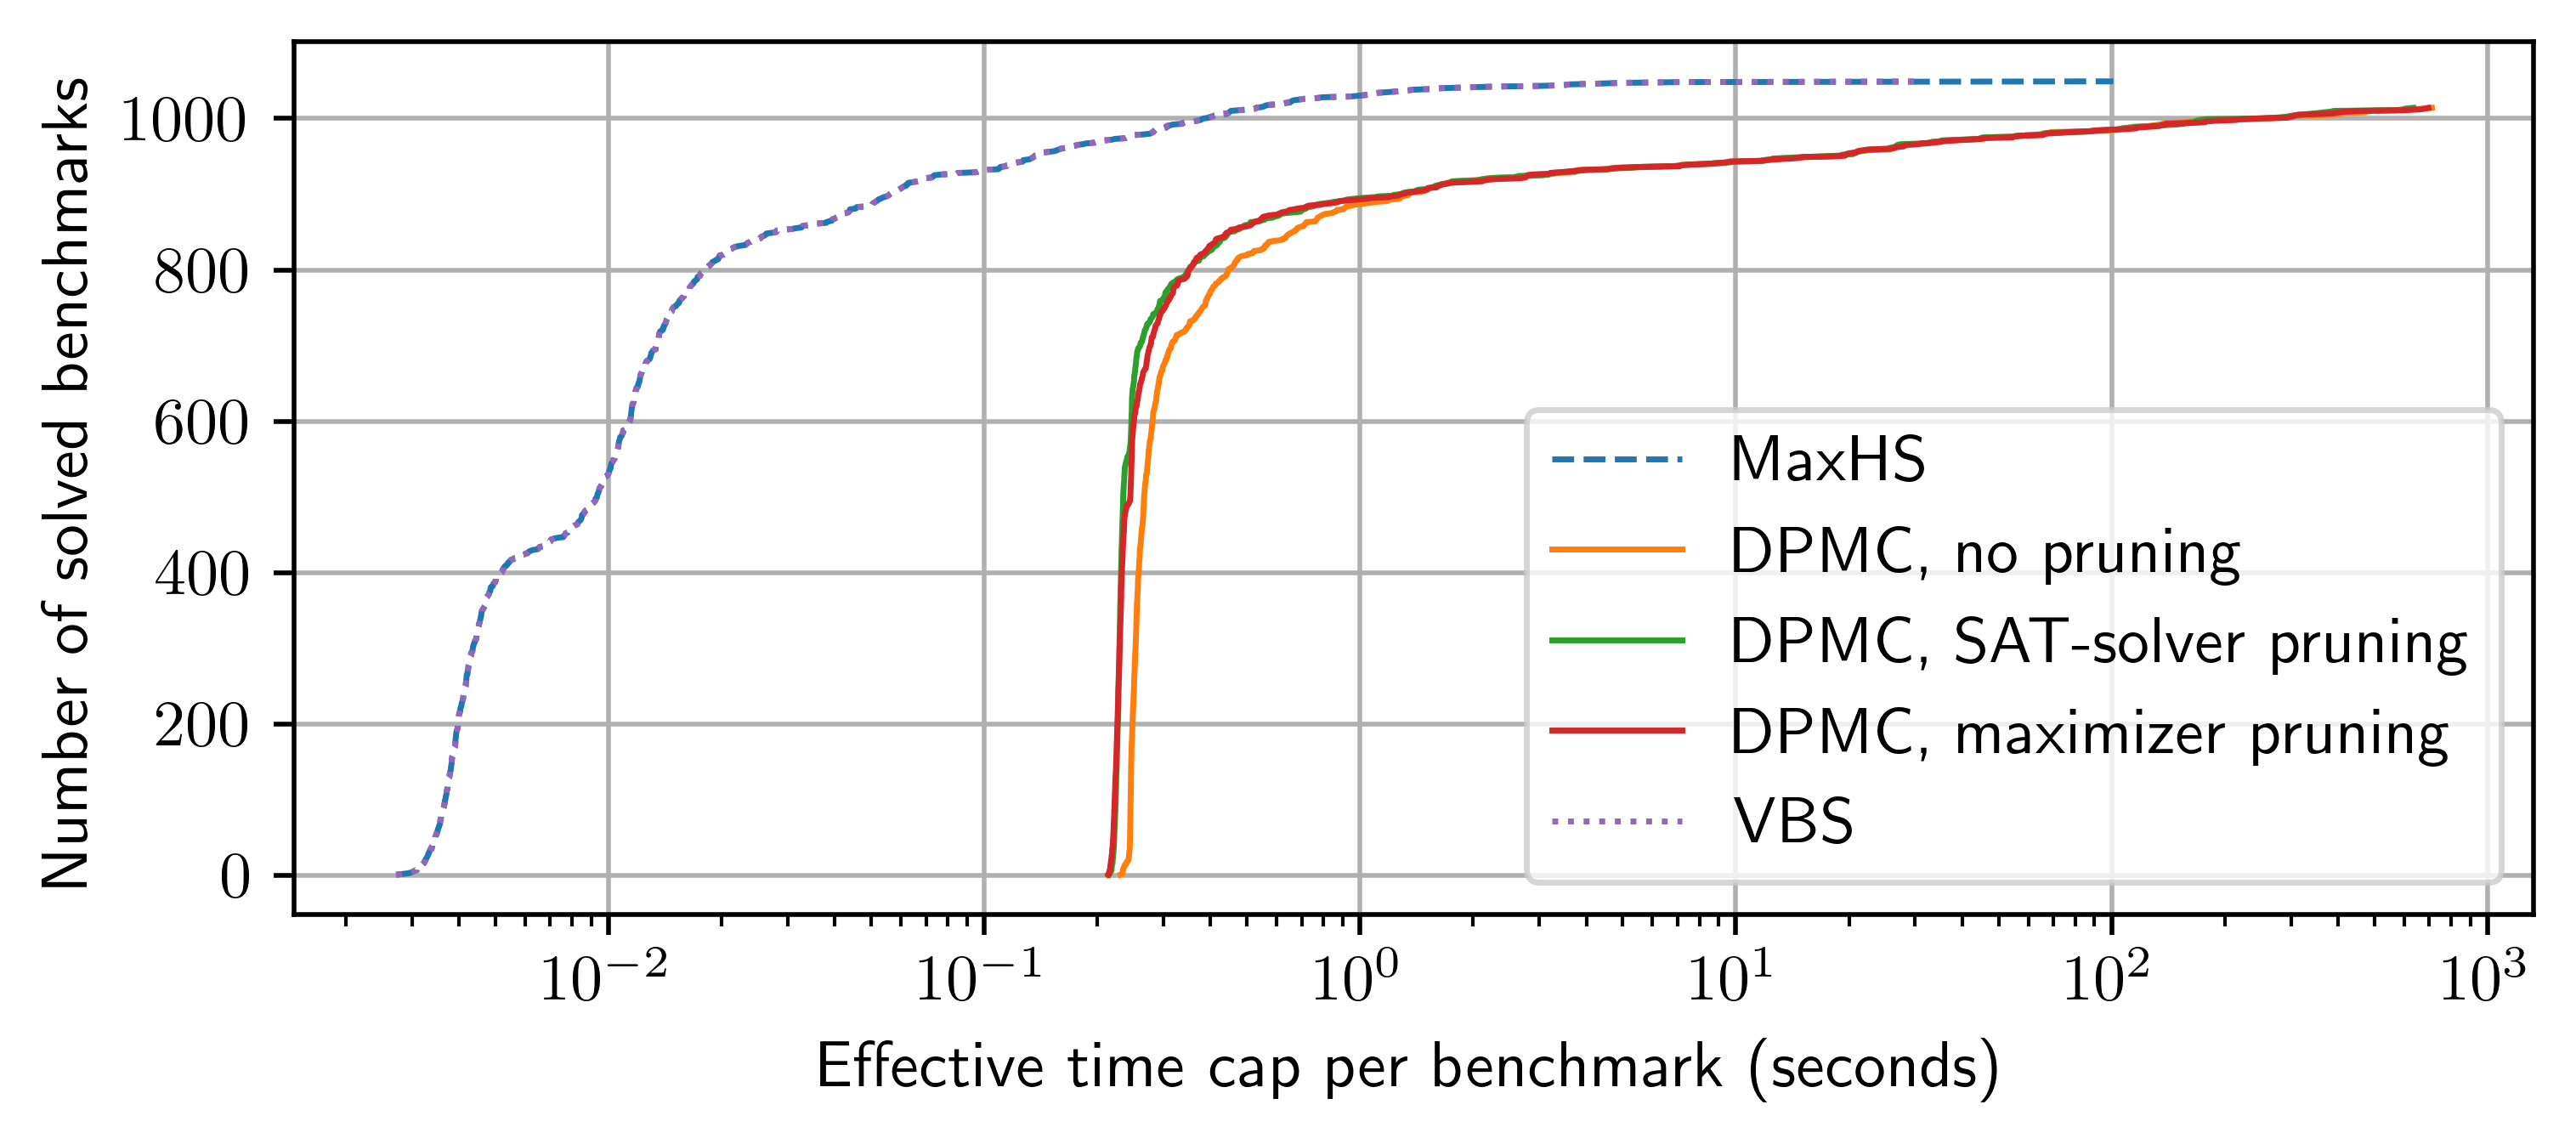

In [72]:
(fig, ax) = getFigAx(.4)

drawSolverCurve(ax, BAYES_PERF_TABLE, HS, 'MaxHS', '--')

drawSolverCurve(ax, BAYES_PERF_TABLE, DN, 'DPMC, no pruning', '-')
drawSolverCurve(ax, BAYES_PERF_TABLE, DS, 'DPMC, SAT-solver pruning', '-')
drawSolverCurve(ax, BAYES_PERF_TABLE, DM, 'DPMC, maximizer pruning', '-')

drawVbsCurve(ax, BAYES_PERF_TABLE, {
    HS,
    DN,
    DS,
    DM
}, 'VBS', ':')

#### Mix benchmarks

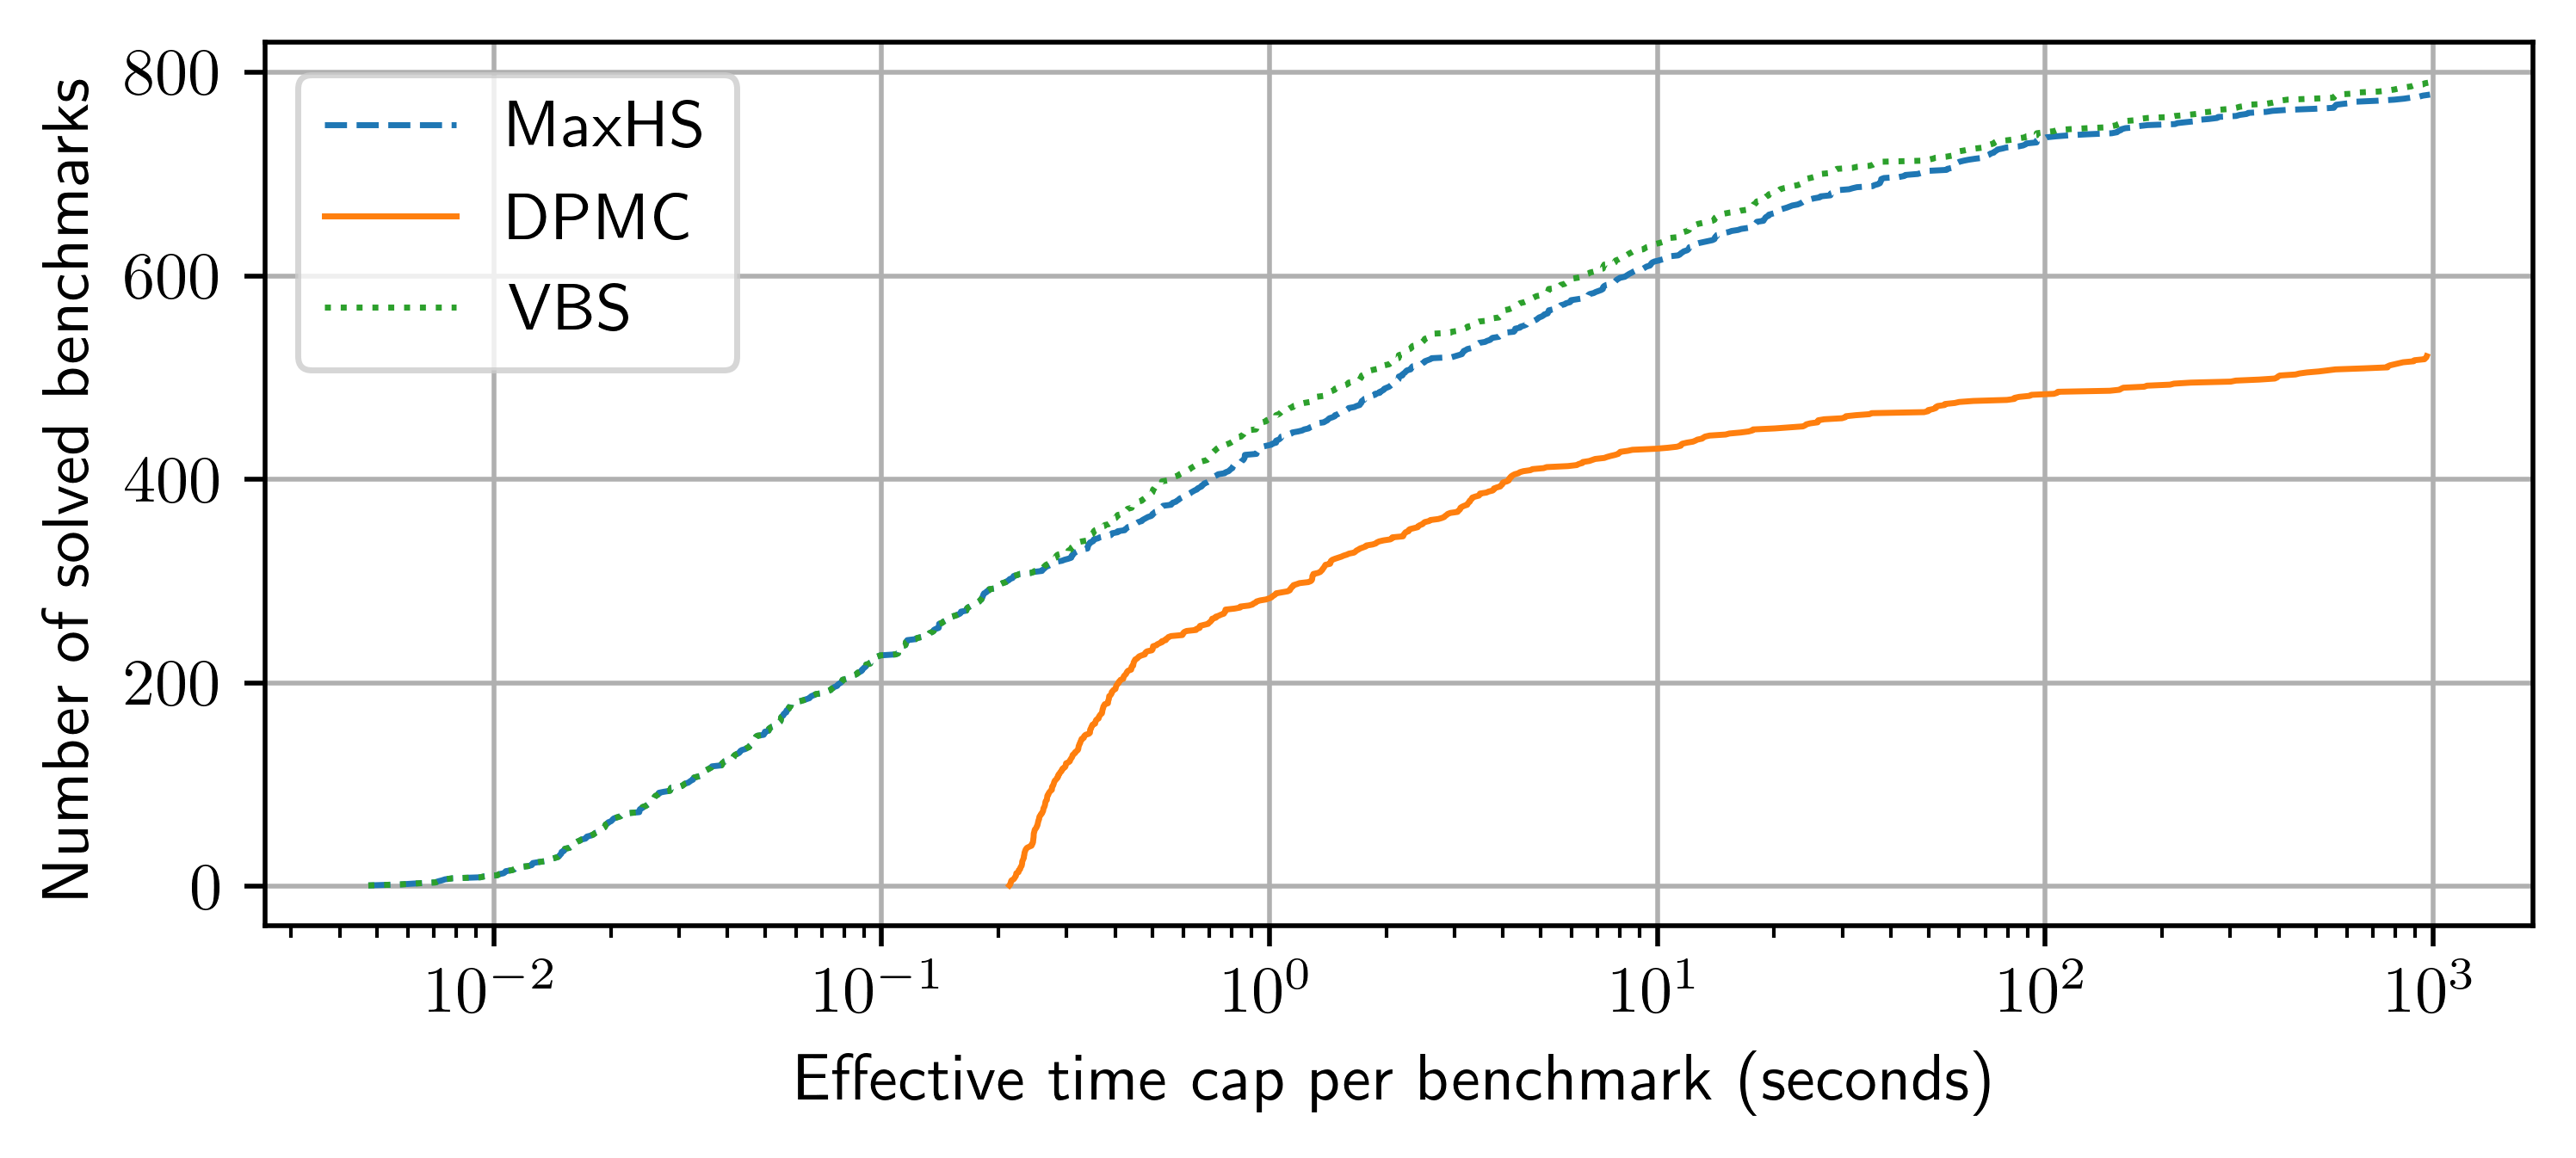

In [73]:
(fig, ax) = getFigAx(.4)

drawSolverCurve(ax, MIX_PERF_TABLE, HS, 'MaxHS', '--')
drawSolverCurve(ax, MIX_PERF_TABLE, DS, 'DPMC', '-')

drawVbsCurve(ax, MIX_PERF_TABLE, {
    HS,
    DS,
}, 'VBS', ':')

#### Chain benchmarks

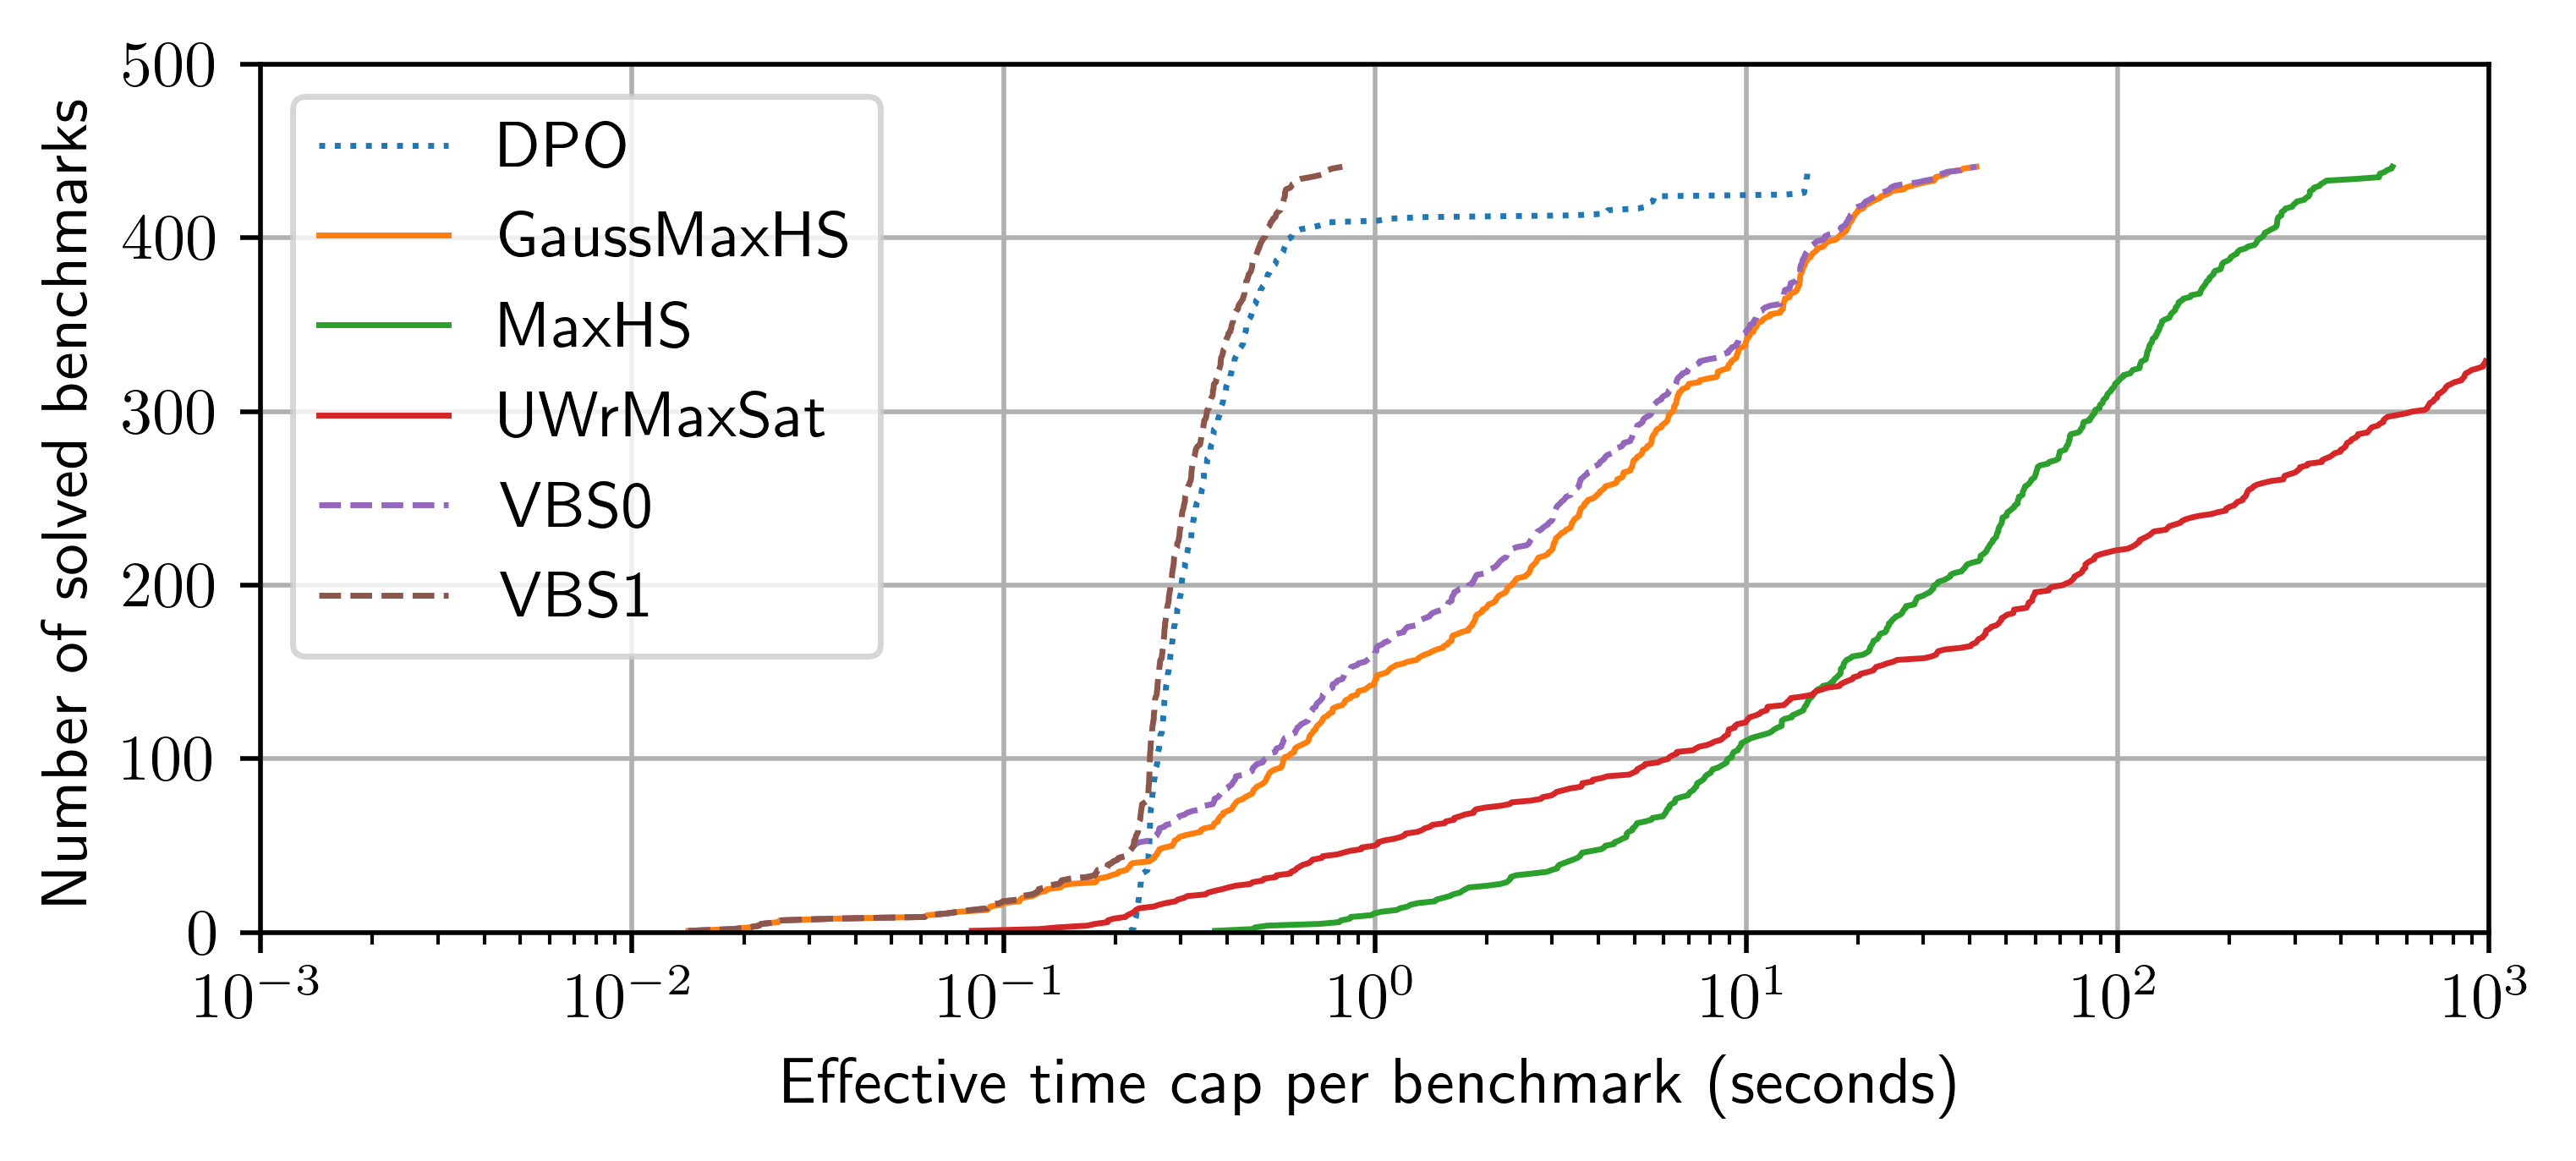

In [74]:
(fig, ax) = getFigAx(.4)
ax.set_xlim(1e-3, TIME)
ax.set_ylim(0, 500)

drawSolverCurve(ax, CHAIN_PERF_TABLE, DN, 'DPO', ':')

drawSolverCurve(ax, CHAIN_PERF_TABLE, GM, 'GaussMaxHS', '-')
drawSolverCurve(ax, CHAIN_PERF_TABLE, HS, 'MaxHS', '-')
drawSolverCurve(ax, CHAIN_PERF_TABLE, UW, 'UWrMaxSat', '-')

drawVbsCurve(ax, CHAIN_PERF_TABLE, {UW, HS, GM}, 'VBS0', '--')
drawVbsCurve(ax, CHAIN_PERF_TABLE, {UW, HS, GM, DN}, 'VBS1', '--')

# ax.legend(loc='lower right')

# saveFig(fig, '~/code/dpopaper/figures/chain.pgf')

### Scatter plots

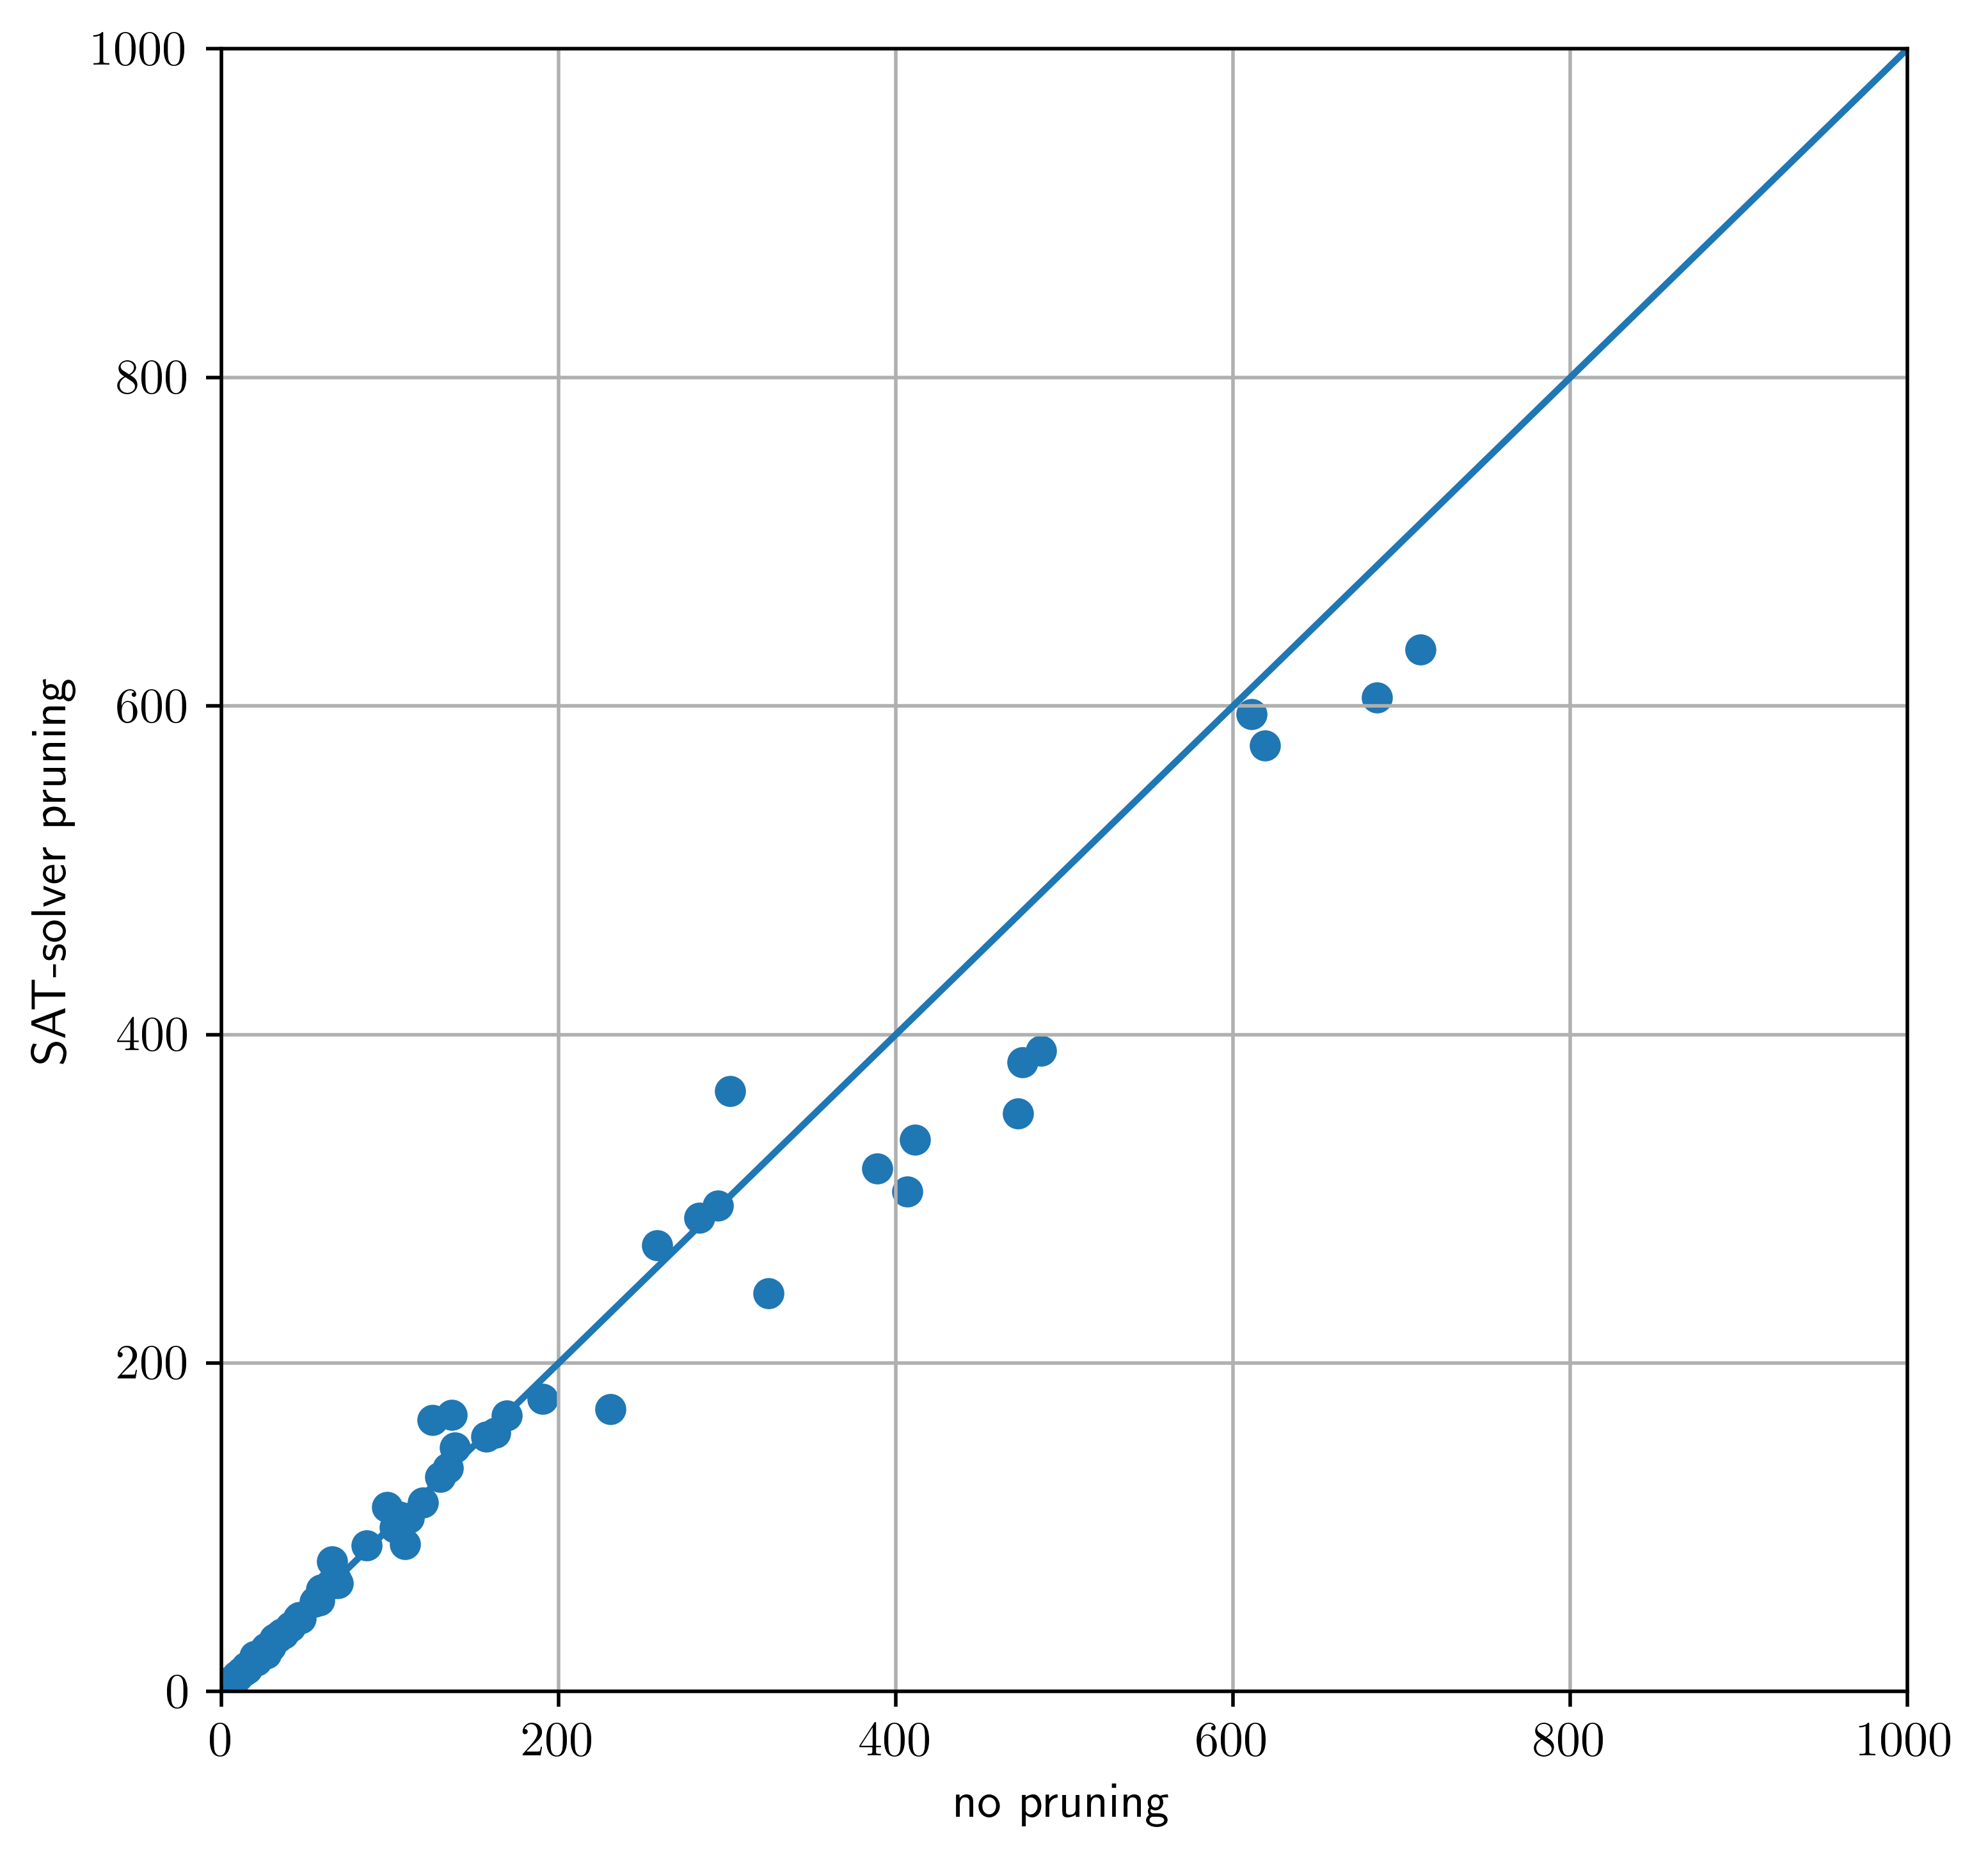

In [75]:
plotScatter(BAYES_PERF_TABLE, DN, 'no pruning', DS, 'SAT-solver pruning')

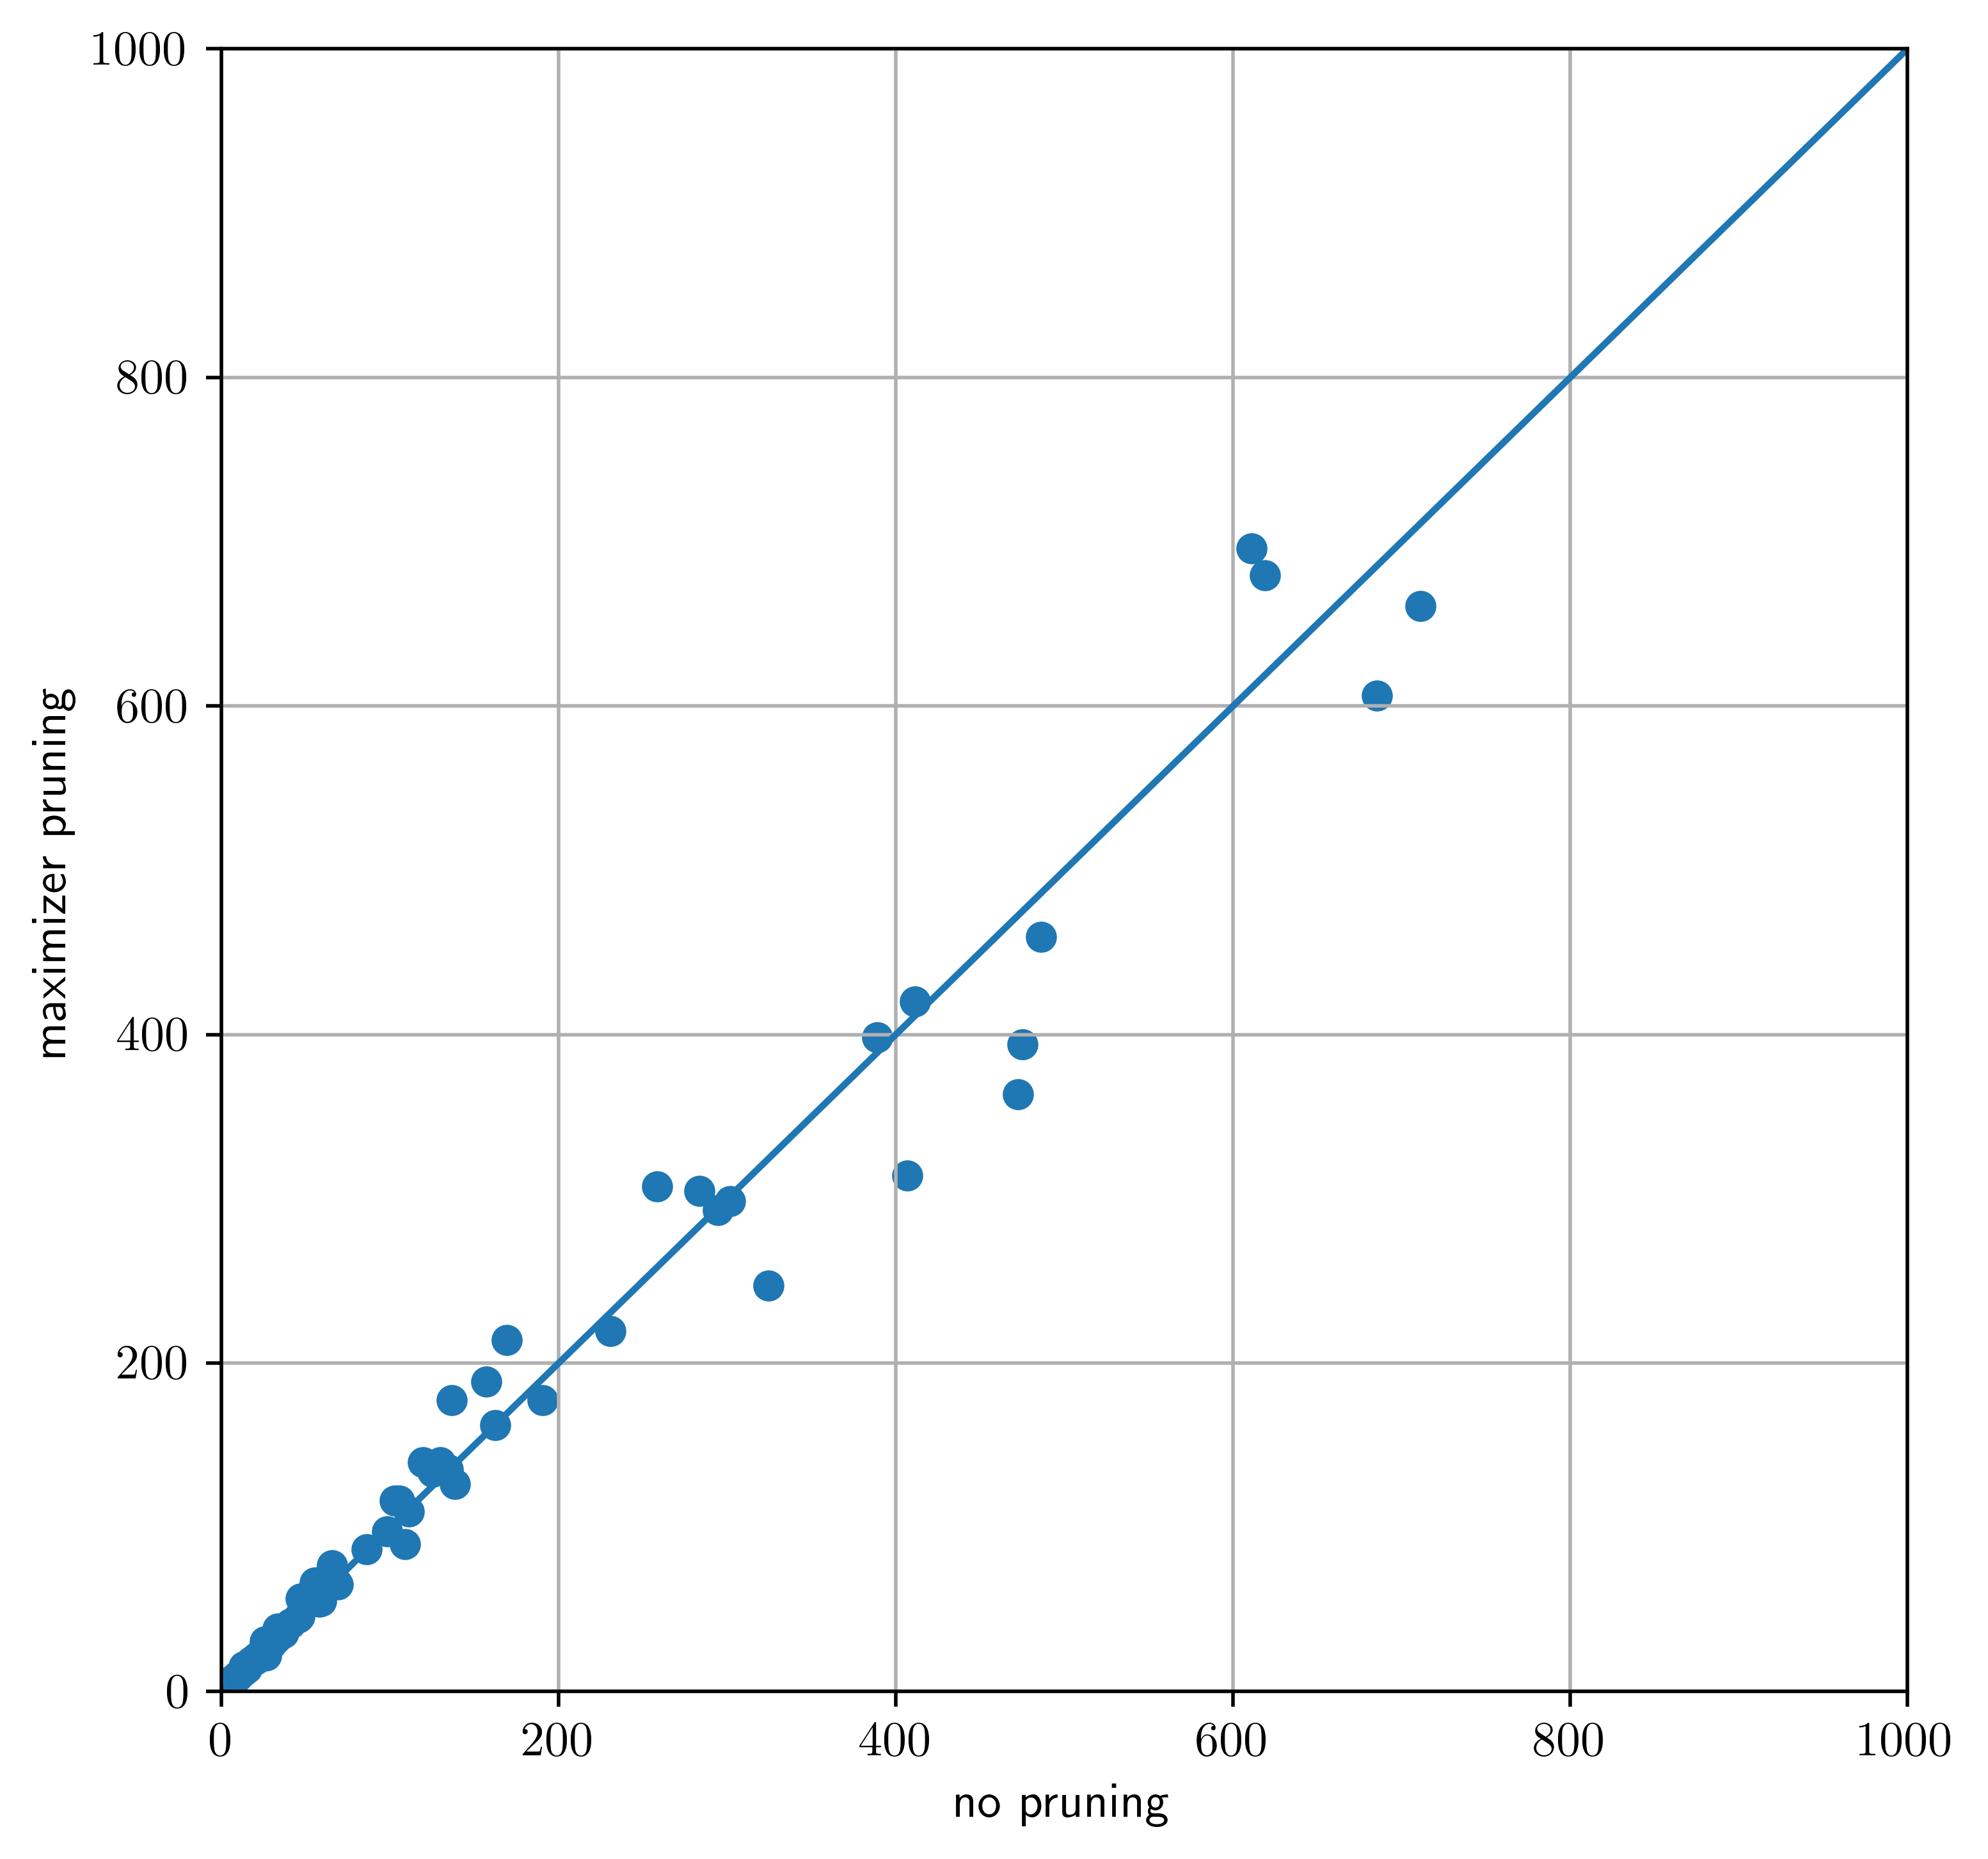

In [76]:
plotScatter(BAYES_PERF_TABLE, DN, 'no pruning', DM, 'maximizer pruning')

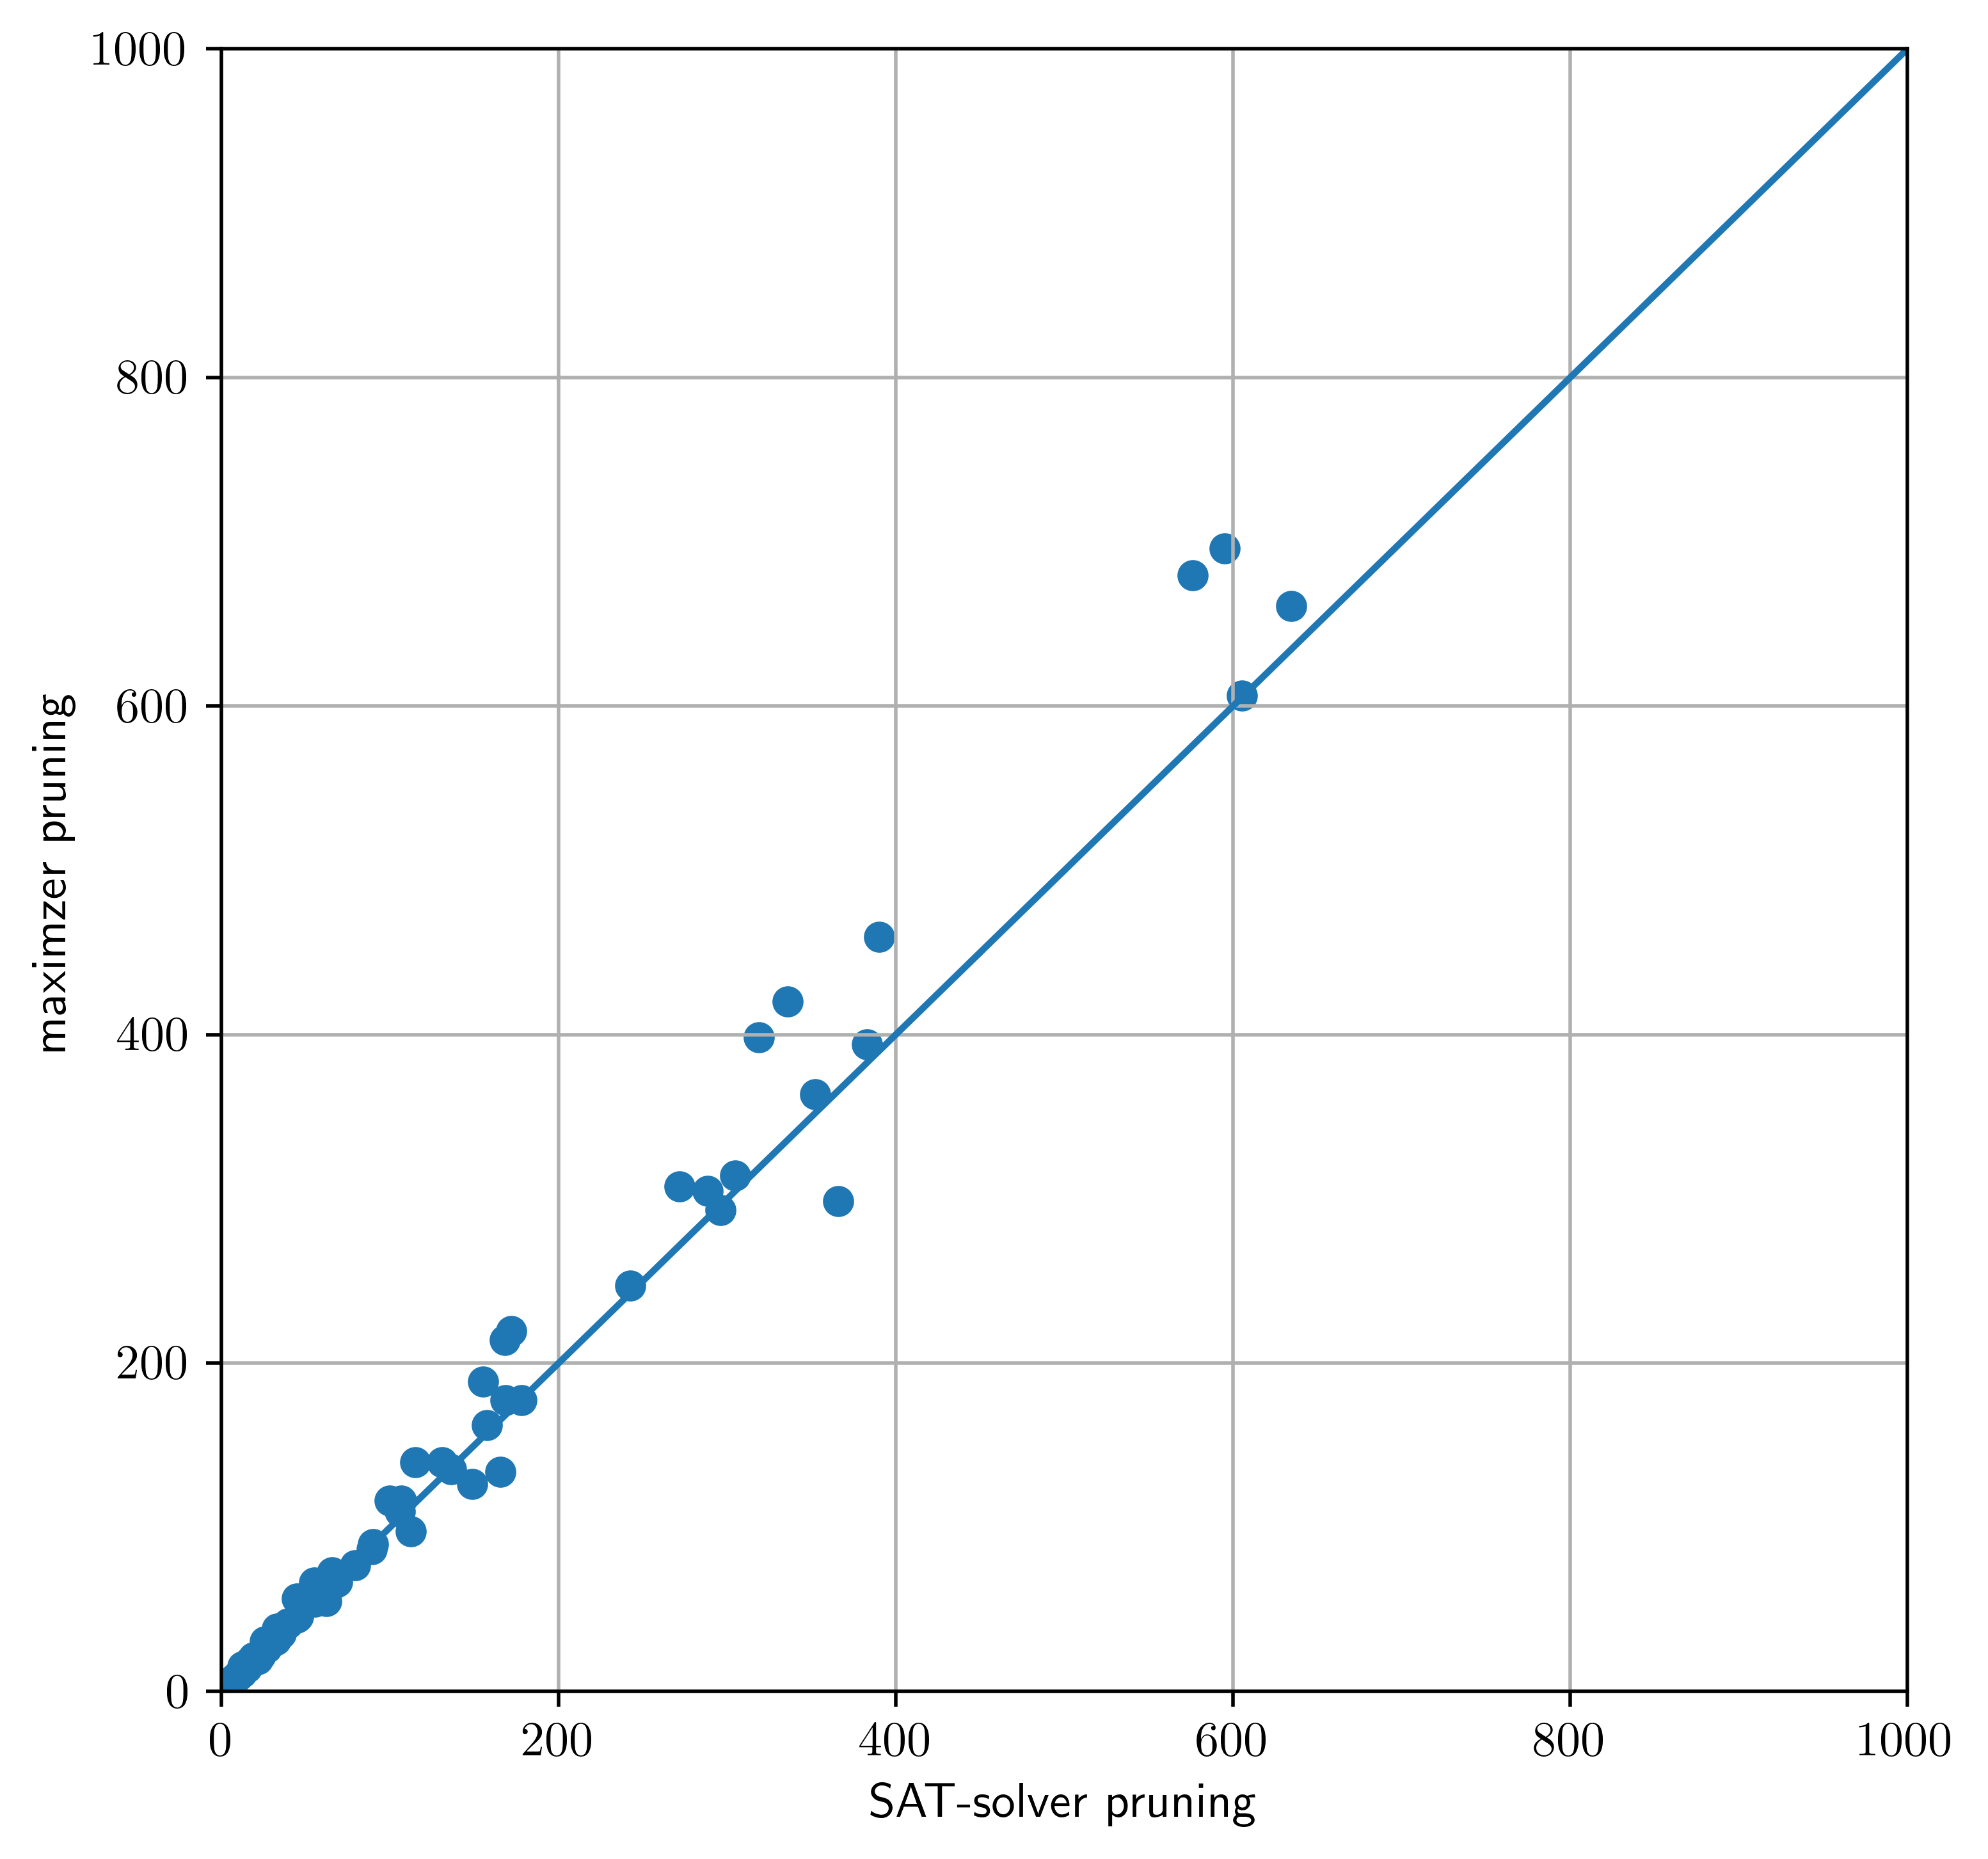

In [77]:
plotScatter(BAYES_PERF_TABLE, DS, 'SAT-solver pruning', DM, 'maximzer pruning')